# Neural Network Models to Explain Activity Silent Working Memory

## Setup and Hyperparameter Tuning

In [1]:
from utils import * # custom packages
import ipympl
import dill # for saving the notebook session
from scipy import stats
# %matplotlib inline
%matplotlib widget

In [2]:
# dill.load_session('current_notebook_env_thesis_draft.db')

In [52]:
from IPython.display import display, HTML
display(HTML("<style>.container {width: 90% !important; }</style>"))

In [12]:
# Hyperparameters - network
input_size = 8 # must be greater than len(stimulus_set) if doing the dual retro cue task in order to represent the cues in their own unique vector space
num_classes_mts = 1  # the number of units in the output layer for the match to sample task
num_classes_drc = 1  # the number of units in the output layer for the dual retro-cue task
hidden_size = 4  # the number of units in the recurrent layer
batch_size = 1  # batch size = # of samples to average when computing gradient
num_layers = 1  # number of stacked RNN/LSTM layers
eta = 0.005  # learning rate - note that the learning rate had to increase by a factor of 10
epochs = 150  # epochs = # of full pases through dataset
threshold = 0.25 # learning threshold for network to be considered "fully learned" on task
criterion = nn.BCELoss()  # loss function

In [18]:
# Hyperparameters - data generation & testing
num_networks = 30 # number of networks to average when calculating loss
generate_new = False # generates new datasets and targets (of the same type of task) for the network to train on
generate_random = False # shuffles the generated target and dataset order so the network doesn't simply learn the order of predictions to make but the type
return_sample_losses = False # returns the mean losses and all the losses for each type of test (only use this if generate random is False)
verbosity = 0 # during training whether to show loss at each quarter of an epoch (1), and show predictive output at each quarter of an epoch (2), or nothing (0)

In [19]:
# Hyperparameters - match to sample
small_middle = [0, 5, 0] # small train in the middle (condition)
large_middle = [0, 50, 0] # large train in the middle (condition)

# mts_seed_data, mts_seed_targets, mts_seed_sequence_length = generate_dataset(input_size, 0, 3, 0, random=generate_random, test_type='match_to_sample') -- this is just for reference

In [15]:
# Hyperparameters - dual retro-cue
small_small_delays = [5, 5] # two small delays
large_large_delays = [50, 50] # two large delays
stimulus1, stimulus2, stimulus3 = torch.tensor(np.eye(input_size)[0]), torch.tensor(np.eye(input_size)[1]), torch.tensor(np.eye(input_size)[2])
stimulus_set = [stimulus1, stimulus2, stimulus3]

# drc_seed_data, drc_seed_targets, drc_seed_sequence_length = generate_dataset(input_size, 3, 3, random=generate_random, test_type='dual_retro_cue') -- this is just for reference

In [16]:
def get_loss(test_type, network_type, num_networks, condition, memory_rule=None, multiple_tests=False, multiple_tests_type=None, stimulus_set=None):
    
    availible_tests = ['dual_retro_cue', 'match_to_sample']
    availible_networks = ['vanilla', 'gru', 'lstm', 'rnncell', 'grucell', 'lstmcell', 'dndlstmcell', 'wmemlstmcell']
        
    if (test_type in availible_tests) == False:
        print("Invalid test type, check your test type and try again")
        return
    
    if (network_type in availible_networks) == False:
        print("Invalid network type, check your network type and try again")
        return
        
    losses = []
    mean_loss = np.array([])

    sample_losses = []
    mean_sample_loss = np.array([])
    
    seeds = []
    cell = False # by default sets the cell to equal false
    
    if verbosity > 0:
        print('\nLosses for', network_type, 'network:')
    
    if test_type == 'match_to_sample':
        seqlen1, seqlen2, seqlen3 = condition[0], condition[1], condition[2]
        
        for i in range(num_networks):
            
            if verbosity > 0:
                print()
                print("Trial", i+1)
                print()
            
            if network_type == 'vanilla':
                seed = VanillaMTSNet(input_size, hidden_size, num_layers, num_classes_mts, batch_size, random_h0=True).to(device)
            if network_type == 'gru':
                seed = GRUMTSNet(input_size, hidden_size, num_classes_mts, batch_size, random_h0=True).to(device)
            if network_type == 'lstm':
                seed = LSTMMTSNet(input_size, hidden_size, num_layers, num_classes_mts, batch_size, random_h0=True, random_c0=True).to(device)
            if network_type == 'rnncell':
                cell = True
                seed = RNNCellMTSNet(input_size, hidden_size, num_classes_mts, batch_size, random_hx=True, random_cx=True).to(device)
            if network_type == 'grucell':
                cell = True
                seed = GRUCellMTSNet(input_size, hidden_size, num_classes_mts, batch_size, random_hx=True, random_cx=True).to(device)
            if network_type == 'lstmcell':
                cell = True
                seed = LSTMCellMTSNet(input_size, hidden_size, num_classes_mts, batch_size, random_hx=True, random_cx=True).to(device)
                
            # Loss function, optimizer, and schedule (for decaying learning rate)
            optimizer = optim.Adam(seed.parameters(), eta)  # tells optimizer to adjust all parameter weights with steps based on eta
            sheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, patience=5, verbose=False) # lowers lr if the loss global min doesn't decrease for 5 epochs
            dataset, targets, sequence_length = generate_dataset(input_size, seqlen1, seqlen2, seqlen3, random=generate_random, test_type=test_type)
            
            # Return the individual losses for each type of sample or just the general losses for all samples on a specific epoch
            if return_sample_losses == True:
                loss, sample_loss = train_network(seed, dataset, targets, sequence_length, input_size, batch_size, epochs, optimizer, criterion, sheduler, generate_new=generate_new, generate_random=generate_random, condition=condition, verbosity=verbosity, cell=cell, test_type=test_type, multiple_tests=multiple_tests, multiple_tests_type=multiple_tests_type, stimulus_set=stimulus_set, return_sample_losses=return_sample_losses)
                
                if i == 0:
                    mean_loss = loss
                    mean_sample_loss = sample_loss
                else:
                    mean_loss = mean_loss + loss
                    mean_sample_loss = mean_sample_loss + sample_loss
                
                seeds.append(seed)
                losses.append(loss)
                sample_losses.append(sample_loss)
                    
            else:
                loss = train_network(seed, dataset, targets, sequence_length, input_size, batch_size, epochs, optimizer, criterion, sheduler, generate_new=generate_new, generate_random=generate_random, condition=condition, verbosity=verbosity, cell=cell, test_type=test_type, multiple_tests=multiple_tests, multiple_tests_type=multiple_tests_type, stimulus_set=stimulus_set, return_sample_losses=return_sample_losses)
            
                if i == 0:
                    mean_loss = loss
                else:
                    mean_loss = mean_loss + loss
                
                seeds.append(seed)
                losses.append(loss)
        
    if test_type == 'dual_retro_cue':
        seqlen1, seqlen2 = condition[0], condition[1]
        
        for i in range(num_networks):
            
            if verbosity > 0:
                print()
                print("Trial", i+1)
                print()
            
            if network_type == 'vanilla':
                seed = VanillaDRCNet(input_size, hidden_size, num_layers, num_classes_drc, batch_size, seqlen1, seqlen2, random_h0=True, random_c0=True).to(device)
            if network_type == 'gru':
                seed = GRUDRCNet(input_size, hidden_size, num_layers, num_classes_drc, batch_size, seqlen1, seqlen2, random_h0=True, random_c0=True).to(device)
            if network_type == 'lstm':
                seed = LSTMDRCNet(input_size, hidden_size, num_layers, num_classes_drc, batch_size, seqlen1, seqlen2, random_h0=True, random_c0=True).to(device)
            if network_type == 'rnncell':
                cell = True
                seed = RNNCellDRCNet(input_size, hidden_size, num_classes_drc, batch_size, seqlen1, seqlen2, random_hx=True, random_cx=True).to(device)
            if network_type == 'grucell':
                cell = True
                seed = GRUCellDRCNet(input_size, hidden_size, num_classes_drc, batch_size, seqlen1, seqlen2, random_hx=True, random_cx=True).to(device)
            if network_type == 'lstmcell':
                cell = True
                seed = LSTMCellDRCNet(input_size, hidden_size, num_classes_drc, batch_size, seqlen1, seqlen2, random_hx=True, random_cx=True).to(device)
            if network_type == 'dndlstmcell':
                cell = True
                seed = DNDLSTMCellDRCNet(input_size, hidden_size, num_classes_drc, batch_size, seqlen1, seqlen2, memory_rule, random_hx=True, random_cx=True).to(device)
            if network_type == 'wmemlstmcell':
                cell = True
                seed = WMEMLSTMCellDRCNet(input_size, hidden_size, num_classes_drc, batch_size, seqlen1, seqlen2, memory_rule, random_hx=True, random_cx=True).to(device)
            
                
            # Loss function, optimizer, and schedule (for decaying learning rate)
            optimizer = optim.Adam(seed.parameters(), eta)  # tells optimizer to adjust all parameter weights with steps based on eta
            sheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, patience=5, verbose=False) # lowers lr if the loss global min doesn't decrease for 5 epochs
            dataset, targets, sequence_length = generate_dataset(input_size, seqlen1, seqlen2, random=generate_random, test_type=test_type)
            
            # Return the individual losses for each type of sample or just the general losses for all samples on a specific epoch
            if return_sample_losses == True:
                loss, sample_loss = train_network(seed, dataset, targets, sequence_length, input_size, batch_size, epochs, optimizer, criterion, sheduler, generate_new=generate_new, generate_random=generate_random, condition=condition, verbosity=verbosity, cell=cell, test_type=test_type, multiple_tests=multiple_tests, multiple_tests_type=multiple_tests_type, stimulus_set=stimulus_set, return_sample_losses=return_sample_losses)
                
                if i == 0:
                    mean_loss = loss
                    mean_sample_loss = sample_loss
                else:
                    mean_loss = mean_loss + loss
                    mean_sample_loss = mean_sample_loss + sample_loss
                
                seeds.append(seed)
                losses.append(loss)
                sample_losses.append(sample_loss)
                    
            else:
                loss = train_network(seed, dataset, targets, sequence_length, input_size, batch_size, epochs, optimizer, criterion, sheduler, generate_new=generate_new, generate_random=generate_random, condition=condition, verbosity=verbosity, cell=cell, test_type=test_type, multiple_tests=multiple_tests, multiple_tests_type=multiple_tests_type, stimulus_set=stimulus_set, return_sample_losses=return_sample_losses)
            
                if i == 0:
                    mean_loss = loss
                else:
                    mean_loss = mean_loss + loss
                
                seeds.append(seed)
                losses.append(loss)
            
    if return_sample_losses == True:
        losses = np.array(losses)
        mean_loss = mean_loss/num_networks
        sample_losses = np.array(sample_losses)
        mean_sample_loss = mean_sample_loss/num_networks
        return mean_loss, losses, mean_sample_loss, sample_losses, seeds
    else:
        losses = np.array(losses)
        mean_loss = mean_loss/num_networks
        return mean_loss, losses, seeds

In [20]:
def partition_sample_losses(test_type, mean_sample_loss, sample_losses):
    
    mean_sample_loss_dict = {}
    sample_losses_dict = {}
    
    if test_type == "match_to_sample":
        num_samples = 4
    if test_type == "dual_retro_cue":
        num_samples = 28
    
    mean_sample_iteration = 0
    current_sample_iteration = 0
    
    for epoch in range(len(mean_sample_loss)//num_samples):
        for sample_num in range(num_samples):
            if sample_num not in mean_sample_loss_dict.keys():
                mean_sample_loss_dict.update({sample_num : [mean_sample_loss[mean_sample_iteration]]}) #turn the type into a list so it can be appendable
            else:
                mean_sample_loss_dict[sample_num].append(mean_sample_loss[mean_sample_iteration])
            mean_sample_iteration += 1

    # cast everything back into numpy arrays
    for sample in mean_sample_loss_dict:
        mean_sample_loss_dict[sample] = np.array(mean_sample_loss_dict[sample])
        
            
    for network_num in range(num_networks):
        
        current_sample_set = sample_losses[network_num]
        
        for epoch in range(len(current_sample_set)//num_samples):
            for sample_num in range(num_samples):
                if sample_num not in sample_losses_dict.keys():
                    sample_losses_dict.update({sample_num : [current_sample_set[current_sample_iteration]]}) #turn the type into a list so it can be appendable
                else:
                    sample_losses_dict[sample_num].append(current_sample_set[current_sample_iteration])
            current_sample_iteration += 1
        
        current_sample_iteration = 0
        
    # cast everything back into numpy arrays
    for sample in sample_losses_dict:
        sample_losses_dict[sample] = np.array(sample_losses_dict[sample]) # cast list into numpy array
        sample_losses_dict[sample] = np.array_split(sample_losses_dict[sample], num_networks) # split array
        sample_losses_dict[sample] = np.array(sample_losses_dict[sample]) # cast to a tuple containing numpy arrays
            
    return mean_sample_loss_dict, sample_losses_dict

## **Match to Sample Task**

In [21]:
# MTS Task w/ Simple RNNs -- Hyperparameters
generate_new = False
generate_random = True
return_sample_losses = False
multiple_tests = False
test_type = 'match_to_sample'

### *Vanilla RNN ~ Training*

In [ ]:
# Match to Sample Networks with Vanilla RNN
network_type = 'rnncell'
mean_loss_small_rnncell_mts,losses_small_rnncell_mts,_ = get_loss(test_type=test_type, network_type=network_type, num_networks=num_networks, condition=small_middle)
mean_loss_large_rnncell_mts,losses_large_rnncell_mts,_ = get_loss(test_type=test_type, network_type=network_type, num_networks=num_networks, condition=large_middle)

### *GRU RNN ~ Training*

In [ ]:
## Optonal: GRU-Based Networks for MTS Task ##
# network_type = 'grucell'
# mean_loss_small_grucell_mts,losses_small_grucell_mts,_ = get_loss(test_type=test_type, network_type=network_type, num_networks=num_networks, condition=small_middle)
# mean_loss_large_grucell_mts,losses_large_grucell_mts,_ = get_loss(test_type=test_type, network_type=network_type, num_networks=num_networks, condition=large_middle)

### *LSTM RNN ~ Training*

In [ ]:
# Match to Sample Networks with LSTM
network_type = 'lstmcell'
mean_loss_small_lstmcell_mts,losses_small_lstmcell_mts,_ = get_loss(test_type=test_type, network_type=network_type, num_networks=num_networks, condition=small_middle)
mean_loss_large_lstmcell_mts,losses_large_lstmcell_mts,_ = get_loss(test_type=test_type, network_type=network_type, num_networks=num_networks, condition=large_middle)

### *Graphs for Match to Sample Task*

In [ ]:
### Plots for MTS Task ###

fig, ax = plt.subplots(1,2)

# plot losses
fig.suptitle("Average Effect of Distraction Train Length on Network Loss for Different Simple RNNs in Match-to-Sample Task", fontsize=10)

## Mean losses (Control)
ax[0].plot(mean_loss_small_rnncell_mts, color='red', label="Small middle train (mean, n=" + str(num_networks) + ") - Vanilla RNN", linewidth=2)
ax[1].plot(mean_loss_large_rnncell_mts, color='orangered', label="Large middle train (mean, n=" + str(num_networks) + ") - Vanilla RNN", linewidth=2)

## Mean losses (Test)
ax[0].plot(mean_loss_small_lstmcell_mts, color='dodgerblue', label="Small middle train (mean, n=" + str(num_networks) + ") - LSTM", linewidth=2)
ax[1].plot(mean_loss_large_lstmcell_mts, color='deepskyblue', label="Large middle train (mean, n=" + str(num_networks) + ") - LSTM", linewidth=2)

## Standard deviations (Control)
ax[0].plot((mean_loss_small_rnncell_mts + 2*stats.sem(losses_small_rnncell_mts, axis=0, ddof=0)), color='lightcoral', label="Vanilla RNN ±2se", linewidth=0.7) # small case
ax[0].plot((mean_loss_small_rnncell_mts - 2*stats.sem(losses_small_rnncell_mts, axis=0, ddof=0)), color='lightcoral', linewidth=0.7) # small case

ax[1].plot((mean_loss_large_rnncell_mts + 2*stats.sem(losses_large_rnncell_mts, axis=0, ddof=0)), color='coral', label="Vanilla RNN ±2se", linewidth=0.7) # large case
ax[1].plot((mean_loss_large_rnncell_mts - 2*stats.sem(losses_large_rnncell_mts, axis=0, ddof=0)), color='coral', linewidth=0.7) # large case

## Standard deviations (Test)
ax[0].plot((mean_loss_small_lstmcell_mts + 2*stats.sem(losses_small_lstmcell_mts, axis=0, ddof=0)), color='steelblue', label="LSTM ±2se", linewidth=0.7) # small case
ax[0].plot((mean_loss_small_lstmcell_mts - 2*stats.sem(losses_small_lstmcell_mts, axis=0, ddof=0)), color='steelblue', linewidth=0.7) # small case

ax[1].plot((mean_loss_large_lstmcell_mts + 2*stats.sem(losses_large_lstmcell_mts, axis=0, ddof=0)), color='skyblue', label="LSTM ±2se", linewidth=0.7) # large case
ax[1].plot((mean_loss_large_lstmcell_mts - 2*stats.sem(losses_large_lstmcell_mts, axis=0, ddof=0)), color='skyblue', linewidth=0.7) # large case

# Threshold line
ax[0].axhline(threshold, linestyle='dashed', color='black')
ax[1].axhline(threshold, linestyle='dashed', color='black')

# legend and show plot
ax[0].legend(fontsize=8, loc="upper right") # by default, the legend ignores all elements without a label attribute set.
ax[1].legend(fontsize=8, loc="upper right") # by default, the legend ignores all elements without a label attribute set.


plt.show()

## **Dual Retro-Cue Task w/ Simple RNNs**

In [ ]:
# DRC Task w/ Simple RNNs -- Hyperparameters
generate_new = True
generate_random = False
return_sample_losses = True
multiple_tests = True
test_type = 'dual_retro_cue'
multiple_tests_type='resue_one_stimulus'

### *Vanilla RNN ~ Training*

In [ ]:
# DRC Task with Vanilla RNN
network_type = 'rnncell'
mean_loss_small_rnncell_drc,losses_small_rnncell_drc,mean_sample_loss_small_rnncell_drc,sample_losses_small_rnncell_drc,_ = get_loss(test_type=test_type, network_type=network_type, num_networks=num_networks, condition=small_small_delays, multiple_tests=multiple_tests, multiple_tests_type=multiple_tests_type, stimulus_set=stimulus_set)
mean_loss_large_rnncell_drc,losses_large_rnncell_drc,mean_sample_loss_large_rnncell_drc,sample_losses_large_rnncell_drc,_ = get_loss(test_type=test_type, network_type=network_type, num_networks=num_networks, condition=large_large_delays, multiple_tests=multiple_tests, multiple_tests_type=multiple_tests_type, stimulus_set=stimulus_set)

### *GRU RNN ~ Training*

In [ ]:
# # Optonal: GRU-Based Networks for DRC Task ##
# # DRC Task with GRU
# network_type = 'grucell'
# mean_loss_small_grucell_drc,losses_small_grucell_drc,mean_sample_loss_small_grucell_drc,sample_losses_small_grucell_drc,_ = get_loss(test_type=test_type, network_type=network_type, num_networks=num_networks, condition=small_small_delays, multiple_tests=multiple_tests, multiple_tests_type=multiple_tests_type, stimulus_set=stimulus_set)
# mean_loss_large_grucell_drc,losses_large_grucell_drc,mean_sample_loss_large_grucell_drc,sample_losses_large_grucell_drc,_ = get_loss(test_type=test_type, network_type=network_type, num_networks=num_networks, condition=large_large_delays, multiple_tests=multiple_tests, multiple_tests_type=multiple_tests_type, stimulus_set=stimulus_set)

### *LSTM RNN ~ Training*

In [ ]:
# DRC Task with LSTM
network_type = 'lstmcell'
mean_loss_small_lstmcell_drc,losses_small_lstmcell_drc,mean_sample_loss_small_lstmcell_drc,sample_losses_small_lstmcell_drc,_ = get_loss(test_type=test_type, network_type=network_type, num_networks=num_networks, condition=small_small_delays, multiple_tests=multiple_tests, multiple_tests_type=multiple_tests_type, stimulus_set=stimulus_set)
mean_loss_large_lstmcell_drc,losses_large_lstmcell_drc,mean_sample_loss_large_lstmcell_drc,sample_losses_large_lstmcell_drc,_ = get_loss(test_type=test_type, network_type=network_type, num_networks=num_networks, condition=large_large_delays, multiple_tests=multiple_tests, multiple_tests_type=multiple_tests_type, stimulus_set=stimulus_set)

### *Graphs for Simple Neural Networks on the Dual Retro-Cue Task*

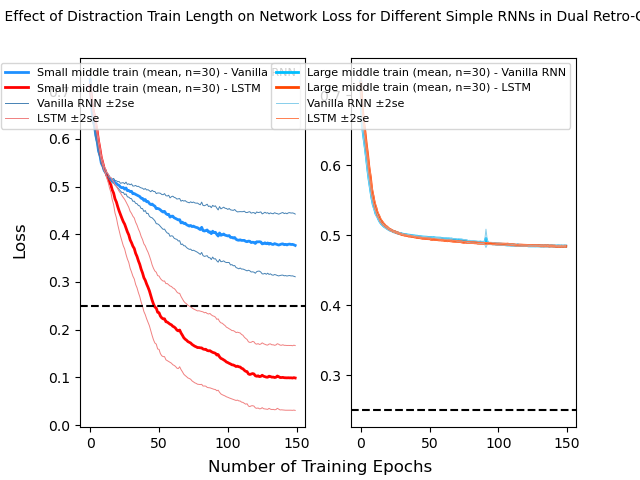

In [77]:
### Plots for DRC Task ###

fig, ax = plt.subplots(1,2)

# plot losses
fig.suptitle("Average Effect of Distraction Train Length on Network Loss for Different Simple RNNs in Dual Retro-Cue Task", fontsize=10)

## Mean losses (Control)
ax[0].plot(mean_loss_small_rnncell_drc, color='dodgerblue', label="Small middle train (mean, n=" + str(num_networks) + ") - Vanilla RNN", linewidth=2)
ax[1].plot(mean_loss_large_rnncell_drc, color='deepskyblue', label="Large middle train (mean, n=" + str(num_networks) + ") - Vanilla RNN", linewidth=2)

## Mean losses (Test)
ax[0].plot(mean_loss_small_lstmcell_drc, color='red', label="Small middle train (mean, n=" + str(num_networks) + ") - LSTM", linewidth=2)
ax[1].plot(mean_loss_large_lstmcell_drc, color='orangered', label="Large middle train (mean, n=" + str(num_networks) + ") - LSTM", linewidth=2)

## Standard deviations (Control)
ax[0].plot((mean_loss_small_rnncell_drc + 2*stats.sem(losses_small_rnncell_drc, axis=0, ddof=0)), color='steelblue', label="Vanilla RNN ±2se", linewidth=0.7) # small case
ax[0].plot((mean_loss_small_rnncell_drc - 2*stats.sem(losses_small_rnncell_drc, axis=0, ddof=0)), color='steelblue', linewidth=0.7) # small case

ax[1].plot((mean_loss_large_rnncell_drc + 2*stats.sem(losses_large_rnncell_drc, axis=0, ddof=0)), color='skyblue', label="Vanilla RNN ±2se", linewidth=0.7) # large case
ax[1].plot((mean_loss_large_rnncell_drc - 2*stats.sem(losses_large_rnncell_drc, axis=0, ddof=0)), color='skyblue', linewidth=0.7) # large case

## Standard deviations (Test)
ax[0].plot((mean_loss_small_lstmcell_drc + 2*stats.sem(losses_small_lstmcell_drc, axis=0, ddof=0)), color='lightcoral', label="LSTM ±2se", linewidth=0.7) # small case
ax[0].plot((mean_loss_small_lstmcell_drc - 2*stats.sem(losses_small_lstmcell_drc, axis=0, ddof=0)), color='lightcoral', linewidth=0.7) # small case

ax[1].plot((mean_loss_large_lstmcell_drc + 2*stats.sem(losses_large_lstmcell_drc, axis=0, ddof=0)), color='coral', label="LSTM ±2se", linewidth=0.7) # large case
ax[1].plot((mean_loss_large_lstmcell_drc - 2*stats.sem(losses_large_lstmcell_drc, axis=0, ddof=0)), color='coral', linewidth=0.7) # large case

# Threshold line
ax[0].axhline(threshold, linestyle='dashed', color='black')
ax[1].axhline(threshold, linestyle='dashed', color='black')

# legend and show plot
ax[0].legend(fontsize=8, loc="upper right") # by default, the legend ignores all elements without a label attribute set.
ax[1].legend(fontsize=8, loc="upper right") # by default, the legend ignores all elements without a label attribute set.

fig.supxlabel('Number of Training Epochs')
fig.supylabel('Loss')


plt.show()

#### *Graph on Each Trial Type for Simple RNNs on the Dual Retro-Cue Task (Small Delays)*

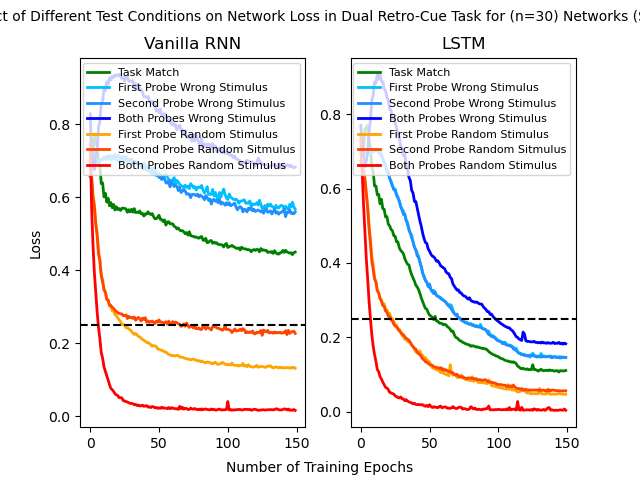

In [49]:
### Specific Plots for WMEM DRC Task ###

### RNNCell ###

mean_sample_loss_small_rnncell_drc_dict, sample_losses_small_rnncell_drc_dict = partition_sample_losses("dual_retro_cue", mean_sample_loss_small_rnncell_drc, sample_losses_small_rnncell_drc)

task0_mean_loss = mean_sample_loss_small_rnncell_drc_dict[0]
task1_mean_loss = mean_sample_loss_small_rnncell_drc_dict[1]
task2_mean_loss = mean_sample_loss_small_rnncell_drc_dict[2]
task3_mean_loss = mean_sample_loss_small_rnncell_drc_dict[3]
task4_mean_loss = mean_sample_loss_small_rnncell_drc_dict[4]
task5_mean_loss = mean_sample_loss_small_rnncell_drc_dict[5]
task6_mean_loss = mean_sample_loss_small_rnncell_drc_dict[6]
task7_mean_loss = mean_sample_loss_small_rnncell_drc_dict[7]
task8_mean_loss = mean_sample_loss_small_rnncell_drc_dict[8]
task9_mean_loss = mean_sample_loss_small_rnncell_drc_dict[9]
task10_mean_loss = mean_sample_loss_small_rnncell_drc_dict[10]
task11_mean_loss = mean_sample_loss_small_rnncell_drc_dict[11]
task12_mean_loss = mean_sample_loss_small_rnncell_drc_dict[12]
task13_mean_loss = mean_sample_loss_small_rnncell_drc_dict[13]
task14_mean_loss = mean_sample_loss_small_rnncell_drc_dict[14]
task15_mean_loss = mean_sample_loss_small_rnncell_drc_dict[15]
task16_mean_loss = mean_sample_loss_small_rnncell_drc_dict[16]
task17_mean_loss = mean_sample_loss_small_rnncell_drc_dict[17]
task18_mean_loss = mean_sample_loss_small_rnncell_drc_dict[18]
task19_mean_loss = mean_sample_loss_small_rnncell_drc_dict[19]
task20_mean_loss = mean_sample_loss_small_rnncell_drc_dict[20]
task21_mean_loss = mean_sample_loss_small_rnncell_drc_dict[21]
task22_mean_loss = mean_sample_loss_small_rnncell_drc_dict[22]
task23_mean_loss = mean_sample_loss_small_rnncell_drc_dict[23]
task24_mean_loss = mean_sample_loss_small_rnncell_drc_dict[24]
task25_mean_loss = mean_sample_loss_small_rnncell_drc_dict[25]
task26_mean_loss = mean_sample_loss_small_rnncell_drc_dict[26]
task27_mean_loss = mean_sample_loss_small_rnncell_drc_dict[27]

task0_sample_losses = sample_losses_small_rnncell_drc_dict[0]
task1_sample_losses = sample_losses_small_rnncell_drc_dict[1]
task2_sample_losses = sample_losses_small_rnncell_drc_dict[2]
task3_sample_losses = sample_losses_small_rnncell_drc_dict[3]
task4_sample_losses = sample_losses_small_rnncell_drc_dict[4]
task5_sample_losses = sample_losses_small_rnncell_drc_dict[5]
task6_sample_losses = sample_losses_small_rnncell_drc_dict[6]
task7_sample_losses = sample_losses_small_rnncell_drc_dict[7]
task8_sample_losses = sample_losses_small_rnncell_drc_dict[8]
task9_sample_losses = sample_losses_small_rnncell_drc_dict[9]
task10_sample_losses = sample_losses_small_rnncell_drc_dict[10]
task11_sample_losses = sample_losses_small_rnncell_drc_dict[11]
task12_sample_losses = sample_losses_small_rnncell_drc_dict[12]
task13_sample_losses = sample_losses_small_rnncell_drc_dict[13]
task14_sample_losses = sample_losses_small_rnncell_drc_dict[14]
task15_sample_losses = sample_losses_small_rnncell_drc_dict[15]
task16_sample_losses = sample_losses_small_rnncell_drc_dict[16]
task17_sample_losses = sample_losses_small_rnncell_drc_dict[17]
task18_sample_losses = sample_losses_small_rnncell_drc_dict[18]
task19_sample_losses = sample_losses_small_rnncell_drc_dict[19]
task20_sample_losses = sample_losses_small_rnncell_drc_dict[20]
task21_sample_losses = sample_losses_small_rnncell_drc_dict[21]
task22_sample_losses = sample_losses_small_rnncell_drc_dict[22]
task23_sample_losses = sample_losses_small_rnncell_drc_dict[23]
task24_sample_losses = sample_losses_small_rnncell_drc_dict[24]
task25_sample_losses = sample_losses_small_rnncell_drc_dict[25]
task26_sample_losses = sample_losses_small_rnncell_drc_dict[26]
task27_sample_losses = sample_losses_small_rnncell_drc_dict[27]

# testing different cases when the same cues are made before the probes (Vanilla Working Memory Case)
match_losses_same_cues = [task1_mean_loss, task3_mean_loss]
first_probe_wrong_stimuli_losses_same_cues = [task12_mean_loss, task14_mean_loss]
first_probe_random_stimuli_losses_same_cues = [task13_mean_loss, task15_mean_loss]
second_probe_wrong_stimuli_losses_same_cues = [task16_mean_loss, task18_mean_loss]
second_probe_random_stimuli_losses_same_cues = [task17_mean_loss, task19_mean_loss]
both_probes_wrong_stimuli_losses_same_cues = [task24_mean_loss, task26_mean_loss]
both_probes_random_stimuli_losses_same_cues = [task25_mean_loss, task27_mean_loss]


# testing different cases when a different second cue is made before the second probe (ASWM case)
match_losses_different_cues = [task0_mean_loss, task2_mean_loss]
first_probe_wrong_stimuli_losses_different_cues = [task4_mean_loss, task6_mean_loss]
first_probe_random_stimuli_losses_different_cues = [task5_mean_loss, task7_mean_loss]
second_probe_wrong_stimuli_losses_different_cues = [task8_mean_loss, task10_mean_loss]
second_probe_random_stimuli_losses_different_cues = [task9_mean_loss, task11_mean_loss]
both_probes_wrong_stimuli_losses_different_cues = [task20_mean_loss, task22_mean_loss]
both_probes_random_stimuli_losses_different_cues = [task21_mean_loss, task23_mean_loss]

# get the mean losses for each of these 7 categories

match_losses_small_rnncell = match_losses_same_cues + match_losses_different_cues
first_probe_wrong_stimuli_losses_small_rnncell = first_probe_wrong_stimuli_losses_same_cues + first_probe_wrong_stimuli_losses_different_cues
first_probe_random_stimuli_losses_small_rnncell = first_probe_random_stimuli_losses_same_cues + first_probe_random_stimuli_losses_different_cues
second_probe_wrong_stimuli_losses_small_rnncell = second_probe_wrong_stimuli_losses_same_cues + second_probe_wrong_stimuli_losses_different_cues
second_probe_random_stimuli_losses_small_rnncell = second_probe_random_stimuli_losses_same_cues + second_probe_random_stimuli_losses_different_cues
both_probes_wrong_stimuli_losses_small_rnncell = both_probes_wrong_stimuli_losses_same_cues + both_probes_wrong_stimuli_losses_different_cues
both_probes_random_stimuli_losses_small_rnncell = both_probes_random_stimuli_losses_same_cues + both_probes_random_stimuli_losses_different_cues


match_mean_losses_small_rnncell = np.mean(match_losses_small_rnncell, axis=0)
first_probe_wrong_stimuli_mean_losses_small_rnncell = np.mean(first_probe_wrong_stimuli_losses_small_rnncell, axis=0)
first_probe_random_stimuli_mean_losses_small_rnncell = np.mean(first_probe_random_stimuli_losses_small_rnncell, axis=0)
second_probe_wrong_stimuli_mean_losses_small_rnncell = np.mean(second_probe_wrong_stimuli_losses_small_rnncell, axis=0)
second_probe_random_stimuli_mean_losses_small_rnncell = np.mean(second_probe_random_stimuli_losses_small_rnncell, axis=0)
both_probes_wrong_stimuli_mean_losses_small_rnncell = np.mean(both_probes_wrong_stimuli_losses_small_rnncell, axis=0)
both_probes_random_stimuli_mean_losses_small_rnncell = np.mean(both_probes_random_stimuli_losses_small_rnncell, axis=0)

### Specific Plots for WMEM DRC Task ###

### LSTMCell ###

mean_sample_loss_small_lstmcell_drc_dict, sample_losses_small_lstmcell_drc_dict = partition_sample_losses("dual_retro_cue", mean_sample_loss_small_lstmcell_drc, sample_losses_small_lstmcell_drc)

task0_mean_loss = mean_sample_loss_small_lstmcell_drc_dict[0]
task1_mean_loss = mean_sample_loss_small_lstmcell_drc_dict[1]
task2_mean_loss = mean_sample_loss_small_lstmcell_drc_dict[2]
task3_mean_loss = mean_sample_loss_small_lstmcell_drc_dict[3]
task4_mean_loss = mean_sample_loss_small_lstmcell_drc_dict[4]
task5_mean_loss = mean_sample_loss_small_lstmcell_drc_dict[5]
task6_mean_loss = mean_sample_loss_small_lstmcell_drc_dict[6]
task7_mean_loss = mean_sample_loss_small_lstmcell_drc_dict[7]
task8_mean_loss = mean_sample_loss_small_lstmcell_drc_dict[8]
task9_mean_loss = mean_sample_loss_small_lstmcell_drc_dict[9]
task10_mean_loss = mean_sample_loss_small_lstmcell_drc_dict[10]
task11_mean_loss = mean_sample_loss_small_lstmcell_drc_dict[11]
task12_mean_loss = mean_sample_loss_small_lstmcell_drc_dict[12]
task13_mean_loss = mean_sample_loss_small_lstmcell_drc_dict[13]
task14_mean_loss = mean_sample_loss_small_lstmcell_drc_dict[14]
task15_mean_loss = mean_sample_loss_small_lstmcell_drc_dict[15]
task16_mean_loss = mean_sample_loss_small_lstmcell_drc_dict[16]
task17_mean_loss = mean_sample_loss_small_lstmcell_drc_dict[17]
task18_mean_loss = mean_sample_loss_small_lstmcell_drc_dict[18]
task19_mean_loss = mean_sample_loss_small_lstmcell_drc_dict[19]
task20_mean_loss = mean_sample_loss_small_lstmcell_drc_dict[20]
task21_mean_loss = mean_sample_loss_small_lstmcell_drc_dict[21]
task22_mean_loss = mean_sample_loss_small_lstmcell_drc_dict[22]
task23_mean_loss = mean_sample_loss_small_lstmcell_drc_dict[23]
task24_mean_loss = mean_sample_loss_small_lstmcell_drc_dict[24]
task25_mean_loss = mean_sample_loss_small_lstmcell_drc_dict[25]
task26_mean_loss = mean_sample_loss_small_lstmcell_drc_dict[26]
task27_mean_loss = mean_sample_loss_small_lstmcell_drc_dict[27]

task0_sample_losses = sample_losses_small_lstmcell_drc_dict[0]
task1_sample_losses = sample_losses_small_lstmcell_drc_dict[1]
task2_sample_losses = sample_losses_small_lstmcell_drc_dict[2]
task3_sample_losses = sample_losses_small_lstmcell_drc_dict[3]
task4_sample_losses = sample_losses_small_lstmcell_drc_dict[4]
task5_sample_losses = sample_losses_small_lstmcell_drc_dict[5]
task6_sample_losses = sample_losses_small_lstmcell_drc_dict[6]
task7_sample_losses = sample_losses_small_lstmcell_drc_dict[7]
task8_sample_losses = sample_losses_small_lstmcell_drc_dict[8]
task9_sample_losses = sample_losses_small_lstmcell_drc_dict[9]
task10_sample_losses = sample_losses_small_lstmcell_drc_dict[10]
task11_sample_losses = sample_losses_small_lstmcell_drc_dict[11]
task12_sample_losses = sample_losses_small_lstmcell_drc_dict[12]
task13_sample_losses = sample_losses_small_lstmcell_drc_dict[13]
task14_sample_losses = sample_losses_small_lstmcell_drc_dict[14]
task15_sample_losses = sample_losses_small_lstmcell_drc_dict[15]
task16_sample_losses = sample_losses_small_lstmcell_drc_dict[16]
task17_sample_losses = sample_losses_small_lstmcell_drc_dict[17]
task18_sample_losses = sample_losses_small_lstmcell_drc_dict[18]
task19_sample_losses = sample_losses_small_lstmcell_drc_dict[19]
task20_sample_losses = sample_losses_small_lstmcell_drc_dict[20]
task21_sample_losses = sample_losses_small_lstmcell_drc_dict[21]
task22_sample_losses = sample_losses_small_lstmcell_drc_dict[22]
task23_sample_losses = sample_losses_small_lstmcell_drc_dict[23]
task24_sample_losses = sample_losses_small_lstmcell_drc_dict[24]
task25_sample_losses = sample_losses_small_lstmcell_drc_dict[25]
task26_sample_losses = sample_losses_small_lstmcell_drc_dict[26]
task27_sample_losses = sample_losses_small_lstmcell_drc_dict[27]

# testing different cases when the same cues are made before the probes (Vanilla Working Memory Case)
match_losses_same_cues = [task1_mean_loss, task3_mean_loss]
first_probe_wrong_stimuli_losses_same_cues = [task12_mean_loss, task14_mean_loss]
first_probe_random_stimuli_losses_same_cues = [task13_mean_loss, task15_mean_loss]
second_probe_wrong_stimuli_losses_same_cues = [task16_mean_loss, task18_mean_loss]
second_probe_random_stimuli_losses_same_cues = [task17_mean_loss, task19_mean_loss]
both_probes_wrong_stimuli_losses_same_cues = [task24_mean_loss, task26_mean_loss]
both_probes_random_stimuli_losses_same_cues = [task25_mean_loss, task27_mean_loss]


# testing different cases when a different second cue is made before the second probe (ASWM case)
match_losses_different_cues = [task0_mean_loss, task2_mean_loss]
first_probe_wrong_stimuli_losses_different_cues = [task4_mean_loss, task6_mean_loss]
first_probe_random_stimuli_losses_different_cues = [task5_mean_loss, task7_mean_loss]
second_probe_wrong_stimuli_losses_different_cues = [task8_mean_loss, task10_mean_loss]
second_probe_random_stimuli_losses_different_cues = [task9_mean_loss, task11_mean_loss]
both_probes_wrong_stimuli_losses_different_cues = [task20_mean_loss, task22_mean_loss]
both_probes_random_stimuli_losses_different_cues = [task21_mean_loss, task23_mean_loss]

# get the mean losses for each of these 7 categories

match_losses_small_lstmcell = match_losses_same_cues + match_losses_different_cues
first_probe_wrong_stimuli_losses_small_lstmcell = first_probe_wrong_stimuli_losses_same_cues + first_probe_wrong_stimuli_losses_different_cues
first_probe_random_stimuli_losses_small_lstmcell = first_probe_random_stimuli_losses_same_cues + first_probe_random_stimuli_losses_different_cues
second_probe_wrong_stimuli_losses_small_lstmcell = second_probe_wrong_stimuli_losses_same_cues + second_probe_wrong_stimuli_losses_different_cues
second_probe_random_stimuli_losses_small_lstmcell = second_probe_random_stimuli_losses_same_cues + second_probe_random_stimuli_losses_different_cues
both_probes_wrong_stimuli_losses_small_lstmcell = both_probes_wrong_stimuli_losses_same_cues + both_probes_wrong_stimuli_losses_different_cues
both_probes_random_stimuli_losses_small_lstmcell = both_probes_random_stimuli_losses_same_cues + both_probes_random_stimuli_losses_different_cues


match_mean_losses_small_lstmcell = np.mean(match_losses_small_lstmcell, axis=0)
first_probe_wrong_stimuli_mean_losses_small_lstmcell = np.mean(first_probe_wrong_stimuli_losses_small_lstmcell, axis=0)
first_probe_random_stimuli_mean_losses_small_lstmcell = np.mean(first_probe_random_stimuli_losses_small_lstmcell, axis=0)
second_probe_wrong_stimuli_mean_losses_small_lstmcell = np.mean(second_probe_wrong_stimuli_losses_small_lstmcell, axis=0)
second_probe_random_stimuli_mean_losses_small_lstmcell = np.mean(second_probe_random_stimuli_losses_small_lstmcell, axis=0)
both_probes_wrong_stimuli_mean_losses_small_lstmcell = np.mean(both_probes_wrong_stimuli_losses_small_lstmcell, axis=0)
both_probes_random_stimuli_mean_losses_small_lstmcell = np.mean(both_probes_random_stimuli_losses_small_lstmcell, axis=0)


fig, ax = plt.subplots(1,2)

# plot losses
fig.suptitle("Average Effect of Different Test Conditions on Network Loss in Dual Retro-Cue Task for (n=" + str(num_networks) + ") Networks (Small Delays)", fontsize=10)

# Individual losses for each sample type (where the same stimulus is cued each round)
ax[0].set_title("Vanilla RNN")
ax[0].plot(match_mean_losses_small_rnncell, color='green', label="Task Match", linewidth=2)
ax[0].plot(first_probe_wrong_stimuli_mean_losses_small_rnncell, color='deepskyblue', label="First Probe Wrong Stimulus", linewidth=2)
ax[0].plot(second_probe_wrong_stimuli_mean_losses_small_rnncell, color='dodgerblue', label="Second Probe Wrong Stimulus", linewidth=2)
ax[0].plot(both_probes_wrong_stimuli_mean_losses_small_rnncell, color='blue', label="Both Probes Wrong Stimulus", linewidth=2)
ax[0].plot(first_probe_random_stimuli_mean_losses_small_rnncell, color='orange', label="First Probe Random Stimulus", linewidth=2)
ax[0].plot(second_probe_random_stimuli_mean_losses_small_rnncell, color='orangered', label="Second Probe Random Sitmulus", linewidth=2)
ax[0].plot(both_probes_random_stimuli_mean_losses_small_rnncell, color='red', label="Both Probes Random Stimulus", linewidth=2)

# Individual losses for each sample type (where a different stimulus is cued each round)
ax[1].set_title("LSTM")
ax[1].plot(match_mean_losses_small_lstmcell, color='green', label="Task Match", linewidth=2)
ax[1].plot(first_probe_wrong_stimuli_mean_losses_small_lstmcell, color='deepskyblue', label="First Probe Wrong Stimulus", linewidth=2)
ax[1].plot(second_probe_wrong_stimuli_mean_losses_small_lstmcell, color='dodgerblue', label="Second Probe Wrong Stimulus", linewidth=2)
ax[1].plot(both_probes_wrong_stimuli_mean_losses_small_lstmcell, color='blue', label="Both Probes Wrong Stimulus", linewidth=2)
ax[1].plot(first_probe_random_stimuli_mean_losses_small_lstmcell, color='orange', label="First Probe Random Stimulus", linewidth=2)
ax[1].plot(second_probe_random_stimuli_mean_losses_small_lstmcell, color='orangered', label="Second Probe Random Sitmulus", linewidth=2)
ax[1].plot(both_probes_random_stimuli_mean_losses_small_lstmcell, color='red', label="Both Probes Random Stimulus", linewidth=2)

# Threshold line
ax[0].axhline(threshold, linestyle='dashed', color='black')
ax[1].axhline(threshold, linestyle='dashed', color='black')

# legend and show plot
ax[0].legend(fontsize=8, loc="upper right") # by default, the legend ignores all elements without a label attribute set.
ax[1].legend(fontsize=8, loc="upper right") # by default, the legend ignores all elements without a label attribute set.

fig.supxlabel('Number of Training Epochs', fontsize=10) # x label
ax[0].set_ylabel('Loss', fontsize=10) # y label

plt.show()

#### *Graph on Each Trial Type for Simple RNNs on the Dual Retro-Cue Task (Large Delays)*

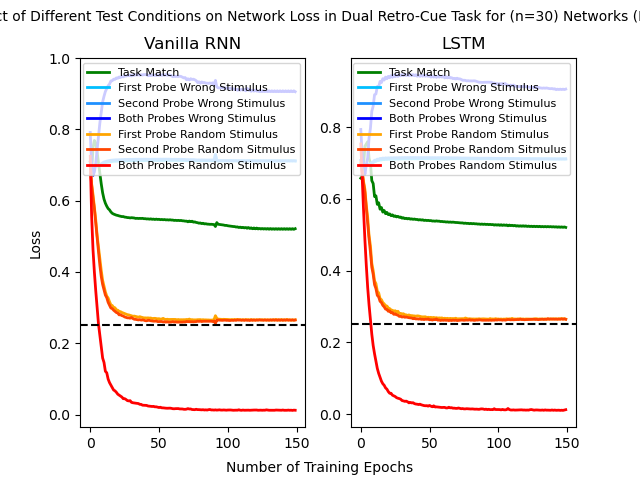

In [50]:
### Specific Plots for WMEM DRC Task ###

### RNNCell ###

mean_sample_loss_large_rnncell_drc_dict, sample_losses_large_rnncell_drc_dict = partition_sample_losses("dual_retro_cue", mean_sample_loss_large_rnncell_drc, sample_losses_large_rnncell_drc)

task0_mean_loss = mean_sample_loss_large_rnncell_drc_dict[0]
task1_mean_loss = mean_sample_loss_large_rnncell_drc_dict[1]
task2_mean_loss = mean_sample_loss_large_rnncell_drc_dict[2]
task3_mean_loss = mean_sample_loss_large_rnncell_drc_dict[3]
task4_mean_loss = mean_sample_loss_large_rnncell_drc_dict[4]
task5_mean_loss = mean_sample_loss_large_rnncell_drc_dict[5]
task6_mean_loss = mean_sample_loss_large_rnncell_drc_dict[6]
task7_mean_loss = mean_sample_loss_large_rnncell_drc_dict[7]
task8_mean_loss = mean_sample_loss_large_rnncell_drc_dict[8]
task9_mean_loss = mean_sample_loss_large_rnncell_drc_dict[9]
task10_mean_loss = mean_sample_loss_large_rnncell_drc_dict[10]
task11_mean_loss = mean_sample_loss_large_rnncell_drc_dict[11]
task12_mean_loss = mean_sample_loss_large_rnncell_drc_dict[12]
task13_mean_loss = mean_sample_loss_large_rnncell_drc_dict[13]
task14_mean_loss = mean_sample_loss_large_rnncell_drc_dict[14]
task15_mean_loss = mean_sample_loss_large_rnncell_drc_dict[15]
task16_mean_loss = mean_sample_loss_large_rnncell_drc_dict[16]
task17_mean_loss = mean_sample_loss_large_rnncell_drc_dict[17]
task18_mean_loss = mean_sample_loss_large_rnncell_drc_dict[18]
task19_mean_loss = mean_sample_loss_large_rnncell_drc_dict[19]
task20_mean_loss = mean_sample_loss_large_rnncell_drc_dict[20]
task21_mean_loss = mean_sample_loss_large_rnncell_drc_dict[21]
task22_mean_loss = mean_sample_loss_large_rnncell_drc_dict[22]
task23_mean_loss = mean_sample_loss_large_rnncell_drc_dict[23]
task24_mean_loss = mean_sample_loss_large_rnncell_drc_dict[24]
task25_mean_loss = mean_sample_loss_large_rnncell_drc_dict[25]
task26_mean_loss = mean_sample_loss_large_rnncell_drc_dict[26]
task27_mean_loss = mean_sample_loss_large_rnncell_drc_dict[27]

task0_sample_losses = sample_losses_large_rnncell_drc_dict[0]
task1_sample_losses = sample_losses_large_rnncell_drc_dict[1]
task2_sample_losses = sample_losses_large_rnncell_drc_dict[2]
task3_sample_losses = sample_losses_large_rnncell_drc_dict[3]
task4_sample_losses = sample_losses_large_rnncell_drc_dict[4]
task5_sample_losses = sample_losses_large_rnncell_drc_dict[5]
task6_sample_losses = sample_losses_large_rnncell_drc_dict[6]
task7_sample_losses = sample_losses_large_rnncell_drc_dict[7]
task8_sample_losses = sample_losses_large_rnncell_drc_dict[8]
task9_sample_losses = sample_losses_large_rnncell_drc_dict[9]
task10_sample_losses = sample_losses_large_rnncell_drc_dict[10]
task11_sample_losses = sample_losses_large_rnncell_drc_dict[11]
task12_sample_losses = sample_losses_large_rnncell_drc_dict[12]
task13_sample_losses = sample_losses_large_rnncell_drc_dict[13]
task14_sample_losses = sample_losses_large_rnncell_drc_dict[14]
task15_sample_losses = sample_losses_large_rnncell_drc_dict[15]
task16_sample_losses = sample_losses_large_rnncell_drc_dict[16]
task17_sample_losses = sample_losses_large_rnncell_drc_dict[17]
task18_sample_losses = sample_losses_large_rnncell_drc_dict[18]
task19_sample_losses = sample_losses_large_rnncell_drc_dict[19]
task20_sample_losses = sample_losses_large_rnncell_drc_dict[20]
task21_sample_losses = sample_losses_large_rnncell_drc_dict[21]
task22_sample_losses = sample_losses_large_rnncell_drc_dict[22]
task23_sample_losses = sample_losses_large_rnncell_drc_dict[23]
task24_sample_losses = sample_losses_large_rnncell_drc_dict[24]
task25_sample_losses = sample_losses_large_rnncell_drc_dict[25]
task26_sample_losses = sample_losses_large_rnncell_drc_dict[26]
task27_sample_losses = sample_losses_large_rnncell_drc_dict[27]

# testing different cases when the same cues are made before the probes (Vanilla Working Memory Case)
match_losses_same_cues = [task1_mean_loss, task3_mean_loss]
first_probe_wrong_stimuli_losses_same_cues = [task12_mean_loss, task14_mean_loss]
first_probe_random_stimuli_losses_same_cues = [task13_mean_loss, task15_mean_loss]
second_probe_wrong_stimuli_losses_same_cues = [task16_mean_loss, task18_mean_loss]
second_probe_random_stimuli_losses_same_cues = [task17_mean_loss, task19_mean_loss]
both_probes_wrong_stimuli_losses_same_cues = [task24_mean_loss, task26_mean_loss]
both_probes_random_stimuli_losses_same_cues = [task25_mean_loss, task27_mean_loss]


# testing different cases when a different second cue is made before the second probe (ASWM case)
match_losses_different_cues = [task0_mean_loss, task2_mean_loss]
first_probe_wrong_stimuli_losses_different_cues = [task4_mean_loss, task6_mean_loss]
first_probe_random_stimuli_losses_different_cues = [task5_mean_loss, task7_mean_loss]
second_probe_wrong_stimuli_losses_different_cues = [task8_mean_loss, task10_mean_loss]
second_probe_random_stimuli_losses_different_cues = [task9_mean_loss, task11_mean_loss]
both_probes_wrong_stimuli_losses_different_cues = [task20_mean_loss, task22_mean_loss]
both_probes_random_stimuli_losses_different_cues = [task21_mean_loss, task23_mean_loss]

# get the mean losses for each of these 7 categories

match_losses_large_rnncell = match_losses_same_cues + match_losses_different_cues
first_probe_wrong_stimuli_losses_large_rnncell = first_probe_wrong_stimuli_losses_same_cues + first_probe_wrong_stimuli_losses_different_cues
first_probe_random_stimuli_losses_large_rnncell = first_probe_random_stimuli_losses_same_cues + first_probe_random_stimuli_losses_different_cues
second_probe_wrong_stimuli_losses_large_rnncell = second_probe_wrong_stimuli_losses_same_cues + second_probe_wrong_stimuli_losses_different_cues
second_probe_random_stimuli_losses_large_rnncell = second_probe_random_stimuli_losses_same_cues + second_probe_random_stimuli_losses_different_cues
both_probes_wrong_stimuli_losses_large_rnncell = both_probes_wrong_stimuli_losses_same_cues + both_probes_wrong_stimuli_losses_different_cues
both_probes_random_stimuli_losses_large_rnncell = both_probes_random_stimuli_losses_same_cues + both_probes_random_stimuli_losses_different_cues


match_mean_losses_large_rnncell = np.mean(match_losses_large_rnncell, axis=0)
first_probe_wrong_stimuli_mean_losses_large_rnncell = np.mean(first_probe_wrong_stimuli_losses_large_rnncell, axis=0)
first_probe_random_stimuli_mean_losses_large_rnncell = np.mean(first_probe_random_stimuli_losses_large_rnncell, axis=0)
second_probe_wrong_stimuli_mean_losses_large_rnncell = np.mean(second_probe_wrong_stimuli_losses_large_rnncell, axis=0)
second_probe_random_stimuli_mean_losses_large_rnncell = np.mean(second_probe_random_stimuli_losses_large_rnncell, axis=0)
both_probes_wrong_stimuli_mean_losses_large_rnncell = np.mean(both_probes_wrong_stimuli_losses_large_rnncell, axis=0)
both_probes_random_stimuli_mean_losses_large_rnncell = np.mean(both_probes_random_stimuli_losses_large_rnncell, axis=0)

### Specific Plots for WMEM DRC Task ###

### LSTMCell ###

mean_sample_loss_large_lstmcell_drc_dict, sample_losses_large_lstmcell_drc_dict = partition_sample_losses("dual_retro_cue", mean_sample_loss_large_lstmcell_drc, sample_losses_large_lstmcell_drc)

task0_mean_loss = mean_sample_loss_large_lstmcell_drc_dict[0]
task1_mean_loss = mean_sample_loss_large_lstmcell_drc_dict[1]
task2_mean_loss = mean_sample_loss_large_lstmcell_drc_dict[2]
task3_mean_loss = mean_sample_loss_large_lstmcell_drc_dict[3]
task4_mean_loss = mean_sample_loss_large_lstmcell_drc_dict[4]
task5_mean_loss = mean_sample_loss_large_lstmcell_drc_dict[5]
task6_mean_loss = mean_sample_loss_large_lstmcell_drc_dict[6]
task7_mean_loss = mean_sample_loss_large_lstmcell_drc_dict[7]
task8_mean_loss = mean_sample_loss_large_lstmcell_drc_dict[8]
task9_mean_loss = mean_sample_loss_large_lstmcell_drc_dict[9]
task10_mean_loss = mean_sample_loss_large_lstmcell_drc_dict[10]
task11_mean_loss = mean_sample_loss_large_lstmcell_drc_dict[11]
task12_mean_loss = mean_sample_loss_large_lstmcell_drc_dict[12]
task13_mean_loss = mean_sample_loss_large_lstmcell_drc_dict[13]
task14_mean_loss = mean_sample_loss_large_lstmcell_drc_dict[14]
task15_mean_loss = mean_sample_loss_large_lstmcell_drc_dict[15]
task16_mean_loss = mean_sample_loss_large_lstmcell_drc_dict[16]
task17_mean_loss = mean_sample_loss_large_lstmcell_drc_dict[17]
task18_mean_loss = mean_sample_loss_large_lstmcell_drc_dict[18]
task19_mean_loss = mean_sample_loss_large_lstmcell_drc_dict[19]
task20_mean_loss = mean_sample_loss_large_lstmcell_drc_dict[20]
task21_mean_loss = mean_sample_loss_large_lstmcell_drc_dict[21]
task22_mean_loss = mean_sample_loss_large_lstmcell_drc_dict[22]
task23_mean_loss = mean_sample_loss_large_lstmcell_drc_dict[23]
task24_mean_loss = mean_sample_loss_large_lstmcell_drc_dict[24]
task25_mean_loss = mean_sample_loss_large_lstmcell_drc_dict[25]
task26_mean_loss = mean_sample_loss_large_lstmcell_drc_dict[26]
task27_mean_loss = mean_sample_loss_large_lstmcell_drc_dict[27]

task0_sample_losses = sample_losses_large_lstmcell_drc_dict[0]
task1_sample_losses = sample_losses_large_lstmcell_drc_dict[1]
task2_sample_losses = sample_losses_large_lstmcell_drc_dict[2]
task3_sample_losses = sample_losses_large_lstmcell_drc_dict[3]
task4_sample_losses = sample_losses_large_lstmcell_drc_dict[4]
task5_sample_losses = sample_losses_large_lstmcell_drc_dict[5]
task6_sample_losses = sample_losses_large_lstmcell_drc_dict[6]
task7_sample_losses = sample_losses_large_lstmcell_drc_dict[7]
task8_sample_losses = sample_losses_large_lstmcell_drc_dict[8]
task9_sample_losses = sample_losses_large_lstmcell_drc_dict[9]
task10_sample_losses = sample_losses_large_lstmcell_drc_dict[10]
task11_sample_losses = sample_losses_large_lstmcell_drc_dict[11]
task12_sample_losses = sample_losses_large_lstmcell_drc_dict[12]
task13_sample_losses = sample_losses_large_lstmcell_drc_dict[13]
task14_sample_losses = sample_losses_large_lstmcell_drc_dict[14]
task15_sample_losses = sample_losses_large_lstmcell_drc_dict[15]
task16_sample_losses = sample_losses_large_lstmcell_drc_dict[16]
task17_sample_losses = sample_losses_large_lstmcell_drc_dict[17]
task18_sample_losses = sample_losses_large_lstmcell_drc_dict[18]
task19_sample_losses = sample_losses_large_lstmcell_drc_dict[19]
task20_sample_losses = sample_losses_large_lstmcell_drc_dict[20]
task21_sample_losses = sample_losses_large_lstmcell_drc_dict[21]
task22_sample_losses = sample_losses_large_lstmcell_drc_dict[22]
task23_sample_losses = sample_losses_large_lstmcell_drc_dict[23]
task24_sample_losses = sample_losses_large_lstmcell_drc_dict[24]
task25_sample_losses = sample_losses_large_lstmcell_drc_dict[25]
task26_sample_losses = sample_losses_large_lstmcell_drc_dict[26]
task27_sample_losses = sample_losses_large_lstmcell_drc_dict[27]

# testing different cases when the same cues are made before the probes (Vanilla Working Memory Case)
match_losses_same_cues = [task1_mean_loss, task3_mean_loss]
first_probe_wrong_stimuli_losses_same_cues = [task12_mean_loss, task14_mean_loss]
first_probe_random_stimuli_losses_same_cues = [task13_mean_loss, task15_mean_loss]
second_probe_wrong_stimuli_losses_same_cues = [task16_mean_loss, task18_mean_loss]
second_probe_random_stimuli_losses_same_cues = [task17_mean_loss, task19_mean_loss]
both_probes_wrong_stimuli_losses_same_cues = [task24_mean_loss, task26_mean_loss]
both_probes_random_stimuli_losses_same_cues = [task25_mean_loss, task27_mean_loss]


# testing different cases when a different second cue is made before the second probe (ASWM case)
match_losses_different_cues = [task0_mean_loss, task2_mean_loss]
first_probe_wrong_stimuli_losses_different_cues = [task4_mean_loss, task6_mean_loss]
first_probe_random_stimuli_losses_different_cues = [task5_mean_loss, task7_mean_loss]
second_probe_wrong_stimuli_losses_different_cues = [task8_mean_loss, task10_mean_loss]
second_probe_random_stimuli_losses_different_cues = [task9_mean_loss, task11_mean_loss]
both_probes_wrong_stimuli_losses_different_cues = [task20_mean_loss, task22_mean_loss]
both_probes_random_stimuli_losses_different_cues = [task21_mean_loss, task23_mean_loss]

# get the mean losses for each of these 7 categories

match_losses_large_lstmcell = match_losses_same_cues + match_losses_different_cues
first_probe_wrong_stimuli_losses_large_lstmcell = first_probe_wrong_stimuli_losses_same_cues + first_probe_wrong_stimuli_losses_different_cues
first_probe_random_stimuli_losses_large_lstmcell = first_probe_random_stimuli_losses_same_cues + first_probe_random_stimuli_losses_different_cues
second_probe_wrong_stimuli_losses_large_lstmcell = second_probe_wrong_stimuli_losses_same_cues + second_probe_wrong_stimuli_losses_different_cues
second_probe_random_stimuli_losses_large_lstmcell = second_probe_random_stimuli_losses_same_cues + second_probe_random_stimuli_losses_different_cues
both_probes_wrong_stimuli_losses_large_lstmcell = both_probes_wrong_stimuli_losses_same_cues + both_probes_wrong_stimuli_losses_different_cues
both_probes_random_stimuli_losses_large_lstmcell = both_probes_random_stimuli_losses_same_cues + both_probes_random_stimuli_losses_different_cues


match_mean_losses_large_lstmcell = np.mean(match_losses_large_lstmcell, axis=0)
first_probe_wrong_stimuli_mean_losses_large_lstmcell = np.mean(first_probe_wrong_stimuli_losses_large_lstmcell, axis=0)
first_probe_random_stimuli_mean_losses_large_lstmcell = np.mean(first_probe_random_stimuli_losses_large_lstmcell, axis=0)
second_probe_wrong_stimuli_mean_losses_large_lstmcell = np.mean(second_probe_wrong_stimuli_losses_large_lstmcell, axis=0)
second_probe_random_stimuli_mean_losses_large_lstmcell = np.mean(second_probe_random_stimuli_losses_large_lstmcell, axis=0)
both_probes_wrong_stimuli_mean_losses_large_lstmcell = np.mean(both_probes_wrong_stimuli_losses_large_lstmcell, axis=0)
both_probes_random_stimuli_mean_losses_large_lstmcell = np.mean(both_probes_random_stimuli_losses_large_lstmcell, axis=0)


fig, ax = plt.subplots(1,2)

# plot losses
fig.suptitle("Average Effect of Different Test Conditions on Network Loss in Dual Retro-Cue Task for (n=" + str(num_networks) + ") Networks (Large Delays)", fontsize=10)

# Individual losses for each sample type (where the same stimulus is cued each round)
ax[0].set_title("Vanilla RNN")
ax[0].plot(match_mean_losses_large_rnncell, color='green', label="Task Match", linewidth=2)
ax[0].plot(first_probe_wrong_stimuli_mean_losses_large_rnncell, color='deepskyblue', label="First Probe Wrong Stimulus", linewidth=2)
ax[0].plot(second_probe_wrong_stimuli_mean_losses_large_rnncell, color='dodgerblue', label="Second Probe Wrong Stimulus", linewidth=2)
ax[0].plot(both_probes_wrong_stimuli_mean_losses_large_rnncell, color='blue', label="Both Probes Wrong Stimulus", linewidth=2)
ax[0].plot(first_probe_random_stimuli_mean_losses_large_rnncell, color='orange', label="First Probe Random Stimulus", linewidth=2)
ax[0].plot(second_probe_random_stimuli_mean_losses_large_rnncell, color='orangered', label="Second Probe Random Sitmulus", linewidth=2)
ax[0].plot(both_probes_random_stimuli_mean_losses_large_rnncell, color='red', label="Both Probes Random Stimulus", linewidth=2)

# Individual losses for each sample type (where a different stimulus is cued each round)
ax[1].set_title("LSTM")
ax[1].plot(match_mean_losses_large_lstmcell, color='green', label="Task Match", linewidth=2)
ax[1].plot(first_probe_wrong_stimuli_mean_losses_large_lstmcell, color='deepskyblue', label="First Probe Wrong Stimulus", linewidth=2)
ax[1].plot(second_probe_wrong_stimuli_mean_losses_large_lstmcell, color='dodgerblue', label="Second Probe Wrong Stimulus", linewidth=2)
ax[1].plot(both_probes_wrong_stimuli_mean_losses_large_lstmcell, color='blue', label="Both Probes Wrong Stimulus", linewidth=2)
ax[1].plot(first_probe_random_stimuli_mean_losses_large_lstmcell, color='orange', label="First Probe Random Stimulus", linewidth=2)
ax[1].plot(second_probe_random_stimuli_mean_losses_large_lstmcell, color='orangered', label="Second Probe Random Sitmulus", linewidth=2)
ax[1].plot(both_probes_random_stimuli_mean_losses_large_lstmcell, color='red', label="Both Probes Random Stimulus", linewidth=2)

# Threshold line
ax[0].axhline(threshold, linestyle='dashed', color='black')
ax[1].axhline(threshold, linestyle='dashed', color='black')

# legend and show plot
ax[0].legend(fontsize=8, loc="upper right") # by default, the legend ignores all elements without a label attribute set.
ax[1].legend(fontsize=8, loc="upper right") # by default, the legend ignores all elements without a label attribute set.

fig.supxlabel('Number of Training Epochs', fontsize=10) # x label
ax[0].set_ylabel('Loss', fontsize=10) # y label

plt.show()

#### *Graph on Each Trial Type for Simple RNNs on the Dual Retro-Cue Task (Both Delays)*

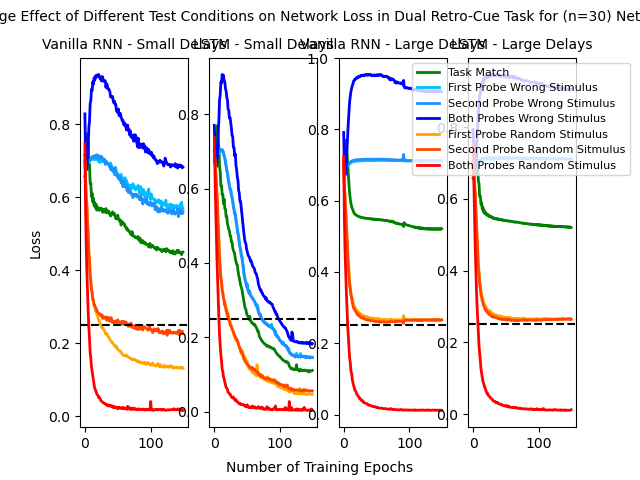

In [56]:
fig, ax = plt.subplots(1,4)

# plot losses
fig.suptitle("Average Effect of Different Test Conditions on Network Loss in Dual Retro-Cue Task for (n=" + str(num_networks) + ") Networks", fontsize=10)

# Individual losses for each sample type (where the same stimulus is cued each round)
ax[0].set_title("Vanilla RNN - Small Delays", fontsize=10)
ax[0].plot(match_mean_losses_small_rnncell, color='green', label="Task Match", linewidth=2)
ax[0].plot(first_probe_wrong_stimuli_mean_losses_small_rnncell, color='deepskyblue', label="First Probe Wrong Stimulus", linewidth=2)
ax[0].plot(second_probe_wrong_stimuli_mean_losses_small_rnncell, color='dodgerblue', label="Second Probe Wrong Stimulus", linewidth=2)
ax[0].plot(both_probes_wrong_stimuli_mean_losses_small_rnncell, color='blue', label="Both Probes Wrong Stimulus", linewidth=2)
ax[0].plot(first_probe_random_stimuli_mean_losses_small_rnncell, color='orange', label="First Probe Random Stimulus", linewidth=2)
ax[0].plot(second_probe_random_stimuli_mean_losses_small_rnncell, color='orangered', label="Second Probe Random Sitmulus", linewidth=2)
ax[0].plot(both_probes_random_stimuli_mean_losses_small_rnncell, color='red', label="Both Probes Random Stimulus", linewidth=2)

# Individual losses for each sample type (where a different stimulus is cued each round)
ax[1].set_title("LSTM - Small Delays", fontsize=10)
ax[1].plot(match_mean_losses_small_lstmcell, color='green', label="Task Match", linewidth=2)
ax[1].plot(first_probe_wrong_stimuli_mean_losses_small_lstmcell, color='deepskyblue', label="First Probe Wrong Stimulus", linewidth=2)
ax[1].plot(second_probe_wrong_stimuli_mean_losses_small_lstmcell, color='dodgerblue', label="Second Probe Wrong Stimulus", linewidth=2)
ax[1].plot(both_probes_wrong_stimuli_mean_losses_small_lstmcell, color='blue', label="Both Probes Wrong Stimulus", linewidth=2)
ax[1].plot(first_probe_random_stimuli_mean_losses_small_lstmcell, color='orange', label="First Probe Random Stimulus", linewidth=2)
ax[1].plot(second_probe_random_stimuli_mean_losses_small_lstmcell, color='orangered', label="Second Probe Random Sitmulus", linewidth=2)
ax[1].plot(both_probes_random_stimuli_mean_losses_small_lstmcell, color='red', label="Both Probes Random Stimulus", linewidth=2)

# Individual losses for each sample type (where the same stimulus is cued each round)
ax[2].set_title("Vanilla RNN - Large Delays", fontsize=10)
ax[2].plot(match_mean_losses_large_rnncell, color='green', label="Task Match", linewidth=2)
ax[2].plot(first_probe_wrong_stimuli_mean_losses_large_rnncell, color='deepskyblue', label="First Probe Wrong Stimulus", linewidth=2)
ax[2].plot(second_probe_wrong_stimuli_mean_losses_large_rnncell, color='dodgerblue', label="Second Probe Wrong Stimulus", linewidth=2)
ax[2].plot(both_probes_wrong_stimuli_mean_losses_large_rnncell, color='blue', label="Both Probes Wrong Stimulus", linewidth=2)
ax[2].plot(first_probe_random_stimuli_mean_losses_large_rnncell, color='orange', label="First Probe Random Stimulus", linewidth=2)
ax[2].plot(second_probe_random_stimuli_mean_losses_large_rnncell, color='orangered', label="Second Probe Random Sitmulus", linewidth=2)
ax[2].plot(both_probes_random_stimuli_mean_losses_large_rnncell, color='red', label="Both Probes Random Stimulus", linewidth=2)

# Individual losses for each sample type (where a different stimulus is cued each round)
ax[3].set_title("LSTM - Large Delays", fontsize=10)
ax[3].plot(match_mean_losses_large_lstmcell, color='green', label="Task Match", linewidth=2)
ax[3].plot(first_probe_wrong_stimuli_mean_losses_large_lstmcell, color='deepskyblue', label="First Probe Wrong Stimulus", linewidth=2)
ax[3].plot(second_probe_wrong_stimuli_mean_losses_large_lstmcell, color='dodgerblue', label="Second Probe Wrong Stimulus", linewidth=2)
ax[3].plot(both_probes_wrong_stimuli_mean_losses_large_lstmcell, color='blue', label="Both Probes Wrong Stimulus", linewidth=2)
ax[3].plot(first_probe_random_stimuli_mean_losses_large_lstmcell, color='orange', label="First Probe Random Stimulus", linewidth=2)
ax[3].plot(second_probe_random_stimuli_mean_losses_large_lstmcell, color='orangered', label="Second Probe Random Sitmulus", linewidth=2)
ax[3].plot(both_probes_random_stimuli_mean_losses_large_lstmcell, color='red', label="Both Probes Random Stimulus", linewidth=2)

# Threshold line
ax[0].axhline(threshold, linestyle='dashed', color='black')
ax[1].axhline(threshold, linestyle='dashed', color='black')
ax[2].axhline(threshold, linestyle='dashed', color='black')
ax[3].axhline(threshold, linestyle='dashed', color='black')

# legend and show plot
ax[3].legend(fontsize=8, bbox_to_anchor=(1.55, 1), loc="upper right") # by default, the legend ignores all elements without a label attribute set.

fig.supxlabel('Number of Training Epochs', fontsize=10) # x label
ax[0].set_ylabel('Loss', fontsize=10) # y label

plt.show()

#### *Graph on Summaries of Each Trial Type for Memory Augmented LSTMs on the Dual Retro-Cue Task (Small Delays)*

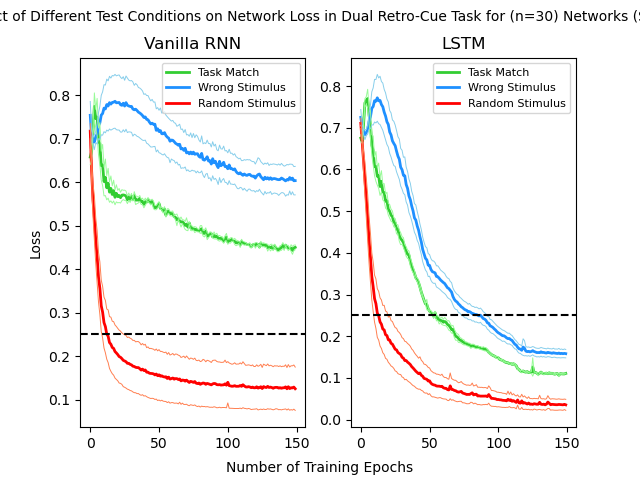

In [53]:
### Specific Plots for WMEM DRC Task ###

### RNNCell ###

mean_sample_loss_small_rnncell_drc_dict, sample_losses_small_rnncell_drc_dict = partition_sample_losses("dual_retro_cue", mean_sample_loss_small_rnncell_drc, sample_losses_small_rnncell_drc)

task0_mean_loss = mean_sample_loss_small_rnncell_drc_dict[0]
task1_mean_loss = mean_sample_loss_small_rnncell_drc_dict[1]
task2_mean_loss = mean_sample_loss_small_rnncell_drc_dict[2]
task3_mean_loss = mean_sample_loss_small_rnncell_drc_dict[3]
task4_mean_loss = mean_sample_loss_small_rnncell_drc_dict[4]
task5_mean_loss = mean_sample_loss_small_rnncell_drc_dict[5]
task6_mean_loss = mean_sample_loss_small_rnncell_drc_dict[6]
task7_mean_loss = mean_sample_loss_small_rnncell_drc_dict[7]
task8_mean_loss = mean_sample_loss_small_rnncell_drc_dict[8]
task9_mean_loss = mean_sample_loss_small_rnncell_drc_dict[9]
task10_mean_loss = mean_sample_loss_small_rnncell_drc_dict[10]
task11_mean_loss = mean_sample_loss_small_rnncell_drc_dict[11]
task12_mean_loss = mean_sample_loss_small_rnncell_drc_dict[12]
task13_mean_loss = mean_sample_loss_small_rnncell_drc_dict[13]
task14_mean_loss = mean_sample_loss_small_rnncell_drc_dict[14]
task15_mean_loss = mean_sample_loss_small_rnncell_drc_dict[15]
task16_mean_loss = mean_sample_loss_small_rnncell_drc_dict[16]
task17_mean_loss = mean_sample_loss_small_rnncell_drc_dict[17]
task18_mean_loss = mean_sample_loss_small_rnncell_drc_dict[18]
task19_mean_loss = mean_sample_loss_small_rnncell_drc_dict[19]
task20_mean_loss = mean_sample_loss_small_rnncell_drc_dict[20]
task21_mean_loss = mean_sample_loss_small_rnncell_drc_dict[21]
task22_mean_loss = mean_sample_loss_small_rnncell_drc_dict[22]
task23_mean_loss = mean_sample_loss_small_rnncell_drc_dict[23]
task24_mean_loss = mean_sample_loss_small_rnncell_drc_dict[24]
task25_mean_loss = mean_sample_loss_small_rnncell_drc_dict[25]
task26_mean_loss = mean_sample_loss_small_rnncell_drc_dict[26]
task27_mean_loss = mean_sample_loss_small_rnncell_drc_dict[27]

task0_sample_losses = sample_losses_small_rnncell_drc_dict[0]
task1_sample_losses = sample_losses_small_rnncell_drc_dict[1]
task2_sample_losses = sample_losses_small_rnncell_drc_dict[2]
task3_sample_losses = sample_losses_small_rnncell_drc_dict[3]
task4_sample_losses = sample_losses_small_rnncell_drc_dict[4]
task5_sample_losses = sample_losses_small_rnncell_drc_dict[5]
task6_sample_losses = sample_losses_small_rnncell_drc_dict[6]
task7_sample_losses = sample_losses_small_rnncell_drc_dict[7]
task8_sample_losses = sample_losses_small_rnncell_drc_dict[8]
task9_sample_losses = sample_losses_small_rnncell_drc_dict[9]
task10_sample_losses = sample_losses_small_rnncell_drc_dict[10]
task11_sample_losses = sample_losses_small_rnncell_drc_dict[11]
task12_sample_losses = sample_losses_small_rnncell_drc_dict[12]
task13_sample_losses = sample_losses_small_rnncell_drc_dict[13]
task14_sample_losses = sample_losses_small_rnncell_drc_dict[14]
task15_sample_losses = sample_losses_small_rnncell_drc_dict[15]
task16_sample_losses = sample_losses_small_rnncell_drc_dict[16]
task17_sample_losses = sample_losses_small_rnncell_drc_dict[17]
task18_sample_losses = sample_losses_small_rnncell_drc_dict[18]
task19_sample_losses = sample_losses_small_rnncell_drc_dict[19]
task20_sample_losses = sample_losses_small_rnncell_drc_dict[20]
task21_sample_losses = sample_losses_small_rnncell_drc_dict[21]
task22_sample_losses = sample_losses_small_rnncell_drc_dict[22]
task23_sample_losses = sample_losses_small_rnncell_drc_dict[23]
task24_sample_losses = sample_losses_small_rnncell_drc_dict[24]
task25_sample_losses = sample_losses_small_rnncell_drc_dict[25]
task26_sample_losses = sample_losses_small_rnncell_drc_dict[26]
task27_sample_losses = sample_losses_small_rnncell_drc_dict[27]

# testing different cases when the same cues are made before the probes (Vanilla Working Memory Case)
match_losses_same_cues = [task1_mean_loss, task3_mean_loss]
first_probe_wrong_stimuli_losses_same_cues = [task12_mean_loss, task14_mean_loss]
first_probe_random_stimuli_losses_same_cues = [task13_mean_loss, task15_mean_loss]
second_probe_wrong_stimuli_losses_same_cues = [task16_mean_loss, task18_mean_loss]
second_probe_random_stimuli_losses_same_cues = [task17_mean_loss, task19_mean_loss]
both_probes_wrong_stimuli_losses_same_cues = [task24_mean_loss, task26_mean_loss]
both_probes_random_stimuli_losses_same_cues = [task25_mean_loss, task27_mean_loss]


# testing different cases when a different second cue is made before the second probe (ASWM case)
match_losses_different_cues = [task0_mean_loss, task2_mean_loss]
first_probe_wrong_stimuli_losses_different_cues = [task4_mean_loss, task6_mean_loss]
first_probe_random_stimuli_losses_different_cues = [task5_mean_loss, task7_mean_loss]
second_probe_wrong_stimuli_losses_different_cues = [task8_mean_loss, task10_mean_loss]
second_probe_random_stimuli_losses_different_cues = [task9_mean_loss, task11_mean_loss]
both_probes_wrong_stimuli_losses_different_cues = [task20_mean_loss, task22_mean_loss]
both_probes_random_stimuli_losses_different_cues = [task21_mean_loss, task23_mean_loss]


# get the mean losses for each of these 3 larger categories

match_losses_small_rnncell = match_losses_same_cues + match_losses_different_cues
wrong_stimuli_losses_small_rnncell = first_probe_wrong_stimuli_losses_same_cues + second_probe_wrong_stimuli_losses_same_cues + both_probes_wrong_stimuli_losses_same_cues + first_probe_wrong_stimuli_losses_different_cues + second_probe_wrong_stimuli_losses_different_cues + both_probes_wrong_stimuli_losses_different_cues
random_stimuli_losses_small_rnncell = first_probe_random_stimuli_losses_same_cues + second_probe_random_stimuli_losses_same_cues + both_probes_random_stimuli_losses_same_cues + first_probe_random_stimuli_losses_different_cues + second_probe_random_stimuli_losses_different_cues + both_probes_random_stimuli_losses_different_cues

match_mean_losses_small_rnncell = np.mean(match_losses_small_rnncell, axis=0)
wrong_stimuli_mean_losses_small_rnncell = np.mean(wrong_stimuli_losses_small_rnncell, axis=0)
random_stimuli_mean_losses_small_rnncell = np.mean(random_stimuli_losses_small_rnncell, axis=0)

### Specific Plots for WMEM DRC Task ###

### LSTMCell ###

mean_sample_loss_small_lstmcell_drc_dict, sample_losses_small_lstmcell_drc_dict = partition_sample_losses("dual_retro_cue", mean_sample_loss_small_lstmcell_drc, sample_losses_small_lstmcell_drc)

task0_mean_loss = mean_sample_loss_small_lstmcell_drc_dict[0]
task1_mean_loss = mean_sample_loss_small_lstmcell_drc_dict[1]
task2_mean_loss = mean_sample_loss_small_lstmcell_drc_dict[2]
task3_mean_loss = mean_sample_loss_small_lstmcell_drc_dict[3]
task4_mean_loss = mean_sample_loss_small_lstmcell_drc_dict[4]
task5_mean_loss = mean_sample_loss_small_lstmcell_drc_dict[5]
task6_mean_loss = mean_sample_loss_small_lstmcell_drc_dict[6]
task7_mean_loss = mean_sample_loss_small_lstmcell_drc_dict[7]
task8_mean_loss = mean_sample_loss_small_lstmcell_drc_dict[8]
task9_mean_loss = mean_sample_loss_small_lstmcell_drc_dict[9]
task10_mean_loss = mean_sample_loss_small_lstmcell_drc_dict[10]
task11_mean_loss = mean_sample_loss_small_lstmcell_drc_dict[11]
task12_mean_loss = mean_sample_loss_small_lstmcell_drc_dict[12]
task13_mean_loss = mean_sample_loss_small_lstmcell_drc_dict[13]
task14_mean_loss = mean_sample_loss_small_lstmcell_drc_dict[14]
task15_mean_loss = mean_sample_loss_small_lstmcell_drc_dict[15]
task16_mean_loss = mean_sample_loss_small_lstmcell_drc_dict[16]
task17_mean_loss = mean_sample_loss_small_lstmcell_drc_dict[17]
task18_mean_loss = mean_sample_loss_small_lstmcell_drc_dict[18]
task19_mean_loss = mean_sample_loss_small_lstmcell_drc_dict[19]
task20_mean_loss = mean_sample_loss_small_lstmcell_drc_dict[20]
task21_mean_loss = mean_sample_loss_small_lstmcell_drc_dict[21]
task22_mean_loss = mean_sample_loss_small_lstmcell_drc_dict[22]
task23_mean_loss = mean_sample_loss_small_lstmcell_drc_dict[23]
task24_mean_loss = mean_sample_loss_small_lstmcell_drc_dict[24]
task25_mean_loss = mean_sample_loss_small_lstmcell_drc_dict[25]
task26_mean_loss = mean_sample_loss_small_lstmcell_drc_dict[26]
task27_mean_loss = mean_sample_loss_small_lstmcell_drc_dict[27]

task0_sample_losses = sample_losses_small_lstmcell_drc_dict[0]
task1_sample_losses = sample_losses_small_lstmcell_drc_dict[1]
task2_sample_losses = sample_losses_small_lstmcell_drc_dict[2]
task3_sample_losses = sample_losses_small_lstmcell_drc_dict[3]
task4_sample_losses = sample_losses_small_lstmcell_drc_dict[4]
task5_sample_losses = sample_losses_small_lstmcell_drc_dict[5]
task6_sample_losses = sample_losses_small_lstmcell_drc_dict[6]
task7_sample_losses = sample_losses_small_lstmcell_drc_dict[7]
task8_sample_losses = sample_losses_small_lstmcell_drc_dict[8]
task9_sample_losses = sample_losses_small_lstmcell_drc_dict[9]
task10_sample_losses = sample_losses_small_lstmcell_drc_dict[10]
task11_sample_losses = sample_losses_small_lstmcell_drc_dict[11]
task12_sample_losses = sample_losses_small_lstmcell_drc_dict[12]
task13_sample_losses = sample_losses_small_lstmcell_drc_dict[13]
task14_sample_losses = sample_losses_small_lstmcell_drc_dict[14]
task15_sample_losses = sample_losses_small_lstmcell_drc_dict[15]
task16_sample_losses = sample_losses_small_lstmcell_drc_dict[16]
task17_sample_losses = sample_losses_small_lstmcell_drc_dict[17]
task18_sample_losses = sample_losses_small_lstmcell_drc_dict[18]
task19_sample_losses = sample_losses_small_lstmcell_drc_dict[19]
task20_sample_losses = sample_losses_small_lstmcell_drc_dict[20]
task21_sample_losses = sample_losses_small_lstmcell_drc_dict[21]
task22_sample_losses = sample_losses_small_lstmcell_drc_dict[22]
task23_sample_losses = sample_losses_small_lstmcell_drc_dict[23]
task24_sample_losses = sample_losses_small_lstmcell_drc_dict[24]
task25_sample_losses = sample_losses_small_lstmcell_drc_dict[25]
task26_sample_losses = sample_losses_small_lstmcell_drc_dict[26]
task27_sample_losses = sample_losses_small_lstmcell_drc_dict[27]

# testing different cases when the same cues are made before the probes (Vanilla Working Memory Case)
match_losses_same_cues = [task1_mean_loss, task3_mean_loss]
first_probe_wrong_stimuli_losses_same_cues = [task12_mean_loss, task14_mean_loss]
first_probe_random_stimuli_losses_same_cues = [task13_mean_loss, task15_mean_loss]
second_probe_wrong_stimuli_losses_same_cues = [task16_mean_loss, task18_mean_loss]
second_probe_random_stimuli_losses_same_cues = [task17_mean_loss, task19_mean_loss]
both_probes_wrong_stimuli_losses_same_cues = [task24_mean_loss, task26_mean_loss]
both_probes_random_stimuli_losses_same_cues = [task25_mean_loss, task27_mean_loss]


# testing different cases when a different second cue is made before the second probe (ASWM case)
match_losses_different_cues = [task0_mean_loss, task2_mean_loss]
first_probe_wrong_stimuli_losses_different_cues = [task4_mean_loss, task6_mean_loss]
first_probe_random_stimuli_losses_different_cues = [task5_mean_loss, task7_mean_loss]
second_probe_wrong_stimuli_losses_different_cues = [task8_mean_loss, task10_mean_loss]
second_probe_random_stimuli_losses_different_cues = [task9_mean_loss, task11_mean_loss]
both_probes_wrong_stimuli_losses_different_cues = [task20_mean_loss, task22_mean_loss]
both_probes_random_stimuli_losses_different_cues = [task21_mean_loss, task23_mean_loss]

# get the mean losses for each of these 3 larger categories

match_losses_small_lstmcell = match_losses_same_cues + match_losses_different_cues
wrong_stimuli_losses_small_lstmcell = first_probe_wrong_stimuli_losses_same_cues + second_probe_wrong_stimuli_losses_same_cues + both_probes_wrong_stimuli_losses_same_cues + first_probe_wrong_stimuli_losses_different_cues + second_probe_wrong_stimuli_losses_different_cues + both_probes_wrong_stimuli_losses_different_cues
random_stimuli_losses_small_lstmcell = first_probe_random_stimuli_losses_same_cues + second_probe_random_stimuli_losses_same_cues + both_probes_random_stimuli_losses_same_cues + first_probe_random_stimuli_losses_different_cues + second_probe_random_stimuli_losses_different_cues + both_probes_random_stimuli_losses_different_cues


match_mean_losses_small_lstmcell = np.mean(match_losses_small_lstmcell, axis=0)
wrong_stimuli_mean_losses_small_lstmcell = np.mean(wrong_stimuli_losses_small_lstmcell, axis=0)
random_stimuli_mean_losses_small_lstmcell = np.mean(random_stimuli_losses_small_lstmcell, axis=0)


fig, ax = plt.subplots(1,2)

# plot losses
fig.suptitle("Average Effect of Different Test Conditions on Network Loss in Dual Retro-Cue Task for (n=" + str(num_networks) + ") Networks (Small Delays)", fontsize=10)


# Individual losses for each sample type (where the same stimulus is cued each round)
ax[0].set_title("Vanilla RNN")
ax[0].plot(match_mean_losses_small_rnncell, color='limegreen', label="Task Match", linewidth=2)
ax[0].plot(wrong_stimuli_mean_losses_small_rnncell, color='dodgerblue', label="Wrong Stimulus", linewidth=2)
ax[0].plot(random_stimuli_mean_losses_small_rnncell, color='red', label="Random Stimulus", linewidth=2)

## Standard deviations
ax[0].plot((match_mean_losses_small_rnncell + 2*stats.sem(match_losses_small_rnncell, axis=0, ddof=0)), color='palegreen', linewidth=0.7)
ax[0].plot((match_mean_losses_small_rnncell - 2*stats.sem(match_losses_small_rnncell, axis=0, ddof=0)), color='palegreen', linewidth=0.7)

ax[0].plot((wrong_stimuli_mean_losses_small_rnncell + 2*stats.sem(wrong_stimuli_losses_small_rnncell, axis=0, ddof=0)), color='skyblue', linewidth=0.7)
ax[0].plot((wrong_stimuli_mean_losses_small_rnncell - 2*stats.sem(wrong_stimuli_losses_small_rnncell, axis=0, ddof=0)), color='skyblue', linewidth=0.7)

ax[0].plot((random_stimuli_mean_losses_small_rnncell + 2*stats.sem(random_stimuli_losses_small_rnncell, axis=0, ddof=0)), color='coral', linewidth=0.7)
ax[0].plot((random_stimuli_mean_losses_small_rnncell - 2*stats.sem(random_stimuli_losses_small_rnncell, axis=0, ddof=0)), color='coral', linewidth=0.7)

# Individual losses for each sample type (where a different stimulus is cued each round)
ax[1].set_title("LSTM")
ax[1].plot(match_mean_losses_small_lstmcell, color='limegreen', label="Task Match", linewidth=2)
ax[1].plot(wrong_stimuli_mean_losses_small_lstmcell, color='dodgerblue', label="Wrong Stimulus", linewidth=2)
ax[1].plot(random_stimuli_mean_losses_small_lstmcell, color='red', label="Random Stimulus", linewidth=2)

## Standard deviations
ax[1].plot((match_mean_losses_small_lstmcell + 2*stats.sem(match_losses_small_lstmcell, axis=0, ddof=0)), color='palegreen', linewidth=0.7)
ax[1].plot((match_mean_losses_small_lstmcell - 2*stats.sem(match_losses_small_lstmcell, axis=0, ddof=0)), color='palegreen', linewidth=0.7)      
           
ax[1].plot((wrong_stimuli_mean_losses_small_lstmcell + 2*stats.sem(wrong_stimuli_losses_small_lstmcell, axis=0, ddof=0)), color='skyblue', linewidth=0.7)
ax[1].plot((wrong_stimuli_mean_losses_small_lstmcell - 2*stats.sem(wrong_stimuli_losses_small_lstmcell, axis=0, ddof=0)), color='skyblue', linewidth=0.7)

ax[1].plot((random_stimuli_mean_losses_small_lstmcell + 2*stats.sem(random_stimuli_losses_small_lstmcell, axis=0, ddof=0)), color='coral', linewidth=0.7)
ax[1].plot((random_stimuli_mean_losses_small_lstmcell - 2*stats.sem(random_stimuli_losses_small_lstmcell, axis=0, ddof=0)), color='coral', linewidth=0.7)

# Threshold line
ax[0].axhline(threshold, linestyle='dashed', color='black')
ax[1].axhline(threshold, linestyle='dashed', color='black')

# legend and show plot
ax[0].legend(fontsize=8, loc="upper right") # by default, the legend ignores all elements without a label attribute set.
ax[1].legend(fontsize=8, loc="upper right") # by default, the legend ignores all elements without a label attribute set.

fig.supxlabel('Number of Training Epochs', fontsize=10) # x label
ax[0].set_ylabel('Loss', fontsize=10) # y label

plt.show()

#### *Graph on Summaries of Each Trial Type for Memory Augmented LSTMs on the Dual Retro-Cue Task (Large Delays)*

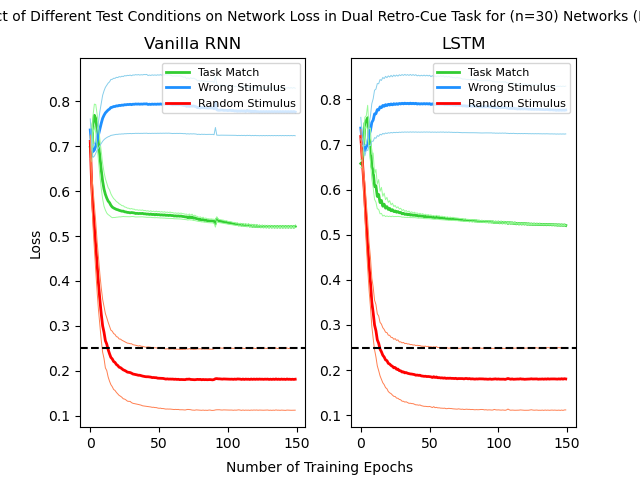

In [54]:
### Specific Plots for WMEM DRC Task ###

### RNNCell ###

mean_sample_loss_large_rnncell_drc_dict, sample_losses_large_rnncell_drc_dict = partition_sample_losses("dual_retro_cue", mean_sample_loss_large_rnncell_drc, sample_losses_large_rnncell_drc)

task0_mean_loss = mean_sample_loss_large_rnncell_drc_dict[0]
task1_mean_loss = mean_sample_loss_large_rnncell_drc_dict[1]
task2_mean_loss = mean_sample_loss_large_rnncell_drc_dict[2]
task3_mean_loss = mean_sample_loss_large_rnncell_drc_dict[3]
task4_mean_loss = mean_sample_loss_large_rnncell_drc_dict[4]
task5_mean_loss = mean_sample_loss_large_rnncell_drc_dict[5]
task6_mean_loss = mean_sample_loss_large_rnncell_drc_dict[6]
task7_mean_loss = mean_sample_loss_large_rnncell_drc_dict[7]
task8_mean_loss = mean_sample_loss_large_rnncell_drc_dict[8]
task9_mean_loss = mean_sample_loss_large_rnncell_drc_dict[9]
task10_mean_loss = mean_sample_loss_large_rnncell_drc_dict[10]
task11_mean_loss = mean_sample_loss_large_rnncell_drc_dict[11]
task12_mean_loss = mean_sample_loss_large_rnncell_drc_dict[12]
task13_mean_loss = mean_sample_loss_large_rnncell_drc_dict[13]
task14_mean_loss = mean_sample_loss_large_rnncell_drc_dict[14]
task15_mean_loss = mean_sample_loss_large_rnncell_drc_dict[15]
task16_mean_loss = mean_sample_loss_large_rnncell_drc_dict[16]
task17_mean_loss = mean_sample_loss_large_rnncell_drc_dict[17]
task18_mean_loss = mean_sample_loss_large_rnncell_drc_dict[18]
task19_mean_loss = mean_sample_loss_large_rnncell_drc_dict[19]
task20_mean_loss = mean_sample_loss_large_rnncell_drc_dict[20]
task21_mean_loss = mean_sample_loss_large_rnncell_drc_dict[21]
task22_mean_loss = mean_sample_loss_large_rnncell_drc_dict[22]
task23_mean_loss = mean_sample_loss_large_rnncell_drc_dict[23]
task24_mean_loss = mean_sample_loss_large_rnncell_drc_dict[24]
task25_mean_loss = mean_sample_loss_large_rnncell_drc_dict[25]
task26_mean_loss = mean_sample_loss_large_rnncell_drc_dict[26]
task27_mean_loss = mean_sample_loss_large_rnncell_drc_dict[27]

task0_sample_losses = sample_losses_large_rnncell_drc_dict[0]
task1_sample_losses = sample_losses_large_rnncell_drc_dict[1]
task2_sample_losses = sample_losses_large_rnncell_drc_dict[2]
task3_sample_losses = sample_losses_large_rnncell_drc_dict[3]
task4_sample_losses = sample_losses_large_rnncell_drc_dict[4]
task5_sample_losses = sample_losses_large_rnncell_drc_dict[5]
task6_sample_losses = sample_losses_large_rnncell_drc_dict[6]
task7_sample_losses = sample_losses_large_rnncell_drc_dict[7]
task8_sample_losses = sample_losses_large_rnncell_drc_dict[8]
task9_sample_losses = sample_losses_large_rnncell_drc_dict[9]
task10_sample_losses = sample_losses_large_rnncell_drc_dict[10]
task11_sample_losses = sample_losses_large_rnncell_drc_dict[11]
task12_sample_losses = sample_losses_large_rnncell_drc_dict[12]
task13_sample_losses = sample_losses_large_rnncell_drc_dict[13]
task14_sample_losses = sample_losses_large_rnncell_drc_dict[14]
task15_sample_losses = sample_losses_large_rnncell_drc_dict[15]
task16_sample_losses = sample_losses_large_rnncell_drc_dict[16]
task17_sample_losses = sample_losses_large_rnncell_drc_dict[17]
task18_sample_losses = sample_losses_large_rnncell_drc_dict[18]
task19_sample_losses = sample_losses_large_rnncell_drc_dict[19]
task20_sample_losses = sample_losses_large_rnncell_drc_dict[20]
task21_sample_losses = sample_losses_large_rnncell_drc_dict[21]
task22_sample_losses = sample_losses_large_rnncell_drc_dict[22]
task23_sample_losses = sample_losses_large_rnncell_drc_dict[23]
task24_sample_losses = sample_losses_large_rnncell_drc_dict[24]
task25_sample_losses = sample_losses_large_rnncell_drc_dict[25]
task26_sample_losses = sample_losses_large_rnncell_drc_dict[26]
task27_sample_losses = sample_losses_large_rnncell_drc_dict[27]

# testing different cases when the same cues are made before the probes (Vanilla Working Memory Case)
match_losses_same_cues = [task1_mean_loss, task3_mean_loss]
first_probe_wrong_stimuli_losses_same_cues = [task12_mean_loss, task14_mean_loss]
first_probe_random_stimuli_losses_same_cues = [task13_mean_loss, task15_mean_loss]
second_probe_wrong_stimuli_losses_same_cues = [task16_mean_loss, task18_mean_loss]
second_probe_random_stimuli_losses_same_cues = [task17_mean_loss, task19_mean_loss]
both_probes_wrong_stimuli_losses_same_cues = [task24_mean_loss, task26_mean_loss]
both_probes_random_stimuli_losses_same_cues = [task25_mean_loss, task27_mean_loss]


# testing different cases when a different second cue is made before the second probe (ASWM case)
match_losses_different_cues = [task0_mean_loss, task2_mean_loss]
first_probe_wrong_stimuli_losses_different_cues = [task4_mean_loss, task6_mean_loss]
first_probe_random_stimuli_losses_different_cues = [task5_mean_loss, task7_mean_loss]
second_probe_wrong_stimuli_losses_different_cues = [task8_mean_loss, task10_mean_loss]
second_probe_random_stimuli_losses_different_cues = [task9_mean_loss, task11_mean_loss]
both_probes_wrong_stimuli_losses_different_cues = [task20_mean_loss, task22_mean_loss]
both_probes_random_stimuli_losses_different_cues = [task21_mean_loss, task23_mean_loss]


# get the mean losses for each of these 3 larger categories

match_losses_large_rnncell = match_losses_same_cues + match_losses_different_cues
wrong_stimuli_losses_large_rnncell = first_probe_wrong_stimuli_losses_same_cues + second_probe_wrong_stimuli_losses_same_cues + both_probes_wrong_stimuli_losses_same_cues + first_probe_wrong_stimuli_losses_different_cues + second_probe_wrong_stimuli_losses_different_cues + both_probes_wrong_stimuli_losses_different_cues
random_stimuli_losses_large_rnncell = first_probe_random_stimuli_losses_same_cues + second_probe_random_stimuli_losses_same_cues + both_probes_random_stimuli_losses_same_cues + first_probe_random_stimuli_losses_different_cues + second_probe_random_stimuli_losses_different_cues + both_probes_random_stimuli_losses_different_cues

match_mean_losses_large_rnncell = np.mean(match_losses_large_rnncell, axis=0)
wrong_stimuli_mean_losses_large_rnncell = np.mean(wrong_stimuli_losses_large_rnncell, axis=0)
random_stimuli_mean_losses_large_rnncell = np.mean(random_stimuli_losses_large_rnncell, axis=0)

### Specific Plots for WMEM DRC Task ###

### LSTMCell ###

mean_sample_loss_large_lstmcell_drc_dict, sample_losses_large_lstmcell_drc_dict = partition_sample_losses("dual_retro_cue", mean_sample_loss_large_lstmcell_drc, sample_losses_large_lstmcell_drc)

task0_mean_loss = mean_sample_loss_large_lstmcell_drc_dict[0]
task1_mean_loss = mean_sample_loss_large_lstmcell_drc_dict[1]
task2_mean_loss = mean_sample_loss_large_lstmcell_drc_dict[2]
task3_mean_loss = mean_sample_loss_large_lstmcell_drc_dict[3]
task4_mean_loss = mean_sample_loss_large_lstmcell_drc_dict[4]
task5_mean_loss = mean_sample_loss_large_lstmcell_drc_dict[5]
task6_mean_loss = mean_sample_loss_large_lstmcell_drc_dict[6]
task7_mean_loss = mean_sample_loss_large_lstmcell_drc_dict[7]
task8_mean_loss = mean_sample_loss_large_lstmcell_drc_dict[8]
task9_mean_loss = mean_sample_loss_large_lstmcell_drc_dict[9]
task10_mean_loss = mean_sample_loss_large_lstmcell_drc_dict[10]
task11_mean_loss = mean_sample_loss_large_lstmcell_drc_dict[11]
task12_mean_loss = mean_sample_loss_large_lstmcell_drc_dict[12]
task13_mean_loss = mean_sample_loss_large_lstmcell_drc_dict[13]
task14_mean_loss = mean_sample_loss_large_lstmcell_drc_dict[14]
task15_mean_loss = mean_sample_loss_large_lstmcell_drc_dict[15]
task16_mean_loss = mean_sample_loss_large_lstmcell_drc_dict[16]
task17_mean_loss = mean_sample_loss_large_lstmcell_drc_dict[17]
task18_mean_loss = mean_sample_loss_large_lstmcell_drc_dict[18]
task19_mean_loss = mean_sample_loss_large_lstmcell_drc_dict[19]
task20_mean_loss = mean_sample_loss_large_lstmcell_drc_dict[20]
task21_mean_loss = mean_sample_loss_large_lstmcell_drc_dict[21]
task22_mean_loss = mean_sample_loss_large_lstmcell_drc_dict[22]
task23_mean_loss = mean_sample_loss_large_lstmcell_drc_dict[23]
task24_mean_loss = mean_sample_loss_large_lstmcell_drc_dict[24]
task25_mean_loss = mean_sample_loss_large_lstmcell_drc_dict[25]
task26_mean_loss = mean_sample_loss_large_lstmcell_drc_dict[26]
task27_mean_loss = mean_sample_loss_large_lstmcell_drc_dict[27]

task0_sample_losses = sample_losses_large_lstmcell_drc_dict[0]
task1_sample_losses = sample_losses_large_lstmcell_drc_dict[1]
task2_sample_losses = sample_losses_large_lstmcell_drc_dict[2]
task3_sample_losses = sample_losses_large_lstmcell_drc_dict[3]
task4_sample_losses = sample_losses_large_lstmcell_drc_dict[4]
task5_sample_losses = sample_losses_large_lstmcell_drc_dict[5]
task6_sample_losses = sample_losses_large_lstmcell_drc_dict[6]
task7_sample_losses = sample_losses_large_lstmcell_drc_dict[7]
task8_sample_losses = sample_losses_large_lstmcell_drc_dict[8]
task9_sample_losses = sample_losses_large_lstmcell_drc_dict[9]
task10_sample_losses = sample_losses_large_lstmcell_drc_dict[10]
task11_sample_losses = sample_losses_large_lstmcell_drc_dict[11]
task12_sample_losses = sample_losses_large_lstmcell_drc_dict[12]
task13_sample_losses = sample_losses_large_lstmcell_drc_dict[13]
task14_sample_losses = sample_losses_large_lstmcell_drc_dict[14]
task15_sample_losses = sample_losses_large_lstmcell_drc_dict[15]
task16_sample_losses = sample_losses_large_lstmcell_drc_dict[16]
task17_sample_losses = sample_losses_large_lstmcell_drc_dict[17]
task18_sample_losses = sample_losses_large_lstmcell_drc_dict[18]
task19_sample_losses = sample_losses_large_lstmcell_drc_dict[19]
task20_sample_losses = sample_losses_large_lstmcell_drc_dict[20]
task21_sample_losses = sample_losses_large_lstmcell_drc_dict[21]
task22_sample_losses = sample_losses_large_lstmcell_drc_dict[22]
task23_sample_losses = sample_losses_large_lstmcell_drc_dict[23]
task24_sample_losses = sample_losses_large_lstmcell_drc_dict[24]
task25_sample_losses = sample_losses_large_lstmcell_drc_dict[25]
task26_sample_losses = sample_losses_large_lstmcell_drc_dict[26]
task27_sample_losses = sample_losses_large_lstmcell_drc_dict[27]

# testing different cases when the same cues are made before the probes (Vanilla Working Memory Case)
match_losses_same_cues = [task1_mean_loss, task3_mean_loss]
first_probe_wrong_stimuli_losses_same_cues = [task12_mean_loss, task14_mean_loss]
first_probe_random_stimuli_losses_same_cues = [task13_mean_loss, task15_mean_loss]
second_probe_wrong_stimuli_losses_same_cues = [task16_mean_loss, task18_mean_loss]
second_probe_random_stimuli_losses_same_cues = [task17_mean_loss, task19_mean_loss]
both_probes_wrong_stimuli_losses_same_cues = [task24_mean_loss, task26_mean_loss]
both_probes_random_stimuli_losses_same_cues = [task25_mean_loss, task27_mean_loss]


# testing different cases when a different second cue is made before the second probe (ASWM case)
match_losses_different_cues = [task0_mean_loss, task2_mean_loss]
first_probe_wrong_stimuli_losses_different_cues = [task4_mean_loss, task6_mean_loss]
first_probe_random_stimuli_losses_different_cues = [task5_mean_loss, task7_mean_loss]
second_probe_wrong_stimuli_losses_different_cues = [task8_mean_loss, task10_mean_loss]
second_probe_random_stimuli_losses_different_cues = [task9_mean_loss, task11_mean_loss]
both_probes_wrong_stimuli_losses_different_cues = [task20_mean_loss, task22_mean_loss]
both_probes_random_stimuli_losses_different_cues = [task21_mean_loss, task23_mean_loss]

# get the mean losses for each of these 3 larger categories

match_losses_large_lstmcell = match_losses_same_cues + match_losses_different_cues
wrong_stimuli_losses_large_lstmcell = first_probe_wrong_stimuli_losses_same_cues + second_probe_wrong_stimuli_losses_same_cues + both_probes_wrong_stimuli_losses_same_cues + first_probe_wrong_stimuli_losses_different_cues + second_probe_wrong_stimuli_losses_different_cues + both_probes_wrong_stimuli_losses_different_cues
random_stimuli_losses_large_lstmcell = first_probe_random_stimuli_losses_same_cues + second_probe_random_stimuli_losses_same_cues + both_probes_random_stimuli_losses_same_cues + first_probe_random_stimuli_losses_different_cues + second_probe_random_stimuli_losses_different_cues + both_probes_random_stimuli_losses_different_cues


match_mean_losses_large_lstmcell = np.mean(match_losses_large_lstmcell, axis=0)
wrong_stimuli_mean_losses_large_lstmcell = np.mean(wrong_stimuli_losses_large_lstmcell, axis=0)
random_stimuli_mean_losses_large_lstmcell = np.mean(random_stimuli_losses_large_lstmcell, axis=0)


fig, ax = plt.subplots(1,2)

# plot losses
fig.suptitle("Average Effect of Different Test Conditions on Network Loss in Dual Retro-Cue Task for (n=" + str(num_networks) + ") Networks (Large Delays)", fontsize=10)


# Individual losses for each sample type (where the same stimulus is cued each round)
ax[0].set_title("Vanilla RNN")
ax[0].plot(match_mean_losses_large_rnncell, color='limegreen', label="Task Match", linewidth=2)
ax[0].plot(wrong_stimuli_mean_losses_large_rnncell, color='dodgerblue', label="Wrong Stimulus", linewidth=2)
ax[0].plot(random_stimuli_mean_losses_large_rnncell, color='red', label="Random Stimulus", linewidth=2)

## Standard deviations
ax[0].plot((match_mean_losses_large_rnncell + 2*stats.sem(match_losses_large_rnncell, axis=0, ddof=0)), color='palegreen', linewidth=0.7)
ax[0].plot((match_mean_losses_large_rnncell - 2*stats.sem(match_losses_large_rnncell, axis=0, ddof=0)), color='palegreen', linewidth=0.7)

ax[0].plot((wrong_stimuli_mean_losses_large_rnncell + 2*stats.sem(wrong_stimuli_losses_large_rnncell, axis=0, ddof=0)), color='skyblue', linewidth=0.7)
ax[0].plot((wrong_stimuli_mean_losses_large_rnncell - 2*stats.sem(wrong_stimuli_losses_large_rnncell, axis=0, ddof=0)), color='skyblue', linewidth=0.7)

ax[0].plot((random_stimuli_mean_losses_large_rnncell + 2*stats.sem(random_stimuli_losses_large_rnncell, axis=0, ddof=0)), color='coral', linewidth=0.7)
ax[0].plot((random_stimuli_mean_losses_large_rnncell - 2*stats.sem(random_stimuli_losses_large_rnncell, axis=0, ddof=0)), color='coral', linewidth=0.7)

# Individual losses for each sample type (where a different stimulus is cued each round)
ax[1].set_title("LSTM")
ax[1].plot(match_mean_losses_large_lstmcell, color='limegreen', label="Task Match", linewidth=2)
ax[1].plot(wrong_stimuli_mean_losses_large_lstmcell, color='dodgerblue', label="Wrong Stimulus", linewidth=2)
ax[1].plot(random_stimuli_mean_losses_large_lstmcell, color='red', label="Random Stimulus", linewidth=2)

## Standard deviations
ax[1].plot((match_mean_losses_large_lstmcell + 2*stats.sem(match_losses_large_lstmcell, axis=0, ddof=0)), color='palegreen', linewidth=0.7)
ax[1].plot((match_mean_losses_large_lstmcell - 2*stats.sem(match_losses_large_lstmcell, axis=0, ddof=0)), color='palegreen', linewidth=0.7)      
           
ax[1].plot((wrong_stimuli_mean_losses_large_lstmcell + 2*stats.sem(wrong_stimuli_losses_large_lstmcell, axis=0, ddof=0)), color='skyblue', linewidth=0.7)
ax[1].plot((wrong_stimuli_mean_losses_large_lstmcell - 2*stats.sem(wrong_stimuli_losses_large_lstmcell, axis=0, ddof=0)), color='skyblue', linewidth=0.7)

ax[1].plot((random_stimuli_mean_losses_large_lstmcell + 2*stats.sem(random_stimuli_losses_large_lstmcell, axis=0, ddof=0)), color='coral', linewidth=0.7)
ax[1].plot((random_stimuli_mean_losses_large_lstmcell - 2*stats.sem(random_stimuli_losses_large_lstmcell, axis=0, ddof=0)), color='coral', linewidth=0.7)

# Threshold line
ax[0].axhline(threshold, linestyle='dashed', color='black')
ax[1].axhline(threshold, linestyle='dashed', color='black')

# legend and show plot
ax[0].legend(fontsize=8, loc="upper right") # by default, the legend ignores all elements without a label attribute set.
ax[1].legend(fontsize=8, loc="upper right") # by default, the legend ignores all elements without a label attribute set.

fig.supxlabel('Number of Training Epochs', fontsize=10) # x label
ax[0].set_ylabel('Loss', fontsize=10) # y label

plt.show()

#### *Graph on Summaries of Each Trial Type for Memory Augmented LSTMs on the Dual Retro-Cue Task (Both Delays)*

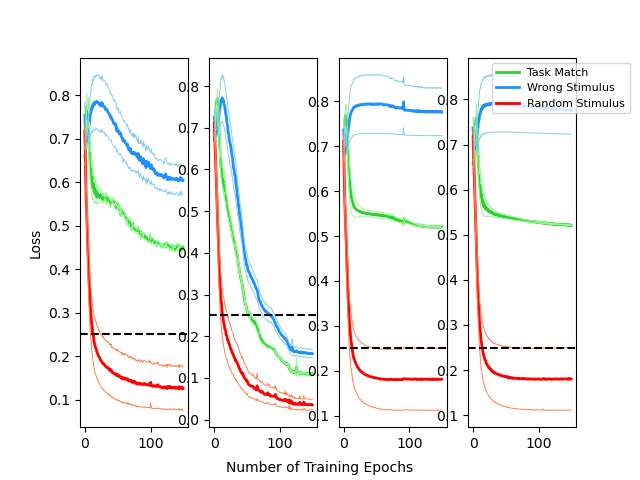

In [55]:
fig, ax = plt.subplots(1,4)

# plot losses

# Individual losses for each sample type (where the same stimulus is cued each round)
# ax[0].set_title("Vanilla RNN - Small Delays", fontsize=10)
ax[0].plot(match_mean_losses_small_rnncell, color='limegreen', label="Task Match", linewidth=2)
ax[0].plot(wrong_stimuli_mean_losses_small_rnncell, color='dodgerblue', label="Wrong Stimulus", linewidth=2)
ax[0].plot(random_stimuli_mean_losses_small_rnncell, color='red', label="Random Stimulus", linewidth=2)

## Standard deviations
ax[0].plot((match_mean_losses_small_rnncell + 2*stats.sem(match_losses_small_rnncell, axis=0, ddof=0)), color='palegreen', linewidth=0.7)
ax[0].plot((match_mean_losses_small_rnncell - 2*stats.sem(match_losses_small_rnncell, axis=0, ddof=0)), color='palegreen', linewidth=0.7)

ax[0].plot((wrong_stimuli_mean_losses_small_rnncell + 2*stats.sem(wrong_stimuli_losses_small_rnncell, axis=0, ddof=0)), color='skyblue', linewidth=0.7)
ax[0].plot((wrong_stimuli_mean_losses_small_rnncell - 2*stats.sem(wrong_stimuli_losses_small_rnncell, axis=0, ddof=0)), color='skyblue', linewidth=0.7)

ax[0].plot((random_stimuli_mean_losses_small_rnncell + 2*stats.sem(random_stimuli_losses_small_rnncell, axis=0, ddof=0)), color='coral', linewidth=0.7)
ax[0].plot((random_stimuli_mean_losses_small_rnncell - 2*stats.sem(random_stimuli_losses_small_rnncell, axis=0, ddof=0)), color='coral', linewidth=0.7)

# Individual losses for each sample type (where a different stimulus is cued each round)
# ax[1].set_title("LSTM - Small Delays", fontsize=10)
ax[1].plot(match_mean_losses_small_lstmcell, color='limegreen', label="Task Match", linewidth=2)
ax[1].plot(wrong_stimuli_mean_losses_small_lstmcell, color='dodgerblue', label="Wrong Stimulus", linewidth=2)
ax[1].plot(random_stimuli_mean_losses_small_lstmcell, color='red', label="Random Stimulus", linewidth=2)

## Standard deviations
ax[1].plot((match_mean_losses_small_lstmcell + 2*stats.sem(match_losses_small_lstmcell, axis=0, ddof=0)), color='palegreen', linewidth=0.7)
ax[1].plot((match_mean_losses_small_lstmcell - 2*stats.sem(match_losses_small_lstmcell, axis=0, ddof=0)), color='palegreen', linewidth=0.7)      
           
ax[1].plot((wrong_stimuli_mean_losses_small_lstmcell + 2*stats.sem(wrong_stimuli_losses_small_lstmcell, axis=0, ddof=0)), color='skyblue', linewidth=0.7)
ax[1].plot((wrong_stimuli_mean_losses_small_lstmcell - 2*stats.sem(wrong_stimuli_losses_small_lstmcell, axis=0, ddof=0)), color='skyblue', linewidth=0.7)

ax[1].plot((random_stimuli_mean_losses_small_lstmcell + 2*stats.sem(random_stimuli_losses_small_lstmcell, axis=0, ddof=0)), color='coral', linewidth=0.7)
ax[1].plot((random_stimuli_mean_losses_small_lstmcell - 2*stats.sem(random_stimuli_losses_small_lstmcell, axis=0, ddof=0)), color='coral', linewidth=0.7)

# Individual losses for each sample type (where the same stimulus is cued each round)
# ax[2].set_title("Vanilla - Large Delays", fontsize=10)
ax[2].plot(match_mean_losses_large_rnncell, color='limegreen', label="Task Match", linewidth=2)
ax[2].plot(wrong_stimuli_mean_losses_large_rnncell, color='dodgerblue', label="Wrong Stimulus", linewidth=2)
ax[2].plot(random_stimuli_mean_losses_large_rnncell, color='red', label="Random Stimulus", linewidth=2)

## Standard deviations
ax[2].plot((match_mean_losses_large_rnncell + 2*stats.sem(match_losses_large_rnncell, axis=0, ddof=0)), color='palegreen', linewidth=0.7)
ax[2].plot((match_mean_losses_large_rnncell - 2*stats.sem(match_losses_large_rnncell, axis=0, ddof=0)), color='palegreen', linewidth=0.7)

ax[2].plot((wrong_stimuli_mean_losses_large_rnncell + 2*stats.sem(wrong_stimuli_losses_large_rnncell, axis=0, ddof=0)), color='skyblue', linewidth=0.7)
ax[2].plot((wrong_stimuli_mean_losses_large_rnncell - 2*stats.sem(wrong_stimuli_losses_large_rnncell, axis=0, ddof=0)), color='skyblue', linewidth=0.7)

ax[2].plot((random_stimuli_mean_losses_large_rnncell + 2*stats.sem(random_stimuli_losses_large_rnncell, axis=0, ddof=0)), color='coral', linewidth=0.7)
ax[2].plot((random_stimuli_mean_losses_large_rnncell - 2*stats.sem(random_stimuli_losses_large_rnncell, axis=0, ddof=0)), color='coral', linewidth=0.7)

# Individual losses for each sample type (where a different stimulus is cued each round)
# ax[3].set_title("LSTM - Large Delays", fontsize=10)
ax[3].plot(match_mean_losses_large_lstmcell, color='limegreen', label="Task Match", linewidth=2)
ax[3].plot(wrong_stimuli_mean_losses_large_lstmcell, color='dodgerblue', label="Wrong Stimulus", linewidth=2)
ax[3].plot(random_stimuli_mean_losses_large_lstmcell, color='red', label="Random Stimulus", linewidth=2)

## Standard deviations
ax[3].plot((match_mean_losses_large_lstmcell + 2*stats.sem(match_losses_large_lstmcell, axis=0, ddof=0)), color='palegreen', linewidth=0.7)
ax[3].plot((match_mean_losses_large_lstmcell - 2*stats.sem(match_losses_large_lstmcell, axis=0, ddof=0)), color='palegreen', linewidth=0.7)      
           
ax[3].plot((wrong_stimuli_mean_losses_large_lstmcell + 2*stats.sem(wrong_stimuli_losses_large_lstmcell, axis=0, ddof=0)), color='skyblue', linewidth=0.7)
ax[3].plot((wrong_stimuli_mean_losses_large_lstmcell - 2*stats.sem(wrong_stimuli_losses_large_lstmcell, axis=0, ddof=0)), color='skyblue', linewidth=0.7)

ax[3].plot((random_stimuli_mean_losses_large_lstmcell + 2*stats.sem(random_stimuli_losses_large_lstmcell, axis=0, ddof=0)), color='coral', linewidth=0.7)
ax[3].plot((random_stimuli_mean_losses_large_lstmcell - 2*stats.sem(random_stimuli_losses_large_lstmcell, axis=0, ddof=0)), color='coral', linewidth=0.7)

# Threshold line
ax[0].axhline(threshold, linestyle='dashed', color='black')
ax[1].axhline(threshold, linestyle='dashed', color='black')
ax[2].axhline(threshold, linestyle='dashed', color='black')
ax[3].axhline(threshold, linestyle='dashed', color='black')

# legend and show plot
ax[3].legend(fontsize=8, bbox_to_anchor=(1.55, 1), loc="upper right") # by default, the legend ignores all elements without a label attribute set.

fig.supxlabel('Number of Training Epochs', fontsize=10) # x label
ax[0].set_ylabel('Loss', fontsize=10) # y label

plt.show()

## **Dual Retro-Cue Task w/ Memory Augmented LSTMs**

In [ ]:
# DRC Task w/ Memory Augmented LSTMs -- Hyperparameters
generate_new = True
generate_random = False
return_sample_losses = True
multiple_tests = True
test_type = 'dual_retro_cue'
multiple_tests_type='resue_one_stimulus'

### *DNDLSTM Remembering the Cue State (Control) ~ Training*

In [ ]:
# DRC Task with Memory Augmented LSTM — Saving the Cues into Long Term Memory (Control Condition)
network_type = 'dndlstmcell'
memory_rule = 'remember_cue_directions'
mean_loss_small_dndlstmcell_cues2ltm_drc,losses_small_dndlstmcell_cues2ltm_drc,mean_sample_loss_small_dndlstmcell_cues2ltm_drc,sample_losses_small_dndlstmcell_cues2ltm_drc,_ = get_loss(test_type=test_type, network_type=network_type, num_networks=num_networks, condition=small_small_delays, memory_rule=memory_rule, multiple_tests=multiple_tests, multiple_tests_type=multiple_tests_type, stimulus_set=stimulus_set)
mean_loss_large_dndlstmcell_cues2ltm_drc,losses_large_dndlstmcell_cues2ltm_drc,mean_sample_loss_large_dndlstmcell_cues2ltm_drc,sample_losses_large_dndlstmcell_cues2ltm_drc,_ = get_loss(test_type=test_type, network_type=network_type, num_networks=num_networks, condition=large_large_delays, memory_rule=memory_rule, multiple_tests=multiple_tests, multiple_tests_type=multiple_tests_type, stimulus_set=stimulus_set)

### *DNDLSTM Remembering the Stimulus State (Test) ~ Training*

In [ ]:
# DRC Task with Memory Augmented LSTM — Saving the Stimuli into Long Term Memory (Test Condition)
network_type = 'dndlstmcell'
memory_rule = 'remember_stimuli_states'
mean_loss_small_dndlstmcell_stimuli2ltm_drc,losses_small_dndlstmcell_stimuli2ltm_drc,mean_sample_loss_small_dndlstmcell_stimuli2ltm_drc,sample_losses_small_dndlstmcell_stimuli2ltm_drc,_ = get_loss(test_type=test_type, network_type=network_type, num_networks=num_networks, condition=small_small_delays, memory_rule=memory_rule, multiple_tests=multiple_tests, multiple_tests_type=multiple_tests_type, stimulus_set=stimulus_set)
mean_loss_large_dndlstmcell_stimuli2ltm_drc,losses_large_dndlstmcell_stimuli2ltm_drc,mean_sample_loss_large_dndlstmcell_stimuli2ltm_drc,sample_losses_large_dndlstmcell_stimuli2ltm_drc,_ = get_loss(test_type=test_type, network_type=network_type, num_networks=num_networks, condition=large_large_delays, memory_rule=memory_rule, multiple_tests=multiple_tests, multiple_tests_type=multiple_tests_type, stimulus_set=stimulus_set)

### *Graphs for Memory Augmented LSTMs on the Dual Retro-Cue Task*

#### *General Graph for Memory Augmented LSTMs on the Dual Retro-Cue Task*

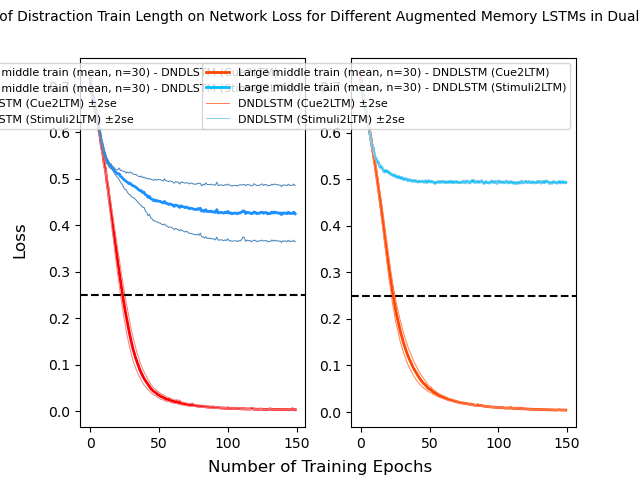

In [57]:
### General Plots for WMEM DRC Task ###

fig, ax = plt.subplots(1,2)

# plot losses
fig.suptitle("Average Effect of Distraction Train Length on Network Loss for Different Augmented Memory LSTMs in Dual Retro-Cue Task", fontsize=10)

## Mean losses (Control)
ax[0].plot(mean_loss_small_dndlstmcell_cues2ltm_drc, color='red', label="Small middle train (mean, n=" + str(num_networks) + ") - DNDLSTM (Cue2LTM)", linewidth=2)
ax[1].plot(mean_loss_large_dndlstmcell_cues2ltm_drc, color='orangered', label="Large middle train (mean, n=" + str(num_networks) + ") - DNDLSTM (Cue2LTM)", linewidth=2)

## Mean losses (Test)
ax[0].plot(mean_loss_small_dndlstmcell_stimuli2ltm_drc, color='dodgerblue', label="Small middle train (mean, n=" + str(num_networks) + ") - DNDLSTM (Stimuli2LTM)", linewidth=2)
ax[1].plot(mean_loss_large_dndlstmcell_stimuli2ltm_drc, color='deepskyblue', label="Large middle train (mean, n=" + str(num_networks) + ") - DNDLSTM (Stimuli2LTM)", linewidth=2)

## Standard deviations (Control)
ax[0].plot((mean_loss_small_dndlstmcell_cues2ltm_drc + 2*stats.sem(losses_small_dndlstmcell_cues2ltm_drc, axis=0, ddof=0)), color='lightcoral', label="DNDLSTM (Cue2LTM) ±2se", linewidth=0.7) # small case
ax[0].plot((mean_loss_small_dndlstmcell_cues2ltm_drc - 2*stats.sem(losses_small_dndlstmcell_cues2ltm_drc, axis=0, ddof=0)), color='lightcoral', linewidth=0.7) # small case

ax[1].plot((mean_loss_large_dndlstmcell_cues2ltm_drc + 2*stats.sem(losses_large_dndlstmcell_cues2ltm_drc, axis=0, ddof=0)), color='coral', label="DNDLSTM (Cue2LTM) ±2se", linewidth=0.7) # large case
ax[1].plot((mean_loss_large_dndlstmcell_cues2ltm_drc - 2*stats.sem(losses_large_dndlstmcell_cues2ltm_drc, axis=0, ddof=0)), color='coral', linewidth=0.7) # large case

## Standard deviations (Test)
ax[0].plot((mean_loss_small_dndlstmcell_stimuli2ltm_drc + 2*stats.sem(losses_small_dndlstmcell_stimuli2ltm_drc, axis=0, ddof=0)), color='steelblue', label="DNDLSTM (Stimuli2LTM) ±2se", linewidth=0.7) # small case
ax[0].plot((mean_loss_small_dndlstmcell_stimuli2ltm_drc - 2*stats.sem(losses_small_dndlstmcell_stimuli2ltm_drc, axis=0, ddof=0)), color='steelblue', linewidth=0.7) # small case

ax[1].plot((mean_loss_large_dndlstmcell_stimuli2ltm_drc + 2*stats.sem(losses_large_dndlstmcell_stimuli2ltm_drc, axis=0, ddof=0)), color='skyblue', label="DNDLSTM (Stimuli2LTM) ±2se", linewidth=0.7) # large case
ax[1].plot((mean_loss_large_dndlstmcell_stimuli2ltm_drc - 2*stats.sem(losses_large_dndlstmcell_stimuli2ltm_drc, axis=0, ddof=0)), color='skyblue', linewidth=0.7) # large case

# Threshold line
ax[0].axhline(threshold, linestyle='dashed', color='black')
ax[1].axhline(threshold, linestyle='dashed', color='black')

# legend and show plot
ax[0].legend(fontsize=8, loc="upper right") # by default, the legend ignores all elements without a label attribute set.
ax[1].legend(fontsize=8, loc="upper right") # by default, the legend ignores all elements without a label attribute set.

fig.supxlabel('Number of Training Epochs')
fig.supylabel('Loss')

plt.show()

#### *Graph on Each Trial Type for Memory Augmented LSTMs on the Dual Retro-Cue Task (Small Delays)*

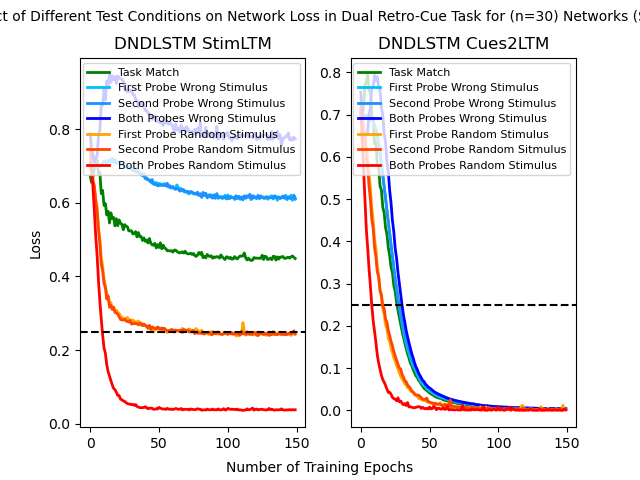

In [58]:
### Specific Plots for WMEM DRC Task ###

### DNDLSTM - Stim2LTM ###

mean_sample_loss_small_dndlstmcell_stimuli2ltm_drc_dict, sample_losses_small_dndlstmcell_stimuli2ltm_drc_dict = partition_sample_losses("dual_retro_cue", mean_sample_loss_small_dndlstmcell_stimuli2ltm_drc, sample_losses_small_dndlstmcell_stimuli2ltm_drc)

task0_mean_loss = mean_sample_loss_small_dndlstmcell_stimuli2ltm_drc_dict[0]
task1_mean_loss = mean_sample_loss_small_dndlstmcell_stimuli2ltm_drc_dict[1]
task2_mean_loss = mean_sample_loss_small_dndlstmcell_stimuli2ltm_drc_dict[2]
task3_mean_loss = mean_sample_loss_small_dndlstmcell_stimuli2ltm_drc_dict[3]
task4_mean_loss = mean_sample_loss_small_dndlstmcell_stimuli2ltm_drc_dict[4]
task5_mean_loss = mean_sample_loss_small_dndlstmcell_stimuli2ltm_drc_dict[5]
task6_mean_loss = mean_sample_loss_small_dndlstmcell_stimuli2ltm_drc_dict[6]
task7_mean_loss = mean_sample_loss_small_dndlstmcell_stimuli2ltm_drc_dict[7]
task8_mean_loss = mean_sample_loss_small_dndlstmcell_stimuli2ltm_drc_dict[8]
task9_mean_loss = mean_sample_loss_small_dndlstmcell_stimuli2ltm_drc_dict[9]
task10_mean_loss = mean_sample_loss_small_dndlstmcell_stimuli2ltm_drc_dict[10]
task11_mean_loss = mean_sample_loss_small_dndlstmcell_stimuli2ltm_drc_dict[11]
task12_mean_loss = mean_sample_loss_small_dndlstmcell_stimuli2ltm_drc_dict[12]
task13_mean_loss = mean_sample_loss_small_dndlstmcell_stimuli2ltm_drc_dict[13]
task14_mean_loss = mean_sample_loss_small_dndlstmcell_stimuli2ltm_drc_dict[14]
task15_mean_loss = mean_sample_loss_small_dndlstmcell_stimuli2ltm_drc_dict[15]
task16_mean_loss = mean_sample_loss_small_dndlstmcell_stimuli2ltm_drc_dict[16]
task17_mean_loss = mean_sample_loss_small_dndlstmcell_stimuli2ltm_drc_dict[17]
task18_mean_loss = mean_sample_loss_small_dndlstmcell_stimuli2ltm_drc_dict[18]
task19_mean_loss = mean_sample_loss_small_dndlstmcell_stimuli2ltm_drc_dict[19]
task20_mean_loss = mean_sample_loss_small_dndlstmcell_stimuli2ltm_drc_dict[20]
task21_mean_loss = mean_sample_loss_small_dndlstmcell_stimuli2ltm_drc_dict[21]
task22_mean_loss = mean_sample_loss_small_dndlstmcell_stimuli2ltm_drc_dict[22]
task23_mean_loss = mean_sample_loss_small_dndlstmcell_stimuli2ltm_drc_dict[23]
task24_mean_loss = mean_sample_loss_small_dndlstmcell_stimuli2ltm_drc_dict[24]
task25_mean_loss = mean_sample_loss_small_dndlstmcell_stimuli2ltm_drc_dict[25]
task26_mean_loss = mean_sample_loss_small_dndlstmcell_stimuli2ltm_drc_dict[26]
task27_mean_loss = mean_sample_loss_small_dndlstmcell_stimuli2ltm_drc_dict[27]

task0_sample_losses = sample_losses_small_dndlstmcell_stimuli2ltm_drc_dict[0]
task1_sample_losses = sample_losses_small_dndlstmcell_stimuli2ltm_drc_dict[1]
task2_sample_losses = sample_losses_small_dndlstmcell_stimuli2ltm_drc_dict[2]
task3_sample_losses = sample_losses_small_dndlstmcell_stimuli2ltm_drc_dict[3]
task4_sample_losses = sample_losses_small_dndlstmcell_stimuli2ltm_drc_dict[4]
task5_sample_losses = sample_losses_small_dndlstmcell_stimuli2ltm_drc_dict[5]
task6_sample_losses = sample_losses_small_dndlstmcell_stimuli2ltm_drc_dict[6]
task7_sample_losses = sample_losses_small_dndlstmcell_stimuli2ltm_drc_dict[7]
task8_sample_losses = sample_losses_small_dndlstmcell_stimuli2ltm_drc_dict[8]
task9_sample_losses = sample_losses_small_dndlstmcell_stimuli2ltm_drc_dict[9]
task10_sample_losses = sample_losses_small_dndlstmcell_stimuli2ltm_drc_dict[10]
task11_sample_losses = sample_losses_small_dndlstmcell_stimuli2ltm_drc_dict[11]
task12_sample_losses = sample_losses_small_dndlstmcell_stimuli2ltm_drc_dict[12]
task13_sample_losses = sample_losses_small_dndlstmcell_stimuli2ltm_drc_dict[13]
task14_sample_losses = sample_losses_small_dndlstmcell_stimuli2ltm_drc_dict[14]
task15_sample_losses = sample_losses_small_dndlstmcell_stimuli2ltm_drc_dict[15]
task16_sample_losses = sample_losses_small_dndlstmcell_stimuli2ltm_drc_dict[16]
task17_sample_losses = sample_losses_small_dndlstmcell_stimuli2ltm_drc_dict[17]
task18_sample_losses = sample_losses_small_dndlstmcell_stimuli2ltm_drc_dict[18]
task19_sample_losses = sample_losses_small_dndlstmcell_stimuli2ltm_drc_dict[19]
task20_sample_losses = sample_losses_small_dndlstmcell_stimuli2ltm_drc_dict[20]
task21_sample_losses = sample_losses_small_dndlstmcell_stimuli2ltm_drc_dict[21]
task22_sample_losses = sample_losses_small_dndlstmcell_stimuli2ltm_drc_dict[22]
task23_sample_losses = sample_losses_small_dndlstmcell_stimuli2ltm_drc_dict[23]
task24_sample_losses = sample_losses_small_dndlstmcell_stimuli2ltm_drc_dict[24]
task25_sample_losses = sample_losses_small_dndlstmcell_stimuli2ltm_drc_dict[25]
task26_sample_losses = sample_losses_small_dndlstmcell_stimuli2ltm_drc_dict[26]
task27_sample_losses = sample_losses_small_dndlstmcell_stimuli2ltm_drc_dict[27]

# testing different cases when the same cues are made before the probes (Vanilla Working Memory Case)
match_losses_same_cues = [task1_mean_loss, task3_mean_loss]
first_probe_wrong_stimuli_losses_same_cues = [task12_mean_loss, task14_mean_loss]
first_probe_random_stimuli_losses_same_cues = [task13_mean_loss, task15_mean_loss]
second_probe_wrong_stimuli_losses_same_cues = [task16_mean_loss, task18_mean_loss]
second_probe_random_stimuli_losses_same_cues = [task17_mean_loss, task19_mean_loss]
both_probes_wrong_stimuli_losses_same_cues = [task24_mean_loss, task26_mean_loss]
both_probes_random_stimuli_losses_same_cues = [task25_mean_loss, task27_mean_loss]


# testing different cases when a different second cue is made before the second probe (ASWM case)
match_losses_different_cues = [task0_mean_loss, task2_mean_loss]
first_probe_wrong_stimuli_losses_different_cues = [task4_mean_loss, task6_mean_loss]
first_probe_random_stimuli_losses_different_cues = [task5_mean_loss, task7_mean_loss]
second_probe_wrong_stimuli_losses_different_cues = [task8_mean_loss, task10_mean_loss]
second_probe_random_stimuli_losses_different_cues = [task9_mean_loss, task11_mean_loss]
both_probes_wrong_stimuli_losses_different_cues = [task20_mean_loss, task22_mean_loss]
both_probes_random_stimuli_losses_different_cues = [task21_mean_loss, task23_mean_loss]

# get the mean losses for each of these 7 categories

match_losses_small_dndlstmcell_stimuli2ltm = match_losses_same_cues + match_losses_different_cues
first_probe_wrong_stimuli_losses_small_dndlstmcell_stimuli2ltm = first_probe_wrong_stimuli_losses_same_cues + first_probe_wrong_stimuli_losses_different_cues
first_probe_random_stimuli_losses_small_dndlstmcell_stimuli2ltm = first_probe_random_stimuli_losses_same_cues + first_probe_random_stimuli_losses_different_cues
second_probe_wrong_stimuli_losses_small_dndlstmcell_stimuli2ltm = second_probe_wrong_stimuli_losses_same_cues + second_probe_wrong_stimuli_losses_different_cues
second_probe_random_stimuli_losses_small_dndlstmcell_stimuli2ltm = second_probe_random_stimuli_losses_same_cues + second_probe_random_stimuli_losses_different_cues
both_probes_wrong_stimuli_losses_small_dndlstmcell_stimuli2ltm = both_probes_wrong_stimuli_losses_same_cues + both_probes_wrong_stimuli_losses_different_cues
both_probes_random_stimuli_losses_small_dndlstmcell_stimuli2ltm = both_probes_random_stimuli_losses_same_cues + both_probes_random_stimuli_losses_different_cues


match_mean_losses_small_dndlstmcell_stimuli2ltm = np.mean(match_losses_small_dndlstmcell_stimuli2ltm, axis=0)
first_probe_wrong_stimuli_mean_losses_small_dndlstmcell_stimuli2ltm = np.mean(first_probe_wrong_stimuli_losses_small_dndlstmcell_stimuli2ltm, axis=0)
first_probe_random_stimuli_mean_losses_small_dndlstmcell_stimuli2ltm = np.mean(first_probe_random_stimuli_losses_small_dndlstmcell_stimuli2ltm, axis=0)
second_probe_wrong_stimuli_mean_losses_small_dndlstmcell_stimuli2ltm = np.mean(second_probe_wrong_stimuli_losses_small_dndlstmcell_stimuli2ltm, axis=0)
second_probe_random_stimuli_mean_losses_small_dndlstmcell_stimuli2ltm = np.mean(second_probe_random_stimuli_losses_small_dndlstmcell_stimuli2ltm, axis=0)
both_probes_wrong_stimuli_mean_losses_small_dndlstmcell_stimuli2ltm = np.mean(both_probes_wrong_stimuli_losses_small_dndlstmcell_stimuli2ltm, axis=0)
both_probes_random_stimuli_mean_losses_small_dndlstmcell_stimuli2ltm = np.mean(both_probes_random_stimuli_losses_small_dndlstmcell_stimuli2ltm, axis=0)

### Specific Plots for WMEM DRC Task ###

### DNDLSTM - Cues2LTM ###

mean_sample_loss_small_dndlstmcell_cues2ltm_drc_dict, sample_losses_small_dndlstmcell_cues2ltm_drc_dict = partition_sample_losses("dual_retro_cue", mean_sample_loss_small_dndlstmcell_cues2ltm_drc, sample_losses_small_dndlstmcell_cues2ltm_drc)

task0_mean_loss = mean_sample_loss_small_dndlstmcell_cues2ltm_drc_dict[0]
task1_mean_loss = mean_sample_loss_small_dndlstmcell_cues2ltm_drc_dict[1]
task2_mean_loss = mean_sample_loss_small_dndlstmcell_cues2ltm_drc_dict[2]
task3_mean_loss = mean_sample_loss_small_dndlstmcell_cues2ltm_drc_dict[3]
task4_mean_loss = mean_sample_loss_small_dndlstmcell_cues2ltm_drc_dict[4]
task5_mean_loss = mean_sample_loss_small_dndlstmcell_cues2ltm_drc_dict[5]
task6_mean_loss = mean_sample_loss_small_dndlstmcell_cues2ltm_drc_dict[6]
task7_mean_loss = mean_sample_loss_small_dndlstmcell_cues2ltm_drc_dict[7]
task8_mean_loss = mean_sample_loss_small_dndlstmcell_cues2ltm_drc_dict[8]
task9_mean_loss = mean_sample_loss_small_dndlstmcell_cues2ltm_drc_dict[9]
task10_mean_loss = mean_sample_loss_small_dndlstmcell_cues2ltm_drc_dict[10]
task11_mean_loss = mean_sample_loss_small_dndlstmcell_cues2ltm_drc_dict[11]
task12_mean_loss = mean_sample_loss_small_dndlstmcell_cues2ltm_drc_dict[12]
task13_mean_loss = mean_sample_loss_small_dndlstmcell_cues2ltm_drc_dict[13]
task14_mean_loss = mean_sample_loss_small_dndlstmcell_cues2ltm_drc_dict[14]
task15_mean_loss = mean_sample_loss_small_dndlstmcell_cues2ltm_drc_dict[15]
task16_mean_loss = mean_sample_loss_small_dndlstmcell_cues2ltm_drc_dict[16]
task17_mean_loss = mean_sample_loss_small_dndlstmcell_cues2ltm_drc_dict[17]
task18_mean_loss = mean_sample_loss_small_dndlstmcell_cues2ltm_drc_dict[18]
task19_mean_loss = mean_sample_loss_small_dndlstmcell_cues2ltm_drc_dict[19]
task20_mean_loss = mean_sample_loss_small_dndlstmcell_cues2ltm_drc_dict[20]
task21_mean_loss = mean_sample_loss_small_dndlstmcell_cues2ltm_drc_dict[21]
task22_mean_loss = mean_sample_loss_small_dndlstmcell_cues2ltm_drc_dict[22]
task23_mean_loss = mean_sample_loss_small_dndlstmcell_cues2ltm_drc_dict[23]
task24_mean_loss = mean_sample_loss_small_dndlstmcell_cues2ltm_drc_dict[24]
task25_mean_loss = mean_sample_loss_small_dndlstmcell_cues2ltm_drc_dict[25]
task26_mean_loss = mean_sample_loss_small_dndlstmcell_cues2ltm_drc_dict[26]
task27_mean_loss = mean_sample_loss_small_dndlstmcell_cues2ltm_drc_dict[27]

task0_sample_losses = sample_losses_small_dndlstmcell_cues2ltm_drc_dict[0]
task1_sample_losses = sample_losses_small_dndlstmcell_cues2ltm_drc_dict[1]
task2_sample_losses = sample_losses_small_dndlstmcell_cues2ltm_drc_dict[2]
task3_sample_losses = sample_losses_small_dndlstmcell_cues2ltm_drc_dict[3]
task4_sample_losses = sample_losses_small_dndlstmcell_cues2ltm_drc_dict[4]
task5_sample_losses = sample_losses_small_dndlstmcell_cues2ltm_drc_dict[5]
task6_sample_losses = sample_losses_small_dndlstmcell_cues2ltm_drc_dict[6]
task7_sample_losses = sample_losses_small_dndlstmcell_cues2ltm_drc_dict[7]
task8_sample_losses = sample_losses_small_dndlstmcell_cues2ltm_drc_dict[8]
task9_sample_losses = sample_losses_small_dndlstmcell_cues2ltm_drc_dict[9]
task10_sample_losses = sample_losses_small_dndlstmcell_cues2ltm_drc_dict[10]
task11_sample_losses = sample_losses_small_dndlstmcell_cues2ltm_drc_dict[11]
task12_sample_losses = sample_losses_small_dndlstmcell_cues2ltm_drc_dict[12]
task13_sample_losses = sample_losses_small_dndlstmcell_cues2ltm_drc_dict[13]
task14_sample_losses = sample_losses_small_dndlstmcell_cues2ltm_drc_dict[14]
task15_sample_losses = sample_losses_small_dndlstmcell_cues2ltm_drc_dict[15]
task16_sample_losses = sample_losses_small_dndlstmcell_cues2ltm_drc_dict[16]
task17_sample_losses = sample_losses_small_dndlstmcell_cues2ltm_drc_dict[17]
task18_sample_losses = sample_losses_small_dndlstmcell_cues2ltm_drc_dict[18]
task19_sample_losses = sample_losses_small_dndlstmcell_cues2ltm_drc_dict[19]
task20_sample_losses = sample_losses_small_dndlstmcell_cues2ltm_drc_dict[20]
task21_sample_losses = sample_losses_small_dndlstmcell_cues2ltm_drc_dict[21]
task22_sample_losses = sample_losses_small_dndlstmcell_cues2ltm_drc_dict[22]
task23_sample_losses = sample_losses_small_dndlstmcell_cues2ltm_drc_dict[23]
task24_sample_losses = sample_losses_small_dndlstmcell_cues2ltm_drc_dict[24]
task25_sample_losses = sample_losses_small_dndlstmcell_cues2ltm_drc_dict[25]
task26_sample_losses = sample_losses_small_dndlstmcell_cues2ltm_drc_dict[26]
task27_sample_losses = sample_losses_small_dndlstmcell_cues2ltm_drc_dict[27]

# testing different cases when the same cues are made before the probes (Vanilla Working Memory Case)
match_losses_same_cues = [task1_mean_loss, task3_mean_loss]
first_probe_wrong_stimuli_losses_same_cues = [task12_mean_loss, task14_mean_loss]
first_probe_random_stimuli_losses_same_cues = [task13_mean_loss, task15_mean_loss]
second_probe_wrong_stimuli_losses_same_cues = [task16_mean_loss, task18_mean_loss]
second_probe_random_stimuli_losses_same_cues = [task17_mean_loss, task19_mean_loss]
both_probes_wrong_stimuli_losses_same_cues = [task24_mean_loss, task26_mean_loss]
both_probes_random_stimuli_losses_same_cues = [task25_mean_loss, task27_mean_loss]


# testing different cases when a different second cue is made before the second probe (ASWM case)
match_losses_different_cues = [task0_mean_loss, task2_mean_loss]
first_probe_wrong_stimuli_losses_different_cues = [task4_mean_loss, task6_mean_loss]
first_probe_random_stimuli_losses_different_cues = [task5_mean_loss, task7_mean_loss]
second_probe_wrong_stimuli_losses_different_cues = [task8_mean_loss, task10_mean_loss]
second_probe_random_stimuli_losses_different_cues = [task9_mean_loss, task11_mean_loss]
both_probes_wrong_stimuli_losses_different_cues = [task20_mean_loss, task22_mean_loss]
both_probes_random_stimuli_losses_different_cues = [task21_mean_loss, task23_mean_loss]

# get the mean losses for each of these 7 categories

match_losses_small_dndlstmcell_cues2ltm = match_losses_same_cues + match_losses_different_cues
first_probe_wrong_stimuli_losses_small_dndlstmcell_cues2ltm = first_probe_wrong_stimuli_losses_same_cues + first_probe_wrong_stimuli_losses_different_cues
first_probe_random_stimuli_losses_small_dndlstmcell_cues2ltm = first_probe_random_stimuli_losses_same_cues + first_probe_random_stimuli_losses_different_cues
second_probe_wrong_stimuli_losses_small_dndlstmcell_cues2ltm = second_probe_wrong_stimuli_losses_same_cues + second_probe_wrong_stimuli_losses_different_cues
second_probe_random_stimuli_losses_small_dndlstmcell_cues2ltm = second_probe_random_stimuli_losses_same_cues + second_probe_random_stimuli_losses_different_cues
both_probes_wrong_stimuli_losses_small_dndlstmcell_cues2ltm = both_probes_wrong_stimuli_losses_same_cues + both_probes_wrong_stimuli_losses_different_cues
both_probes_random_stimuli_losses_small_dndlstmcell_cues2ltm = both_probes_random_stimuli_losses_same_cues + both_probes_random_stimuli_losses_different_cues


match_mean_losses_small_dndlstmcell_cues2ltm = np.mean(match_losses_small_dndlstmcell_cues2ltm, axis=0)
first_probe_wrong_stimuli_mean_losses_small_dndlstmcell_cues2ltm = np.mean(first_probe_wrong_stimuli_losses_small_dndlstmcell_cues2ltm, axis=0)
first_probe_random_stimuli_mean_losses_small_dndlstmcell_cues2ltm = np.mean(first_probe_random_stimuli_losses_small_dndlstmcell_cues2ltm, axis=0)
second_probe_wrong_stimuli_mean_losses_small_dndlstmcell_cues2ltm = np.mean(second_probe_wrong_stimuli_losses_small_dndlstmcell_cues2ltm, axis=0)
second_probe_random_stimuli_mean_losses_small_dndlstmcell_cues2ltm = np.mean(second_probe_random_stimuli_losses_small_dndlstmcell_cues2ltm, axis=0)
both_probes_wrong_stimuli_mean_losses_small_dndlstmcell_cues2ltm = np.mean(both_probes_wrong_stimuli_losses_small_dndlstmcell_cues2ltm, axis=0)
both_probes_random_stimuli_mean_losses_small_dndlstmcell_cues2ltm = np.mean(both_probes_random_stimuli_losses_small_dndlstmcell_cues2ltm, axis=0)


fig, ax = plt.subplots(1,2)

# plot losses
fig.suptitle("Average Effect of Different Test Conditions on Network Loss in Dual Retro-Cue Task for (n=" + str(num_networks) + ") Networks (Small Delays)", fontsize=10)

# Individual losses for each sample type (where the same stimulus is cued each round)
ax[0].set_title("DNDLSTM StimLTM")
ax[0].plot(match_mean_losses_small_dndlstmcell_stimuli2ltm, color='green', label="Task Match", linewidth=2)
ax[0].plot(first_probe_wrong_stimuli_mean_losses_small_dndlstmcell_stimuli2ltm, color='deepskyblue', label="First Probe Wrong Stimulus", linewidth=2)
ax[0].plot(second_probe_wrong_stimuli_mean_losses_small_dndlstmcell_stimuli2ltm, color='dodgerblue', label="Second Probe Wrong Stimulus", linewidth=2)
ax[0].plot(both_probes_wrong_stimuli_mean_losses_small_dndlstmcell_stimuli2ltm, color='blue', label="Both Probes Wrong Stimulus", linewidth=2)
ax[0].plot(first_probe_random_stimuli_mean_losses_small_dndlstmcell_stimuli2ltm, color='orange', label="First Probe Random Stimulus", linewidth=2)
ax[0].plot(second_probe_random_stimuli_mean_losses_small_dndlstmcell_stimuli2ltm, color='orangered', label="Second Probe Random Sitmulus", linewidth=2)
ax[0].plot(both_probes_random_stimuli_mean_losses_small_dndlstmcell_stimuli2ltm, color='red', label="Both Probes Random Stimulus", linewidth=2)

# Individual losses for each sample type (where a different stimulus is cued each round)
ax[1].set_title("DNDLSTM Cues2LTM")
ax[1].plot(match_mean_losses_small_dndlstmcell_cues2ltm, color='green', label="Task Match", linewidth=2)
ax[1].plot(first_probe_wrong_stimuli_mean_losses_small_dndlstmcell_cues2ltm, color='deepskyblue', label="First Probe Wrong Stimulus", linewidth=2)
ax[1].plot(second_probe_wrong_stimuli_mean_losses_small_dndlstmcell_cues2ltm, color='dodgerblue', label="Second Probe Wrong Stimulus", linewidth=2)
ax[1].plot(both_probes_wrong_stimuli_mean_losses_small_dndlstmcell_cues2ltm, color='blue', label="Both Probes Wrong Stimulus", linewidth=2)
ax[1].plot(first_probe_random_stimuli_mean_losses_small_dndlstmcell_cues2ltm, color='orange', label="First Probe Random Stimulus", linewidth=2)
ax[1].plot(second_probe_random_stimuli_mean_losses_small_dndlstmcell_cues2ltm, color='orangered', label="Second Probe Random Sitmulus", linewidth=2)
ax[1].plot(both_probes_random_stimuli_mean_losses_small_dndlstmcell_cues2ltm, color='red', label="Both Probes Random Stimulus", linewidth=2)

# Threshold line
ax[0].axhline(threshold, linestyle='dashed', color='black')
ax[1].axhline(threshold, linestyle='dashed', color='black')

# legend and show plot
ax[0].legend(fontsize=8, loc="upper right") # by default, the legend ignores all elements without a label attribute set.
ax[1].legend(fontsize=8, loc="upper right") # by default, the legend ignores all elements without a label attribute set.

fig.supxlabel('Number of Training Epochs', fontsize=10) # x label
ax[0].set_ylabel('Loss', fontsize=10) # y label

plt.show()

#### *Graph on Each Trial Type for Memory Augmented LSTMs on the Dual Retro-Cue Task (Large Delays)*

/tmp/ipykernel_1521530/2607600317.py:206: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, ax = plt.subplots(1,2)


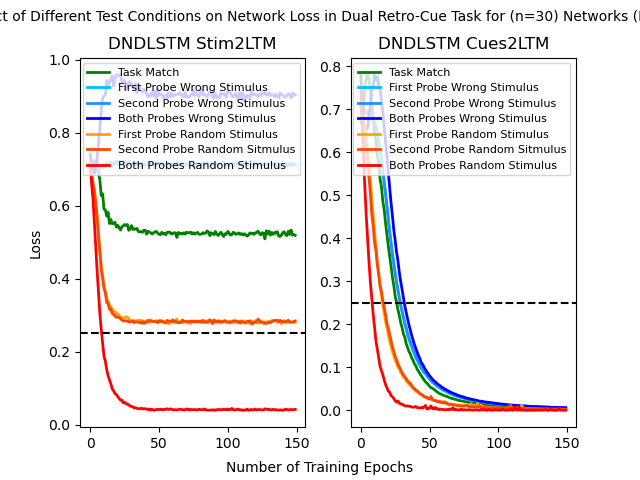

In [59]:
### Specific Plots for WMEM DRC Task ###

### DNDLSTM - Stim2LTM ###

mean_sample_loss_large_dndlstmcell_stimuli2ltm_drc_dict, sample_losses_large_dndlstmcell_stimuli2ltm_drc_dict = partition_sample_losses("dual_retro_cue", mean_sample_loss_large_dndlstmcell_stimuli2ltm_drc, sample_losses_large_dndlstmcell_stimuli2ltm_drc)

task0_mean_loss = mean_sample_loss_large_dndlstmcell_stimuli2ltm_drc_dict[0]
task1_mean_loss = mean_sample_loss_large_dndlstmcell_stimuli2ltm_drc_dict[1]
task2_mean_loss = mean_sample_loss_large_dndlstmcell_stimuli2ltm_drc_dict[2]
task3_mean_loss = mean_sample_loss_large_dndlstmcell_stimuli2ltm_drc_dict[3]
task4_mean_loss = mean_sample_loss_large_dndlstmcell_stimuli2ltm_drc_dict[4]
task5_mean_loss = mean_sample_loss_large_dndlstmcell_stimuli2ltm_drc_dict[5]
task6_mean_loss = mean_sample_loss_large_dndlstmcell_stimuli2ltm_drc_dict[6]
task7_mean_loss = mean_sample_loss_large_dndlstmcell_stimuli2ltm_drc_dict[7]
task8_mean_loss = mean_sample_loss_large_dndlstmcell_stimuli2ltm_drc_dict[8]
task9_mean_loss = mean_sample_loss_large_dndlstmcell_stimuli2ltm_drc_dict[9]
task10_mean_loss = mean_sample_loss_large_dndlstmcell_stimuli2ltm_drc_dict[10]
task11_mean_loss = mean_sample_loss_large_dndlstmcell_stimuli2ltm_drc_dict[11]
task12_mean_loss = mean_sample_loss_large_dndlstmcell_stimuli2ltm_drc_dict[12]
task13_mean_loss = mean_sample_loss_large_dndlstmcell_stimuli2ltm_drc_dict[13]
task14_mean_loss = mean_sample_loss_large_dndlstmcell_stimuli2ltm_drc_dict[14]
task15_mean_loss = mean_sample_loss_large_dndlstmcell_stimuli2ltm_drc_dict[15]
task16_mean_loss = mean_sample_loss_large_dndlstmcell_stimuli2ltm_drc_dict[16]
task17_mean_loss = mean_sample_loss_large_dndlstmcell_stimuli2ltm_drc_dict[17]
task18_mean_loss = mean_sample_loss_large_dndlstmcell_stimuli2ltm_drc_dict[18]
task19_mean_loss = mean_sample_loss_large_dndlstmcell_stimuli2ltm_drc_dict[19]
task20_mean_loss = mean_sample_loss_large_dndlstmcell_stimuli2ltm_drc_dict[20]
task21_mean_loss = mean_sample_loss_large_dndlstmcell_stimuli2ltm_drc_dict[21]
task22_mean_loss = mean_sample_loss_large_dndlstmcell_stimuli2ltm_drc_dict[22]
task23_mean_loss = mean_sample_loss_large_dndlstmcell_stimuli2ltm_drc_dict[23]
task24_mean_loss = mean_sample_loss_large_dndlstmcell_stimuli2ltm_drc_dict[24]
task25_mean_loss = mean_sample_loss_large_dndlstmcell_stimuli2ltm_drc_dict[25]
task26_mean_loss = mean_sample_loss_large_dndlstmcell_stimuli2ltm_drc_dict[26]
task27_mean_loss = mean_sample_loss_large_dndlstmcell_stimuli2ltm_drc_dict[27]

task0_sample_losses = sample_losses_large_dndlstmcell_stimuli2ltm_drc_dict[0]
task1_sample_losses = sample_losses_large_dndlstmcell_stimuli2ltm_drc_dict[1]
task2_sample_losses = sample_losses_large_dndlstmcell_stimuli2ltm_drc_dict[2]
task3_sample_losses = sample_losses_large_dndlstmcell_stimuli2ltm_drc_dict[3]
task4_sample_losses = sample_losses_large_dndlstmcell_stimuli2ltm_drc_dict[4]
task5_sample_losses = sample_losses_large_dndlstmcell_stimuli2ltm_drc_dict[5]
task6_sample_losses = sample_losses_large_dndlstmcell_stimuli2ltm_drc_dict[6]
task7_sample_losses = sample_losses_large_dndlstmcell_stimuli2ltm_drc_dict[7]
task8_sample_losses = sample_losses_large_dndlstmcell_stimuli2ltm_drc_dict[8]
task9_sample_losses = sample_losses_large_dndlstmcell_stimuli2ltm_drc_dict[9]
task10_sample_losses = sample_losses_large_dndlstmcell_stimuli2ltm_drc_dict[10]
task11_sample_losses = sample_losses_large_dndlstmcell_stimuli2ltm_drc_dict[11]
task12_sample_losses = sample_losses_large_dndlstmcell_stimuli2ltm_drc_dict[12]
task13_sample_losses = sample_losses_large_dndlstmcell_stimuli2ltm_drc_dict[13]
task14_sample_losses = sample_losses_large_dndlstmcell_stimuli2ltm_drc_dict[14]
task15_sample_losses = sample_losses_large_dndlstmcell_stimuli2ltm_drc_dict[15]
task16_sample_losses = sample_losses_large_dndlstmcell_stimuli2ltm_drc_dict[16]
task17_sample_losses = sample_losses_large_dndlstmcell_stimuli2ltm_drc_dict[17]
task18_sample_losses = sample_losses_large_dndlstmcell_stimuli2ltm_drc_dict[18]
task19_sample_losses = sample_losses_large_dndlstmcell_stimuli2ltm_drc_dict[19]
task20_sample_losses = sample_losses_large_dndlstmcell_stimuli2ltm_drc_dict[20]
task21_sample_losses = sample_losses_large_dndlstmcell_stimuli2ltm_drc_dict[21]
task22_sample_losses = sample_losses_large_dndlstmcell_stimuli2ltm_drc_dict[22]
task23_sample_losses = sample_losses_large_dndlstmcell_stimuli2ltm_drc_dict[23]
task24_sample_losses = sample_losses_large_dndlstmcell_stimuli2ltm_drc_dict[24]
task25_sample_losses = sample_losses_large_dndlstmcell_stimuli2ltm_drc_dict[25]
task26_sample_losses = sample_losses_large_dndlstmcell_stimuli2ltm_drc_dict[26]
task27_sample_losses = sample_losses_large_dndlstmcell_stimuli2ltm_drc_dict[27]

# testing different cases when the same cues are made before the probes (Vanilla Working Memory Case)
match_losses_same_cues = [task1_mean_loss, task3_mean_loss]
first_probe_wrong_stimuli_losses_same_cues = [task12_mean_loss, task14_mean_loss]
first_probe_random_stimuli_losses_same_cues = [task13_mean_loss, task15_mean_loss]
second_probe_wrong_stimuli_losses_same_cues = [task16_mean_loss, task18_mean_loss]
second_probe_random_stimuli_losses_same_cues = [task17_mean_loss, task19_mean_loss]
both_probes_wrong_stimuli_losses_same_cues = [task24_mean_loss, task26_mean_loss]
both_probes_random_stimuli_losses_same_cues = [task25_mean_loss, task27_mean_loss]


# testing different cases when a different second cue is made before the second probe (ASWM case)
match_losses_different_cues = [task0_mean_loss, task2_mean_loss]
first_probe_wrong_stimuli_losses_different_cues = [task4_mean_loss, task6_mean_loss]
first_probe_random_stimuli_losses_different_cues = [task5_mean_loss, task7_mean_loss]
second_probe_wrong_stimuli_losses_different_cues = [task8_mean_loss, task10_mean_loss]
second_probe_random_stimuli_losses_different_cues = [task9_mean_loss, task11_mean_loss]
both_probes_wrong_stimuli_losses_different_cues = [task20_mean_loss, task22_mean_loss]
both_probes_random_stimuli_losses_different_cues = [task21_mean_loss, task23_mean_loss]

# get the mean losses for each of these 7 categories

match_losses_large_dndlstmcell_stimuli2ltm = match_losses_same_cues + match_losses_different_cues
first_probe_wrong_stimuli_losses_large_dndlstmcell_stimuli2ltm = first_probe_wrong_stimuli_losses_same_cues + first_probe_wrong_stimuli_losses_different_cues
first_probe_random_stimuli_losses_large_dndlstmcell_stimuli2ltm = first_probe_random_stimuli_losses_same_cues + first_probe_random_stimuli_losses_different_cues
second_probe_wrong_stimuli_losses_large_dndlstmcell_stimuli2ltm = second_probe_wrong_stimuli_losses_same_cues + second_probe_wrong_stimuli_losses_different_cues
second_probe_random_stimuli_losses_large_dndlstmcell_stimuli2ltm = second_probe_random_stimuli_losses_same_cues + second_probe_random_stimuli_losses_different_cues
both_probes_wrong_stimuli_losses_large_dndlstmcell_stimuli2ltm = both_probes_wrong_stimuli_losses_same_cues + both_probes_wrong_stimuli_losses_different_cues
both_probes_random_stimuli_losses_large_dndlstmcell_stimuli2ltm = both_probes_random_stimuli_losses_same_cues + both_probes_random_stimuli_losses_different_cues


match_mean_losses_large_dndlstmcell_stimuli2ltm = np.mean(match_losses_large_dndlstmcell_stimuli2ltm, axis=0)
first_probe_wrong_stimuli_mean_losses_large_dndlstmcell_stimuli2ltm = np.mean(first_probe_wrong_stimuli_losses_large_dndlstmcell_stimuli2ltm, axis=0)
first_probe_random_stimuli_mean_losses_large_dndlstmcell_stimuli2ltm = np.mean(first_probe_random_stimuli_losses_large_dndlstmcell_stimuli2ltm, axis=0)
second_probe_wrong_stimuli_mean_losses_large_dndlstmcell_stimuli2ltm = np.mean(second_probe_wrong_stimuli_losses_large_dndlstmcell_stimuli2ltm, axis=0)
second_probe_random_stimuli_mean_losses_large_dndlstmcell_stimuli2ltm = np.mean(second_probe_random_stimuli_losses_large_dndlstmcell_stimuli2ltm, axis=0)
both_probes_wrong_stimuli_mean_losses_large_dndlstmcell_stimuli2ltm = np.mean(both_probes_wrong_stimuli_losses_large_dndlstmcell_stimuli2ltm, axis=0)
both_probes_random_stimuli_mean_losses_large_dndlstmcell_stimuli2ltm = np.mean(both_probes_random_stimuli_losses_large_dndlstmcell_stimuli2ltm, axis=0)

### Specific Plots for WMEM DRC Task ###

### DNDLSTM - Cues2LTM ###

mean_sample_loss_large_dndlstmcell_cues2ltm_drc_dict, sample_losses_large_dndlstmcell_cues2ltm_drc_dict = partition_sample_losses("dual_retro_cue", mean_sample_loss_large_dndlstmcell_cues2ltm_drc, sample_losses_large_dndlstmcell_cues2ltm_drc)

task0_mean_loss = mean_sample_loss_large_dndlstmcell_cues2ltm_drc_dict[0]
task1_mean_loss = mean_sample_loss_large_dndlstmcell_cues2ltm_drc_dict[1]
task2_mean_loss = mean_sample_loss_large_dndlstmcell_cues2ltm_drc_dict[2]
task3_mean_loss = mean_sample_loss_large_dndlstmcell_cues2ltm_drc_dict[3]
task4_mean_loss = mean_sample_loss_large_dndlstmcell_cues2ltm_drc_dict[4]
task5_mean_loss = mean_sample_loss_large_dndlstmcell_cues2ltm_drc_dict[5]
task6_mean_loss = mean_sample_loss_large_dndlstmcell_cues2ltm_drc_dict[6]
task7_mean_loss = mean_sample_loss_large_dndlstmcell_cues2ltm_drc_dict[7]
task8_mean_loss = mean_sample_loss_large_dndlstmcell_cues2ltm_drc_dict[8]
task9_mean_loss = mean_sample_loss_large_dndlstmcell_cues2ltm_drc_dict[9]
task10_mean_loss = mean_sample_loss_large_dndlstmcell_cues2ltm_drc_dict[10]
task11_mean_loss = mean_sample_loss_large_dndlstmcell_cues2ltm_drc_dict[11]
task12_mean_loss = mean_sample_loss_large_dndlstmcell_cues2ltm_drc_dict[12]
task13_mean_loss = mean_sample_loss_large_dndlstmcell_cues2ltm_drc_dict[13]
task14_mean_loss = mean_sample_loss_large_dndlstmcell_cues2ltm_drc_dict[14]
task15_mean_loss = mean_sample_loss_large_dndlstmcell_cues2ltm_drc_dict[15]
task16_mean_loss = mean_sample_loss_large_dndlstmcell_cues2ltm_drc_dict[16]
task17_mean_loss = mean_sample_loss_large_dndlstmcell_cues2ltm_drc_dict[17]
task18_mean_loss = mean_sample_loss_large_dndlstmcell_cues2ltm_drc_dict[18]
task19_mean_loss = mean_sample_loss_large_dndlstmcell_cues2ltm_drc_dict[19]
task20_mean_loss = mean_sample_loss_large_dndlstmcell_cues2ltm_drc_dict[20]
task21_mean_loss = mean_sample_loss_large_dndlstmcell_cues2ltm_drc_dict[21]
task22_mean_loss = mean_sample_loss_large_dndlstmcell_cues2ltm_drc_dict[22]
task23_mean_loss = mean_sample_loss_large_dndlstmcell_cues2ltm_drc_dict[23]
task24_mean_loss = mean_sample_loss_large_dndlstmcell_cues2ltm_drc_dict[24]
task25_mean_loss = mean_sample_loss_large_dndlstmcell_cues2ltm_drc_dict[25]
task26_mean_loss = mean_sample_loss_large_dndlstmcell_cues2ltm_drc_dict[26]
task27_mean_loss = mean_sample_loss_large_dndlstmcell_cues2ltm_drc_dict[27]

task0_sample_losses = sample_losses_large_dndlstmcell_cues2ltm_drc_dict[0]
task1_sample_losses = sample_losses_large_dndlstmcell_cues2ltm_drc_dict[1]
task2_sample_losses = sample_losses_large_dndlstmcell_cues2ltm_drc_dict[2]
task3_sample_losses = sample_losses_large_dndlstmcell_cues2ltm_drc_dict[3]
task4_sample_losses = sample_losses_large_dndlstmcell_cues2ltm_drc_dict[4]
task5_sample_losses = sample_losses_large_dndlstmcell_cues2ltm_drc_dict[5]
task6_sample_losses = sample_losses_large_dndlstmcell_cues2ltm_drc_dict[6]
task7_sample_losses = sample_losses_large_dndlstmcell_cues2ltm_drc_dict[7]
task8_sample_losses = sample_losses_large_dndlstmcell_cues2ltm_drc_dict[8]
task9_sample_losses = sample_losses_large_dndlstmcell_cues2ltm_drc_dict[9]
task10_sample_losses = sample_losses_large_dndlstmcell_cues2ltm_drc_dict[10]
task11_sample_losses = sample_losses_large_dndlstmcell_cues2ltm_drc_dict[11]
task12_sample_losses = sample_losses_large_dndlstmcell_cues2ltm_drc_dict[12]
task13_sample_losses = sample_losses_large_dndlstmcell_cues2ltm_drc_dict[13]
task14_sample_losses = sample_losses_large_dndlstmcell_cues2ltm_drc_dict[14]
task15_sample_losses = sample_losses_large_dndlstmcell_cues2ltm_drc_dict[15]
task16_sample_losses = sample_losses_large_dndlstmcell_cues2ltm_drc_dict[16]
task17_sample_losses = sample_losses_large_dndlstmcell_cues2ltm_drc_dict[17]
task18_sample_losses = sample_losses_large_dndlstmcell_cues2ltm_drc_dict[18]
task19_sample_losses = sample_losses_large_dndlstmcell_cues2ltm_drc_dict[19]
task20_sample_losses = sample_losses_large_dndlstmcell_cues2ltm_drc_dict[20]
task21_sample_losses = sample_losses_large_dndlstmcell_cues2ltm_drc_dict[21]
task22_sample_losses = sample_losses_large_dndlstmcell_cues2ltm_drc_dict[22]
task23_sample_losses = sample_losses_large_dndlstmcell_cues2ltm_drc_dict[23]
task24_sample_losses = sample_losses_large_dndlstmcell_cues2ltm_drc_dict[24]
task25_sample_losses = sample_losses_large_dndlstmcell_cues2ltm_drc_dict[25]
task26_sample_losses = sample_losses_large_dndlstmcell_cues2ltm_drc_dict[26]
task27_sample_losses = sample_losses_large_dndlstmcell_cues2ltm_drc_dict[27]

# testing different cases when the same cues are made before the probes (Vanilla Working Memory Case)
match_losses_same_cues = [task1_mean_loss, task3_mean_loss]
first_probe_wrong_stimuli_losses_same_cues = [task12_mean_loss, task14_mean_loss]
first_probe_random_stimuli_losses_same_cues = [task13_mean_loss, task15_mean_loss]
second_probe_wrong_stimuli_losses_same_cues = [task16_mean_loss, task18_mean_loss]
second_probe_random_stimuli_losses_same_cues = [task17_mean_loss, task19_mean_loss]
both_probes_wrong_stimuli_losses_same_cues = [task24_mean_loss, task26_mean_loss]
both_probes_random_stimuli_losses_same_cues = [task25_mean_loss, task27_mean_loss]


# testing different cases when a different second cue is made before the second probe (ASWM case)
match_losses_different_cues = [task0_mean_loss, task2_mean_loss]
first_probe_wrong_stimuli_losses_different_cues = [task4_mean_loss, task6_mean_loss]
first_probe_random_stimuli_losses_different_cues = [task5_mean_loss, task7_mean_loss]
second_probe_wrong_stimuli_losses_different_cues = [task8_mean_loss, task10_mean_loss]
second_probe_random_stimuli_losses_different_cues = [task9_mean_loss, task11_mean_loss]
both_probes_wrong_stimuli_losses_different_cues = [task20_mean_loss, task22_mean_loss]
both_probes_random_stimuli_losses_different_cues = [task21_mean_loss, task23_mean_loss]

# get the mean losses for each of these 7 categories

match_losses_large_dndlstmcell_cues2ltm = match_losses_same_cues + match_losses_different_cues
first_probe_wrong_stimuli_losses_large_dndlstmcell_cues2ltm = first_probe_wrong_stimuli_losses_same_cues + first_probe_wrong_stimuli_losses_different_cues
first_probe_random_stimuli_losses_large_dndlstmcell_cues2ltm = first_probe_random_stimuli_losses_same_cues + first_probe_random_stimuli_losses_different_cues
second_probe_wrong_stimuli_losses_large_dndlstmcell_cues2ltm = second_probe_wrong_stimuli_losses_same_cues + second_probe_wrong_stimuli_losses_different_cues
second_probe_random_stimuli_losses_large_dndlstmcell_cues2ltm = second_probe_random_stimuli_losses_same_cues + second_probe_random_stimuli_losses_different_cues
both_probes_wrong_stimuli_losses_large_dndlstmcell_cues2ltm = both_probes_wrong_stimuli_losses_same_cues + both_probes_wrong_stimuli_losses_different_cues
both_probes_random_stimuli_losses_large_dndlstmcell_cues2ltm = both_probes_random_stimuli_losses_same_cues + both_probes_random_stimuli_losses_different_cues


match_mean_losses_large_dndlstmcell_cues2ltm = np.mean(match_losses_large_dndlstmcell_cues2ltm, axis=0)
first_probe_wrong_stimuli_mean_losses_large_dndlstmcell_cues2ltm = np.mean(first_probe_wrong_stimuli_losses_large_dndlstmcell_cues2ltm, axis=0)
first_probe_random_stimuli_mean_losses_large_dndlstmcell_cues2ltm = np.mean(first_probe_random_stimuli_losses_large_dndlstmcell_cues2ltm, axis=0)
second_probe_wrong_stimuli_mean_losses_large_dndlstmcell_cues2ltm = np.mean(second_probe_wrong_stimuli_losses_large_dndlstmcell_cues2ltm, axis=0)
second_probe_random_stimuli_mean_losses_large_dndlstmcell_cues2ltm = np.mean(second_probe_random_stimuli_losses_large_dndlstmcell_cues2ltm, axis=0)
both_probes_wrong_stimuli_mean_losses_large_dndlstmcell_cues2ltm = np.mean(both_probes_wrong_stimuli_losses_large_dndlstmcell_cues2ltm, axis=0)
both_probes_random_stimuli_mean_losses_large_dndlstmcell_cues2ltm = np.mean(both_probes_random_stimuli_losses_large_dndlstmcell_cues2ltm, axis=0)


fig, ax = plt.subplots(1,2)

# plot losses
fig.suptitle("Average Effect of Different Test Conditions on Network Loss in Dual Retro-Cue Task for (n=" + str(num_networks) + ") Networks (Large Delays)", fontsize=10)

# Individual losses for each sample type (where the same stimulus is cued each round)
ax[0].set_title("DNDLSTM Stim2LTM")
ax[0].plot(match_mean_losses_large_dndlstmcell_stimuli2ltm, color='green', label="Task Match", linewidth=2)
ax[0].plot(first_probe_wrong_stimuli_mean_losses_large_dndlstmcell_stimuli2ltm, color='deepskyblue', label="First Probe Wrong Stimulus", linewidth=2)
ax[0].plot(second_probe_wrong_stimuli_mean_losses_large_dndlstmcell_stimuli2ltm, color='dodgerblue', label="Second Probe Wrong Stimulus", linewidth=2)
ax[0].plot(both_probes_wrong_stimuli_mean_losses_large_dndlstmcell_stimuli2ltm, color='blue', label="Both Probes Wrong Stimulus", linewidth=2)
ax[0].plot(first_probe_random_stimuli_mean_losses_large_dndlstmcell_stimuli2ltm, color='orange', label="First Probe Random Stimulus", linewidth=2)
ax[0].plot(second_probe_random_stimuli_mean_losses_large_dndlstmcell_stimuli2ltm, color='orangered', label="Second Probe Random Sitmulus", linewidth=2)
ax[0].plot(both_probes_random_stimuli_mean_losses_large_dndlstmcell_stimuli2ltm, color='red', label="Both Probes Random Stimulus", linewidth=2)

# Individual losses for each sample type (where a different stimulus is cued each round)
ax[1].set_title("DNDLSTM Cues2LTM")
ax[1].plot(match_mean_losses_large_dndlstmcell_cues2ltm, color='green', label="Task Match", linewidth=2)
ax[1].plot(first_probe_wrong_stimuli_mean_losses_large_dndlstmcell_cues2ltm, color='deepskyblue', label="First Probe Wrong Stimulus", linewidth=2)
ax[1].plot(second_probe_wrong_stimuli_mean_losses_large_dndlstmcell_cues2ltm, color='dodgerblue', label="Second Probe Wrong Stimulus", linewidth=2)
ax[1].plot(both_probes_wrong_stimuli_mean_losses_large_dndlstmcell_cues2ltm, color='blue', label="Both Probes Wrong Stimulus", linewidth=2)
ax[1].plot(first_probe_random_stimuli_mean_losses_large_dndlstmcell_cues2ltm, color='orange', label="First Probe Random Stimulus", linewidth=2)
ax[1].plot(second_probe_random_stimuli_mean_losses_large_dndlstmcell_cues2ltm, color='orangered', label="Second Probe Random Sitmulus", linewidth=2)
ax[1].plot(both_probes_random_stimuli_mean_losses_large_dndlstmcell_cues2ltm, color='red', label="Both Probes Random Stimulus", linewidth=2)

# Threshold line
ax[0].axhline(threshold, linestyle='dashed', color='black')
ax[1].axhline(threshold, linestyle='dashed', color='black')

# legend and show plot
ax[0].legend(fontsize=8, loc="upper right") # by default, the legend ignores all elements without a label attribute set.
ax[1].legend(fontsize=8, loc="upper right") # by default, the legend ignores all elements without a label attribute set.

fig.supxlabel('Number of Training Epochs', fontsize=10) # x label
ax[0].set_ylabel('Loss', fontsize=10) # y label

plt.show()

#### *Graph on Each Trial Type for Memory Augmented LSTMs on the Dual Retro-Cue Task (Both Delays)*

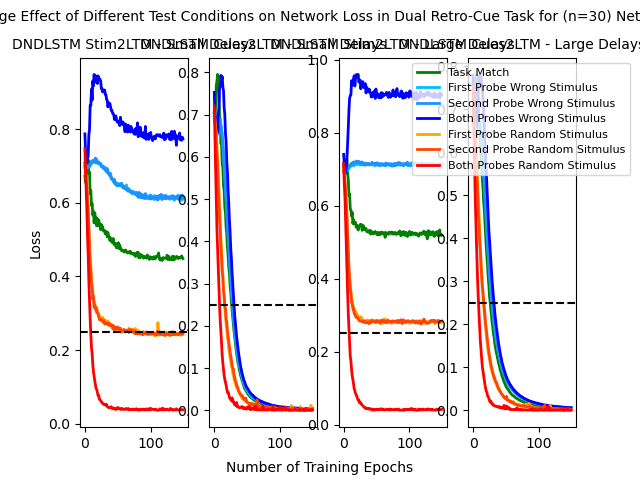

In [60]:
fig, ax = plt.subplots(1,4)

# plot losses
fig.suptitle("Average Effect of Different Test Conditions on Network Loss in Dual Retro-Cue Task for (n=" + str(num_networks) + ") Networks", fontsize=10)

# Individual losses for each sample type (where the same stimulus is cued each round)
ax[0].set_title("DNDLSTM Stim2LTM - Small Delays", fontsize=10)
ax[0].plot(match_mean_losses_small_dndlstmcell_stimuli2ltm, color='green', label="Task Match", linewidth=2)
ax[0].plot(first_probe_wrong_stimuli_mean_losses_small_dndlstmcell_stimuli2ltm, color='deepskyblue', label="First Probe Wrong Stimulus", linewidth=2)
ax[0].plot(second_probe_wrong_stimuli_mean_losses_small_dndlstmcell_stimuli2ltm, color='dodgerblue', label="Second Probe Wrong Stimulus", linewidth=2)
ax[0].plot(both_probes_wrong_stimuli_mean_losses_small_dndlstmcell_stimuli2ltm, color='blue', label="Both Probes Wrong Stimulus", linewidth=2)
ax[0].plot(first_probe_random_stimuli_mean_losses_small_dndlstmcell_stimuli2ltm, color='orange', label="First Probe Random Stimulus", linewidth=2)
ax[0].plot(second_probe_random_stimuli_mean_losses_small_dndlstmcell_stimuli2ltm, color='orangered', label="Second Probe Random Sitmulus", linewidth=2)
ax[0].plot(both_probes_random_stimuli_mean_losses_small_dndlstmcell_stimuli2ltm, color='red', label="Both Probes Random Stimulus", linewidth=2)

# Individual losses for each sample type (where a different stimulus is cued each round)
ax[1].set_title("DNDLSTM Cues2LTM - Small Delays", fontsize=10)
ax[1].plot(match_mean_losses_small_dndlstmcell_cues2ltm, color='green', label="Task Match", linewidth=2)
ax[1].plot(first_probe_wrong_stimuli_mean_losses_small_dndlstmcell_cues2ltm, color='deepskyblue', label="First Probe Wrong Stimulus", linewidth=2)
ax[1].plot(second_probe_wrong_stimuli_mean_losses_small_dndlstmcell_cues2ltm, color='dodgerblue', label="Second Probe Wrong Stimulus", linewidth=2)
ax[1].plot(both_probes_wrong_stimuli_mean_losses_small_dndlstmcell_cues2ltm, color='blue', label="Both Probes Wrong Stimulus", linewidth=2)
ax[1].plot(first_probe_random_stimuli_mean_losses_small_dndlstmcell_cues2ltm, color='orange', label="First Probe Random Stimulus", linewidth=2)
ax[1].plot(second_probe_random_stimuli_mean_losses_small_dndlstmcell_cues2ltm, color='orangered', label="Second Probe Random Sitmulus", linewidth=2)
ax[1].plot(both_probes_random_stimuli_mean_losses_small_dndlstmcell_cues2ltm, color='red', label="Both Probes Random Stimulus", linewidth=2)

# Individual losses for each sample type (where the same stimulus is cued each round)
ax[2].set_title("DNDLSTM Stim2LTM - Large Delays", fontsize=10)
ax[2].plot(match_mean_losses_large_dndlstmcell_stimuli2ltm, color='green', label="Task Match", linewidth=2)
ax[2].plot(first_probe_wrong_stimuli_mean_losses_large_dndlstmcell_stimuli2ltm, color='deepskyblue', label="First Probe Wrong Stimulus", linewidth=2)
ax[2].plot(second_probe_wrong_stimuli_mean_losses_large_dndlstmcell_stimuli2ltm, color='dodgerblue', label="Second Probe Wrong Stimulus", linewidth=2)
ax[2].plot(both_probes_wrong_stimuli_mean_losses_large_dndlstmcell_stimuli2ltm, color='blue', label="Both Probes Wrong Stimulus", linewidth=2)
ax[2].plot(first_probe_random_stimuli_mean_losses_large_dndlstmcell_stimuli2ltm, color='orange', label="First Probe Random Stimulus", linewidth=2)
ax[2].plot(second_probe_random_stimuli_mean_losses_large_dndlstmcell_stimuli2ltm, color='orangered', label="Second Probe Random Sitmulus", linewidth=2)
ax[2].plot(both_probes_random_stimuli_mean_losses_large_dndlstmcell_stimuli2ltm, color='red', label="Both Probes Random Stimulus", linewidth=2)

# Individual losses for each sample type (where a different stimulus is cued each round)
ax[3].set_title("DNDLSTM Cues2LTM - Large Delays", fontsize=10)
ax[3].plot(match_mean_losses_large_dndlstmcell_cues2ltm, color='green', label="Task Match", linewidth=2)
ax[3].plot(first_probe_wrong_stimuli_mean_losses_large_dndlstmcell_cues2ltm, color='deepskyblue', label="First Probe Wrong Stimulus", linewidth=2)
ax[3].plot(second_probe_wrong_stimuli_mean_losses_large_dndlstmcell_cues2ltm, color='dodgerblue', label="Second Probe Wrong Stimulus", linewidth=2)
ax[3].plot(both_probes_wrong_stimuli_mean_losses_large_dndlstmcell_cues2ltm, color='blue', label="Both Probes Wrong Stimulus", linewidth=2)
ax[3].plot(first_probe_random_stimuli_mean_losses_large_dndlstmcell_cues2ltm, color='orange', label="First Probe Random Stimulus", linewidth=2)
ax[3].plot(second_probe_random_stimuli_mean_losses_large_dndlstmcell_cues2ltm, color='orangered', label="Second Probe Random Sitmulus", linewidth=2)
ax[3].plot(both_probes_random_stimuli_mean_losses_large_dndlstmcell_cues2ltm, color='red', label="Both Probes Random Stimulus", linewidth=2)

# Threshold line
ax[0].axhline(threshold, linestyle='dashed', color='black')
ax[1].axhline(threshold, linestyle='dashed', color='black')
ax[2].axhline(threshold, linestyle='dashed', color='black')
ax[3].axhline(threshold, linestyle='dashed', color='black')

# legend and show plot
ax[3].legend(fontsize=8, bbox_to_anchor=(1.55, 1), loc="upper right") # by default, the legend ignores all elements without a label attribute set.

fig.supxlabel('Number of Training Epochs', fontsize=10) # x label
ax[0].set_ylabel('Loss', fontsize=10) # y label

plt.show()

#### *Graph on Summaries of Each Trial Type for Memory Augmented LSTMs on the Dual Retro-Cue Task (Small Delays)*

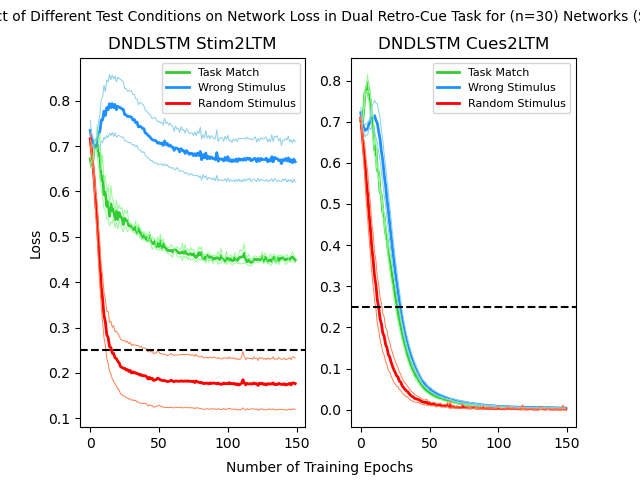

In [61]:
### Specific Plots for WMEM DRC Task ###

### DNDLSTM Stim2LTM ###

mean_sample_loss_small_dndlstmcell_stimuli2ltm_drc_dict, sample_losses_small_dndlstmcell_stimuli2ltm_drc_dict = partition_sample_losses("dual_retro_cue", mean_sample_loss_small_dndlstmcell_stimuli2ltm_drc, sample_losses_small_dndlstmcell_stimuli2ltm_drc)

task0_mean_loss = mean_sample_loss_small_dndlstmcell_stimuli2ltm_drc_dict[0]
task1_mean_loss = mean_sample_loss_small_dndlstmcell_stimuli2ltm_drc_dict[1]
task2_mean_loss = mean_sample_loss_small_dndlstmcell_stimuli2ltm_drc_dict[2]
task3_mean_loss = mean_sample_loss_small_dndlstmcell_stimuli2ltm_drc_dict[3]
task4_mean_loss = mean_sample_loss_small_dndlstmcell_stimuli2ltm_drc_dict[4]
task5_mean_loss = mean_sample_loss_small_dndlstmcell_stimuli2ltm_drc_dict[5]
task6_mean_loss = mean_sample_loss_small_dndlstmcell_stimuli2ltm_drc_dict[6]
task7_mean_loss = mean_sample_loss_small_dndlstmcell_stimuli2ltm_drc_dict[7]
task8_mean_loss = mean_sample_loss_small_dndlstmcell_stimuli2ltm_drc_dict[8]
task9_mean_loss = mean_sample_loss_small_dndlstmcell_stimuli2ltm_drc_dict[9]
task10_mean_loss = mean_sample_loss_small_dndlstmcell_stimuli2ltm_drc_dict[10]
task11_mean_loss = mean_sample_loss_small_dndlstmcell_stimuli2ltm_drc_dict[11]
task12_mean_loss = mean_sample_loss_small_dndlstmcell_stimuli2ltm_drc_dict[12]
task13_mean_loss = mean_sample_loss_small_dndlstmcell_stimuli2ltm_drc_dict[13]
task14_mean_loss = mean_sample_loss_small_dndlstmcell_stimuli2ltm_drc_dict[14]
task15_mean_loss = mean_sample_loss_small_dndlstmcell_stimuli2ltm_drc_dict[15]
task16_mean_loss = mean_sample_loss_small_dndlstmcell_stimuli2ltm_drc_dict[16]
task17_mean_loss = mean_sample_loss_small_dndlstmcell_stimuli2ltm_drc_dict[17]
task18_mean_loss = mean_sample_loss_small_dndlstmcell_stimuli2ltm_drc_dict[18]
task19_mean_loss = mean_sample_loss_small_dndlstmcell_stimuli2ltm_drc_dict[19]
task20_mean_loss = mean_sample_loss_small_dndlstmcell_stimuli2ltm_drc_dict[20]
task21_mean_loss = mean_sample_loss_small_dndlstmcell_stimuli2ltm_drc_dict[21]
task22_mean_loss = mean_sample_loss_small_dndlstmcell_stimuli2ltm_drc_dict[22]
task23_mean_loss = mean_sample_loss_small_dndlstmcell_stimuli2ltm_drc_dict[23]
task24_mean_loss = mean_sample_loss_small_dndlstmcell_stimuli2ltm_drc_dict[24]
task25_mean_loss = mean_sample_loss_small_dndlstmcell_stimuli2ltm_drc_dict[25]
task26_mean_loss = mean_sample_loss_small_dndlstmcell_stimuli2ltm_drc_dict[26]
task27_mean_loss = mean_sample_loss_small_dndlstmcell_stimuli2ltm_drc_dict[27]

task0_sample_losses = sample_losses_small_dndlstmcell_stimuli2ltm_drc_dict[0]
task1_sample_losses = sample_losses_small_dndlstmcell_stimuli2ltm_drc_dict[1]
task2_sample_losses = sample_losses_small_dndlstmcell_stimuli2ltm_drc_dict[2]
task3_sample_losses = sample_losses_small_dndlstmcell_stimuli2ltm_drc_dict[3]
task4_sample_losses = sample_losses_small_dndlstmcell_stimuli2ltm_drc_dict[4]
task5_sample_losses = sample_losses_small_dndlstmcell_stimuli2ltm_drc_dict[5]
task6_sample_losses = sample_losses_small_dndlstmcell_stimuli2ltm_drc_dict[6]
task7_sample_losses = sample_losses_small_dndlstmcell_stimuli2ltm_drc_dict[7]
task8_sample_losses = sample_losses_small_dndlstmcell_stimuli2ltm_drc_dict[8]
task9_sample_losses = sample_losses_small_dndlstmcell_stimuli2ltm_drc_dict[9]
task10_sample_losses = sample_losses_small_dndlstmcell_stimuli2ltm_drc_dict[10]
task11_sample_losses = sample_losses_small_dndlstmcell_stimuli2ltm_drc_dict[11]
task12_sample_losses = sample_losses_small_dndlstmcell_stimuli2ltm_drc_dict[12]
task13_sample_losses = sample_losses_small_dndlstmcell_stimuli2ltm_drc_dict[13]
task14_sample_losses = sample_losses_small_dndlstmcell_stimuli2ltm_drc_dict[14]
task15_sample_losses = sample_losses_small_dndlstmcell_stimuli2ltm_drc_dict[15]
task16_sample_losses = sample_losses_small_dndlstmcell_stimuli2ltm_drc_dict[16]
task17_sample_losses = sample_losses_small_dndlstmcell_stimuli2ltm_drc_dict[17]
task18_sample_losses = sample_losses_small_dndlstmcell_stimuli2ltm_drc_dict[18]
task19_sample_losses = sample_losses_small_dndlstmcell_stimuli2ltm_drc_dict[19]
task20_sample_losses = sample_losses_small_dndlstmcell_stimuli2ltm_drc_dict[20]
task21_sample_losses = sample_losses_small_dndlstmcell_stimuli2ltm_drc_dict[21]
task22_sample_losses = sample_losses_small_dndlstmcell_stimuli2ltm_drc_dict[22]
task23_sample_losses = sample_losses_small_dndlstmcell_stimuli2ltm_drc_dict[23]
task24_sample_losses = sample_losses_small_dndlstmcell_stimuli2ltm_drc_dict[24]
task25_sample_losses = sample_losses_small_dndlstmcell_stimuli2ltm_drc_dict[25]
task26_sample_losses = sample_losses_small_dndlstmcell_stimuli2ltm_drc_dict[26]
task27_sample_losses = sample_losses_small_dndlstmcell_stimuli2ltm_drc_dict[27]

# testing different cases when the same cues are made before the probes (Vanilla Working Memory Case)
match_losses_same_cues = [task1_mean_loss, task3_mean_loss]
first_probe_wrong_stimuli_losses_same_cues = [task12_mean_loss, task14_mean_loss]
first_probe_random_stimuli_losses_same_cues = [task13_mean_loss, task15_mean_loss]
second_probe_wrong_stimuli_losses_same_cues = [task16_mean_loss, task18_mean_loss]
second_probe_random_stimuli_losses_same_cues = [task17_mean_loss, task19_mean_loss]
both_probes_wrong_stimuli_losses_same_cues = [task24_mean_loss, task26_mean_loss]
both_probes_random_stimuli_losses_same_cues = [task25_mean_loss, task27_mean_loss]


# testing different cases when a different second cue is made before the second probe (ASWM case)
match_losses_different_cues = [task0_mean_loss, task2_mean_loss]
first_probe_wrong_stimuli_losses_different_cues = [task4_mean_loss, task6_mean_loss]
first_probe_random_stimuli_losses_different_cues = [task5_mean_loss, task7_mean_loss]
second_probe_wrong_stimuli_losses_different_cues = [task8_mean_loss, task10_mean_loss]
second_probe_random_stimuli_losses_different_cues = [task9_mean_loss, task11_mean_loss]
both_probes_wrong_stimuli_losses_different_cues = [task20_mean_loss, task22_mean_loss]
both_probes_random_stimuli_losses_different_cues = [task21_mean_loss, task23_mean_loss]


# get the mean losses for each of these 3 larger categories

match_losses_small_dndlstmcell_stimuli2ltm = match_losses_same_cues + match_losses_different_cues
wrong_stimuli_losses_small_dndlstmcell_stimuli2ltm = first_probe_wrong_stimuli_losses_same_cues + second_probe_wrong_stimuli_losses_same_cues + both_probes_wrong_stimuli_losses_same_cues + first_probe_wrong_stimuli_losses_different_cues + second_probe_wrong_stimuli_losses_different_cues + both_probes_wrong_stimuli_losses_different_cues
random_stimuli_losses_small_dndlstmcell_stimuli2ltm = first_probe_random_stimuli_losses_same_cues + second_probe_random_stimuli_losses_same_cues + both_probes_random_stimuli_losses_same_cues + first_probe_random_stimuli_losses_different_cues + second_probe_random_stimuli_losses_different_cues + both_probes_random_stimuli_losses_different_cues

match_mean_losses_small_dndlstmcell_stimuli2ltm = np.mean(match_losses_small_dndlstmcell_stimuli2ltm, axis=0)
wrong_stimuli_mean_losses_small_dndlstmcell_stimuli2ltm = np.mean(wrong_stimuli_losses_small_dndlstmcell_stimuli2ltm, axis=0)
random_stimuli_mean_losses_small_dndlstmcell_stimuli2ltm = np.mean(random_stimuli_losses_small_dndlstmcell_stimuli2ltm, axis=0)

### Specific Plots for WMEM DRC Task ###

### DNDLSTM Cues2LTM ###

mean_sample_loss_small_dndlstmcell_cues2ltm_drc_dict, sample_losses_small_dndlstmcell_cues2ltm_drc_dict = partition_sample_losses("dual_retro_cue", mean_sample_loss_small_dndlstmcell_cues2ltm_drc, sample_losses_small_dndlstmcell_cues2ltm_drc)

task0_mean_loss = mean_sample_loss_small_dndlstmcell_cues2ltm_drc_dict[0]
task1_mean_loss = mean_sample_loss_small_dndlstmcell_cues2ltm_drc_dict[1]
task2_mean_loss = mean_sample_loss_small_dndlstmcell_cues2ltm_drc_dict[2]
task3_mean_loss = mean_sample_loss_small_dndlstmcell_cues2ltm_drc_dict[3]
task4_mean_loss = mean_sample_loss_small_dndlstmcell_cues2ltm_drc_dict[4]
task5_mean_loss = mean_sample_loss_small_dndlstmcell_cues2ltm_drc_dict[5]
task6_mean_loss = mean_sample_loss_small_dndlstmcell_cues2ltm_drc_dict[6]
task7_mean_loss = mean_sample_loss_small_dndlstmcell_cues2ltm_drc_dict[7]
task8_mean_loss = mean_sample_loss_small_dndlstmcell_cues2ltm_drc_dict[8]
task9_mean_loss = mean_sample_loss_small_dndlstmcell_cues2ltm_drc_dict[9]
task10_mean_loss = mean_sample_loss_small_dndlstmcell_cues2ltm_drc_dict[10]
task11_mean_loss = mean_sample_loss_small_dndlstmcell_cues2ltm_drc_dict[11]
task12_mean_loss = mean_sample_loss_small_dndlstmcell_cues2ltm_drc_dict[12]
task13_mean_loss = mean_sample_loss_small_dndlstmcell_cues2ltm_drc_dict[13]
task14_mean_loss = mean_sample_loss_small_dndlstmcell_cues2ltm_drc_dict[14]
task15_mean_loss = mean_sample_loss_small_dndlstmcell_cues2ltm_drc_dict[15]
task16_mean_loss = mean_sample_loss_small_dndlstmcell_cues2ltm_drc_dict[16]
task17_mean_loss = mean_sample_loss_small_dndlstmcell_cues2ltm_drc_dict[17]
task18_mean_loss = mean_sample_loss_small_dndlstmcell_cues2ltm_drc_dict[18]
task19_mean_loss = mean_sample_loss_small_dndlstmcell_cues2ltm_drc_dict[19]
task20_mean_loss = mean_sample_loss_small_dndlstmcell_cues2ltm_drc_dict[20]
task21_mean_loss = mean_sample_loss_small_dndlstmcell_cues2ltm_drc_dict[21]
task22_mean_loss = mean_sample_loss_small_dndlstmcell_cues2ltm_drc_dict[22]
task23_mean_loss = mean_sample_loss_small_dndlstmcell_cues2ltm_drc_dict[23]
task24_mean_loss = mean_sample_loss_small_dndlstmcell_cues2ltm_drc_dict[24]
task25_mean_loss = mean_sample_loss_small_dndlstmcell_cues2ltm_drc_dict[25]
task26_mean_loss = mean_sample_loss_small_dndlstmcell_cues2ltm_drc_dict[26]
task27_mean_loss = mean_sample_loss_small_dndlstmcell_cues2ltm_drc_dict[27]

task0_sample_losses = sample_losses_small_dndlstmcell_cues2ltm_drc_dict[0]
task1_sample_losses = sample_losses_small_dndlstmcell_cues2ltm_drc_dict[1]
task2_sample_losses = sample_losses_small_dndlstmcell_cues2ltm_drc_dict[2]
task3_sample_losses = sample_losses_small_dndlstmcell_cues2ltm_drc_dict[3]
task4_sample_losses = sample_losses_small_dndlstmcell_cues2ltm_drc_dict[4]
task5_sample_losses = sample_losses_small_dndlstmcell_cues2ltm_drc_dict[5]
task6_sample_losses = sample_losses_small_dndlstmcell_cues2ltm_drc_dict[6]
task7_sample_losses = sample_losses_small_dndlstmcell_cues2ltm_drc_dict[7]
task8_sample_losses = sample_losses_small_dndlstmcell_cues2ltm_drc_dict[8]
task9_sample_losses = sample_losses_small_dndlstmcell_cues2ltm_drc_dict[9]
task10_sample_losses = sample_losses_small_dndlstmcell_cues2ltm_drc_dict[10]
task11_sample_losses = sample_losses_small_dndlstmcell_cues2ltm_drc_dict[11]
task12_sample_losses = sample_losses_small_dndlstmcell_cues2ltm_drc_dict[12]
task13_sample_losses = sample_losses_small_dndlstmcell_cues2ltm_drc_dict[13]
task14_sample_losses = sample_losses_small_dndlstmcell_cues2ltm_drc_dict[14]
task15_sample_losses = sample_losses_small_dndlstmcell_cues2ltm_drc_dict[15]
task16_sample_losses = sample_losses_small_dndlstmcell_cues2ltm_drc_dict[16]
task17_sample_losses = sample_losses_small_dndlstmcell_cues2ltm_drc_dict[17]
task18_sample_losses = sample_losses_small_dndlstmcell_cues2ltm_drc_dict[18]
task19_sample_losses = sample_losses_small_dndlstmcell_cues2ltm_drc_dict[19]
task20_sample_losses = sample_losses_small_dndlstmcell_cues2ltm_drc_dict[20]
task21_sample_losses = sample_losses_small_dndlstmcell_cues2ltm_drc_dict[21]
task22_sample_losses = sample_losses_small_dndlstmcell_cues2ltm_drc_dict[22]
task23_sample_losses = sample_losses_small_dndlstmcell_cues2ltm_drc_dict[23]
task24_sample_losses = sample_losses_small_dndlstmcell_cues2ltm_drc_dict[24]
task25_sample_losses = sample_losses_small_dndlstmcell_cues2ltm_drc_dict[25]
task26_sample_losses = sample_losses_small_dndlstmcell_cues2ltm_drc_dict[26]
task27_sample_losses = sample_losses_small_dndlstmcell_cues2ltm_drc_dict[27]

# testing different cases when the same cues are made before the probes (Vanilla Working Memory Case)
match_losses_same_cues = [task1_mean_loss, task3_mean_loss]
first_probe_wrong_stimuli_losses_same_cues = [task12_mean_loss, task14_mean_loss]
first_probe_random_stimuli_losses_same_cues = [task13_mean_loss, task15_mean_loss]
second_probe_wrong_stimuli_losses_same_cues = [task16_mean_loss, task18_mean_loss]
second_probe_random_stimuli_losses_same_cues = [task17_mean_loss, task19_mean_loss]
both_probes_wrong_stimuli_losses_same_cues = [task24_mean_loss, task26_mean_loss]
both_probes_random_stimuli_losses_same_cues = [task25_mean_loss, task27_mean_loss]


# testing different cases when a different second cue is made before the second probe (ASWM case)
match_losses_different_cues = [task0_mean_loss, task2_mean_loss]
first_probe_wrong_stimuli_losses_different_cues = [task4_mean_loss, task6_mean_loss]
first_probe_random_stimuli_losses_different_cues = [task5_mean_loss, task7_mean_loss]
second_probe_wrong_stimuli_losses_different_cues = [task8_mean_loss, task10_mean_loss]
second_probe_random_stimuli_losses_different_cues = [task9_mean_loss, task11_mean_loss]
both_probes_wrong_stimuli_losses_different_cues = [task20_mean_loss, task22_mean_loss]
both_probes_random_stimuli_losses_different_cues = [task21_mean_loss, task23_mean_loss]

# get the mean losses for each of these 3 larger categories

match_losses_small_dndlstmcell_cues2ltm = match_losses_same_cues + match_losses_different_cues
wrong_stimuli_losses_small_dndlstmcell_cues2ltm = first_probe_wrong_stimuli_losses_same_cues + second_probe_wrong_stimuli_losses_same_cues + both_probes_wrong_stimuli_losses_same_cues + first_probe_wrong_stimuli_losses_different_cues + second_probe_wrong_stimuli_losses_different_cues + both_probes_wrong_stimuli_losses_different_cues
random_stimuli_losses_small_dndlstmcell_cues2ltm = first_probe_random_stimuli_losses_same_cues + second_probe_random_stimuli_losses_same_cues + both_probes_random_stimuli_losses_same_cues + first_probe_random_stimuli_losses_different_cues + second_probe_random_stimuli_losses_different_cues + both_probes_random_stimuli_losses_different_cues


match_mean_losses_small_dndlstmcell_cues2ltm = np.mean(match_losses_small_dndlstmcell_cues2ltm, axis=0)
wrong_stimuli_mean_losses_small_dndlstmcell_cues2ltm = np.mean(wrong_stimuli_losses_small_dndlstmcell_cues2ltm, axis=0)
random_stimuli_mean_losses_small_dndlstmcell_cues2ltm = np.mean(random_stimuli_losses_small_dndlstmcell_cues2ltm, axis=0)


fig, ax = plt.subplots(1,2)

# plot losses
fig.suptitle("Average Effect of Different Test Conditions on Network Loss in Dual Retro-Cue Task for (n=" + str(num_networks) + ") Networks (Small Delays)", fontsize=10)


# Individual losses for each sample type (where the same stimulus is cued each round)
ax[0].set_title("DNDLSTM Stim2LTM")
ax[0].plot(match_mean_losses_small_dndlstmcell_stimuli2ltm, color='limegreen', label="Task Match", linewidth=2)
ax[0].plot(wrong_stimuli_mean_losses_small_dndlstmcell_stimuli2ltm, color='dodgerblue', label="Wrong Stimulus", linewidth=2)
ax[0].plot(random_stimuli_mean_losses_small_dndlstmcell_stimuli2ltm, color='red', label="Random Stimulus", linewidth=2)

## Standard deviations
ax[0].plot((match_mean_losses_small_dndlstmcell_stimuli2ltm + 2*stats.sem(match_losses_small_dndlstmcell_stimuli2ltm, axis=0, ddof=0)), color='palegreen', linewidth=0.7)
ax[0].plot((match_mean_losses_small_dndlstmcell_stimuli2ltm - 2*stats.sem(match_losses_small_dndlstmcell_stimuli2ltm, axis=0, ddof=0)), color='palegreen', linewidth=0.7)

ax[0].plot((wrong_stimuli_mean_losses_small_dndlstmcell_stimuli2ltm + 2*stats.sem(wrong_stimuli_losses_small_dndlstmcell_stimuli2ltm, axis=0, ddof=0)), color='skyblue', linewidth=0.7)
ax[0].plot((wrong_stimuli_mean_losses_small_dndlstmcell_stimuli2ltm - 2*stats.sem(wrong_stimuli_losses_small_dndlstmcell_stimuli2ltm, axis=0, ddof=0)), color='skyblue', linewidth=0.7)

ax[0].plot((random_stimuli_mean_losses_small_dndlstmcell_stimuli2ltm + 2*stats.sem(random_stimuli_losses_small_dndlstmcell_stimuli2ltm, axis=0, ddof=0)), color='coral', linewidth=0.7)
ax[0].plot((random_stimuli_mean_losses_small_dndlstmcell_stimuli2ltm - 2*stats.sem(random_stimuli_losses_small_dndlstmcell_stimuli2ltm, axis=0, ddof=0)), color='coral', linewidth=0.7)

# Individual losses for each sample type (where a different stimulus is cued each round)
ax[1].set_title("DNDLSTM Cues2LTM")
ax[1].plot(match_mean_losses_small_dndlstmcell_cues2ltm, color='limegreen', label="Task Match", linewidth=2)
ax[1].plot(wrong_stimuli_mean_losses_small_dndlstmcell_cues2ltm, color='dodgerblue', label="Wrong Stimulus", linewidth=2)
ax[1].plot(random_stimuli_mean_losses_small_dndlstmcell_cues2ltm, color='red', label="Random Stimulus", linewidth=2)

## Standard deviations
ax[1].plot((match_mean_losses_small_dndlstmcell_cues2ltm + 2*stats.sem(match_losses_small_dndlstmcell_cues2ltm, axis=0, ddof=0)), color='palegreen', linewidth=0.7)
ax[1].plot((match_mean_losses_small_dndlstmcell_cues2ltm - 2*stats.sem(match_losses_small_dndlstmcell_cues2ltm, axis=0, ddof=0)), color='palegreen', linewidth=0.7)      
           
ax[1].plot((wrong_stimuli_mean_losses_small_dndlstmcell_cues2ltm + 2*stats.sem(wrong_stimuli_losses_small_dndlstmcell_cues2ltm, axis=0, ddof=0)), color='skyblue', linewidth=0.7)
ax[1].plot((wrong_stimuli_mean_losses_small_dndlstmcell_cues2ltm - 2*stats.sem(wrong_stimuli_losses_small_dndlstmcell_cues2ltm, axis=0, ddof=0)), color='skyblue', linewidth=0.7)

ax[1].plot((random_stimuli_mean_losses_small_dndlstmcell_cues2ltm + 2*stats.sem(random_stimuli_losses_small_dndlstmcell_cues2ltm, axis=0, ddof=0)), color='coral', linewidth=0.7)
ax[1].plot((random_stimuli_mean_losses_small_dndlstmcell_cues2ltm - 2*stats.sem(random_stimuli_losses_small_dndlstmcell_cues2ltm, axis=0, ddof=0)), color='coral', linewidth=0.7)

# Threshold line
ax[0].axhline(threshold, linestyle='dashed', color='black')
ax[1].axhline(threshold, linestyle='dashed', color='black')

# legend and show plot
ax[0].legend(fontsize=8, loc="upper right") # by default, the legend ignores all elements without a label attribute set.
ax[1].legend(fontsize=8, loc="upper right") # by default, the legend ignores all elements without a label attribute set.

fig.supxlabel('Number of Training Epochs', fontsize=10) # x label
ax[0].set_ylabel('Loss', fontsize=10) # y label

plt.show()

#### *Graph on Summaries of Each Trial Type for Memory Augmented LSTMs on the Dual Retro-Cue Task (Large Delays)*

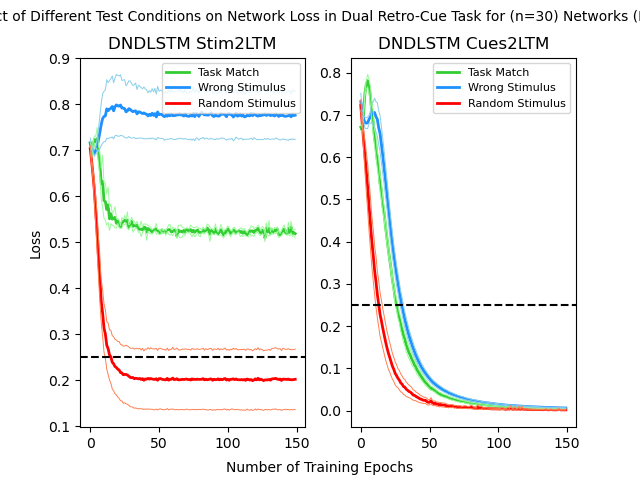

In [62]:
### Specific Plots for WMEM DRC Task ###

### DNDLSTM Stim2LTM ###

mean_sample_loss_large_dndlstmcell_stimuli2ltm_drc_dict, sample_losses_large_dndlstmcell_stimuli2ltm_drc_dict = partition_sample_losses("dual_retro_cue", mean_sample_loss_large_dndlstmcell_stimuli2ltm_drc, sample_losses_large_dndlstmcell_stimuli2ltm_drc)

task0_mean_loss = mean_sample_loss_large_dndlstmcell_stimuli2ltm_drc_dict[0]
task1_mean_loss = mean_sample_loss_large_dndlstmcell_stimuli2ltm_drc_dict[1]
task2_mean_loss = mean_sample_loss_large_dndlstmcell_stimuli2ltm_drc_dict[2]
task3_mean_loss = mean_sample_loss_large_dndlstmcell_stimuli2ltm_drc_dict[3]
task4_mean_loss = mean_sample_loss_large_dndlstmcell_stimuli2ltm_drc_dict[4]
task5_mean_loss = mean_sample_loss_large_dndlstmcell_stimuli2ltm_drc_dict[5]
task6_mean_loss = mean_sample_loss_large_dndlstmcell_stimuli2ltm_drc_dict[6]
task7_mean_loss = mean_sample_loss_large_dndlstmcell_stimuli2ltm_drc_dict[7]
task8_mean_loss = mean_sample_loss_large_dndlstmcell_stimuli2ltm_drc_dict[8]
task9_mean_loss = mean_sample_loss_large_dndlstmcell_stimuli2ltm_drc_dict[9]
task10_mean_loss = mean_sample_loss_large_dndlstmcell_stimuli2ltm_drc_dict[10]
task11_mean_loss = mean_sample_loss_large_dndlstmcell_stimuli2ltm_drc_dict[11]
task12_mean_loss = mean_sample_loss_large_dndlstmcell_stimuli2ltm_drc_dict[12]
task13_mean_loss = mean_sample_loss_large_dndlstmcell_stimuli2ltm_drc_dict[13]
task14_mean_loss = mean_sample_loss_large_dndlstmcell_stimuli2ltm_drc_dict[14]
task15_mean_loss = mean_sample_loss_large_dndlstmcell_stimuli2ltm_drc_dict[15]
task16_mean_loss = mean_sample_loss_large_dndlstmcell_stimuli2ltm_drc_dict[16]
task17_mean_loss = mean_sample_loss_large_dndlstmcell_stimuli2ltm_drc_dict[17]
task18_mean_loss = mean_sample_loss_large_dndlstmcell_stimuli2ltm_drc_dict[18]
task19_mean_loss = mean_sample_loss_large_dndlstmcell_stimuli2ltm_drc_dict[19]
task20_mean_loss = mean_sample_loss_large_dndlstmcell_stimuli2ltm_drc_dict[20]
task21_mean_loss = mean_sample_loss_large_dndlstmcell_stimuli2ltm_drc_dict[21]
task22_mean_loss = mean_sample_loss_large_dndlstmcell_stimuli2ltm_drc_dict[22]
task23_mean_loss = mean_sample_loss_large_dndlstmcell_stimuli2ltm_drc_dict[23]
task24_mean_loss = mean_sample_loss_large_dndlstmcell_stimuli2ltm_drc_dict[24]
task25_mean_loss = mean_sample_loss_large_dndlstmcell_stimuli2ltm_drc_dict[25]
task26_mean_loss = mean_sample_loss_large_dndlstmcell_stimuli2ltm_drc_dict[26]
task27_mean_loss = mean_sample_loss_large_dndlstmcell_stimuli2ltm_drc_dict[27]

task0_sample_losses = sample_losses_large_dndlstmcell_stimuli2ltm_drc_dict[0]
task1_sample_losses = sample_losses_large_dndlstmcell_stimuli2ltm_drc_dict[1]
task2_sample_losses = sample_losses_large_dndlstmcell_stimuli2ltm_drc_dict[2]
task3_sample_losses = sample_losses_large_dndlstmcell_stimuli2ltm_drc_dict[3]
task4_sample_losses = sample_losses_large_dndlstmcell_stimuli2ltm_drc_dict[4]
task5_sample_losses = sample_losses_large_dndlstmcell_stimuli2ltm_drc_dict[5]
task6_sample_losses = sample_losses_large_dndlstmcell_stimuli2ltm_drc_dict[6]
task7_sample_losses = sample_losses_large_dndlstmcell_stimuli2ltm_drc_dict[7]
task8_sample_losses = sample_losses_large_dndlstmcell_stimuli2ltm_drc_dict[8]
task9_sample_losses = sample_losses_large_dndlstmcell_stimuli2ltm_drc_dict[9]
task10_sample_losses = sample_losses_large_dndlstmcell_stimuli2ltm_drc_dict[10]
task11_sample_losses = sample_losses_large_dndlstmcell_stimuli2ltm_drc_dict[11]
task12_sample_losses = sample_losses_large_dndlstmcell_stimuli2ltm_drc_dict[12]
task13_sample_losses = sample_losses_large_dndlstmcell_stimuli2ltm_drc_dict[13]
task14_sample_losses = sample_losses_large_dndlstmcell_stimuli2ltm_drc_dict[14]
task15_sample_losses = sample_losses_large_dndlstmcell_stimuli2ltm_drc_dict[15]
task16_sample_losses = sample_losses_large_dndlstmcell_stimuli2ltm_drc_dict[16]
task17_sample_losses = sample_losses_large_dndlstmcell_stimuli2ltm_drc_dict[17]
task18_sample_losses = sample_losses_large_dndlstmcell_stimuli2ltm_drc_dict[18]
task19_sample_losses = sample_losses_large_dndlstmcell_stimuli2ltm_drc_dict[19]
task20_sample_losses = sample_losses_large_dndlstmcell_stimuli2ltm_drc_dict[20]
task21_sample_losses = sample_losses_large_dndlstmcell_stimuli2ltm_drc_dict[21]
task22_sample_losses = sample_losses_large_dndlstmcell_stimuli2ltm_drc_dict[22]
task23_sample_losses = sample_losses_large_dndlstmcell_stimuli2ltm_drc_dict[23]
task24_sample_losses = sample_losses_large_dndlstmcell_stimuli2ltm_drc_dict[24]
task25_sample_losses = sample_losses_large_dndlstmcell_stimuli2ltm_drc_dict[25]
task26_sample_losses = sample_losses_large_dndlstmcell_stimuli2ltm_drc_dict[26]
task27_sample_losses = sample_losses_large_dndlstmcell_stimuli2ltm_drc_dict[27]

# testing different cases when the same cues are made before the probes (Vanilla Working Memory Case)
match_losses_same_cues = [task1_mean_loss, task3_mean_loss]
first_probe_wrong_stimuli_losses_same_cues = [task12_mean_loss, task14_mean_loss]
first_probe_random_stimuli_losses_same_cues = [task13_mean_loss, task15_mean_loss]
second_probe_wrong_stimuli_losses_same_cues = [task16_mean_loss, task18_mean_loss]
second_probe_random_stimuli_losses_same_cues = [task17_mean_loss, task19_mean_loss]
both_probes_wrong_stimuli_losses_same_cues = [task24_mean_loss, task26_mean_loss]
both_probes_random_stimuli_losses_same_cues = [task25_mean_loss, task27_mean_loss]


# testing different cases when a different second cue is made before the second probe (ASWM case)
match_losses_different_cues = [task0_mean_loss, task2_mean_loss]
first_probe_wrong_stimuli_losses_different_cues = [task4_mean_loss, task6_mean_loss]
first_probe_random_stimuli_losses_different_cues = [task5_mean_loss, task7_mean_loss]
second_probe_wrong_stimuli_losses_different_cues = [task8_mean_loss, task10_mean_loss]
second_probe_random_stimuli_losses_different_cues = [task9_mean_loss, task11_mean_loss]
both_probes_wrong_stimuli_losses_different_cues = [task20_mean_loss, task22_mean_loss]
both_probes_random_stimuli_losses_different_cues = [task21_mean_loss, task23_mean_loss]


# get the mean losses for each of these 3 larger categories

match_losses_large_dndlstmcell_stimuli2ltm = match_losses_same_cues + match_losses_different_cues
wrong_stimuli_losses_large_dndlstmcell_stimuli2ltm = first_probe_wrong_stimuli_losses_same_cues + second_probe_wrong_stimuli_losses_same_cues + both_probes_wrong_stimuli_losses_same_cues + first_probe_wrong_stimuli_losses_different_cues + second_probe_wrong_stimuli_losses_different_cues + both_probes_wrong_stimuli_losses_different_cues
random_stimuli_losses_large_dndlstmcell_stimuli2ltm = first_probe_random_stimuli_losses_same_cues + second_probe_random_stimuli_losses_same_cues + both_probes_random_stimuli_losses_same_cues + first_probe_random_stimuli_losses_different_cues + second_probe_random_stimuli_losses_different_cues + both_probes_random_stimuli_losses_different_cues

match_mean_losses_large_dndlstmcell_stimuli2ltm = np.mean(match_losses_large_dndlstmcell_stimuli2ltm, axis=0)
wrong_stimuli_mean_losses_large_dndlstmcell_stimuli2ltm = np.mean(wrong_stimuli_losses_large_dndlstmcell_stimuli2ltm, axis=0)
random_stimuli_mean_losses_large_dndlstmcell_stimuli2ltm = np.mean(random_stimuli_losses_large_dndlstmcell_stimuli2ltm, axis=0)

### Specific Plots for WMEM DRC Task ###

### DNDLSTM Cues2LTM ###

mean_sample_loss_large_dndlstmcell_cues2ltm_drc_dict, sample_losses_large_dndlstmcell_cues2ltm_drc_dict = partition_sample_losses("dual_retro_cue", mean_sample_loss_large_dndlstmcell_cues2ltm_drc, sample_losses_large_dndlstmcell_cues2ltm_drc)

task0_mean_loss = mean_sample_loss_large_dndlstmcell_cues2ltm_drc_dict[0]
task1_mean_loss = mean_sample_loss_large_dndlstmcell_cues2ltm_drc_dict[1]
task2_mean_loss = mean_sample_loss_large_dndlstmcell_cues2ltm_drc_dict[2]
task3_mean_loss = mean_sample_loss_large_dndlstmcell_cues2ltm_drc_dict[3]
task4_mean_loss = mean_sample_loss_large_dndlstmcell_cues2ltm_drc_dict[4]
task5_mean_loss = mean_sample_loss_large_dndlstmcell_cues2ltm_drc_dict[5]
task6_mean_loss = mean_sample_loss_large_dndlstmcell_cues2ltm_drc_dict[6]
task7_mean_loss = mean_sample_loss_large_dndlstmcell_cues2ltm_drc_dict[7]
task8_mean_loss = mean_sample_loss_large_dndlstmcell_cues2ltm_drc_dict[8]
task9_mean_loss = mean_sample_loss_large_dndlstmcell_cues2ltm_drc_dict[9]
task10_mean_loss = mean_sample_loss_large_dndlstmcell_cues2ltm_drc_dict[10]
task11_mean_loss = mean_sample_loss_large_dndlstmcell_cues2ltm_drc_dict[11]
task12_mean_loss = mean_sample_loss_large_dndlstmcell_cues2ltm_drc_dict[12]
task13_mean_loss = mean_sample_loss_large_dndlstmcell_cues2ltm_drc_dict[13]
task14_mean_loss = mean_sample_loss_large_dndlstmcell_cues2ltm_drc_dict[14]
task15_mean_loss = mean_sample_loss_large_dndlstmcell_cues2ltm_drc_dict[15]
task16_mean_loss = mean_sample_loss_large_dndlstmcell_cues2ltm_drc_dict[16]
task17_mean_loss = mean_sample_loss_large_dndlstmcell_cues2ltm_drc_dict[17]
task18_mean_loss = mean_sample_loss_large_dndlstmcell_cues2ltm_drc_dict[18]
task19_mean_loss = mean_sample_loss_large_dndlstmcell_cues2ltm_drc_dict[19]
task20_mean_loss = mean_sample_loss_large_dndlstmcell_cues2ltm_drc_dict[20]
task21_mean_loss = mean_sample_loss_large_dndlstmcell_cues2ltm_drc_dict[21]
task22_mean_loss = mean_sample_loss_large_dndlstmcell_cues2ltm_drc_dict[22]
task23_mean_loss = mean_sample_loss_large_dndlstmcell_cues2ltm_drc_dict[23]
task24_mean_loss = mean_sample_loss_large_dndlstmcell_cues2ltm_drc_dict[24]
task25_mean_loss = mean_sample_loss_large_dndlstmcell_cues2ltm_drc_dict[25]
task26_mean_loss = mean_sample_loss_large_dndlstmcell_cues2ltm_drc_dict[26]
task27_mean_loss = mean_sample_loss_large_dndlstmcell_cues2ltm_drc_dict[27]

task0_sample_losses = sample_losses_large_dndlstmcell_cues2ltm_drc_dict[0]
task1_sample_losses = sample_losses_large_dndlstmcell_cues2ltm_drc_dict[1]
task2_sample_losses = sample_losses_large_dndlstmcell_cues2ltm_drc_dict[2]
task3_sample_losses = sample_losses_large_dndlstmcell_cues2ltm_drc_dict[3]
task4_sample_losses = sample_losses_large_dndlstmcell_cues2ltm_drc_dict[4]
task5_sample_losses = sample_losses_large_dndlstmcell_cues2ltm_drc_dict[5]
task6_sample_losses = sample_losses_large_dndlstmcell_cues2ltm_drc_dict[6]
task7_sample_losses = sample_losses_large_dndlstmcell_cues2ltm_drc_dict[7]
task8_sample_losses = sample_losses_large_dndlstmcell_cues2ltm_drc_dict[8]
task9_sample_losses = sample_losses_large_dndlstmcell_cues2ltm_drc_dict[9]
task10_sample_losses = sample_losses_large_dndlstmcell_cues2ltm_drc_dict[10]
task11_sample_losses = sample_losses_large_dndlstmcell_cues2ltm_drc_dict[11]
task12_sample_losses = sample_losses_large_dndlstmcell_cues2ltm_drc_dict[12]
task13_sample_losses = sample_losses_large_dndlstmcell_cues2ltm_drc_dict[13]
task14_sample_losses = sample_losses_large_dndlstmcell_cues2ltm_drc_dict[14]
task15_sample_losses = sample_losses_large_dndlstmcell_cues2ltm_drc_dict[15]
task16_sample_losses = sample_losses_large_dndlstmcell_cues2ltm_drc_dict[16]
task17_sample_losses = sample_losses_large_dndlstmcell_cues2ltm_drc_dict[17]
task18_sample_losses = sample_losses_large_dndlstmcell_cues2ltm_drc_dict[18]
task19_sample_losses = sample_losses_large_dndlstmcell_cues2ltm_drc_dict[19]
task20_sample_losses = sample_losses_large_dndlstmcell_cues2ltm_drc_dict[20]
task21_sample_losses = sample_losses_large_dndlstmcell_cues2ltm_drc_dict[21]
task22_sample_losses = sample_losses_large_dndlstmcell_cues2ltm_drc_dict[22]
task23_sample_losses = sample_losses_large_dndlstmcell_cues2ltm_drc_dict[23]
task24_sample_losses = sample_losses_large_dndlstmcell_cues2ltm_drc_dict[24]
task25_sample_losses = sample_losses_large_dndlstmcell_cues2ltm_drc_dict[25]
task26_sample_losses = sample_losses_large_dndlstmcell_cues2ltm_drc_dict[26]
task27_sample_losses = sample_losses_large_dndlstmcell_cues2ltm_drc_dict[27]

# testing different cases when the same cues are made before the probes (Vanilla Working Memory Case)
match_losses_same_cues = [task1_mean_loss, task3_mean_loss]
first_probe_wrong_stimuli_losses_same_cues = [task12_mean_loss, task14_mean_loss]
first_probe_random_stimuli_losses_same_cues = [task13_mean_loss, task15_mean_loss]
second_probe_wrong_stimuli_losses_same_cues = [task16_mean_loss, task18_mean_loss]
second_probe_random_stimuli_losses_same_cues = [task17_mean_loss, task19_mean_loss]
both_probes_wrong_stimuli_losses_same_cues = [task24_mean_loss, task26_mean_loss]
both_probes_random_stimuli_losses_same_cues = [task25_mean_loss, task27_mean_loss]


# testing different cases when a different second cue is made before the second probe (ASWM case)
match_losses_different_cues = [task0_mean_loss, task2_mean_loss]
first_probe_wrong_stimuli_losses_different_cues = [task4_mean_loss, task6_mean_loss]
first_probe_random_stimuli_losses_different_cues = [task5_mean_loss, task7_mean_loss]
second_probe_wrong_stimuli_losses_different_cues = [task8_mean_loss, task10_mean_loss]
second_probe_random_stimuli_losses_different_cues = [task9_mean_loss, task11_mean_loss]
both_probes_wrong_stimuli_losses_different_cues = [task20_mean_loss, task22_mean_loss]
both_probes_random_stimuli_losses_different_cues = [task21_mean_loss, task23_mean_loss]

# get the mean losses for each of these 3 larger categories

match_losses_large_dndlstmcell_cues2ltm = match_losses_same_cues + match_losses_different_cues
wrong_stimuli_losses_large_dndlstmcell_cues2ltm = first_probe_wrong_stimuli_losses_same_cues + second_probe_wrong_stimuli_losses_same_cues + both_probes_wrong_stimuli_losses_same_cues + first_probe_wrong_stimuli_losses_different_cues + second_probe_wrong_stimuli_losses_different_cues + both_probes_wrong_stimuli_losses_different_cues
random_stimuli_losses_large_dndlstmcell_cues2ltm = first_probe_random_stimuli_losses_same_cues + second_probe_random_stimuli_losses_same_cues + both_probes_random_stimuli_losses_same_cues + first_probe_random_stimuli_losses_different_cues + second_probe_random_stimuli_losses_different_cues + both_probes_random_stimuli_losses_different_cues


match_mean_losses_large_dndlstmcell_cues2ltm = np.mean(match_losses_large_dndlstmcell_cues2ltm, axis=0)
wrong_stimuli_mean_losses_large_dndlstmcell_cues2ltm = np.mean(wrong_stimuli_losses_large_dndlstmcell_cues2ltm, axis=0)
random_stimuli_mean_losses_large_dndlstmcell_cues2ltm = np.mean(random_stimuli_losses_large_dndlstmcell_cues2ltm, axis=0)


fig, ax = plt.subplots(1,2)

# plot losses
fig.suptitle("Average Effect of Different Test Conditions on Network Loss in Dual Retro-Cue Task for (n=" + str(num_networks) + ") Networks (Large Delays)", fontsize=10)


# Individual losses for each sample type (where the same stimulus is cued each round)
ax[0].set_title("DNDLSTM Stim2LTM")
ax[0].plot(match_mean_losses_large_dndlstmcell_stimuli2ltm, color='limegreen', label="Task Match", linewidth=2)
ax[0].plot(wrong_stimuli_mean_losses_large_dndlstmcell_stimuli2ltm, color='dodgerblue', label="Wrong Stimulus", linewidth=2)
ax[0].plot(random_stimuli_mean_losses_large_dndlstmcell_stimuli2ltm, color='red', label="Random Stimulus", linewidth=2)

## Standard deviations
ax[0].plot((match_mean_losses_large_dndlstmcell_stimuli2ltm + 2*stats.sem(match_losses_large_dndlstmcell_stimuli2ltm, axis=0, ddof=0)), color='palegreen', linewidth=0.7)
ax[0].plot((match_mean_losses_large_dndlstmcell_stimuli2ltm - 2*stats.sem(match_losses_large_dndlstmcell_stimuli2ltm, axis=0, ddof=0)), color='palegreen', linewidth=0.7)

ax[0].plot((wrong_stimuli_mean_losses_large_dndlstmcell_stimuli2ltm + 2*stats.sem(wrong_stimuli_losses_large_dndlstmcell_stimuli2ltm, axis=0, ddof=0)), color='skyblue', linewidth=0.7)
ax[0].plot((wrong_stimuli_mean_losses_large_dndlstmcell_stimuli2ltm - 2*stats.sem(wrong_stimuli_losses_large_dndlstmcell_stimuli2ltm, axis=0, ddof=0)), color='skyblue', linewidth=0.7)

ax[0].plot((random_stimuli_mean_losses_large_dndlstmcell_stimuli2ltm + 2*stats.sem(random_stimuli_losses_large_dndlstmcell_stimuli2ltm, axis=0, ddof=0)), color='coral', linewidth=0.7)
ax[0].plot((random_stimuli_mean_losses_large_dndlstmcell_stimuli2ltm - 2*stats.sem(random_stimuli_losses_large_dndlstmcell_stimuli2ltm, axis=0, ddof=0)), color='coral', linewidth=0.7)

# Individual losses for each sample type (where a different stimulus is cued each round)
ax[1].set_title("DNDLSTM Cues2LTM")
ax[1].plot(match_mean_losses_large_dndlstmcell_cues2ltm, color='limegreen', label="Task Match", linewidth=2)
ax[1].plot(wrong_stimuli_mean_losses_large_dndlstmcell_cues2ltm, color='dodgerblue', label="Wrong Stimulus", linewidth=2)
ax[1].plot(random_stimuli_mean_losses_large_dndlstmcell_cues2ltm, color='red', label="Random Stimulus", linewidth=2)

## Standard deviations
ax[1].plot((match_mean_losses_large_dndlstmcell_cues2ltm + 2*stats.sem(match_losses_large_dndlstmcell_cues2ltm, axis=0, ddof=0)), color='palegreen', linewidth=0.7)
ax[1].plot((match_mean_losses_large_dndlstmcell_cues2ltm - 2*stats.sem(match_losses_large_dndlstmcell_cues2ltm, axis=0, ddof=0)), color='palegreen', linewidth=0.7)      
           
ax[1].plot((wrong_stimuli_mean_losses_large_dndlstmcell_cues2ltm + 2*stats.sem(wrong_stimuli_losses_large_dndlstmcell_cues2ltm, axis=0, ddof=0)), color='skyblue', linewidth=0.7)
ax[1].plot((wrong_stimuli_mean_losses_large_dndlstmcell_cues2ltm - 2*stats.sem(wrong_stimuli_losses_large_dndlstmcell_cues2ltm, axis=0, ddof=0)), color='skyblue', linewidth=0.7)

ax[1].plot((random_stimuli_mean_losses_large_dndlstmcell_cues2ltm + 2*stats.sem(random_stimuli_losses_large_dndlstmcell_cues2ltm, axis=0, ddof=0)), color='coral', linewidth=0.7)
ax[1].plot((random_stimuli_mean_losses_large_dndlstmcell_cues2ltm - 2*stats.sem(random_stimuli_losses_large_dndlstmcell_cues2ltm, axis=0, ddof=0)), color='coral', linewidth=0.7)

# Threshold line
ax[0].axhline(threshold, linestyle='dashed', color='black')
ax[1].axhline(threshold, linestyle='dashed', color='black')

# legend and show plot
ax[0].legend(fontsize=8, loc="upper right") # by default, the legend ignores all elements without a label attribute set.
ax[1].legend(fontsize=8, loc="upper right") # by default, the legend ignores all elements without a label attribute set.

fig.supxlabel('Number of Training Epochs', fontsize=10) # x label
ax[0].set_ylabel('Loss', fontsize=10) # y label

plt.show()

#### *Graph on Summaries of Each Trial Type for Memory Augmented LSTMs on the Dual Retro-Cue Task (Both Delays)*

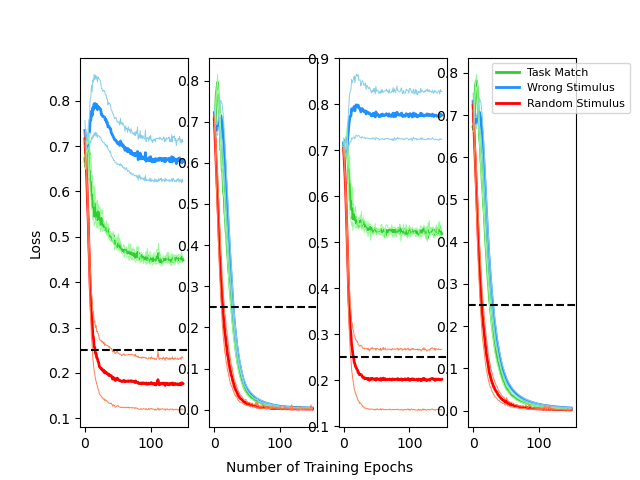

In [63]:
fig, ax = plt.subplots(1,4)

# plot losses

# Individual losses for each sample type (where the same stimulus is cued each round)
# ax[0].set_title("DNDLSTM Stim2LTM - Small Delays", fontsize=10)
ax[0].plot(match_mean_losses_small_dndlstmcell_stimuli2ltm, color='limegreen', label="Task Match", linewidth=2)
ax[0].plot(wrong_stimuli_mean_losses_small_dndlstmcell_stimuli2ltm, color='dodgerblue', label="Wrong Stimulus", linewidth=2)
ax[0].plot(random_stimuli_mean_losses_small_dndlstmcell_stimuli2ltm, color='red', label="Random Stimulus", linewidth=2)

## Standard deviations
ax[0].plot((match_mean_losses_small_dndlstmcell_stimuli2ltm + 2*stats.sem(match_losses_small_dndlstmcell_stimuli2ltm, axis=0, ddof=0)), color='palegreen', linewidth=0.7)
ax[0].plot((match_mean_losses_small_dndlstmcell_stimuli2ltm - 2*stats.sem(match_losses_small_dndlstmcell_stimuli2ltm, axis=0, ddof=0)), color='palegreen', linewidth=0.7)

ax[0].plot((wrong_stimuli_mean_losses_small_dndlstmcell_stimuli2ltm + 2*stats.sem(wrong_stimuli_losses_small_dndlstmcell_stimuli2ltm, axis=0, ddof=0)), color='skyblue', linewidth=0.7)
ax[0].plot((wrong_stimuli_mean_losses_small_dndlstmcell_stimuli2ltm - 2*stats.sem(wrong_stimuli_losses_small_dndlstmcell_stimuli2ltm, axis=0, ddof=0)), color='skyblue', linewidth=0.7)

ax[0].plot((random_stimuli_mean_losses_small_dndlstmcell_stimuli2ltm + 2*stats.sem(random_stimuli_losses_small_dndlstmcell_stimuli2ltm, axis=0, ddof=0)), color='coral', linewidth=0.7)
ax[0].plot((random_stimuli_mean_losses_small_dndlstmcell_stimuli2ltm - 2*stats.sem(random_stimuli_losses_small_dndlstmcell_stimuli2ltm, axis=0, ddof=0)), color='coral', linewidth=0.7)

# Individual losses for each sample type (where a different stimulus is cued each round)
# ax[1].set_title("DNDLSTM Cues2LTM - Small Delays", fontsize=10)
ax[1].plot(match_mean_losses_small_dndlstmcell_cues2ltm, color='limegreen', label="Task Match", linewidth=2)
ax[1].plot(wrong_stimuli_mean_losses_small_dndlstmcell_cues2ltm, color='dodgerblue', label="Wrong Stimulus", linewidth=2)
ax[1].plot(random_stimuli_mean_losses_small_dndlstmcell_cues2ltm, color='red', label="Random Stimulus", linewidth=2)

## Standard deviations
ax[1].plot((match_mean_losses_small_dndlstmcell_cues2ltm + 2*stats.sem(match_losses_small_dndlstmcell_cues2ltm, axis=0, ddof=0)), color='palegreen', linewidth=0.7)
ax[1].plot((match_mean_losses_small_dndlstmcell_cues2ltm - 2*stats.sem(match_losses_small_dndlstmcell_cues2ltm, axis=0, ddof=0)), color='palegreen', linewidth=0.7)      
           
ax[1].plot((wrong_stimuli_mean_losses_small_dndlstmcell_cues2ltm + 2*stats.sem(wrong_stimuli_losses_small_dndlstmcell_cues2ltm, axis=0, ddof=0)), color='skyblue', linewidth=0.7)
ax[1].plot((wrong_stimuli_mean_losses_small_dndlstmcell_cues2ltm - 2*stats.sem(wrong_stimuli_losses_small_dndlstmcell_cues2ltm, axis=0, ddof=0)), color='skyblue', linewidth=0.7)

ax[1].plot((random_stimuli_mean_losses_small_dndlstmcell_cues2ltm + 2*stats.sem(random_stimuli_losses_small_dndlstmcell_cues2ltm, axis=0, ddof=0)), color='coral', linewidth=0.7)
ax[1].plot((random_stimuli_mean_losses_small_dndlstmcell_cues2ltm - 2*stats.sem(random_stimuli_losses_small_dndlstmcell_cues2ltm, axis=0, ddof=0)), color='coral', linewidth=0.7)

# Individual losses for each sample type (where the same stimulus is cued each round)
# ax[2].set_title("DNDLSTM Stim2LTM - Large Delays", fontsize=10)
ax[2].plot(match_mean_losses_large_dndlstmcell_stimuli2ltm, color='limegreen', label="Task Match", linewidth=2)
ax[2].plot(wrong_stimuli_mean_losses_large_dndlstmcell_stimuli2ltm, color='dodgerblue', label="Wrong Stimulus", linewidth=2)
ax[2].plot(random_stimuli_mean_losses_large_dndlstmcell_stimuli2ltm, color='red', label="Random Stimulus", linewidth=2)

## Standard deviations
ax[2].plot((match_mean_losses_large_dndlstmcell_stimuli2ltm + 2*stats.sem(match_losses_large_dndlstmcell_stimuli2ltm, axis=0, ddof=0)), color='palegreen', linewidth=0.7)
ax[2].plot((match_mean_losses_large_dndlstmcell_stimuli2ltm - 2*stats.sem(match_losses_large_dndlstmcell_stimuli2ltm, axis=0, ddof=0)), color='palegreen', linewidth=0.7)

ax[2].plot((wrong_stimuli_mean_losses_large_dndlstmcell_stimuli2ltm + 2*stats.sem(wrong_stimuli_losses_large_dndlstmcell_stimuli2ltm, axis=0, ddof=0)), color='skyblue', linewidth=0.7)
ax[2].plot((wrong_stimuli_mean_losses_large_dndlstmcell_stimuli2ltm - 2*stats.sem(wrong_stimuli_losses_large_dndlstmcell_stimuli2ltm, axis=0, ddof=0)), color='skyblue', linewidth=0.7)

ax[2].plot((random_stimuli_mean_losses_large_dndlstmcell_stimuli2ltm + 2*stats.sem(random_stimuli_losses_large_dndlstmcell_stimuli2ltm, axis=0, ddof=0)), color='coral', linewidth=0.7)
ax[2].plot((random_stimuli_mean_losses_large_dndlstmcell_stimuli2ltm - 2*stats.sem(random_stimuli_losses_large_dndlstmcell_stimuli2ltm, axis=0, ddof=0)), color='coral', linewidth=0.7)

# Individual losses for each sample type (where a different stimulus is cued each round)
# ax[1].set_title("DNDLSTM Cues2LTM - Large Delays, fontsize=10")
ax[3].plot(match_mean_losses_large_dndlstmcell_cues2ltm, color='limegreen', label="Task Match", linewidth=2)
ax[3].plot(wrong_stimuli_mean_losses_large_dndlstmcell_cues2ltm, color='dodgerblue', label="Wrong Stimulus", linewidth=2)
ax[3].plot(random_stimuli_mean_losses_large_dndlstmcell_cues2ltm, color='red', label="Random Stimulus", linewidth=2)

## Standard deviations
ax[3].plot((match_mean_losses_large_dndlstmcell_cues2ltm + 2*stats.sem(match_losses_large_dndlstmcell_cues2ltm, axis=0, ddof=0)), color='palegreen', linewidth=0.7)
ax[3].plot((match_mean_losses_large_dndlstmcell_cues2ltm - 2*stats.sem(match_losses_large_dndlstmcell_cues2ltm, axis=0, ddof=0)), color='palegreen', linewidth=0.7)      
           
ax[3].plot((wrong_stimuli_mean_losses_large_dndlstmcell_cues2ltm + 2*stats.sem(wrong_stimuli_losses_large_dndlstmcell_cues2ltm, axis=0, ddof=0)), color='skyblue', linewidth=0.7)
ax[3].plot((wrong_stimuli_mean_losses_large_dndlstmcell_cues2ltm - 2*stats.sem(wrong_stimuli_losses_large_dndlstmcell_cues2ltm, axis=0, ddof=0)), color='skyblue', linewidth=0.7)

ax[3].plot((random_stimuli_mean_losses_large_dndlstmcell_cues2ltm + 2*stats.sem(random_stimuli_losses_large_dndlstmcell_cues2ltm, axis=0, ddof=0)), color='coral', linewidth=0.7)
ax[3].plot((random_stimuli_mean_losses_large_dndlstmcell_cues2ltm - 2*stats.sem(random_stimuli_losses_large_dndlstmcell_cues2ltm, axis=0, ddof=0)), color='coral', linewidth=0.7)

# Threshold line
ax[0].axhline(threshold, linestyle='dashed', color='black')
ax[1].axhline(threshold, linestyle='dashed', color='black')
ax[2].axhline(threshold, linestyle='dashed', color='black')
ax[3].axhline(threshold, linestyle='dashed', color='black')

# legend and show plot
ax[3].legend(fontsize=8, bbox_to_anchor=(1.55, 1), loc="upper right") # by default, the legend ignores all elements without a label attribute set.

fig.supxlabel('Number of Training Epochs', fontsize=10) # x label
ax[0].set_ylabel('Loss', fontsize=10) # y label

plt.show()

#### *Comparative Graphs for Simple RNNs vs. Memory Augmented LSTMs on the Dual Retro-Cue Task*

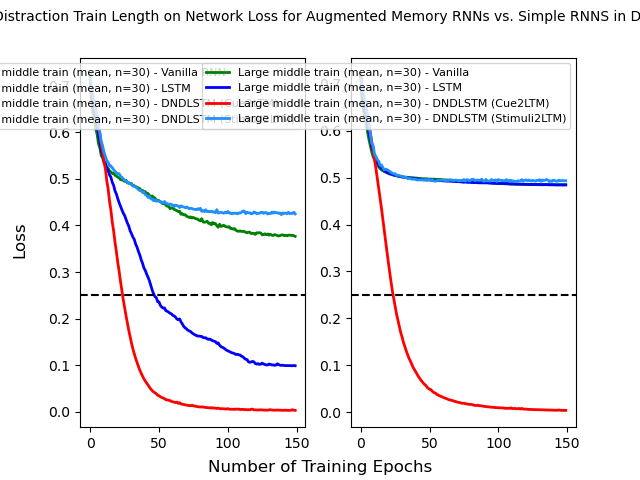

In [65]:
### General Plots for WMEM vs Simple RNNs for DRC Task ###

fig, ax = plt.subplots(1,2)

# plot losses
fig.suptitle("Average Effect of Distraction Train Length on Network Loss for Augmented Memory RNNs vs. Simple RNNS in Dual Retro-Cue Task", fontsize=10)

## Mean losses (Small Middle Train)
ax[0].plot(mean_loss_small_rnncell_drc, color='green', label="Small middle train (mean, n=" + str(num_networks) + ") - Vanilla RNN", linewidth=2)
ax[0].plot(mean_loss_small_lstmcell_drc, color='blue', label="Small middle train (mean, n=" + str(num_networks) + ") - LSTM", linewidth=2)
ax[0].plot(mean_loss_small_dndlstmcell_cues2ltm_drc, color='red', label="Small middle train (mean, n=" + str(num_networks) + ") - DNDLSTM (Cue2LTM)", linewidth=2)
ax[0].plot(mean_loss_small_dndlstmcell_stimuli2ltm_drc, color='dodgerblue', label="Small middle train (mean, n=" + str(num_networks) + ") - DNDLSTM (Stimuli2LTM)", linewidth=2)

## Mean losses (Large Middle Train)
ax[1].plot(mean_loss_large_rnncell_drc, color='green', label="Large middle train (mean, n=" + str(num_networks) + ") - Vanilla", linewidth=2)
ax[1].plot(mean_loss_large_lstmcell_drc, color='blue', label="Large middle train (mean, n=" + str(num_networks) + ") - LSTM", linewidth=2)
ax[1].plot(mean_loss_large_dndlstmcell_cues2ltm_drc, color='red', label="Large middle train (mean, n=" + str(num_networks) + ") - DNDLSTM (Cue2LTM)", linewidth=2)
ax[1].plot(mean_loss_large_dndlstmcell_stimuli2ltm_drc, color='dodgerblue', label="Large middle train (mean, n=" + str(num_networks) + ") - DNDLSTM (Stimuli2LTM)", linewidth=2)

# Threshold line
ax[0].axhline(threshold, linestyle='dashed', color='black')
ax[1].axhline(threshold, linestyle='dashed', color='black')

# legend and show plot
ax[0].legend(fontsize=8, loc="upper right") # by default, the legend ignores all elements without a label attribute set.
ax[1].legend(fontsize=8, loc="upper right") # by default, the legend ignores all elements without a label attribute set.

fig.supxlabel('Number of Training Epochs')
fig.supylabel('Loss')

plt.show()

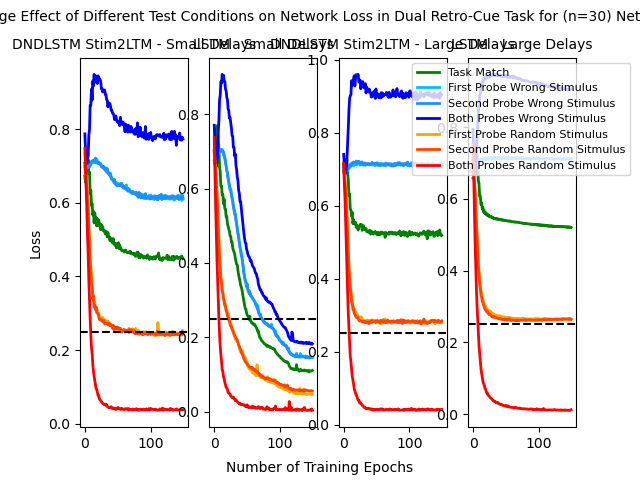

In [66]:
fig, ax = plt.subplots(1,4)

# plot losses
fig.suptitle("Average Effect of Different Test Conditions on Network Loss in Dual Retro-Cue Task for (n=" + str(num_networks) + ") Networks", fontsize=10)

# Individual losses for each sample type (where the same stimulus is cued each round)
ax[0].set_title("DNDLSTM Stim2LTM - Small Delays", fontsize=10)
ax[0].plot(match_mean_losses_small_dndlstmcell_stimuli2ltm, color='green', label="Task Match", linewidth=2)
ax[0].plot(first_probe_wrong_stimuli_mean_losses_small_dndlstmcell_stimuli2ltm, color='deepskyblue', label="First Probe Wrong Stimulus", linewidth=2)
ax[0].plot(second_probe_wrong_stimuli_mean_losses_small_dndlstmcell_stimuli2ltm, color='dodgerblue', label="Second Probe Wrong Stimulus", linewidth=2)
ax[0].plot(both_probes_wrong_stimuli_mean_losses_small_dndlstmcell_stimuli2ltm, color='blue', label="Both Probes Wrong Stimulus", linewidth=2)
ax[0].plot(first_probe_random_stimuli_mean_losses_small_dndlstmcell_stimuli2ltm, color='orange', label="First Probe Random Stimulus", linewidth=2)
ax[0].plot(second_probe_random_stimuli_mean_losses_small_dndlstmcell_stimuli2ltm, color='orangered', label="Second Probe Random Sitmulus", linewidth=2)
ax[0].plot(both_probes_random_stimuli_mean_losses_small_dndlstmcell_stimuli2ltm, color='red', label="Both Probes Random Stimulus", linewidth=2)

# Individual losses for each sample type (where a different stimulus is cued each round)
ax[1].set_title("LSTM - Small Delays", fontsize=10)
ax[1].plot(match_mean_losses_small_lstmcell, color='green', label="Task Match", linewidth=2)
ax[1].plot(first_probe_wrong_stimuli_mean_losses_small_lstmcell, color='deepskyblue', label="First Probe Wrong Stimulus", linewidth=2)
ax[1].plot(second_probe_wrong_stimuli_mean_losses_small_lstmcell, color='dodgerblue', label="Second Probe Wrong Stimulus", linewidth=2)
ax[1].plot(both_probes_wrong_stimuli_mean_losses_small_lstmcell, color='blue', label="Both Probes Wrong Stimulus", linewidth=2)
ax[1].plot(first_probe_random_stimuli_mean_losses_small_lstmcell, color='orange', label="First Probe Random Stimulus", linewidth=2)
ax[1].plot(second_probe_random_stimuli_mean_losses_small_lstmcell, color='orangered', label="Second Probe Random Sitmulus", linewidth=2)
ax[1].plot(both_probes_random_stimuli_mean_losses_small_lstmcell, color='red', label="Both Probes Random Stimulus", linewidth=2)

# Individual losses for each sample type (where the same stimulus is cued each round)
ax[2].set_title("DNDLSTM Stim2LTM - Large Delays", fontsize=10)
ax[2].plot(match_mean_losses_large_dndlstmcell_stimuli2ltm, color='green', label="Task Match", linewidth=2)
ax[2].plot(first_probe_wrong_stimuli_mean_losses_large_dndlstmcell_stimuli2ltm, color='deepskyblue', label="First Probe Wrong Stimulus", linewidth=2)
ax[2].plot(second_probe_wrong_stimuli_mean_losses_large_dndlstmcell_stimuli2ltm, color='dodgerblue', label="Second Probe Wrong Stimulus", linewidth=2)
ax[2].plot(both_probes_wrong_stimuli_mean_losses_large_dndlstmcell_stimuli2ltm, color='blue', label="Both Probes Wrong Stimulus", linewidth=2)
ax[2].plot(first_probe_random_stimuli_mean_losses_large_dndlstmcell_stimuli2ltm, color='orange', label="First Probe Random Stimulus", linewidth=2)
ax[2].plot(second_probe_random_stimuli_mean_losses_large_dndlstmcell_stimuli2ltm, color='orangered', label="Second Probe Random Sitmulus", linewidth=2)
ax[2].plot(both_probes_random_stimuli_mean_losses_large_dndlstmcell_stimuli2ltm, color='red', label="Both Probes Random Stimulus", linewidth=2)

# Individual losses for each sample type (where a different stimulus is cued each round)
ax[3].set_title("LSTM - Large Delays", fontsize=10)
ax[3].plot(match_mean_losses_large_lstmcell, color='green', label="Task Match", linewidth=2)
ax[3].plot(first_probe_wrong_stimuli_mean_losses_large_lstmcell, color='deepskyblue', label="First Probe Wrong Stimulus", linewidth=2)
ax[3].plot(second_probe_wrong_stimuli_mean_losses_large_lstmcell, color='dodgerblue', label="Second Probe Wrong Stimulus", linewidth=2)
ax[3].plot(both_probes_wrong_stimuli_mean_losses_large_lstmcell, color='blue', label="Both Probes Wrong Stimulus", linewidth=2)
ax[3].plot(first_probe_random_stimuli_mean_losses_large_lstmcell, color='orange', label="First Probe Random Stimulus", linewidth=2)
ax[3].plot(second_probe_random_stimuli_mean_losses_large_lstmcell, color='orangered', label="Second Probe Random Sitmulus", linewidth=2)
ax[3].plot(both_probes_random_stimuli_mean_losses_large_lstmcell, color='red', label="Both Probes Random Stimulus", linewidth=2)

# Threshold line
ax[0].axhline(threshold, linestyle='dashed', color='black')
ax[1].axhline(threshold, linestyle='dashed', color='black')
ax[2].axhline(threshold, linestyle='dashed', color='black')
ax[3].axhline(threshold, linestyle='dashed', color='black')

# legend and show plot
ax[3].legend(fontsize=8, bbox_to_anchor=(1.55, 1), loc="upper right") # by default, the legend ignores all elements without a label attribute set.

fig.supxlabel('Number of Training Epochs', fontsize=10) # x label
ax[0].set_ylabel('Loss', fontsize=10) # y label

plt.show()

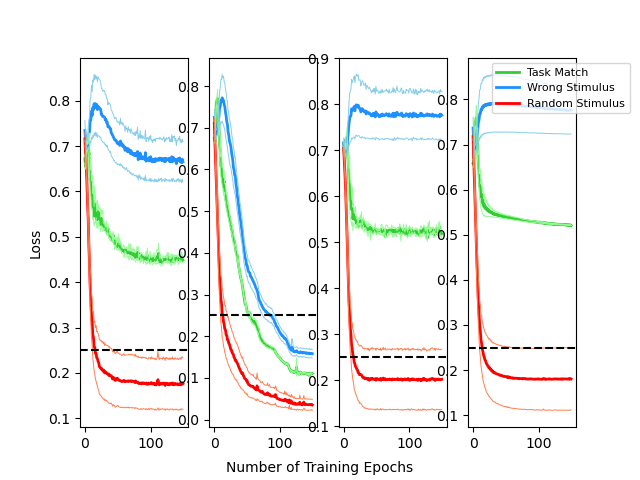

In [68]:
fig, ax = plt.subplots(1,4)

# plot losses

# Individual losses for each sample type (where the same stimulus is cued each round)
# ax[0].set_title("DNDLSTM Stim2LTM - Small Delays", fontsize=10)
ax[0].plot(match_mean_losses_small_dndlstmcell_stimuli2ltm, color='limegreen', label="Task Match", linewidth=2)
ax[0].plot(wrong_stimuli_mean_losses_small_dndlstmcell_stimuli2ltm, color='dodgerblue', label="Wrong Stimulus", linewidth=2)
ax[0].plot(random_stimuli_mean_losses_small_dndlstmcell_stimuli2ltm, color='red', label="Random Stimulus", linewidth=2)

## Standard deviations
ax[0].plot((match_mean_losses_small_dndlstmcell_stimuli2ltm + 2*stats.sem(match_losses_small_dndlstmcell_stimuli2ltm, axis=0, ddof=0)), color='palegreen', linewidth=0.7)
ax[0].plot((match_mean_losses_small_dndlstmcell_stimuli2ltm - 2*stats.sem(match_losses_small_dndlstmcell_stimuli2ltm, axis=0, ddof=0)), color='palegreen', linewidth=0.7)

ax[0].plot((wrong_stimuli_mean_losses_small_dndlstmcell_stimuli2ltm + 2*stats.sem(wrong_stimuli_losses_small_dndlstmcell_stimuli2ltm, axis=0, ddof=0)), color='skyblue', linewidth=0.7)
ax[0].plot((wrong_stimuli_mean_losses_small_dndlstmcell_stimuli2ltm - 2*stats.sem(wrong_stimuli_losses_small_dndlstmcell_stimuli2ltm, axis=0, ddof=0)), color='skyblue', linewidth=0.7)

ax[0].plot((random_stimuli_mean_losses_small_dndlstmcell_stimuli2ltm + 2*stats.sem(random_stimuli_losses_small_dndlstmcell_stimuli2ltm, axis=0, ddof=0)), color='coral', linewidth=0.7)
ax[0].plot((random_stimuli_mean_losses_small_dndlstmcell_stimuli2ltm - 2*stats.sem(random_stimuli_losses_small_dndlstmcell_stimuli2ltm, axis=0, ddof=0)), color='coral', linewidth=0.7)

# Individual losses for each sample type (where a different stimulus is cued each round)
# ax[1].set_title("LSTM - Small Delays", fontsize=10)
ax[1].plot(match_mean_losses_small_lstmcell, color='limegreen', label="Task Match", linewidth=2)
ax[1].plot(wrong_stimuli_mean_losses_small_lstmcell, color='dodgerblue', label="Wrong Stimulus", linewidth=2)
ax[1].plot(random_stimuli_mean_losses_small_lstmcell, color='red', label="Random Stimulus", linewidth=2)

## Standard deviations
ax[1].plot((match_mean_losses_small_lstmcell + 2*stats.sem(match_losses_small_lstmcell, axis=0, ddof=0)), color='palegreen', linewidth=0.7)
ax[1].plot((match_mean_losses_small_lstmcell - 2*stats.sem(match_losses_small_lstmcell, axis=0, ddof=0)), color='palegreen', linewidth=0.7)      
           
ax[1].plot((wrong_stimuli_mean_losses_small_lstmcell + 2*stats.sem(wrong_stimuli_losses_small_lstmcell, axis=0, ddof=0)), color='skyblue', linewidth=0.7)
ax[1].plot((wrong_stimuli_mean_losses_small_lstmcell - 2*stats.sem(wrong_stimuli_losses_small_lstmcell, axis=0, ddof=0)), color='skyblue', linewidth=0.7)

ax[1].plot((random_stimuli_mean_losses_small_lstmcell + 2*stats.sem(random_stimuli_losses_small_lstmcell, axis=0, ddof=0)), color='coral', linewidth=0.7)
ax[1].plot((random_stimuli_mean_losses_small_lstmcell - 2*stats.sem(random_stimuli_losses_small_lstmcell, axis=0, ddof=0)), color='coral', linewidth=0.7)

# Individual losses for each sample type (where the same stimulus is cued each round)
# ax[2].set_title("DNDLSTM Stim2LTM - Large Delays", fontsize=10)
ax[2].plot(match_mean_losses_large_dndlstmcell_stimuli2ltm, color='limegreen', label="Task Match", linewidth=2)
ax[2].plot(wrong_stimuli_mean_losses_large_dndlstmcell_stimuli2ltm, color='dodgerblue', label="Wrong Stimulus", linewidth=2)
ax[2].plot(random_stimuli_mean_losses_large_dndlstmcell_stimuli2ltm, color='red', label="Random Stimulus", linewidth=2)

## Standard deviations
ax[2].plot((match_mean_losses_large_dndlstmcell_stimuli2ltm + 2*stats.sem(match_losses_large_dndlstmcell_stimuli2ltm, axis=0, ddof=0)), color='palegreen', linewidth=0.7)
ax[2].plot((match_mean_losses_large_dndlstmcell_stimuli2ltm - 2*stats.sem(match_losses_large_dndlstmcell_stimuli2ltm, axis=0, ddof=0)), color='palegreen', linewidth=0.7)

ax[2].plot((wrong_stimuli_mean_losses_large_dndlstmcell_stimuli2ltm + 2*stats.sem(wrong_stimuli_losses_large_dndlstmcell_stimuli2ltm, axis=0, ddof=0)), color='skyblue', linewidth=0.7)
ax[2].plot((wrong_stimuli_mean_losses_large_dndlstmcell_stimuli2ltm - 2*stats.sem(wrong_stimuli_losses_large_dndlstmcell_stimuli2ltm, axis=0, ddof=0)), color='skyblue', linewidth=0.7)

ax[2].plot((random_stimuli_mean_losses_large_dndlstmcell_stimuli2ltm + 2*stats.sem(random_stimuli_losses_large_dndlstmcell_stimuli2ltm, axis=0, ddof=0)), color='coral', linewidth=0.7)
ax[2].plot((random_stimuli_mean_losses_large_dndlstmcell_stimuli2ltm - 2*stats.sem(random_stimuli_losses_large_dndlstmcell_stimuli2ltm, axis=0, ddof=0)), color='coral', linewidth=0.7)

# Individual losses for each sample type (where a different stimulus is cued each round)
# ax[3].set_title("LSTM - Large Delays", fontsize=10)
ax[3].plot(match_mean_losses_large_lstmcell, color='limegreen', label="Task Match", linewidth=2)
ax[3].plot(wrong_stimuli_mean_losses_large_lstmcell, color='dodgerblue', label="Wrong Stimulus", linewidth=2)
ax[3].plot(random_stimuli_mean_losses_large_lstmcell, color='red', label="Random Stimulus", linewidth=2)

## Standard deviations
ax[3].plot((match_mean_losses_large_lstmcell + 2*stats.sem(match_losses_large_lstmcell, axis=0, ddof=0)), color='palegreen', linewidth=0.7)
ax[3].plot((match_mean_losses_large_lstmcell - 2*stats.sem(match_losses_large_lstmcell, axis=0, ddof=0)), color='palegreen', linewidth=0.7)      
           
ax[3].plot((wrong_stimuli_mean_losses_large_lstmcell + 2*stats.sem(wrong_stimuli_losses_large_lstmcell, axis=0, ddof=0)), color='skyblue', linewidth=0.7)
ax[3].plot((wrong_stimuli_mean_losses_large_lstmcell - 2*stats.sem(wrong_stimuli_losses_large_lstmcell, axis=0, ddof=0)), color='skyblue', linewidth=0.7)

ax[3].plot((random_stimuli_mean_losses_large_lstmcell + 2*stats.sem(random_stimuli_losses_large_lstmcell, axis=0, ddof=0)), color='coral', linewidth=0.7)
ax[3].plot((random_stimuli_mean_losses_large_lstmcell - 2*stats.sem(random_stimuli_losses_large_lstmcell, axis=0, ddof=0)), color='coral', linewidth=0.7)

# Threshold line
ax[0].axhline(threshold, linestyle='dashed', color='black')
ax[1].axhline(threshold, linestyle='dashed', color='black')
ax[2].axhline(threshold, linestyle='dashed', color='black')
ax[3].axhline(threshold, linestyle='dashed', color='black')

# legend and show plot
ax[3].legend(fontsize=8, bbox_to_anchor=(1.55, 1), loc="upper right") # by default, the legend ignores all elements without a label attribute set.

fig.supxlabel('Number of Training Epochs', fontsize=10) # x label
ax[0].set_ylabel('Loss', fontsize=10) # y label

plt.show()

## **Dual Retro-Cue Task w/ WMEM LSTMs**

In [ ]:
# DRC Task w/ WMEM LSTMs -- Hyperparameters
generate_new = True
generate_random = False
return_sample_losses = True
multiple_tests = True
test_type = 'dual_retro_cue'
multiple_tests_type='resue_one_stimulus'

### *WMEMLSTM Remembering the Stimulus State w/ Context Representations ~ Training*

In [ ]:
# DRC Task with Memory Augmented LSTM — Saving the Stimuli into Long Term Memory (Test Condition)
network_type = 'wmemlstmcell'
memory_rule = 'remember_stimuli_states'
mean_loss_small_wmemlstmcell_stimuli2ltm_drc,losses_small_wmemlstmcell_stimuli2ltm_drc,mean_sample_loss_small_wmemlstmcell_stimuli2ltm_drc,sample_losses_small_wmemlstmcell_stimuli2ltm_drc,_ = get_loss(test_type=test_type, network_type=network_type, num_networks=num_networks, condition=small_small_delays, memory_rule=memory_rule, multiple_tests=multiple_tests, multiple_tests_type=multiple_tests_type, stimulus_set=stimulus_set)
mean_loss_large_wmemlstmcell_stimuli2ltm_drc,losses_large_wmemlstmcell_stimuli2ltm_drc,mean_sample_loss_large_wmemlstmcell_stimuli2ltm_drc,sample_losses_large_wmemlstmcell_stimuli2ltm_drc,_ = get_loss(test_type=test_type, network_type=network_type, num_networks=num_networks, condition=large_large_delays, memory_rule=memory_rule, multiple_tests=multiple_tests, multiple_tests_type=multiple_tests_type, stimulus_set=stimulus_set)

### *Graphs for WMEM LSTMs on the Dual Retro-Cue Task*

#### *General Graph for WMEM vs WM + EM LSTMs on the Dual Retro-Cue Task*

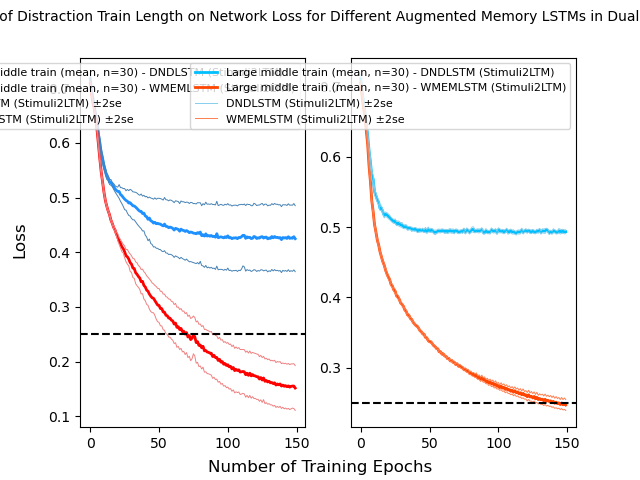

In [73]:
### General Plots for WMEM DRC Task ###

fig, ax = plt.subplots(1,2)

# plot losses
fig.suptitle("Average Effect of Distraction Train Length on Network Loss for Different Augmented Memory LSTMs in Dual Retro-Cue Task", fontsize=10)

## Mean losses (Control)
ax[0].plot(mean_loss_small_dndlstmcell_stimuli2ltm_drc, color='dodgerblue', label="Small middle train (mean, n=" + str(num_networks) + ") - DNDLSTM (Stimuli2LTM)", linewidth=2)
ax[1].plot(mean_loss_large_dndlstmcell_stimuli2ltm_drc, color='deepskyblue', label="Large middle train (mean, n=" + str(num_networks) + ") - DNDLSTM (Stimuli2LTM)", linewidth=2)

## Mean losses (Test)
ax[0].plot(mean_loss_small_wmemlstmcell_stimuli2ltm_drc, color='red', label="Small middle train (mean, n=" + str(num_networks) + ") - WMEMLSTM (Stimuli2LTM)", linewidth=2)
ax[1].plot(mean_loss_large_wmemlstmcell_stimuli2ltm_drc, color='orangered', label="Large middle train (mean, n=" + str(num_networks) + ") - WMEMLSTM (Stimuli2LTM)", linewidth=2)

## Standard deviations (Control)
ax[0].plot((mean_loss_small_dndlstmcell_stimuli2ltm_drc + 2*stats.sem(losses_small_dndlstmcell_stimuli2ltm_drc, axis=0, ddof=0)), color='steelblue', label="DNDLSTM (Stimuli2LTM) ±2se", linewidth=0.7) # small case
ax[0].plot((mean_loss_small_dndlstmcell_stimuli2ltm_drc - 2*stats.sem(losses_small_dndlstmcell_stimuli2ltm_drc, axis=0, ddof=0)), color='steelblue', linewidth=0.7) # small case

ax[1].plot((mean_loss_large_dndlstmcell_stimuli2ltm_drc + 2*stats.sem(losses_large_dndlstmcell_stimuli2ltm_drc, axis=0, ddof=0)), color='skyblue', label="DNDLSTM (Stimuli2LTM) ±2se", linewidth=0.7) # large case
ax[1].plot((mean_loss_large_dndlstmcell_stimuli2ltm_drc - 2*stats.sem(losses_large_dndlstmcell_stimuli2ltm_drc, axis=0, ddof=0)), color='skyblue', linewidth=0.7) # large case

## Standard deviations (Test)
ax[0].plot((mean_loss_small_wmemlstmcell_stimuli2ltm_drc + 2*stats.sem(losses_small_wmemlstmcell_stimuli2ltm_drc, axis=0, ddof=0)), color='lightcoral', label="WMEMLSTM (Stimuli2LTM) ±2se", linewidth=0.7) # small case
ax[0].plot((mean_loss_small_wmemlstmcell_stimuli2ltm_drc - 2*stats.sem(losses_small_wmemlstmcell_stimuli2ltm_drc, axis=0, ddof=0)), color='lightcoral', linewidth=0.7) # small case

ax[1].plot((mean_loss_large_wmemlstmcell_stimuli2ltm_drc + 2*stats.sem(losses_large_wmemlstmcell_stimuli2ltm_drc, axis=0, ddof=0)), color='coral', label="WMEMLSTM (Stimuli2LTM) ±2se", linewidth=0.7) # large case
ax[1].plot((mean_loss_large_wmemlstmcell_stimuli2ltm_drc - 2*stats.sem(losses_large_wmemlstmcell_stimuli2ltm_drc, axis=0, ddof=0)), color='coral', linewidth=0.7) # large case

# Threshold line
ax[0].axhline(threshold, linestyle='dashed', color='black')
ax[1].axhline(threshold, linestyle='dashed', color='black')

# legend and show plot
ax[0].legend(fontsize=8, loc="upper right") # by default, the legend ignores all elements without a label attribute set.
ax[1].legend(fontsize=8, loc="upper right") # by default, the legend ignores all elements without a label attribute set.

fig.supxlabel('Number of Training Epochs')
fig.supylabel('Loss')

plt.show()

#### *Graph on Each Trial Type for WMEM vs WM + EM LSTMs on the Dual Retro-Cue Task (Small Delays)*

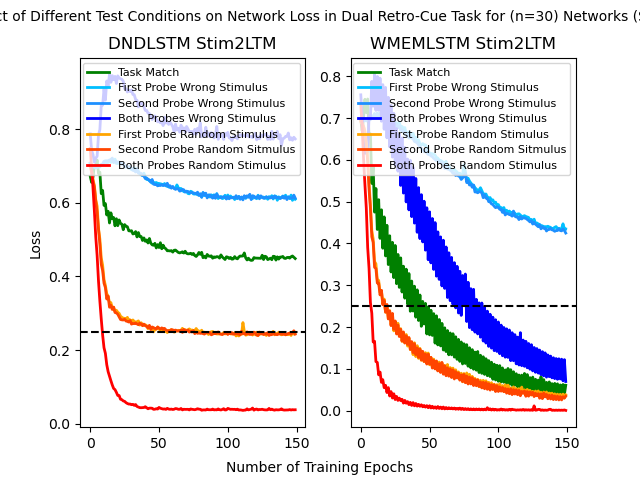

In [74]:
### Specific Plots for WMEM DRC Task ###

### DNDLSTM - Stim2LTM ###

mean_sample_loss_small_dndlstmcell_stimuli2ltm_drc_dict, sample_losses_small_dndlstmcell_stimuli2ltm_drc_dict = partition_sample_losses("dual_retro_cue", mean_sample_loss_small_dndlstmcell_stimuli2ltm_drc, sample_losses_small_dndlstmcell_stimuli2ltm_drc)

task0_mean_loss = mean_sample_loss_small_dndlstmcell_stimuli2ltm_drc_dict[0]
task1_mean_loss = mean_sample_loss_small_dndlstmcell_stimuli2ltm_drc_dict[1]
task2_mean_loss = mean_sample_loss_small_dndlstmcell_stimuli2ltm_drc_dict[2]
task3_mean_loss = mean_sample_loss_small_dndlstmcell_stimuli2ltm_drc_dict[3]
task4_mean_loss = mean_sample_loss_small_dndlstmcell_stimuli2ltm_drc_dict[4]
task5_mean_loss = mean_sample_loss_small_dndlstmcell_stimuli2ltm_drc_dict[5]
task6_mean_loss = mean_sample_loss_small_dndlstmcell_stimuli2ltm_drc_dict[6]
task7_mean_loss = mean_sample_loss_small_dndlstmcell_stimuli2ltm_drc_dict[7]
task8_mean_loss = mean_sample_loss_small_dndlstmcell_stimuli2ltm_drc_dict[8]
task9_mean_loss = mean_sample_loss_small_dndlstmcell_stimuli2ltm_drc_dict[9]
task10_mean_loss = mean_sample_loss_small_dndlstmcell_stimuli2ltm_drc_dict[10]
task11_mean_loss = mean_sample_loss_small_dndlstmcell_stimuli2ltm_drc_dict[11]
task12_mean_loss = mean_sample_loss_small_dndlstmcell_stimuli2ltm_drc_dict[12]
task13_mean_loss = mean_sample_loss_small_dndlstmcell_stimuli2ltm_drc_dict[13]
task14_mean_loss = mean_sample_loss_small_dndlstmcell_stimuli2ltm_drc_dict[14]
task15_mean_loss = mean_sample_loss_small_dndlstmcell_stimuli2ltm_drc_dict[15]
task16_mean_loss = mean_sample_loss_small_dndlstmcell_stimuli2ltm_drc_dict[16]
task17_mean_loss = mean_sample_loss_small_dndlstmcell_stimuli2ltm_drc_dict[17]
task18_mean_loss = mean_sample_loss_small_dndlstmcell_stimuli2ltm_drc_dict[18]
task19_mean_loss = mean_sample_loss_small_dndlstmcell_stimuli2ltm_drc_dict[19]
task20_mean_loss = mean_sample_loss_small_dndlstmcell_stimuli2ltm_drc_dict[20]
task21_mean_loss = mean_sample_loss_small_dndlstmcell_stimuli2ltm_drc_dict[21]
task22_mean_loss = mean_sample_loss_small_dndlstmcell_stimuli2ltm_drc_dict[22]
task23_mean_loss = mean_sample_loss_small_dndlstmcell_stimuli2ltm_drc_dict[23]
task24_mean_loss = mean_sample_loss_small_dndlstmcell_stimuli2ltm_drc_dict[24]
task25_mean_loss = mean_sample_loss_small_dndlstmcell_stimuli2ltm_drc_dict[25]
task26_mean_loss = mean_sample_loss_small_dndlstmcell_stimuli2ltm_drc_dict[26]
task27_mean_loss = mean_sample_loss_small_dndlstmcell_stimuli2ltm_drc_dict[27]

task0_sample_losses = sample_losses_small_dndlstmcell_stimuli2ltm_drc_dict[0]
task1_sample_losses = sample_losses_small_dndlstmcell_stimuli2ltm_drc_dict[1]
task2_sample_losses = sample_losses_small_dndlstmcell_stimuli2ltm_drc_dict[2]
task3_sample_losses = sample_losses_small_dndlstmcell_stimuli2ltm_drc_dict[3]
task4_sample_losses = sample_losses_small_dndlstmcell_stimuli2ltm_drc_dict[4]
task5_sample_losses = sample_losses_small_dndlstmcell_stimuli2ltm_drc_dict[5]
task6_sample_losses = sample_losses_small_dndlstmcell_stimuli2ltm_drc_dict[6]
task7_sample_losses = sample_losses_small_dndlstmcell_stimuli2ltm_drc_dict[7]
task8_sample_losses = sample_losses_small_dndlstmcell_stimuli2ltm_drc_dict[8]
task9_sample_losses = sample_losses_small_dndlstmcell_stimuli2ltm_drc_dict[9]
task10_sample_losses = sample_losses_small_dndlstmcell_stimuli2ltm_drc_dict[10]
task11_sample_losses = sample_losses_small_dndlstmcell_stimuli2ltm_drc_dict[11]
task12_sample_losses = sample_losses_small_dndlstmcell_stimuli2ltm_drc_dict[12]
task13_sample_losses = sample_losses_small_dndlstmcell_stimuli2ltm_drc_dict[13]
task14_sample_losses = sample_losses_small_dndlstmcell_stimuli2ltm_drc_dict[14]
task15_sample_losses = sample_losses_small_dndlstmcell_stimuli2ltm_drc_dict[15]
task16_sample_losses = sample_losses_small_dndlstmcell_stimuli2ltm_drc_dict[16]
task17_sample_losses = sample_losses_small_dndlstmcell_stimuli2ltm_drc_dict[17]
task18_sample_losses = sample_losses_small_dndlstmcell_stimuli2ltm_drc_dict[18]
task19_sample_losses = sample_losses_small_dndlstmcell_stimuli2ltm_drc_dict[19]
task20_sample_losses = sample_losses_small_dndlstmcell_stimuli2ltm_drc_dict[20]
task21_sample_losses = sample_losses_small_dndlstmcell_stimuli2ltm_drc_dict[21]
task22_sample_losses = sample_losses_small_dndlstmcell_stimuli2ltm_drc_dict[22]
task23_sample_losses = sample_losses_small_dndlstmcell_stimuli2ltm_drc_dict[23]
task24_sample_losses = sample_losses_small_dndlstmcell_stimuli2ltm_drc_dict[24]
task25_sample_losses = sample_losses_small_dndlstmcell_stimuli2ltm_drc_dict[25]
task26_sample_losses = sample_losses_small_dndlstmcell_stimuli2ltm_drc_dict[26]
task27_sample_losses = sample_losses_small_dndlstmcell_stimuli2ltm_drc_dict[27]

# testing different cases when the same cues are made before the probes (Vanilla Working Memory Case)
match_losses_same_cues = [task1_mean_loss, task3_mean_loss]
first_probe_wrong_stimuli_losses_same_cues = [task12_mean_loss, task14_mean_loss]
first_probe_random_stimuli_losses_same_cues = [task13_mean_loss, task15_mean_loss]
second_probe_wrong_stimuli_losses_same_cues = [task16_mean_loss, task18_mean_loss]
second_probe_random_stimuli_losses_same_cues = [task17_mean_loss, task19_mean_loss]
both_probes_wrong_stimuli_losses_same_cues = [task24_mean_loss, task26_mean_loss]
both_probes_random_stimuli_losses_same_cues = [task25_mean_loss, task27_mean_loss]


# testing different cases when a different second cue is made before the second probe (ASWM case)
match_losses_different_cues = [task0_mean_loss, task2_mean_loss]
first_probe_wrong_stimuli_losses_different_cues = [task4_mean_loss, task6_mean_loss]
first_probe_random_stimuli_losses_different_cues = [task5_mean_loss, task7_mean_loss]
second_probe_wrong_stimuli_losses_different_cues = [task8_mean_loss, task10_mean_loss]
second_probe_random_stimuli_losses_different_cues = [task9_mean_loss, task11_mean_loss]
both_probes_wrong_stimuli_losses_different_cues = [task20_mean_loss, task22_mean_loss]
both_probes_random_stimuli_losses_different_cues = [task21_mean_loss, task23_mean_loss]

# get the mean losses for each of these 7 categories

match_losses_small_dndlstmcell_stimuli2ltm = match_losses_same_cues + match_losses_different_cues
first_probe_wrong_stimuli_losses_small_dndlstmcell_stimuli2ltm = first_probe_wrong_stimuli_losses_same_cues + first_probe_wrong_stimuli_losses_different_cues
first_probe_random_stimuli_losses_small_dndlstmcell_stimuli2ltm = first_probe_random_stimuli_losses_same_cues + first_probe_random_stimuli_losses_different_cues
second_probe_wrong_stimuli_losses_small_dndlstmcell_stimuli2ltm = second_probe_wrong_stimuli_losses_same_cues + second_probe_wrong_stimuli_losses_different_cues
second_probe_random_stimuli_losses_small_dndlstmcell_stimuli2ltm = second_probe_random_stimuli_losses_same_cues + second_probe_random_stimuli_losses_different_cues
both_probes_wrong_stimuli_losses_small_dndlstmcell_stimuli2ltm = both_probes_wrong_stimuli_losses_same_cues + both_probes_wrong_stimuli_losses_different_cues
both_probes_random_stimuli_losses_small_dndlstmcell_stimuli2ltm = both_probes_random_stimuli_losses_same_cues + both_probes_random_stimuli_losses_different_cues


match_mean_losses_small_dndlstmcell_stimuli2ltm = np.mean(match_losses_small_dndlstmcell_stimuli2ltm, axis=0)
first_probe_wrong_stimuli_mean_losses_small_dndlstmcell_stimuli2ltm = np.mean(first_probe_wrong_stimuli_losses_small_dndlstmcell_stimuli2ltm, axis=0)
first_probe_random_stimuli_mean_losses_small_dndlstmcell_stimuli2ltm = np.mean(first_probe_random_stimuli_losses_small_dndlstmcell_stimuli2ltm, axis=0)
second_probe_wrong_stimuli_mean_losses_small_dndlstmcell_stimuli2ltm = np.mean(second_probe_wrong_stimuli_losses_small_dndlstmcell_stimuli2ltm, axis=0)
second_probe_random_stimuli_mean_losses_small_dndlstmcell_stimuli2ltm = np.mean(second_probe_random_stimuli_losses_small_dndlstmcell_stimuli2ltm, axis=0)
both_probes_wrong_stimuli_mean_losses_small_dndlstmcell_stimuli2ltm = np.mean(both_probes_wrong_stimuli_losses_small_dndlstmcell_stimuli2ltm, axis=0)
both_probes_random_stimuli_mean_losses_small_dndlstmcell_stimuli2ltm = np.mean(both_probes_random_stimuli_losses_small_dndlstmcell_stimuli2ltm, axis=0)

### Specific Plots for WMEM DRC Task ###

### WMEM - Stimuli2LTM ###

mean_sample_loss_small_wmemlstmcell_stimuli2ltm_drc_dict, sample_losses_small_wmemlstmcell_stimuli2ltm_drc_dict = partition_sample_losses("dual_retro_cue", mean_sample_loss_small_wmemlstmcell_stimuli2ltm_drc, sample_losses_small_wmemlstmcell_stimuli2ltm_drc)

task0_mean_loss = mean_sample_loss_small_wmemlstmcell_stimuli2ltm_drc_dict[0]
task1_mean_loss = mean_sample_loss_small_wmemlstmcell_stimuli2ltm_drc_dict[1]
task2_mean_loss = mean_sample_loss_small_wmemlstmcell_stimuli2ltm_drc_dict[2]
task3_mean_loss = mean_sample_loss_small_wmemlstmcell_stimuli2ltm_drc_dict[3]
task4_mean_loss = mean_sample_loss_small_wmemlstmcell_stimuli2ltm_drc_dict[4]
task5_mean_loss = mean_sample_loss_small_wmemlstmcell_stimuli2ltm_drc_dict[5]
task6_mean_loss = mean_sample_loss_small_wmemlstmcell_stimuli2ltm_drc_dict[6]
task7_mean_loss = mean_sample_loss_small_wmemlstmcell_stimuli2ltm_drc_dict[7]
task8_mean_loss = mean_sample_loss_small_wmemlstmcell_stimuli2ltm_drc_dict[8]
task9_mean_loss = mean_sample_loss_small_wmemlstmcell_stimuli2ltm_drc_dict[9]
task10_mean_loss = mean_sample_loss_small_wmemlstmcell_stimuli2ltm_drc_dict[10]
task11_mean_loss = mean_sample_loss_small_wmemlstmcell_stimuli2ltm_drc_dict[11]
task12_mean_loss = mean_sample_loss_small_wmemlstmcell_stimuli2ltm_drc_dict[12]
task13_mean_loss = mean_sample_loss_small_wmemlstmcell_stimuli2ltm_drc_dict[13]
task14_mean_loss = mean_sample_loss_small_wmemlstmcell_stimuli2ltm_drc_dict[14]
task15_mean_loss = mean_sample_loss_small_wmemlstmcell_stimuli2ltm_drc_dict[15]
task16_mean_loss = mean_sample_loss_small_wmemlstmcell_stimuli2ltm_drc_dict[16]
task17_mean_loss = mean_sample_loss_small_wmemlstmcell_stimuli2ltm_drc_dict[17]
task18_mean_loss = mean_sample_loss_small_wmemlstmcell_stimuli2ltm_drc_dict[18]
task19_mean_loss = mean_sample_loss_small_wmemlstmcell_stimuli2ltm_drc_dict[19]
task20_mean_loss = mean_sample_loss_small_wmemlstmcell_stimuli2ltm_drc_dict[20]
task21_mean_loss = mean_sample_loss_small_wmemlstmcell_stimuli2ltm_drc_dict[21]
task22_mean_loss = mean_sample_loss_small_wmemlstmcell_stimuli2ltm_drc_dict[22]
task23_mean_loss = mean_sample_loss_small_wmemlstmcell_stimuli2ltm_drc_dict[23]
task24_mean_loss = mean_sample_loss_small_wmemlstmcell_stimuli2ltm_drc_dict[24]
task25_mean_loss = mean_sample_loss_small_wmemlstmcell_stimuli2ltm_drc_dict[25]
task26_mean_loss = mean_sample_loss_small_wmemlstmcell_stimuli2ltm_drc_dict[26]
task27_mean_loss = mean_sample_loss_small_wmemlstmcell_stimuli2ltm_drc_dict[27]

task0_sample_losses = sample_losses_small_wmemlstmcell_stimuli2ltm_drc_dict[0]
task1_sample_losses = sample_losses_small_wmemlstmcell_stimuli2ltm_drc_dict[1]
task2_sample_losses = sample_losses_small_wmemlstmcell_stimuli2ltm_drc_dict[2]
task3_sample_losses = sample_losses_small_wmemlstmcell_stimuli2ltm_drc_dict[3]
task4_sample_losses = sample_losses_small_wmemlstmcell_stimuli2ltm_drc_dict[4]
task5_sample_losses = sample_losses_small_wmemlstmcell_stimuli2ltm_drc_dict[5]
task6_sample_losses = sample_losses_small_wmemlstmcell_stimuli2ltm_drc_dict[6]
task7_sample_losses = sample_losses_small_wmemlstmcell_stimuli2ltm_drc_dict[7]
task8_sample_losses = sample_losses_small_wmemlstmcell_stimuli2ltm_drc_dict[8]
task9_sample_losses = sample_losses_small_wmemlstmcell_stimuli2ltm_drc_dict[9]
task10_sample_losses = sample_losses_small_wmemlstmcell_stimuli2ltm_drc_dict[10]
task11_sample_losses = sample_losses_small_wmemlstmcell_stimuli2ltm_drc_dict[11]
task12_sample_losses = sample_losses_small_wmemlstmcell_stimuli2ltm_drc_dict[12]
task13_sample_losses = sample_losses_small_wmemlstmcell_stimuli2ltm_drc_dict[13]
task14_sample_losses = sample_losses_small_wmemlstmcell_stimuli2ltm_drc_dict[14]
task15_sample_losses = sample_losses_small_wmemlstmcell_stimuli2ltm_drc_dict[15]
task16_sample_losses = sample_losses_small_wmemlstmcell_stimuli2ltm_drc_dict[16]
task17_sample_losses = sample_losses_small_wmemlstmcell_stimuli2ltm_drc_dict[17]
task18_sample_losses = sample_losses_small_wmemlstmcell_stimuli2ltm_drc_dict[18]
task19_sample_losses = sample_losses_small_wmemlstmcell_stimuli2ltm_drc_dict[19]
task20_sample_losses = sample_losses_small_wmemlstmcell_stimuli2ltm_drc_dict[20]
task21_sample_losses = sample_losses_small_wmemlstmcell_stimuli2ltm_drc_dict[21]
task22_sample_losses = sample_losses_small_wmemlstmcell_stimuli2ltm_drc_dict[22]
task23_sample_losses = sample_losses_small_wmemlstmcell_stimuli2ltm_drc_dict[23]
task24_sample_losses = sample_losses_small_wmemlstmcell_stimuli2ltm_drc_dict[24]
task25_sample_losses = sample_losses_small_wmemlstmcell_stimuli2ltm_drc_dict[25]
task26_sample_losses = sample_losses_small_wmemlstmcell_stimuli2ltm_drc_dict[26]
task27_sample_losses = sample_losses_small_wmemlstmcell_stimuli2ltm_drc_dict[27]

# testing different cases when the same cues are made before the probes (Vanilla Working Memory Case)
match_losses_same_cues = [task1_mean_loss, task3_mean_loss]
first_probe_wrong_stimuli_losses_same_cues = [task12_mean_loss, task14_mean_loss]
first_probe_random_stimuli_losses_same_cues = [task13_mean_loss, task15_mean_loss]
second_probe_wrong_stimuli_losses_same_cues = [task16_mean_loss, task18_mean_loss]
second_probe_random_stimuli_losses_same_cues = [task17_mean_loss, task19_mean_loss]
both_probes_wrong_stimuli_losses_same_cues = [task24_mean_loss, task26_mean_loss]
both_probes_random_stimuli_losses_same_cues = [task25_mean_loss, task27_mean_loss]


# testing different cases when a different second cue is made before the second probe (ASWM case)
match_losses_different_cues = [task0_mean_loss, task2_mean_loss]
first_probe_wrong_stimuli_losses_different_cues = [task4_mean_loss, task6_mean_loss]
first_probe_random_stimuli_losses_different_cues = [task5_mean_loss, task7_mean_loss]
second_probe_wrong_stimuli_losses_different_cues = [task8_mean_loss, task10_mean_loss]
second_probe_random_stimuli_losses_different_cues = [task9_mean_loss, task11_mean_loss]
both_probes_wrong_stimuli_losses_different_cues = [task20_mean_loss, task22_mean_loss]
both_probes_random_stimuli_losses_different_cues = [task21_mean_loss, task23_mean_loss]

# get the mean losses for each of these 7 categories

match_losses_small_wmemlstmcell_stimuli2ltm = match_losses_same_cues + match_losses_different_cues
first_probe_wrong_stimuli_losses_small_wmemlstmcell_stimuli2ltm = first_probe_wrong_stimuli_losses_same_cues + first_probe_wrong_stimuli_losses_different_cues
first_probe_random_stimuli_losses_small_wmemlstmcell_stimuli2ltm = first_probe_random_stimuli_losses_same_cues + first_probe_random_stimuli_losses_different_cues
second_probe_wrong_stimuli_losses_small_wmemlstmcell_stimuli2ltm = second_probe_wrong_stimuli_losses_same_cues + second_probe_wrong_stimuli_losses_different_cues
second_probe_random_stimuli_losses_small_wmemlstmcell_stimuli2ltm = second_probe_random_stimuli_losses_same_cues + second_probe_random_stimuli_losses_different_cues
both_probes_wrong_stimuli_losses_small_wmemlstmcell_stimuli2ltm = both_probes_wrong_stimuli_losses_same_cues + both_probes_wrong_stimuli_losses_different_cues
both_probes_random_stimuli_losses_small_wmemlstmcell_stimuli2ltm = both_probes_random_stimuli_losses_same_cues + both_probes_random_stimuli_losses_different_cues


match_mean_losses_small_wmemlstmcell_stimuli2ltm = np.mean(match_losses_small_wmemlstmcell_stimuli2ltm, axis=0)
first_probe_wrong_stimuli_mean_losses_small_wmemlstmcell_stimuli2ltm = np.mean(first_probe_wrong_stimuli_losses_small_wmemlstmcell_stimuli2ltm, axis=0)
first_probe_random_stimuli_mean_losses_small_wmemlstmcell_stimuli2ltm = np.mean(first_probe_random_stimuli_losses_small_wmemlstmcell_stimuli2ltm, axis=0)
second_probe_wrong_stimuli_mean_losses_small_wmemlstmcell_stimuli2ltm = np.mean(second_probe_wrong_stimuli_losses_small_wmemlstmcell_stimuli2ltm, axis=0)
second_probe_random_stimuli_mean_losses_small_wmemlstmcell_stimuli2ltm = np.mean(second_probe_random_stimuli_losses_small_wmemlstmcell_stimuli2ltm, axis=0)
both_probes_wrong_stimuli_mean_losses_small_wmemlstmcell_stimuli2ltm = np.mean(both_probes_wrong_stimuli_losses_small_wmemlstmcell_stimuli2ltm, axis=0)
both_probes_random_stimuli_mean_losses_small_wmemlstmcell_stimuli2ltm = np.mean(both_probes_random_stimuli_losses_small_wmemlstmcell_stimuli2ltm, axis=0)


fig, ax = plt.subplots(1,2)

# plot losses
fig.suptitle("Average Effect of Different Test Conditions on Network Loss in Dual Retro-Cue Task for (n=" + str(num_networks) + ") Networks (Small Delays)", fontsize=10)

# Individual losses for each sample type (where the same stimulus is cued each round)
ax[0].set_title("DNDLSTM Stim2LTM")
ax[0].plot(match_mean_losses_small_dndlstmcell_stimuli2ltm, color='green', label="Task Match", linewidth=2)
ax[0].plot(first_probe_wrong_stimuli_mean_losses_small_dndlstmcell_stimuli2ltm, color='deepskyblue', label="First Probe Wrong Stimulus", linewidth=2)
ax[0].plot(second_probe_wrong_stimuli_mean_losses_small_dndlstmcell_stimuli2ltm, color='dodgerblue', label="Second Probe Wrong Stimulus", linewidth=2)
ax[0].plot(both_probes_wrong_stimuli_mean_losses_small_dndlstmcell_stimuli2ltm, color='blue', label="Both Probes Wrong Stimulus", linewidth=2)
ax[0].plot(first_probe_random_stimuli_mean_losses_small_dndlstmcell_stimuli2ltm, color='orange', label="First Probe Random Stimulus", linewidth=2)
ax[0].plot(second_probe_random_stimuli_mean_losses_small_dndlstmcell_stimuli2ltm, color='orangered', label="Second Probe Random Sitmulus", linewidth=2)
ax[0].plot(both_probes_random_stimuli_mean_losses_small_dndlstmcell_stimuli2ltm, color='red', label="Both Probes Random Stimulus", linewidth=2)

# Individual losses for each sample type (where a different stimulus is cued each round)
ax[1].set_title("WMEMLSTM Stim2LTM")
ax[1].plot(match_mean_losses_small_wmemlstmcell_stimuli2ltm, color='green', label="Task Match", linewidth=2)
ax[1].plot(first_probe_wrong_stimuli_mean_losses_small_wmemlstmcell_stimuli2ltm, color='deepskyblue', label="First Probe Wrong Stimulus", linewidth=2)
ax[1].plot(second_probe_wrong_stimuli_mean_losses_small_wmemlstmcell_stimuli2ltm, color='dodgerblue', label="Second Probe Wrong Stimulus", linewidth=2)
ax[1].plot(both_probes_wrong_stimuli_mean_losses_small_wmemlstmcell_stimuli2ltm, color='blue', label="Both Probes Wrong Stimulus", linewidth=2)
ax[1].plot(first_probe_random_stimuli_mean_losses_small_wmemlstmcell_stimuli2ltm, color='orange', label="First Probe Random Stimulus", linewidth=2)
ax[1].plot(second_probe_random_stimuli_mean_losses_small_wmemlstmcell_stimuli2ltm, color='orangered', label="Second Probe Random Sitmulus", linewidth=2)
ax[1].plot(both_probes_random_stimuli_mean_losses_small_wmemlstmcell_stimuli2ltm, color='red', label="Both Probes Random Stimulus", linewidth=2)

# Threshold line
ax[0].axhline(threshold, linestyle='dashed', color='black')
ax[1].axhline(threshold, linestyle='dashed', color='black')

# legend and show plot
ax[0].legend(fontsize=8, loc="upper right") # by default, the legend ignores all elements without a label attribute set.
ax[1].legend(fontsize=8, loc="upper right") # by default, the legend ignores all elements without a label attribute set.

fig.supxlabel('Number of Training Epochs', fontsize=10) # x label
ax[0].set_ylabel('Loss', fontsize=10) # y label

plt.show()

#### *Graph on Each Trial Type for WMEM vs WM + EM LSTMs on the Dual Retro-Cue Task (Large Delays)*

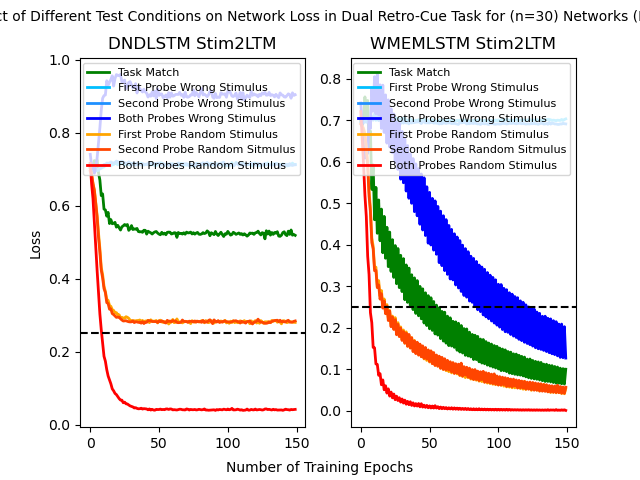

In [75]:
### Specific Plots for WMEM DRC Task ###

### DNDLSTM - Stim2LTM ###

mean_sample_loss_large_dndlstmcell_stimuli2ltm_drc_dict, sample_losses_large_dndlstmcell_stimuli2ltm_drc_dict = partition_sample_losses("dual_retro_cue", mean_sample_loss_large_dndlstmcell_stimuli2ltm_drc, sample_losses_large_dndlstmcell_stimuli2ltm_drc)

task0_mean_loss = mean_sample_loss_large_dndlstmcell_stimuli2ltm_drc_dict[0]
task1_mean_loss = mean_sample_loss_large_dndlstmcell_stimuli2ltm_drc_dict[1]
task2_mean_loss = mean_sample_loss_large_dndlstmcell_stimuli2ltm_drc_dict[2]
task3_mean_loss = mean_sample_loss_large_dndlstmcell_stimuli2ltm_drc_dict[3]
task4_mean_loss = mean_sample_loss_large_dndlstmcell_stimuli2ltm_drc_dict[4]
task5_mean_loss = mean_sample_loss_large_dndlstmcell_stimuli2ltm_drc_dict[5]
task6_mean_loss = mean_sample_loss_large_dndlstmcell_stimuli2ltm_drc_dict[6]
task7_mean_loss = mean_sample_loss_large_dndlstmcell_stimuli2ltm_drc_dict[7]
task8_mean_loss = mean_sample_loss_large_dndlstmcell_stimuli2ltm_drc_dict[8]
task9_mean_loss = mean_sample_loss_large_dndlstmcell_stimuli2ltm_drc_dict[9]
task10_mean_loss = mean_sample_loss_large_dndlstmcell_stimuli2ltm_drc_dict[10]
task11_mean_loss = mean_sample_loss_large_dndlstmcell_stimuli2ltm_drc_dict[11]
task12_mean_loss = mean_sample_loss_large_dndlstmcell_stimuli2ltm_drc_dict[12]
task13_mean_loss = mean_sample_loss_large_dndlstmcell_stimuli2ltm_drc_dict[13]
task14_mean_loss = mean_sample_loss_large_dndlstmcell_stimuli2ltm_drc_dict[14]
task15_mean_loss = mean_sample_loss_large_dndlstmcell_stimuli2ltm_drc_dict[15]
task16_mean_loss = mean_sample_loss_large_dndlstmcell_stimuli2ltm_drc_dict[16]
task17_mean_loss = mean_sample_loss_large_dndlstmcell_stimuli2ltm_drc_dict[17]
task18_mean_loss = mean_sample_loss_large_dndlstmcell_stimuli2ltm_drc_dict[18]
task19_mean_loss = mean_sample_loss_large_dndlstmcell_stimuli2ltm_drc_dict[19]
task20_mean_loss = mean_sample_loss_large_dndlstmcell_stimuli2ltm_drc_dict[20]
task21_mean_loss = mean_sample_loss_large_dndlstmcell_stimuli2ltm_drc_dict[21]
task22_mean_loss = mean_sample_loss_large_dndlstmcell_stimuli2ltm_drc_dict[22]
task23_mean_loss = mean_sample_loss_large_dndlstmcell_stimuli2ltm_drc_dict[23]
task24_mean_loss = mean_sample_loss_large_dndlstmcell_stimuli2ltm_drc_dict[24]
task25_mean_loss = mean_sample_loss_large_dndlstmcell_stimuli2ltm_drc_dict[25]
task26_mean_loss = mean_sample_loss_large_dndlstmcell_stimuli2ltm_drc_dict[26]
task27_mean_loss = mean_sample_loss_large_dndlstmcell_stimuli2ltm_drc_dict[27]

task0_sample_losses = sample_losses_large_dndlstmcell_stimuli2ltm_drc_dict[0]
task1_sample_losses = sample_losses_large_dndlstmcell_stimuli2ltm_drc_dict[1]
task2_sample_losses = sample_losses_large_dndlstmcell_stimuli2ltm_drc_dict[2]
task3_sample_losses = sample_losses_large_dndlstmcell_stimuli2ltm_drc_dict[3]
task4_sample_losses = sample_losses_large_dndlstmcell_stimuli2ltm_drc_dict[4]
task5_sample_losses = sample_losses_large_dndlstmcell_stimuli2ltm_drc_dict[5]
task6_sample_losses = sample_losses_large_dndlstmcell_stimuli2ltm_drc_dict[6]
task7_sample_losses = sample_losses_large_dndlstmcell_stimuli2ltm_drc_dict[7]
task8_sample_losses = sample_losses_large_dndlstmcell_stimuli2ltm_drc_dict[8]
task9_sample_losses = sample_losses_large_dndlstmcell_stimuli2ltm_drc_dict[9]
task10_sample_losses = sample_losses_large_dndlstmcell_stimuli2ltm_drc_dict[10]
task11_sample_losses = sample_losses_large_dndlstmcell_stimuli2ltm_drc_dict[11]
task12_sample_losses = sample_losses_large_dndlstmcell_stimuli2ltm_drc_dict[12]
task13_sample_losses = sample_losses_large_dndlstmcell_stimuli2ltm_drc_dict[13]
task14_sample_losses = sample_losses_large_dndlstmcell_stimuli2ltm_drc_dict[14]
task15_sample_losses = sample_losses_large_dndlstmcell_stimuli2ltm_drc_dict[15]
task16_sample_losses = sample_losses_large_dndlstmcell_stimuli2ltm_drc_dict[16]
task17_sample_losses = sample_losses_large_dndlstmcell_stimuli2ltm_drc_dict[17]
task18_sample_losses = sample_losses_large_dndlstmcell_stimuli2ltm_drc_dict[18]
task19_sample_losses = sample_losses_large_dndlstmcell_stimuli2ltm_drc_dict[19]
task20_sample_losses = sample_losses_large_dndlstmcell_stimuli2ltm_drc_dict[20]
task21_sample_losses = sample_losses_large_dndlstmcell_stimuli2ltm_drc_dict[21]
task22_sample_losses = sample_losses_large_dndlstmcell_stimuli2ltm_drc_dict[22]
task23_sample_losses = sample_losses_large_dndlstmcell_stimuli2ltm_drc_dict[23]
task24_sample_losses = sample_losses_large_dndlstmcell_stimuli2ltm_drc_dict[24]
task25_sample_losses = sample_losses_large_dndlstmcell_stimuli2ltm_drc_dict[25]
task26_sample_losses = sample_losses_large_dndlstmcell_stimuli2ltm_drc_dict[26]
task27_sample_losses = sample_losses_large_dndlstmcell_stimuli2ltm_drc_dict[27]

# testing different cases when the same cues are made before the probes (Vanilla Working Memory Case)
match_losses_same_cues = [task1_mean_loss, task3_mean_loss]
first_probe_wrong_stimuli_losses_same_cues = [task12_mean_loss, task14_mean_loss]
first_probe_random_stimuli_losses_same_cues = [task13_mean_loss, task15_mean_loss]
second_probe_wrong_stimuli_losses_same_cues = [task16_mean_loss, task18_mean_loss]
second_probe_random_stimuli_losses_same_cues = [task17_mean_loss, task19_mean_loss]
both_probes_wrong_stimuli_losses_same_cues = [task24_mean_loss, task26_mean_loss]
both_probes_random_stimuli_losses_same_cues = [task25_mean_loss, task27_mean_loss]


# testing different cases when a different second cue is made before the second probe (ASWM case)
match_losses_different_cues = [task0_mean_loss, task2_mean_loss]
first_probe_wrong_stimuli_losses_different_cues = [task4_mean_loss, task6_mean_loss]
first_probe_random_stimuli_losses_different_cues = [task5_mean_loss, task7_mean_loss]
second_probe_wrong_stimuli_losses_different_cues = [task8_mean_loss, task10_mean_loss]
second_probe_random_stimuli_losses_different_cues = [task9_mean_loss, task11_mean_loss]
both_probes_wrong_stimuli_losses_different_cues = [task20_mean_loss, task22_mean_loss]
both_probes_random_stimuli_losses_different_cues = [task21_mean_loss, task23_mean_loss]

# get the mean losses for each of these 7 categories

match_losses_large_dndlstmcell_stimuli2ltm = match_losses_same_cues + match_losses_different_cues
first_probe_wrong_stimuli_losses_large_dndlstmcell_stimuli2ltm = first_probe_wrong_stimuli_losses_same_cues + first_probe_wrong_stimuli_losses_different_cues
first_probe_random_stimuli_losses_large_dndlstmcell_stimuli2ltm = first_probe_random_stimuli_losses_same_cues + first_probe_random_stimuli_losses_different_cues
second_probe_wrong_stimuli_losses_large_dndlstmcell_stimuli2ltm = second_probe_wrong_stimuli_losses_same_cues + second_probe_wrong_stimuli_losses_different_cues
second_probe_random_stimuli_losses_large_dndlstmcell_stimuli2ltm = second_probe_random_stimuli_losses_same_cues + second_probe_random_stimuli_losses_different_cues
both_probes_wrong_stimuli_losses_large_dndlstmcell_stimuli2ltm = both_probes_wrong_stimuli_losses_same_cues + both_probes_wrong_stimuli_losses_different_cues
both_probes_random_stimuli_losses_large_dndlstmcell_stimuli2ltm = both_probes_random_stimuli_losses_same_cues + both_probes_random_stimuli_losses_different_cues


match_mean_losses_large_dndlstmcell_stimuli2ltm = np.mean(match_losses_large_dndlstmcell_stimuli2ltm, axis=0)
first_probe_wrong_stimuli_mean_losses_large_dndlstmcell_stimuli2ltm = np.mean(first_probe_wrong_stimuli_losses_large_dndlstmcell_stimuli2ltm, axis=0)
first_probe_random_stimuli_mean_losses_large_dndlstmcell_stimuli2ltm = np.mean(first_probe_random_stimuli_losses_large_dndlstmcell_stimuli2ltm, axis=0)
second_probe_wrong_stimuli_mean_losses_large_dndlstmcell_stimuli2ltm = np.mean(second_probe_wrong_stimuli_losses_large_dndlstmcell_stimuli2ltm, axis=0)
second_probe_random_stimuli_mean_losses_large_dndlstmcell_stimuli2ltm = np.mean(second_probe_random_stimuli_losses_large_dndlstmcell_stimuli2ltm, axis=0)
both_probes_wrong_stimuli_mean_losses_large_dndlstmcell_stimuli2ltm = np.mean(both_probes_wrong_stimuli_losses_large_dndlstmcell_stimuli2ltm, axis=0)
both_probes_random_stimuli_mean_losses_large_dndlstmcell_stimuli2ltm = np.mean(both_probes_random_stimuli_losses_large_dndlstmcell_stimuli2ltm, axis=0)

### Specific Plots for WMEM DRC Task ###

### DNDLSTM - Cues2LTM ###

mean_sample_loss_large_wmemlstmcell_stimuli2ltm_drc_dict, sample_losses_large_wmemlstmcell_stimuli2ltm_drc_dict = partition_sample_losses("dual_retro_cue", mean_sample_loss_large_wmemlstmcell_stimuli2ltm_drc, sample_losses_large_wmemlstmcell_stimuli2ltm_drc)

task0_mean_loss = mean_sample_loss_large_wmemlstmcell_stimuli2ltm_drc_dict[0]
task1_mean_loss = mean_sample_loss_large_wmemlstmcell_stimuli2ltm_drc_dict[1]
task2_mean_loss = mean_sample_loss_large_wmemlstmcell_stimuli2ltm_drc_dict[2]
task3_mean_loss = mean_sample_loss_large_wmemlstmcell_stimuli2ltm_drc_dict[3]
task4_mean_loss = mean_sample_loss_large_wmemlstmcell_stimuli2ltm_drc_dict[4]
task5_mean_loss = mean_sample_loss_large_wmemlstmcell_stimuli2ltm_drc_dict[5]
task6_mean_loss = mean_sample_loss_large_wmemlstmcell_stimuli2ltm_drc_dict[6]
task7_mean_loss = mean_sample_loss_large_wmemlstmcell_stimuli2ltm_drc_dict[7]
task8_mean_loss = mean_sample_loss_large_wmemlstmcell_stimuli2ltm_drc_dict[8]
task9_mean_loss = mean_sample_loss_large_wmemlstmcell_stimuli2ltm_drc_dict[9]
task10_mean_loss = mean_sample_loss_large_wmemlstmcell_stimuli2ltm_drc_dict[10]
task11_mean_loss = mean_sample_loss_large_wmemlstmcell_stimuli2ltm_drc_dict[11]
task12_mean_loss = mean_sample_loss_large_wmemlstmcell_stimuli2ltm_drc_dict[12]
task13_mean_loss = mean_sample_loss_large_wmemlstmcell_stimuli2ltm_drc_dict[13]
task14_mean_loss = mean_sample_loss_large_wmemlstmcell_stimuli2ltm_drc_dict[14]
task15_mean_loss = mean_sample_loss_large_wmemlstmcell_stimuli2ltm_drc_dict[15]
task16_mean_loss = mean_sample_loss_large_wmemlstmcell_stimuli2ltm_drc_dict[16]
task17_mean_loss = mean_sample_loss_large_wmemlstmcell_stimuli2ltm_drc_dict[17]
task18_mean_loss = mean_sample_loss_large_wmemlstmcell_stimuli2ltm_drc_dict[18]
task19_mean_loss = mean_sample_loss_large_wmemlstmcell_stimuli2ltm_drc_dict[19]
task20_mean_loss = mean_sample_loss_large_wmemlstmcell_stimuli2ltm_drc_dict[20]
task21_mean_loss = mean_sample_loss_large_wmemlstmcell_stimuli2ltm_drc_dict[21]
task22_mean_loss = mean_sample_loss_large_wmemlstmcell_stimuli2ltm_drc_dict[22]
task23_mean_loss = mean_sample_loss_large_wmemlstmcell_stimuli2ltm_drc_dict[23]
task24_mean_loss = mean_sample_loss_large_wmemlstmcell_stimuli2ltm_drc_dict[24]
task25_mean_loss = mean_sample_loss_large_wmemlstmcell_stimuli2ltm_drc_dict[25]
task26_mean_loss = mean_sample_loss_large_wmemlstmcell_stimuli2ltm_drc_dict[26]
task27_mean_loss = mean_sample_loss_large_wmemlstmcell_stimuli2ltm_drc_dict[27]

task0_sample_losses = sample_losses_large_wmemlstmcell_stimuli2ltm_drc_dict[0]
task1_sample_losses = sample_losses_large_wmemlstmcell_stimuli2ltm_drc_dict[1]
task2_sample_losses = sample_losses_large_wmemlstmcell_stimuli2ltm_drc_dict[2]
task3_sample_losses = sample_losses_large_wmemlstmcell_stimuli2ltm_drc_dict[3]
task4_sample_losses = sample_losses_large_wmemlstmcell_stimuli2ltm_drc_dict[4]
task5_sample_losses = sample_losses_large_wmemlstmcell_stimuli2ltm_drc_dict[5]
task6_sample_losses = sample_losses_large_wmemlstmcell_stimuli2ltm_drc_dict[6]
task7_sample_losses = sample_losses_large_wmemlstmcell_stimuli2ltm_drc_dict[7]
task8_sample_losses = sample_losses_large_wmemlstmcell_stimuli2ltm_drc_dict[8]
task9_sample_losses = sample_losses_large_wmemlstmcell_stimuli2ltm_drc_dict[9]
task10_sample_losses = sample_losses_large_wmemlstmcell_stimuli2ltm_drc_dict[10]
task11_sample_losses = sample_losses_large_wmemlstmcell_stimuli2ltm_drc_dict[11]
task12_sample_losses = sample_losses_large_wmemlstmcell_stimuli2ltm_drc_dict[12]
task13_sample_losses = sample_losses_large_wmemlstmcell_stimuli2ltm_drc_dict[13]
task14_sample_losses = sample_losses_large_wmemlstmcell_stimuli2ltm_drc_dict[14]
task15_sample_losses = sample_losses_large_wmemlstmcell_stimuli2ltm_drc_dict[15]
task16_sample_losses = sample_losses_large_wmemlstmcell_stimuli2ltm_drc_dict[16]
task17_sample_losses = sample_losses_large_wmemlstmcell_stimuli2ltm_drc_dict[17]
task18_sample_losses = sample_losses_large_wmemlstmcell_stimuli2ltm_drc_dict[18]
task19_sample_losses = sample_losses_large_wmemlstmcell_stimuli2ltm_drc_dict[19]
task20_sample_losses = sample_losses_large_wmemlstmcell_stimuli2ltm_drc_dict[20]
task21_sample_losses = sample_losses_large_wmemlstmcell_stimuli2ltm_drc_dict[21]
task22_sample_losses = sample_losses_large_wmemlstmcell_stimuli2ltm_drc_dict[22]
task23_sample_losses = sample_losses_large_wmemlstmcell_stimuli2ltm_drc_dict[23]
task24_sample_losses = sample_losses_large_wmemlstmcell_stimuli2ltm_drc_dict[24]
task25_sample_losses = sample_losses_large_wmemlstmcell_stimuli2ltm_drc_dict[25]
task26_sample_losses = sample_losses_large_wmemlstmcell_stimuli2ltm_drc_dict[26]
task27_sample_losses = sample_losses_large_wmemlstmcell_stimuli2ltm_drc_dict[27]

# testing different cases when the same cues are made before the probes (Vanilla Working Memory Case)
match_losses_same_cues = [task1_mean_loss, task3_mean_loss]
first_probe_wrong_stimuli_losses_same_cues = [task12_mean_loss, task14_mean_loss]
first_probe_random_stimuli_losses_same_cues = [task13_mean_loss, task15_mean_loss]
second_probe_wrong_stimuli_losses_same_cues = [task16_mean_loss, task18_mean_loss]
second_probe_random_stimuli_losses_same_cues = [task17_mean_loss, task19_mean_loss]
both_probes_wrong_stimuli_losses_same_cues = [task24_mean_loss, task26_mean_loss]
both_probes_random_stimuli_losses_same_cues = [task25_mean_loss, task27_mean_loss]


# testing different cases when a different second cue is made before the second probe (ASWM case)
match_losses_different_cues = [task0_mean_loss, task2_mean_loss]
first_probe_wrong_stimuli_losses_different_cues = [task4_mean_loss, task6_mean_loss]
first_probe_random_stimuli_losses_different_cues = [task5_mean_loss, task7_mean_loss]
second_probe_wrong_stimuli_losses_different_cues = [task8_mean_loss, task10_mean_loss]
second_probe_random_stimuli_losses_different_cues = [task9_mean_loss, task11_mean_loss]
both_probes_wrong_stimuli_losses_different_cues = [task20_mean_loss, task22_mean_loss]
both_probes_random_stimuli_losses_different_cues = [task21_mean_loss, task23_mean_loss]

# get the mean losses for each of these 7 categories

match_losses_large_wmemlstmcell_stimuli2ltm = match_losses_same_cues + match_losses_different_cues
first_probe_wrong_stimuli_losses_large_wmemlstmcell_stimuli2ltm = first_probe_wrong_stimuli_losses_same_cues + first_probe_wrong_stimuli_losses_different_cues
first_probe_random_stimuli_losses_large_wmemlstmcell_stimuli2ltm = first_probe_random_stimuli_losses_same_cues + first_probe_random_stimuli_losses_different_cues
second_probe_wrong_stimuli_losses_large_wmemlstmcell_stimuli2ltm = second_probe_wrong_stimuli_losses_same_cues + second_probe_wrong_stimuli_losses_different_cues
second_probe_random_stimuli_losses_large_wmemlstmcell_stimuli2ltm = second_probe_random_stimuli_losses_same_cues + second_probe_random_stimuli_losses_different_cues
both_probes_wrong_stimuli_losses_large_wmemlstmcell_stimuli2ltm = both_probes_wrong_stimuli_losses_same_cues + both_probes_wrong_stimuli_losses_different_cues
both_probes_random_stimuli_losses_large_wmemlstmcell_stimuli2ltm = both_probes_random_stimuli_losses_same_cues + both_probes_random_stimuli_losses_different_cues


match_mean_losses_large_wmemlstmcell_stimuli2ltm = np.mean(match_losses_large_wmemlstmcell_stimuli2ltm, axis=0)
first_probe_wrong_stimuli_mean_losses_large_wmemlstmcell_stimuli2ltm = np.mean(first_probe_wrong_stimuli_losses_large_wmemlstmcell_stimuli2ltm, axis=0)
first_probe_random_stimuli_mean_losses_large_wmemlstmcell_stimuli2ltm = np.mean(first_probe_random_stimuli_losses_large_wmemlstmcell_stimuli2ltm, axis=0)
second_probe_wrong_stimuli_mean_losses_large_wmemlstmcell_stimuli2ltm = np.mean(second_probe_wrong_stimuli_losses_large_wmemlstmcell_stimuli2ltm, axis=0)
second_probe_random_stimuli_mean_losses_large_wmemlstmcell_stimuli2ltm = np.mean(second_probe_random_stimuli_losses_large_wmemlstmcell_stimuli2ltm, axis=0)
both_probes_wrong_stimuli_mean_losses_large_wmemlstmcell_stimuli2ltm = np.mean(both_probes_wrong_stimuli_losses_large_wmemlstmcell_stimuli2ltm, axis=0)
both_probes_random_stimuli_mean_losses_large_wmemlstmcell_stimuli2ltm = np.mean(both_probes_random_stimuli_losses_large_wmemlstmcell_stimuli2ltm, axis=0)


fig, ax = plt.subplots(1,2)

# plot losses
fig.suptitle("Average Effect of Different Test Conditions on Network Loss in Dual Retro-Cue Task for (n=" + str(num_networks) + ") Networks (Large Delays)", fontsize=10)

# Individual losses for each sample type (where the same stimulus is cued each round)
ax[0].set_title("DNDLSTM Stim2LTM")
ax[0].plot(match_mean_losses_large_dndlstmcell_stimuli2ltm, color='green', label="Task Match", linewidth=2)
ax[0].plot(first_probe_wrong_stimuli_mean_losses_large_dndlstmcell_stimuli2ltm, color='deepskyblue', label="First Probe Wrong Stimulus", linewidth=2)
ax[0].plot(second_probe_wrong_stimuli_mean_losses_large_dndlstmcell_stimuli2ltm, color='dodgerblue', label="Second Probe Wrong Stimulus", linewidth=2)
ax[0].plot(both_probes_wrong_stimuli_mean_losses_large_dndlstmcell_stimuli2ltm, color='blue', label="Both Probes Wrong Stimulus", linewidth=2)
ax[0].plot(first_probe_random_stimuli_mean_losses_large_dndlstmcell_stimuli2ltm, color='orange', label="First Probe Random Stimulus", linewidth=2)
ax[0].plot(second_probe_random_stimuli_mean_losses_large_dndlstmcell_stimuli2ltm, color='orangered', label="Second Probe Random Sitmulus", linewidth=2)
ax[0].plot(both_probes_random_stimuli_mean_losses_large_dndlstmcell_stimuli2ltm, color='red', label="Both Probes Random Stimulus", linewidth=2)

# Individual losses for each sample type (where a different stimulus is cued each round)
ax[1].set_title("WMEMLSTM Stim2LTM")
ax[1].plot(match_mean_losses_large_wmemlstmcell_stimuli2ltm, color='green', label="Task Match", linewidth=2)
ax[1].plot(first_probe_wrong_stimuli_mean_losses_large_wmemlstmcell_stimuli2ltm, color='deepskyblue', label="First Probe Wrong Stimulus", linewidth=2)
ax[1].plot(second_probe_wrong_stimuli_mean_losses_large_wmemlstmcell_stimuli2ltm, color='dodgerblue', label="Second Probe Wrong Stimulus", linewidth=2)
ax[1].plot(both_probes_wrong_stimuli_mean_losses_large_wmemlstmcell_stimuli2ltm, color='blue', label="Both Probes Wrong Stimulus", linewidth=2)
ax[1].plot(first_probe_random_stimuli_mean_losses_large_wmemlstmcell_stimuli2ltm, color='orange', label="First Probe Random Stimulus", linewidth=2)
ax[1].plot(second_probe_random_stimuli_mean_losses_large_wmemlstmcell_stimuli2ltm, color='orangered', label="Second Probe Random Sitmulus", linewidth=2)
ax[1].plot(both_probes_random_stimuli_mean_losses_large_wmemlstmcell_stimuli2ltm, color='red', label="Both Probes Random Stimulus", linewidth=2)

# Threshold line
ax[0].axhline(threshold, linestyle='dashed', color='black')
ax[1].axhline(threshold, linestyle='dashed', color='black')

# legend and show plot
ax[0].legend(fontsize=8, loc="upper right") # by default, the legend ignores all elements without a label attribute set.
ax[1].legend(fontsize=8, loc="upper right") # by default, the legend ignores all elements without a label attribute set.

fig.supxlabel('Number of Training Epochs', fontsize=10) # x label
ax[0].set_ylabel('Loss', fontsize=10) # y label

plt.show()

#### *Graph on Each Trial Type for WMEM vs. WM + EM LSTMs on the Dual Retro-Cue Task (Both Delays)*

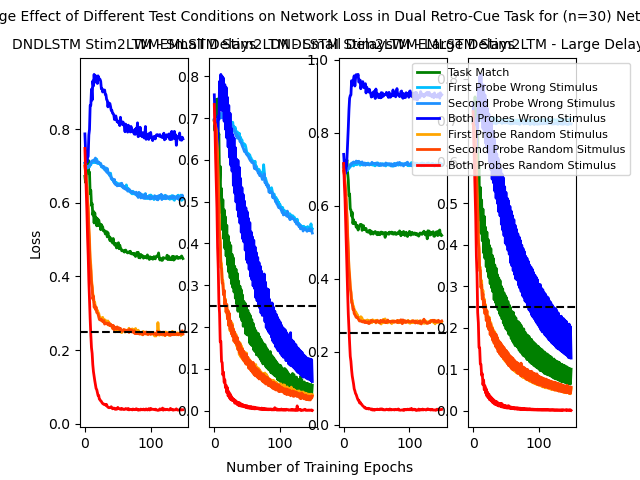

In [76]:
fig, ax = plt.subplots(1,4)

# plot losses
fig.suptitle("Average Effect of Different Test Conditions on Network Loss in Dual Retro-Cue Task for (n=" + str(num_networks) + ") Networks", fontsize=10)

# Individual losses for each sample type (where the same stimulus is cued each round)
ax[0].set_title("DNDLSTM Stim2LTM - Small Delays", fontsize=10)
ax[0].plot(match_mean_losses_small_dndlstmcell_stimuli2ltm, color='green', label="Task Match", linewidth=2)
ax[0].plot(first_probe_wrong_stimuli_mean_losses_small_dndlstmcell_stimuli2ltm, color='deepskyblue', label="First Probe Wrong Stimulus", linewidth=2)
ax[0].plot(second_probe_wrong_stimuli_mean_losses_small_dndlstmcell_stimuli2ltm, color='dodgerblue', label="Second Probe Wrong Stimulus", linewidth=2)
ax[0].plot(both_probes_wrong_stimuli_mean_losses_small_dndlstmcell_stimuli2ltm, color='blue', label="Both Probes Wrong Stimulus", linewidth=2)
ax[0].plot(first_probe_random_stimuli_mean_losses_small_dndlstmcell_stimuli2ltm, color='orange', label="First Probe Random Stimulus", linewidth=2)
ax[0].plot(second_probe_random_stimuli_mean_losses_small_dndlstmcell_stimuli2ltm, color='orangered', label="Second Probe Random Sitmulus", linewidth=2)
ax[0].plot(both_probes_random_stimuli_mean_losses_small_dndlstmcell_stimuli2ltm, color='red', label="Both Probes Random Stimulus", linewidth=2)

# Individual losses for each sample type (where a different stimulus is cued each round)
ax[1].set_title("WMEMLSTM Stim2LTM - Small Delays", fontsize=10)
ax[1].plot(match_mean_losses_small_wmemlstmcell_stimuli2ltm, color='green', label="Task Match", linewidth=2)
ax[1].plot(first_probe_wrong_stimuli_mean_losses_small_wmemlstmcell_stimuli2ltm, color='deepskyblue', label="First Probe Wrong Stimulus", linewidth=2)
ax[1].plot(second_probe_wrong_stimuli_mean_losses_small_wmemlstmcell_stimuli2ltm, color='dodgerblue', label="Second Probe Wrong Stimulus", linewidth=2)
ax[1].plot(both_probes_wrong_stimuli_mean_losses_small_wmemlstmcell_stimuli2ltm, color='blue', label="Both Probes Wrong Stimulus", linewidth=2)
ax[1].plot(first_probe_random_stimuli_mean_losses_small_wmemlstmcell_stimuli2ltm, color='orange', label="First Probe Random Stimulus", linewidth=2)
ax[1].plot(second_probe_random_stimuli_mean_losses_small_wmemlstmcell_stimuli2ltm, color='orangered', label="Second Probe Random Sitmulus", linewidth=2)
ax[1].plot(both_probes_random_stimuli_mean_losses_small_wmemlstmcell_stimuli2ltm, color='red', label="Both Probes Random Stimulus", linewidth=2)

# Individual losses for each sample type (where the same stimulus is cued each round)
ax[2].set_title("DNDLSTM Stim2LTM - Large Delays", fontsize=10)
ax[2].plot(match_mean_losses_large_dndlstmcell_stimuli2ltm, color='green', label="Task Match", linewidth=2)
ax[2].plot(first_probe_wrong_stimuli_mean_losses_large_dndlstmcell_stimuli2ltm, color='deepskyblue', label="First Probe Wrong Stimulus", linewidth=2)
ax[2].plot(second_probe_wrong_stimuli_mean_losses_large_dndlstmcell_stimuli2ltm, color='dodgerblue', label="Second Probe Wrong Stimulus", linewidth=2)
ax[2].plot(both_probes_wrong_stimuli_mean_losses_large_dndlstmcell_stimuli2ltm, color='blue', label="Both Probes Wrong Stimulus", linewidth=2)
ax[2].plot(first_probe_random_stimuli_mean_losses_large_dndlstmcell_stimuli2ltm, color='orange', label="First Probe Random Stimulus", linewidth=2)
ax[2].plot(second_probe_random_stimuli_mean_losses_large_dndlstmcell_stimuli2ltm, color='orangered', label="Second Probe Random Sitmulus", linewidth=2)
ax[2].plot(both_probes_random_stimuli_mean_losses_large_dndlstmcell_stimuli2ltm, color='red', label="Both Probes Random Stimulus", linewidth=2)

# Individual losses for each sample type (where a different stimulus is cued each round)
ax[3].set_title("WMEMLSTM Stim2LTM - Large Delays", fontsize=10)
ax[3].plot(match_mean_losses_large_wmemlstmcell_stimuli2ltm, color='green', label="Task Match", linewidth=2)
ax[3].plot(first_probe_wrong_stimuli_mean_losses_large_wmemlstmcell_stimuli2ltm, color='deepskyblue', label="First Probe Wrong Stimulus", linewidth=2)
ax[3].plot(second_probe_wrong_stimuli_mean_losses_large_wmemlstmcell_stimuli2ltm, color='dodgerblue', label="Second Probe Wrong Stimulus", linewidth=2)
ax[3].plot(both_probes_wrong_stimuli_mean_losses_large_wmemlstmcell_stimuli2ltm, color='blue', label="Both Probes Wrong Stimulus", linewidth=2)
ax[3].plot(first_probe_random_stimuli_mean_losses_large_wmemlstmcell_stimuli2ltm, color='orange', label="First Probe Random Stimulus", linewidth=2)
ax[3].plot(second_probe_random_stimuli_mean_losses_large_wmemlstmcell_stimuli2ltm, color='orangered', label="Second Probe Random Sitmulus", linewidth=2)
ax[3].plot(both_probes_random_stimuli_mean_losses_large_wmemlstmcell_stimuli2ltm, color='red', label="Both Probes Random Stimulus", linewidth=2)

# Threshold line
ax[0].axhline(threshold, linestyle='dashed', color='black')
ax[1].axhline(threshold, linestyle='dashed', color='black')
ax[2].axhline(threshold, linestyle='dashed', color='black')
ax[3].axhline(threshold, linestyle='dashed', color='black')

# legend and show plot
ax[3].legend(fontsize=8, bbox_to_anchor=(1.55, 1), loc="upper right") # by default, the legend ignores all elements without a label attribute set.

fig.supxlabel('Number of Training Epochs', fontsize=10) # x label
ax[0].set_ylabel('Loss', fontsize=10) # y label

plt.show()

#### *Graph on Summaries of Each Trial Type for WMEM vs. WM + EM LSTMs on the Dual Retro-Cue Task (Small Delays)*

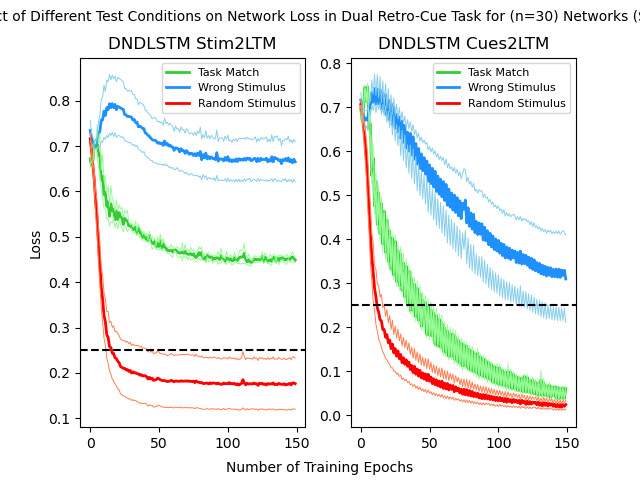

In [43]:
### Specific Plots for WMEM DRC Task ###

### DNDLSTM Stim2LTM ###

mean_sample_loss_small_dndlstmcell_stimuli2ltm_drc_dict, sample_losses_small_dndlstmcell_stimuli2ltm_drc_dict = partition_sample_losses("dual_retro_cue", mean_sample_loss_small_dndlstmcell_stimuli2ltm_drc, sample_losses_small_dndlstmcell_stimuli2ltm_drc)

task0_mean_loss = mean_sample_loss_small_dndlstmcell_stimuli2ltm_drc_dict[0]
task1_mean_loss = mean_sample_loss_small_dndlstmcell_stimuli2ltm_drc_dict[1]
task2_mean_loss = mean_sample_loss_small_dndlstmcell_stimuli2ltm_drc_dict[2]
task3_mean_loss = mean_sample_loss_small_dndlstmcell_stimuli2ltm_drc_dict[3]
task4_mean_loss = mean_sample_loss_small_dndlstmcell_stimuli2ltm_drc_dict[4]
task5_mean_loss = mean_sample_loss_small_dndlstmcell_stimuli2ltm_drc_dict[5]
task6_mean_loss = mean_sample_loss_small_dndlstmcell_stimuli2ltm_drc_dict[6]
task7_mean_loss = mean_sample_loss_small_dndlstmcell_stimuli2ltm_drc_dict[7]
task8_mean_loss = mean_sample_loss_small_dndlstmcell_stimuli2ltm_drc_dict[8]
task9_mean_loss = mean_sample_loss_small_dndlstmcell_stimuli2ltm_drc_dict[9]
task10_mean_loss = mean_sample_loss_small_dndlstmcell_stimuli2ltm_drc_dict[10]
task11_mean_loss = mean_sample_loss_small_dndlstmcell_stimuli2ltm_drc_dict[11]
task12_mean_loss = mean_sample_loss_small_dndlstmcell_stimuli2ltm_drc_dict[12]
task13_mean_loss = mean_sample_loss_small_dndlstmcell_stimuli2ltm_drc_dict[13]
task14_mean_loss = mean_sample_loss_small_dndlstmcell_stimuli2ltm_drc_dict[14]
task15_mean_loss = mean_sample_loss_small_dndlstmcell_stimuli2ltm_drc_dict[15]
task16_mean_loss = mean_sample_loss_small_dndlstmcell_stimuli2ltm_drc_dict[16]
task17_mean_loss = mean_sample_loss_small_dndlstmcell_stimuli2ltm_drc_dict[17]
task18_mean_loss = mean_sample_loss_small_dndlstmcell_stimuli2ltm_drc_dict[18]
task19_mean_loss = mean_sample_loss_small_dndlstmcell_stimuli2ltm_drc_dict[19]
task20_mean_loss = mean_sample_loss_small_dndlstmcell_stimuli2ltm_drc_dict[20]
task21_mean_loss = mean_sample_loss_small_dndlstmcell_stimuli2ltm_drc_dict[21]
task22_mean_loss = mean_sample_loss_small_dndlstmcell_stimuli2ltm_drc_dict[22]
task23_mean_loss = mean_sample_loss_small_dndlstmcell_stimuli2ltm_drc_dict[23]
task24_mean_loss = mean_sample_loss_small_dndlstmcell_stimuli2ltm_drc_dict[24]
task25_mean_loss = mean_sample_loss_small_dndlstmcell_stimuli2ltm_drc_dict[25]
task26_mean_loss = mean_sample_loss_small_dndlstmcell_stimuli2ltm_drc_dict[26]
task27_mean_loss = mean_sample_loss_small_dndlstmcell_stimuli2ltm_drc_dict[27]

task0_sample_losses = sample_losses_small_dndlstmcell_stimuli2ltm_drc_dict[0]
task1_sample_losses = sample_losses_small_dndlstmcell_stimuli2ltm_drc_dict[1]
task2_sample_losses = sample_losses_small_dndlstmcell_stimuli2ltm_drc_dict[2]
task3_sample_losses = sample_losses_small_dndlstmcell_stimuli2ltm_drc_dict[3]
task4_sample_losses = sample_losses_small_dndlstmcell_stimuli2ltm_drc_dict[4]
task5_sample_losses = sample_losses_small_dndlstmcell_stimuli2ltm_drc_dict[5]
task6_sample_losses = sample_losses_small_dndlstmcell_stimuli2ltm_drc_dict[6]
task7_sample_losses = sample_losses_small_dndlstmcell_stimuli2ltm_drc_dict[7]
task8_sample_losses = sample_losses_small_dndlstmcell_stimuli2ltm_drc_dict[8]
task9_sample_losses = sample_losses_small_dndlstmcell_stimuli2ltm_drc_dict[9]
task10_sample_losses = sample_losses_small_dndlstmcell_stimuli2ltm_drc_dict[10]
task11_sample_losses = sample_losses_small_dndlstmcell_stimuli2ltm_drc_dict[11]
task12_sample_losses = sample_losses_small_dndlstmcell_stimuli2ltm_drc_dict[12]
task13_sample_losses = sample_losses_small_dndlstmcell_stimuli2ltm_drc_dict[13]
task14_sample_losses = sample_losses_small_dndlstmcell_stimuli2ltm_drc_dict[14]
task15_sample_losses = sample_losses_small_dndlstmcell_stimuli2ltm_drc_dict[15]
task16_sample_losses = sample_losses_small_dndlstmcell_stimuli2ltm_drc_dict[16]
task17_sample_losses = sample_losses_small_dndlstmcell_stimuli2ltm_drc_dict[17]
task18_sample_losses = sample_losses_small_dndlstmcell_stimuli2ltm_drc_dict[18]
task19_sample_losses = sample_losses_small_dndlstmcell_stimuli2ltm_drc_dict[19]
task20_sample_losses = sample_losses_small_dndlstmcell_stimuli2ltm_drc_dict[20]
task21_sample_losses = sample_losses_small_dndlstmcell_stimuli2ltm_drc_dict[21]
task22_sample_losses = sample_losses_small_dndlstmcell_stimuli2ltm_drc_dict[22]
task23_sample_losses = sample_losses_small_dndlstmcell_stimuli2ltm_drc_dict[23]
task24_sample_losses = sample_losses_small_dndlstmcell_stimuli2ltm_drc_dict[24]
task25_sample_losses = sample_losses_small_dndlstmcell_stimuli2ltm_drc_dict[25]
task26_sample_losses = sample_losses_small_dndlstmcell_stimuli2ltm_drc_dict[26]
task27_sample_losses = sample_losses_small_dndlstmcell_stimuli2ltm_drc_dict[27]

# testing different cases when the same cues are made before the probes (Vanilla Working Memory Case)
match_losses_same_cues = [task1_mean_loss, task3_mean_loss]
first_probe_wrong_stimuli_losses_same_cues = [task12_mean_loss, task14_mean_loss]
first_probe_random_stimuli_losses_same_cues = [task13_mean_loss, task15_mean_loss]
second_probe_wrong_stimuli_losses_same_cues = [task16_mean_loss, task18_mean_loss]
second_probe_random_stimuli_losses_same_cues = [task17_mean_loss, task19_mean_loss]
both_probes_wrong_stimuli_losses_same_cues = [task24_mean_loss, task26_mean_loss]
both_probes_random_stimuli_losses_same_cues = [task25_mean_loss, task27_mean_loss]


# testing different cases when a different second cue is made before the second probe (ASWM case)
match_losses_different_cues = [task0_mean_loss, task2_mean_loss]
first_probe_wrong_stimuli_losses_different_cues = [task4_mean_loss, task6_mean_loss]
first_probe_random_stimuli_losses_different_cues = [task5_mean_loss, task7_mean_loss]
second_probe_wrong_stimuli_losses_different_cues = [task8_mean_loss, task10_mean_loss]
second_probe_random_stimuli_losses_different_cues = [task9_mean_loss, task11_mean_loss]
both_probes_wrong_stimuli_losses_different_cues = [task20_mean_loss, task22_mean_loss]
both_probes_random_stimuli_losses_different_cues = [task21_mean_loss, task23_mean_loss]


# get the mean losses for each of these 3 larger categories

match_losses_small_dndlstmcell_stimuli2ltm = match_losses_same_cues + match_losses_different_cues
wrong_stimuli_losses_small_dndlstmcell_stimuli2ltm = first_probe_wrong_stimuli_losses_same_cues + second_probe_wrong_stimuli_losses_same_cues + both_probes_wrong_stimuli_losses_same_cues + first_probe_wrong_stimuli_losses_different_cues + second_probe_wrong_stimuli_losses_different_cues + both_probes_wrong_stimuli_losses_different_cues
random_stimuli_losses_small_dndlstmcell_stimuli2ltm = first_probe_random_stimuli_losses_same_cues + second_probe_random_stimuli_losses_same_cues + both_probes_random_stimuli_losses_same_cues + first_probe_random_stimuli_losses_different_cues + second_probe_random_stimuli_losses_different_cues + both_probes_random_stimuli_losses_different_cues

match_mean_losses_small_dndlstmcell_stimuli2ltm = np.mean(match_losses_small_dndlstmcell_stimuli2ltm, axis=0)
wrong_stimuli_mean_losses_small_dndlstmcell_stimuli2ltm = np.mean(wrong_stimuli_losses_small_dndlstmcell_stimuli2ltm, axis=0)
random_stimuli_mean_losses_small_dndlstmcell_stimuli2ltm = np.mean(random_stimuli_losses_small_dndlstmcell_stimuli2ltm, axis=0)

### Specific Plots for WMEM DRC Task ###

### WMEMLSTM Stim2LTM ###

mean_sample_loss_small_wmemlstmcell_stimuli2ltm_drc_dict, sample_losses_small_wmemlstmcell_stimuli2ltm_drc_dict = partition_sample_losses("dual_retro_cue", mean_sample_loss_small_wmemlstmcell_stimuli2ltm_drc, sample_losses_small_wmemlstmcell_stimuli2ltm_drc)

task0_mean_loss = mean_sample_loss_small_wmemlstmcell_stimuli2ltm_drc_dict[0]
task1_mean_loss = mean_sample_loss_small_wmemlstmcell_stimuli2ltm_drc_dict[1]
task2_mean_loss = mean_sample_loss_small_wmemlstmcell_stimuli2ltm_drc_dict[2]
task3_mean_loss = mean_sample_loss_small_wmemlstmcell_stimuli2ltm_drc_dict[3]
task4_mean_loss = mean_sample_loss_small_wmemlstmcell_stimuli2ltm_drc_dict[4]
task5_mean_loss = mean_sample_loss_small_wmemlstmcell_stimuli2ltm_drc_dict[5]
task6_mean_loss = mean_sample_loss_small_wmemlstmcell_stimuli2ltm_drc_dict[6]
task7_mean_loss = mean_sample_loss_small_wmemlstmcell_stimuli2ltm_drc_dict[7]
task8_mean_loss = mean_sample_loss_small_wmemlstmcell_stimuli2ltm_drc_dict[8]
task9_mean_loss = mean_sample_loss_small_wmemlstmcell_stimuli2ltm_drc_dict[9]
task10_mean_loss = mean_sample_loss_small_wmemlstmcell_stimuli2ltm_drc_dict[10]
task11_mean_loss = mean_sample_loss_small_wmemlstmcell_stimuli2ltm_drc_dict[11]
task12_mean_loss = mean_sample_loss_small_wmemlstmcell_stimuli2ltm_drc_dict[12]
task13_mean_loss = mean_sample_loss_small_wmemlstmcell_stimuli2ltm_drc_dict[13]
task14_mean_loss = mean_sample_loss_small_wmemlstmcell_stimuli2ltm_drc_dict[14]
task15_mean_loss = mean_sample_loss_small_wmemlstmcell_stimuli2ltm_drc_dict[15]
task16_mean_loss = mean_sample_loss_small_wmemlstmcell_stimuli2ltm_drc_dict[16]
task17_mean_loss = mean_sample_loss_small_wmemlstmcell_stimuli2ltm_drc_dict[17]
task18_mean_loss = mean_sample_loss_small_wmemlstmcell_stimuli2ltm_drc_dict[18]
task19_mean_loss = mean_sample_loss_small_wmemlstmcell_stimuli2ltm_drc_dict[19]
task20_mean_loss = mean_sample_loss_small_wmemlstmcell_stimuli2ltm_drc_dict[20]
task21_mean_loss = mean_sample_loss_small_wmemlstmcell_stimuli2ltm_drc_dict[21]
task22_mean_loss = mean_sample_loss_small_wmemlstmcell_stimuli2ltm_drc_dict[22]
task23_mean_loss = mean_sample_loss_small_wmemlstmcell_stimuli2ltm_drc_dict[23]
task24_mean_loss = mean_sample_loss_small_wmemlstmcell_stimuli2ltm_drc_dict[24]
task25_mean_loss = mean_sample_loss_small_wmemlstmcell_stimuli2ltm_drc_dict[25]
task26_mean_loss = mean_sample_loss_small_wmemlstmcell_stimuli2ltm_drc_dict[26]
task27_mean_loss = mean_sample_loss_small_wmemlstmcell_stimuli2ltm_drc_dict[27]

task0_sample_losses = sample_losses_small_wmemlstmcell_stimuli2ltm_drc_dict[0]
task1_sample_losses = sample_losses_small_wmemlstmcell_stimuli2ltm_drc_dict[1]
task2_sample_losses = sample_losses_small_wmemlstmcell_stimuli2ltm_drc_dict[2]
task3_sample_losses = sample_losses_small_wmemlstmcell_stimuli2ltm_drc_dict[3]
task4_sample_losses = sample_losses_small_wmemlstmcell_stimuli2ltm_drc_dict[4]
task5_sample_losses = sample_losses_small_wmemlstmcell_stimuli2ltm_drc_dict[5]
task6_sample_losses = sample_losses_small_wmemlstmcell_stimuli2ltm_drc_dict[6]
task7_sample_losses = sample_losses_small_wmemlstmcell_stimuli2ltm_drc_dict[7]
task8_sample_losses = sample_losses_small_wmemlstmcell_stimuli2ltm_drc_dict[8]
task9_sample_losses = sample_losses_small_wmemlstmcell_stimuli2ltm_drc_dict[9]
task10_sample_losses = sample_losses_small_wmemlstmcell_stimuli2ltm_drc_dict[10]
task11_sample_losses = sample_losses_small_wmemlstmcell_stimuli2ltm_drc_dict[11]
task12_sample_losses = sample_losses_small_wmemlstmcell_stimuli2ltm_drc_dict[12]
task13_sample_losses = sample_losses_small_wmemlstmcell_stimuli2ltm_drc_dict[13]
task14_sample_losses = sample_losses_small_wmemlstmcell_stimuli2ltm_drc_dict[14]
task15_sample_losses = sample_losses_small_wmemlstmcell_stimuli2ltm_drc_dict[15]
task16_sample_losses = sample_losses_small_wmemlstmcell_stimuli2ltm_drc_dict[16]
task17_sample_losses = sample_losses_small_wmemlstmcell_stimuli2ltm_drc_dict[17]
task18_sample_losses = sample_losses_small_wmemlstmcell_stimuli2ltm_drc_dict[18]
task19_sample_losses = sample_losses_small_wmemlstmcell_stimuli2ltm_drc_dict[19]
task20_sample_losses = sample_losses_small_wmemlstmcell_stimuli2ltm_drc_dict[20]
task21_sample_losses = sample_losses_small_wmemlstmcell_stimuli2ltm_drc_dict[21]
task22_sample_losses = sample_losses_small_wmemlstmcell_stimuli2ltm_drc_dict[22]
task23_sample_losses = sample_losses_small_wmemlstmcell_stimuli2ltm_drc_dict[23]
task24_sample_losses = sample_losses_small_wmemlstmcell_stimuli2ltm_drc_dict[24]
task25_sample_losses = sample_losses_small_wmemlstmcell_stimuli2ltm_drc_dict[25]
task26_sample_losses = sample_losses_small_wmemlstmcell_stimuli2ltm_drc_dict[26]
task27_sample_losses = sample_losses_small_wmemlstmcell_stimuli2ltm_drc_dict[27]

# testing different cases when the same cues are made before the probes (Vanilla Working Memory Case)
match_losses_same_cues = [task1_mean_loss, task3_mean_loss]
first_probe_wrong_stimuli_losses_same_cues = [task12_mean_loss, task14_mean_loss]
first_probe_random_stimuli_losses_same_cues = [task13_mean_loss, task15_mean_loss]
second_probe_wrong_stimuli_losses_same_cues = [task16_mean_loss, task18_mean_loss]
second_probe_random_stimuli_losses_same_cues = [task17_mean_loss, task19_mean_loss]
both_probes_wrong_stimuli_losses_same_cues = [task24_mean_loss, task26_mean_loss]
both_probes_random_stimuli_losses_same_cues = [task25_mean_loss, task27_mean_loss]


# testing different cases when a different second cue is made before the second probe (ASWM case)
match_losses_different_cues = [task0_mean_loss, task2_mean_loss]
first_probe_wrong_stimuli_losses_different_cues = [task4_mean_loss, task6_mean_loss]
first_probe_random_stimuli_losses_different_cues = [task5_mean_loss, task7_mean_loss]
second_probe_wrong_stimuli_losses_different_cues = [task8_mean_loss, task10_mean_loss]
second_probe_random_stimuli_losses_different_cues = [task9_mean_loss, task11_mean_loss]
both_probes_wrong_stimuli_losses_different_cues = [task20_mean_loss, task22_mean_loss]
both_probes_random_stimuli_losses_different_cues = [task21_mean_loss, task23_mean_loss]

# get the mean losses for each of these 3 larger categories

match_losses_small_wmemlstmcell_stimuli2ltm = match_losses_same_cues + match_losses_different_cues
wrong_stimuli_losses_small_wmemlstmcell_stimuli2ltm = first_probe_wrong_stimuli_losses_same_cues + second_probe_wrong_stimuli_losses_same_cues + both_probes_wrong_stimuli_losses_same_cues + first_probe_wrong_stimuli_losses_different_cues + second_probe_wrong_stimuli_losses_different_cues + both_probes_wrong_stimuli_losses_different_cues
random_stimuli_losses_small_wmemlstmcell_stimuli2ltm = first_probe_random_stimuli_losses_same_cues + second_probe_random_stimuli_losses_same_cues + both_probes_random_stimuli_losses_same_cues + first_probe_random_stimuli_losses_different_cues + second_probe_random_stimuli_losses_different_cues + both_probes_random_stimuli_losses_different_cues


match_mean_losses_small_wmemlstmcell_stimuli2ltm = np.mean(match_losses_small_wmemlstmcell_stimuli2ltm, axis=0)
wrong_stimuli_mean_losses_small_wmemlstmcell_stimuli2ltm = np.mean(wrong_stimuli_losses_small_wmemlstmcell_stimuli2ltm, axis=0)
random_stimuli_mean_losses_small_wmemlstmcell_stimuli2ltm = np.mean(random_stimuli_losses_small_wmemlstmcell_stimuli2ltm, axis=0)


fig, ax = plt.subplots(1,2)

# plot losses
fig.suptitle("Average Effect of Different Test Conditions on Network Loss in Dual Retro-Cue Task for (n=" + str(num_networks) + ") Networks (Small Delays)", fontsize=10)


# Individual losses for each sample type (where the same stimulus is cued each round)
ax[0].set_title("DNDLSTM Stim2LTM")
ax[0].plot(match_mean_losses_small_dndlstmcell_stimuli2ltm, color='limegreen', label="Task Match", linewidth=2)
ax[0].plot(wrong_stimuli_mean_losses_small_dndlstmcell_stimuli2ltm, color='dodgerblue', label="Wrong Stimulus", linewidth=2)
ax[0].plot(random_stimuli_mean_losses_small_dndlstmcell_stimuli2ltm, color='red', label="Random Stimulus", linewidth=2)

## Standard deviations
ax[0].plot((match_mean_losses_small_dndlstmcell_stimuli2ltm + 2*stats.sem(match_losses_small_dndlstmcell_stimuli2ltm, axis=0, ddof=0)), color='palegreen', linewidth=0.7)
ax[0].plot((match_mean_losses_small_dndlstmcell_stimuli2ltm - 2*stats.sem(match_losses_small_dndlstmcell_stimuli2ltm, axis=0, ddof=0)), color='palegreen', linewidth=0.7)

ax[0].plot((wrong_stimuli_mean_losses_small_dndlstmcell_stimuli2ltm + 2*stats.sem(wrong_stimuli_losses_small_dndlstmcell_stimuli2ltm, axis=0, ddof=0)), color='skyblue', linewidth=0.7)
ax[0].plot((wrong_stimuli_mean_losses_small_dndlstmcell_stimuli2ltm - 2*stats.sem(wrong_stimuli_losses_small_dndlstmcell_stimuli2ltm, axis=0, ddof=0)), color='skyblue', linewidth=0.7)

ax[0].plot((random_stimuli_mean_losses_small_dndlstmcell_stimuli2ltm + 2*stats.sem(random_stimuli_losses_small_dndlstmcell_stimuli2ltm, axis=0, ddof=0)), color='coral', linewidth=0.7)
ax[0].plot((random_stimuli_mean_losses_small_dndlstmcell_stimuli2ltm - 2*stats.sem(random_stimuli_losses_small_dndlstmcell_stimuli2ltm, axis=0, ddof=0)), color='coral', linewidth=0.7)

# Individual losses for each sample type (where a different stimulus is cued each round)
ax[1].set_title("WMEMLSTM Stim2LTM")
ax[1].plot(match_mean_losses_small_wmemlstmcell_stimuli2ltm, color='limegreen', label="Task Match", linewidth=2)
ax[1].plot(wrong_stimuli_mean_losses_small_wmemlstmcell_stimuli2ltm, color='dodgerblue', label="Wrong Stimulus", linewidth=2)
ax[1].plot(random_stimuli_mean_losses_small_wmemlstmcell_stimuli2ltm, color='red', label="Random Stimulus", linewidth=2)

## Standard deviations
ax[1].plot((match_mean_losses_small_wmemlstmcell_stimuli2ltm + 2*stats.sem(match_losses_small_wmemlstmcell_stimuli2ltm, axis=0, ddof=0)), color='palegreen', linewidth=0.7)
ax[1].plot((match_mean_losses_small_wmemlstmcell_stimuli2ltm - 2*stats.sem(match_losses_small_wmemlstmcell_stimuli2ltm, axis=0, ddof=0)), color='palegreen', linewidth=0.7)      
           
ax[1].plot((wrong_stimuli_mean_losses_small_wmemlstmcell_stimuli2ltm + 2*stats.sem(wrong_stimuli_losses_small_wmemlstmcell_stimuli2ltm, axis=0, ddof=0)), color='skyblue', linewidth=0.7)
ax[1].plot((wrong_stimuli_mean_losses_small_wmemlstmcell_stimuli2ltm - 2*stats.sem(wrong_stimuli_losses_small_wmemlstmcell_stimuli2ltm, axis=0, ddof=0)), color='skyblue', linewidth=0.7)

ax[1].plot((random_stimuli_mean_losses_small_wmemlstmcell_stimuli2ltm + 2*stats.sem(random_stimuli_losses_small_wmemlstmcell_stimuli2ltm, axis=0, ddof=0)), color='coral', linewidth=0.7)
ax[1].plot((random_stimuli_mean_losses_small_wmemlstmcell_stimuli2ltm - 2*stats.sem(random_stimuli_losses_small_wmemlstmcell_stimuli2ltm, axis=0, ddof=0)), color='coral', linewidth=0.7)

# Threshold line
ax[0].axhline(threshold, linestyle='dashed', color='black')
ax[1].axhline(threshold, linestyle='dashed', color='black')

# legend and show plot
ax[0].legend(fontsize=8, loc="upper right") # by default, the legend ignores all elements without a label attribute set.
ax[1].legend(fontsize=8, loc="upper right") # by default, the legend ignores all elements without a label attribute set.

fig.supxlabel('Number of Training Epochs', fontsize=10) # x label
ax[0].set_ylabel('Loss', fontsize=10) # y label

plt.show()

#### *Graph on Summaries of Each Trial Type for WMEM vs. WM + EM LSTMs on the Dual Retro-Cue Task (Large Delays)*

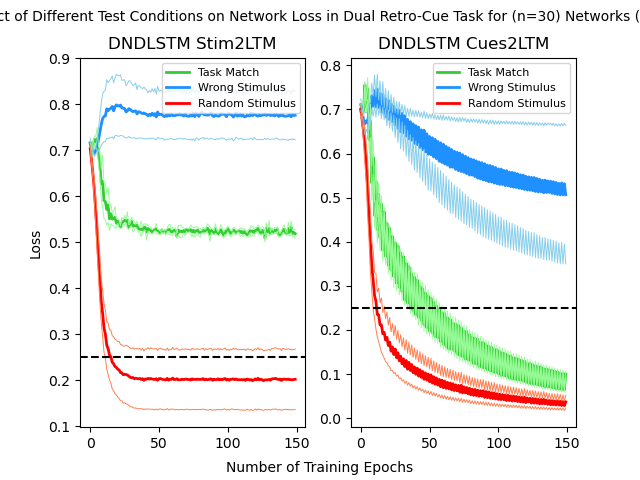

In [44]:
### Specific Plots for WMEM DRC Task ###

### DNDLSTM Stim2LTM ###

mean_sample_loss_large_dndlstmcell_stimuli2ltm_drc_dict, sample_losses_large_dndlstmcell_stimuli2ltm_drc_dict = partition_sample_losses("dual_retro_cue", mean_sample_loss_large_dndlstmcell_stimuli2ltm_drc, sample_losses_large_dndlstmcell_stimuli2ltm_drc)

task0_mean_loss = mean_sample_loss_large_dndlstmcell_stimuli2ltm_drc_dict[0]
task1_mean_loss = mean_sample_loss_large_dndlstmcell_stimuli2ltm_drc_dict[1]
task2_mean_loss = mean_sample_loss_large_dndlstmcell_stimuli2ltm_drc_dict[2]
task3_mean_loss = mean_sample_loss_large_dndlstmcell_stimuli2ltm_drc_dict[3]
task4_mean_loss = mean_sample_loss_large_dndlstmcell_stimuli2ltm_drc_dict[4]
task5_mean_loss = mean_sample_loss_large_dndlstmcell_stimuli2ltm_drc_dict[5]
task6_mean_loss = mean_sample_loss_large_dndlstmcell_stimuli2ltm_drc_dict[6]
task7_mean_loss = mean_sample_loss_large_dndlstmcell_stimuli2ltm_drc_dict[7]
task8_mean_loss = mean_sample_loss_large_dndlstmcell_stimuli2ltm_drc_dict[8]
task9_mean_loss = mean_sample_loss_large_dndlstmcell_stimuli2ltm_drc_dict[9]
task10_mean_loss = mean_sample_loss_large_dndlstmcell_stimuli2ltm_drc_dict[10]
task11_mean_loss = mean_sample_loss_large_dndlstmcell_stimuli2ltm_drc_dict[11]
task12_mean_loss = mean_sample_loss_large_dndlstmcell_stimuli2ltm_drc_dict[12]
task13_mean_loss = mean_sample_loss_large_dndlstmcell_stimuli2ltm_drc_dict[13]
task14_mean_loss = mean_sample_loss_large_dndlstmcell_stimuli2ltm_drc_dict[14]
task15_mean_loss = mean_sample_loss_large_dndlstmcell_stimuli2ltm_drc_dict[15]
task16_mean_loss = mean_sample_loss_large_dndlstmcell_stimuli2ltm_drc_dict[16]
task17_mean_loss = mean_sample_loss_large_dndlstmcell_stimuli2ltm_drc_dict[17]
task18_mean_loss = mean_sample_loss_large_dndlstmcell_stimuli2ltm_drc_dict[18]
task19_mean_loss = mean_sample_loss_large_dndlstmcell_stimuli2ltm_drc_dict[19]
task20_mean_loss = mean_sample_loss_large_dndlstmcell_stimuli2ltm_drc_dict[20]
task21_mean_loss = mean_sample_loss_large_dndlstmcell_stimuli2ltm_drc_dict[21]
task22_mean_loss = mean_sample_loss_large_dndlstmcell_stimuli2ltm_drc_dict[22]
task23_mean_loss = mean_sample_loss_large_dndlstmcell_stimuli2ltm_drc_dict[23]
task24_mean_loss = mean_sample_loss_large_dndlstmcell_stimuli2ltm_drc_dict[24]
task25_mean_loss = mean_sample_loss_large_dndlstmcell_stimuli2ltm_drc_dict[25]
task26_mean_loss = mean_sample_loss_large_dndlstmcell_stimuli2ltm_drc_dict[26]
task27_mean_loss = mean_sample_loss_large_dndlstmcell_stimuli2ltm_drc_dict[27]

task0_sample_losses = sample_losses_large_dndlstmcell_stimuli2ltm_drc_dict[0]
task1_sample_losses = sample_losses_large_dndlstmcell_stimuli2ltm_drc_dict[1]
task2_sample_losses = sample_losses_large_dndlstmcell_stimuli2ltm_drc_dict[2]
task3_sample_losses = sample_losses_large_dndlstmcell_stimuli2ltm_drc_dict[3]
task4_sample_losses = sample_losses_large_dndlstmcell_stimuli2ltm_drc_dict[4]
task5_sample_losses = sample_losses_large_dndlstmcell_stimuli2ltm_drc_dict[5]
task6_sample_losses = sample_losses_large_dndlstmcell_stimuli2ltm_drc_dict[6]
task7_sample_losses = sample_losses_large_dndlstmcell_stimuli2ltm_drc_dict[7]
task8_sample_losses = sample_losses_large_dndlstmcell_stimuli2ltm_drc_dict[8]
task9_sample_losses = sample_losses_large_dndlstmcell_stimuli2ltm_drc_dict[9]
task10_sample_losses = sample_losses_large_dndlstmcell_stimuli2ltm_drc_dict[10]
task11_sample_losses = sample_losses_large_dndlstmcell_stimuli2ltm_drc_dict[11]
task12_sample_losses = sample_losses_large_dndlstmcell_stimuli2ltm_drc_dict[12]
task13_sample_losses = sample_losses_large_dndlstmcell_stimuli2ltm_drc_dict[13]
task14_sample_losses = sample_losses_large_dndlstmcell_stimuli2ltm_drc_dict[14]
task15_sample_losses = sample_losses_large_dndlstmcell_stimuli2ltm_drc_dict[15]
task16_sample_losses = sample_losses_large_dndlstmcell_stimuli2ltm_drc_dict[16]
task17_sample_losses = sample_losses_large_dndlstmcell_stimuli2ltm_drc_dict[17]
task18_sample_losses = sample_losses_large_dndlstmcell_stimuli2ltm_drc_dict[18]
task19_sample_losses = sample_losses_large_dndlstmcell_stimuli2ltm_drc_dict[19]
task20_sample_losses = sample_losses_large_dndlstmcell_stimuli2ltm_drc_dict[20]
task21_sample_losses = sample_losses_large_dndlstmcell_stimuli2ltm_drc_dict[21]
task22_sample_losses = sample_losses_large_dndlstmcell_stimuli2ltm_drc_dict[22]
task23_sample_losses = sample_losses_large_dndlstmcell_stimuli2ltm_drc_dict[23]
task24_sample_losses = sample_losses_large_dndlstmcell_stimuli2ltm_drc_dict[24]
task25_sample_losses = sample_losses_large_dndlstmcell_stimuli2ltm_drc_dict[25]
task26_sample_losses = sample_losses_large_dndlstmcell_stimuli2ltm_drc_dict[26]
task27_sample_losses = sample_losses_large_dndlstmcell_stimuli2ltm_drc_dict[27]

# testing different cases when the same cues are made before the probes (Vanilla Working Memory Case)
match_losses_same_cues = [task1_mean_loss, task3_mean_loss]
first_probe_wrong_stimuli_losses_same_cues = [task12_mean_loss, task14_mean_loss]
first_probe_random_stimuli_losses_same_cues = [task13_mean_loss, task15_mean_loss]
second_probe_wrong_stimuli_losses_same_cues = [task16_mean_loss, task18_mean_loss]
second_probe_random_stimuli_losses_same_cues = [task17_mean_loss, task19_mean_loss]
both_probes_wrong_stimuli_losses_same_cues = [task24_mean_loss, task26_mean_loss]
both_probes_random_stimuli_losses_same_cues = [task25_mean_loss, task27_mean_loss]


# testing different cases when a different second cue is made before the second probe (ASWM case)
match_losses_different_cues = [task0_mean_loss, task2_mean_loss]
first_probe_wrong_stimuli_losses_different_cues = [task4_mean_loss, task6_mean_loss]
first_probe_random_stimuli_losses_different_cues = [task5_mean_loss, task7_mean_loss]
second_probe_wrong_stimuli_losses_different_cues = [task8_mean_loss, task10_mean_loss]
second_probe_random_stimuli_losses_different_cues = [task9_mean_loss, task11_mean_loss]
both_probes_wrong_stimuli_losses_different_cues = [task20_mean_loss, task22_mean_loss]
both_probes_random_stimuli_losses_different_cues = [task21_mean_loss, task23_mean_loss]


# get the mean losses for each of these 3 larger categories

match_losses_large_dndlstmcell_stimuli2ltm = match_losses_same_cues + match_losses_different_cues
wrong_stimuli_losses_large_dndlstmcell_stimuli2ltm = first_probe_wrong_stimuli_losses_same_cues + second_probe_wrong_stimuli_losses_same_cues + both_probes_wrong_stimuli_losses_same_cues + first_probe_wrong_stimuli_losses_different_cues + second_probe_wrong_stimuli_losses_different_cues + both_probes_wrong_stimuli_losses_different_cues
random_stimuli_losses_large_dndlstmcell_stimuli2ltm = first_probe_random_stimuli_losses_same_cues + second_probe_random_stimuli_losses_same_cues + both_probes_random_stimuli_losses_same_cues + first_probe_random_stimuli_losses_different_cues + second_probe_random_stimuli_losses_different_cues + both_probes_random_stimuli_losses_different_cues

match_mean_losses_large_dndlstmcell_stimuli2ltm = np.mean(match_losses_large_dndlstmcell_stimuli2ltm, axis=0)
wrong_stimuli_mean_losses_large_dndlstmcell_stimuli2ltm = np.mean(wrong_stimuli_losses_large_dndlstmcell_stimuli2ltm, axis=0)
random_stimuli_mean_losses_large_dndlstmcell_stimuli2ltm = np.mean(random_stimuli_losses_large_dndlstmcell_stimuli2ltm, axis=0)

### Specific Plots for WMEM DRC Task ###

### WMEMLSTM Stim2LTM ###

mean_sample_loss_large_wmemlstmcell_stimuli2ltm_drc_dict, sample_losses_large_wmemlstmcell_stimuli2ltm_drc_dict = partition_sample_losses("dual_retro_cue", mean_sample_loss_large_wmemlstmcell_stimuli2ltm_drc, sample_losses_large_wmemlstmcell_stimuli2ltm_drc)

task0_mean_loss = mean_sample_loss_large_wmemlstmcell_stimuli2ltm_drc_dict[0]
task1_mean_loss = mean_sample_loss_large_wmemlstmcell_stimuli2ltm_drc_dict[1]
task2_mean_loss = mean_sample_loss_large_wmemlstmcell_stimuli2ltm_drc_dict[2]
task3_mean_loss = mean_sample_loss_large_wmemlstmcell_stimuli2ltm_drc_dict[3]
task4_mean_loss = mean_sample_loss_large_wmemlstmcell_stimuli2ltm_drc_dict[4]
task5_mean_loss = mean_sample_loss_large_wmemlstmcell_stimuli2ltm_drc_dict[5]
task6_mean_loss = mean_sample_loss_large_wmemlstmcell_stimuli2ltm_drc_dict[6]
task7_mean_loss = mean_sample_loss_large_wmemlstmcell_stimuli2ltm_drc_dict[7]
task8_mean_loss = mean_sample_loss_large_wmemlstmcell_stimuli2ltm_drc_dict[8]
task9_mean_loss = mean_sample_loss_large_wmemlstmcell_stimuli2ltm_drc_dict[9]
task10_mean_loss = mean_sample_loss_large_wmemlstmcell_stimuli2ltm_drc_dict[10]
task11_mean_loss = mean_sample_loss_large_wmemlstmcell_stimuli2ltm_drc_dict[11]
task12_mean_loss = mean_sample_loss_large_wmemlstmcell_stimuli2ltm_drc_dict[12]
task13_mean_loss = mean_sample_loss_large_wmemlstmcell_stimuli2ltm_drc_dict[13]
task14_mean_loss = mean_sample_loss_large_wmemlstmcell_stimuli2ltm_drc_dict[14]
task15_mean_loss = mean_sample_loss_large_wmemlstmcell_stimuli2ltm_drc_dict[15]
task16_mean_loss = mean_sample_loss_large_wmemlstmcell_stimuli2ltm_drc_dict[16]
task17_mean_loss = mean_sample_loss_large_wmemlstmcell_stimuli2ltm_drc_dict[17]
task18_mean_loss = mean_sample_loss_large_wmemlstmcell_stimuli2ltm_drc_dict[18]
task19_mean_loss = mean_sample_loss_large_wmemlstmcell_stimuli2ltm_drc_dict[19]
task20_mean_loss = mean_sample_loss_large_wmemlstmcell_stimuli2ltm_drc_dict[20]
task21_mean_loss = mean_sample_loss_large_wmemlstmcell_stimuli2ltm_drc_dict[21]
task22_mean_loss = mean_sample_loss_large_wmemlstmcell_stimuli2ltm_drc_dict[22]
task23_mean_loss = mean_sample_loss_large_wmemlstmcell_stimuli2ltm_drc_dict[23]
task24_mean_loss = mean_sample_loss_large_wmemlstmcell_stimuli2ltm_drc_dict[24]
task25_mean_loss = mean_sample_loss_large_wmemlstmcell_stimuli2ltm_drc_dict[25]
task26_mean_loss = mean_sample_loss_large_wmemlstmcell_stimuli2ltm_drc_dict[26]
task27_mean_loss = mean_sample_loss_large_wmemlstmcell_stimuli2ltm_drc_dict[27]

task0_sample_losses = sample_losses_large_wmemlstmcell_stimuli2ltm_drc_dict[0]
task1_sample_losses = sample_losses_large_wmemlstmcell_stimuli2ltm_drc_dict[1]
task2_sample_losses = sample_losses_large_wmemlstmcell_stimuli2ltm_drc_dict[2]
task3_sample_losses = sample_losses_large_wmemlstmcell_stimuli2ltm_drc_dict[3]
task4_sample_losses = sample_losses_large_wmemlstmcell_stimuli2ltm_drc_dict[4]
task5_sample_losses = sample_losses_large_wmemlstmcell_stimuli2ltm_drc_dict[5]
task6_sample_losses = sample_losses_large_wmemlstmcell_stimuli2ltm_drc_dict[6]
task7_sample_losses = sample_losses_large_wmemlstmcell_stimuli2ltm_drc_dict[7]
task8_sample_losses = sample_losses_large_wmemlstmcell_stimuli2ltm_drc_dict[8]
task9_sample_losses = sample_losses_large_wmemlstmcell_stimuli2ltm_drc_dict[9]
task10_sample_losses = sample_losses_large_wmemlstmcell_stimuli2ltm_drc_dict[10]
task11_sample_losses = sample_losses_large_wmemlstmcell_stimuli2ltm_drc_dict[11]
task12_sample_losses = sample_losses_large_wmemlstmcell_stimuli2ltm_drc_dict[12]
task13_sample_losses = sample_losses_large_wmemlstmcell_stimuli2ltm_drc_dict[13]
task14_sample_losses = sample_losses_large_wmemlstmcell_stimuli2ltm_drc_dict[14]
task15_sample_losses = sample_losses_large_wmemlstmcell_stimuli2ltm_drc_dict[15]
task16_sample_losses = sample_losses_large_wmemlstmcell_stimuli2ltm_drc_dict[16]
task17_sample_losses = sample_losses_large_wmemlstmcell_stimuli2ltm_drc_dict[17]
task18_sample_losses = sample_losses_large_wmemlstmcell_stimuli2ltm_drc_dict[18]
task19_sample_losses = sample_losses_large_wmemlstmcell_stimuli2ltm_drc_dict[19]
task20_sample_losses = sample_losses_large_wmemlstmcell_stimuli2ltm_drc_dict[20]
task21_sample_losses = sample_losses_large_wmemlstmcell_stimuli2ltm_drc_dict[21]
task22_sample_losses = sample_losses_large_wmemlstmcell_stimuli2ltm_drc_dict[22]
task23_sample_losses = sample_losses_large_wmemlstmcell_stimuli2ltm_drc_dict[23]
task24_sample_losses = sample_losses_large_wmemlstmcell_stimuli2ltm_drc_dict[24]
task25_sample_losses = sample_losses_large_wmemlstmcell_stimuli2ltm_drc_dict[25]
task26_sample_losses = sample_losses_large_wmemlstmcell_stimuli2ltm_drc_dict[26]
task27_sample_losses = sample_losses_large_wmemlstmcell_stimuli2ltm_drc_dict[27]

# testing different cases when the same cues are made before the probes (Vanilla Working Memory Case)
match_losses_same_cues = [task1_mean_loss, task3_mean_loss]
first_probe_wrong_stimuli_losses_same_cues = [task12_mean_loss, task14_mean_loss]
first_probe_random_stimuli_losses_same_cues = [task13_mean_loss, task15_mean_loss]
second_probe_wrong_stimuli_losses_same_cues = [task16_mean_loss, task18_mean_loss]
second_probe_random_stimuli_losses_same_cues = [task17_mean_loss, task19_mean_loss]
both_probes_wrong_stimuli_losses_same_cues = [task24_mean_loss, task26_mean_loss]
both_probes_random_stimuli_losses_same_cues = [task25_mean_loss, task27_mean_loss]


# testing different cases when a different second cue is made before the second probe (ASWM case)
match_losses_different_cues = [task0_mean_loss, task2_mean_loss]
first_probe_wrong_stimuli_losses_different_cues = [task4_mean_loss, task6_mean_loss]
first_probe_random_stimuli_losses_different_cues = [task5_mean_loss, task7_mean_loss]
second_probe_wrong_stimuli_losses_different_cues = [task8_mean_loss, task10_mean_loss]
second_probe_random_stimuli_losses_different_cues = [task9_mean_loss, task11_mean_loss]
both_probes_wrong_stimuli_losses_different_cues = [task20_mean_loss, task22_mean_loss]
both_probes_random_stimuli_losses_different_cues = [task21_mean_loss, task23_mean_loss]

# get the mean losses for each of these 3 larger categories

match_losses_large_wmemlstmcell_stimuli2ltm = match_losses_same_cues + match_losses_different_cues
wrong_stimuli_losses_large_wmemlstmcell_stimuli2ltm = first_probe_wrong_stimuli_losses_same_cues + second_probe_wrong_stimuli_losses_same_cues + both_probes_wrong_stimuli_losses_same_cues + first_probe_wrong_stimuli_losses_different_cues + second_probe_wrong_stimuli_losses_different_cues + both_probes_wrong_stimuli_losses_different_cues
random_stimuli_losses_large_wmemlstmcell_stimuli2ltm = first_probe_random_stimuli_losses_same_cues + second_probe_random_stimuli_losses_same_cues + both_probes_random_stimuli_losses_same_cues + first_probe_random_stimuli_losses_different_cues + second_probe_random_stimuli_losses_different_cues + both_probes_random_stimuli_losses_different_cues


match_mean_losses_large_wmemlstmcell_stimuli2ltm = np.mean(match_losses_large_wmemlstmcell_stimuli2ltm, axis=0)
wrong_stimuli_mean_losses_large_wmemlstmcell_stimuli2ltm = np.mean(wrong_stimuli_losses_large_wmemlstmcell_stimuli2ltm, axis=0)
random_stimuli_mean_losses_large_wmemlstmcell_stimuli2ltm = np.mean(random_stimuli_losses_large_wmemlstmcell_stimuli2ltm, axis=0)


fig, ax = plt.subplots(1,2)

# plot losses
fig.suptitle("Average Effect of Different Test Conditions on Network Loss in Dual Retro-Cue Task for (n=" + str(num_networks) + ") Networks (large Delays)", fontsize=10)


# Individual losses for each sample type (where the same stimulus is cued each round)
ax[0].set_title("DNDLSTM Stim2LTM")
ax[0].plot(match_mean_losses_large_dndlstmcell_stimuli2ltm, color='limegreen', label="Task Match", linewidth=2)
ax[0].plot(wrong_stimuli_mean_losses_large_dndlstmcell_stimuli2ltm, color='dodgerblue', label="Wrong Stimulus", linewidth=2)
ax[0].plot(random_stimuli_mean_losses_large_dndlstmcell_stimuli2ltm, color='red', label="Random Stimulus", linewidth=2)

## Standard deviations
ax[0].plot((match_mean_losses_large_dndlstmcell_stimuli2ltm + 2*stats.sem(match_losses_large_dndlstmcell_stimuli2ltm, axis=0, ddof=0)), color='palegreen', linewidth=0.7)
ax[0].plot((match_mean_losses_large_dndlstmcell_stimuli2ltm - 2*stats.sem(match_losses_large_dndlstmcell_stimuli2ltm, axis=0, ddof=0)), color='palegreen', linewidth=0.7)

ax[0].plot((wrong_stimuli_mean_losses_large_dndlstmcell_stimuli2ltm + 2*stats.sem(wrong_stimuli_losses_large_dndlstmcell_stimuli2ltm, axis=0, ddof=0)), color='skyblue', linewidth=0.7)
ax[0].plot((wrong_stimuli_mean_losses_large_dndlstmcell_stimuli2ltm - 2*stats.sem(wrong_stimuli_losses_large_dndlstmcell_stimuli2ltm, axis=0, ddof=0)), color='skyblue', linewidth=0.7)

ax[0].plot((random_stimuli_mean_losses_large_dndlstmcell_stimuli2ltm + 2*stats.sem(random_stimuli_losses_large_dndlstmcell_stimuli2ltm, axis=0, ddof=0)), color='coral', linewidth=0.7)
ax[0].plot((random_stimuli_mean_losses_large_dndlstmcell_stimuli2ltm - 2*stats.sem(random_stimuli_losses_large_dndlstmcell_stimuli2ltm, axis=0, ddof=0)), color='coral', linewidth=0.7)

# Individual losses for each sample type (where a different stimulus is cued each round)
ax[1].set_title("WMEMLSTM Stim2LTM")
ax[1].plot(match_mean_losses_large_wmemlstmcell_stimuli2ltm, color='limegreen', label="Task Match", linewidth=2)
ax[1].plot(wrong_stimuli_mean_losses_large_wmemlstmcell_stimuli2ltm, color='dodgerblue', label="Wrong Stimulus", linewidth=2)
ax[1].plot(random_stimuli_mean_losses_large_wmemlstmcell_stimuli2ltm, color='red', label="Random Stimulus", linewidth=2)

## Standard deviations
ax[1].plot((match_mean_losses_large_wmemlstmcell_stimuli2ltm + 2*stats.sem(match_losses_large_wmemlstmcell_stimuli2ltm, axis=0, ddof=0)), color='palegreen', linewidth=0.7)
ax[1].plot((match_mean_losses_large_wmemlstmcell_stimuli2ltm - 2*stats.sem(match_losses_large_wmemlstmcell_stimuli2ltm, axis=0, ddof=0)), color='palegreen', linewidth=0.7)      
           
ax[1].plot((wrong_stimuli_mean_losses_large_wmemlstmcell_stimuli2ltm + 2*stats.sem(wrong_stimuli_losses_large_wmemlstmcell_stimuli2ltm, axis=0, ddof=0)), color='skyblue', linewidth=0.7)
ax[1].plot((wrong_stimuli_mean_losses_large_wmemlstmcell_stimuli2ltm - 2*stats.sem(wrong_stimuli_losses_large_wmemlstmcell_stimuli2ltm, axis=0, ddof=0)), color='skyblue', linewidth=0.7)

ax[1].plot((random_stimuli_mean_losses_large_wmemlstmcell_stimuli2ltm + 2*stats.sem(random_stimuli_losses_large_wmemlstmcell_stimuli2ltm, axis=0, ddof=0)), color='coral', linewidth=0.7)
ax[1].plot((random_stimuli_mean_losses_large_wmemlstmcell_stimuli2ltm - 2*stats.sem(random_stimuli_losses_large_wmemlstmcell_stimuli2ltm, axis=0, ddof=0)), color='coral', linewidth=0.7)

# Threshold line
ax[0].axhline(threshold, linestyle='dashed', color='black')
ax[1].axhline(threshold, linestyle='dashed', color='black')

# legend and show plot
ax[0].legend(fontsize=8, loc="upper right") # by default, the legend ignores all elements without a label attribute set.
ax[1].legend(fontsize=8, loc="upper right") # by default, the legend ignores all elements without a label attribute set.

fig.supxlabel('Number of Training Epochs', fontsize=10) # x label
ax[0].set_ylabel('Loss', fontsize=10) # y label

plt.show()

#### *Graph on Summaries of Each Trial Type for WMEM vs. WM + EM LSTMs on the Dual Retro-Cue Task (Both Delays)*

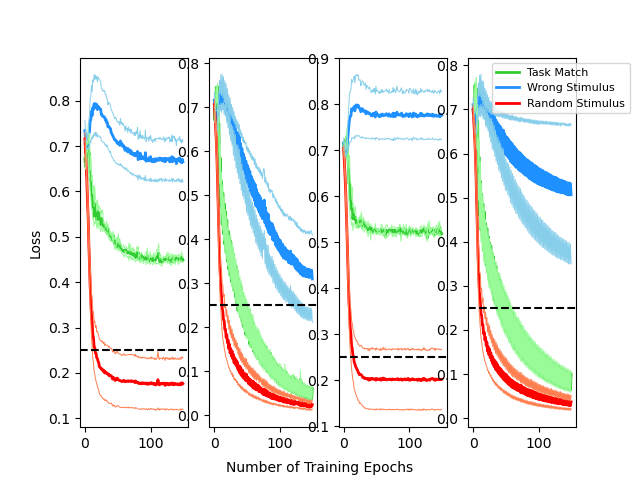

In [45]:
fig, ax = plt.subplots(1,4)

# plot losses

# Individual losses for each sample type (where the same stimulus is cued each round)
# ax[0].set_title("DNDLSTM Stim2LTM - Small Delays", fontsize=10)
ax[0].plot(match_mean_losses_small_dndlstmcell_stimuli2ltm, color='limegreen', label="Task Match", linewidth=2)
ax[0].plot(wrong_stimuli_mean_losses_small_dndlstmcell_stimuli2ltm, color='dodgerblue', label="Wrong Stimulus", linewidth=2)
ax[0].plot(random_stimuli_mean_losses_small_dndlstmcell_stimuli2ltm, color='red', label="Random Stimulus", linewidth=2)

## Standard deviations
ax[0].plot((match_mean_losses_small_dndlstmcell_stimuli2ltm + 2*stats.sem(match_losses_small_dndlstmcell_stimuli2ltm, axis=0, ddof=0)), color='palegreen', linewidth=0.7)
ax[0].plot((match_mean_losses_small_dndlstmcell_stimuli2ltm - 2*stats.sem(match_losses_small_dndlstmcell_stimuli2ltm, axis=0, ddof=0)), color='palegreen', linewidth=0.7)

ax[0].plot((wrong_stimuli_mean_losses_small_dndlstmcell_stimuli2ltm + 2*stats.sem(wrong_stimuli_losses_small_dndlstmcell_stimuli2ltm, axis=0, ddof=0)), color='skyblue', linewidth=0.7)
ax[0].plot((wrong_stimuli_mean_losses_small_dndlstmcell_stimuli2ltm - 2*stats.sem(wrong_stimuli_losses_small_dndlstmcell_stimuli2ltm, axis=0, ddof=0)), color='skyblue', linewidth=0.7)

ax[0].plot((random_stimuli_mean_losses_small_dndlstmcell_stimuli2ltm + 2*stats.sem(random_stimuli_losses_small_dndlstmcell_stimuli2ltm, axis=0, ddof=0)), color='coral', linewidth=0.7)
ax[0].plot((random_stimuli_mean_losses_small_dndlstmcell_stimuli2ltm - 2*stats.sem(random_stimuli_losses_small_dndlstmcell_stimuli2ltm, axis=0, ddof=0)), color='coral', linewidth=0.7)

# Individual losses for each sample type (where a different stimulus is cued each round)
# ax[1].set_title("WMEMLSTM Stim2LTM - Small Delays", fontsize=10)
ax[1].plot(match_mean_losses_small_wmemlstmcell_stimuli2ltm, color='limegreen', label="Task Match", linewidth=2)
ax[1].plot(wrong_stimuli_mean_losses_small_wmemlstmcell_stimuli2ltm, color='dodgerblue', label="Wrong Stimulus", linewidth=2)
ax[1].plot(random_stimuli_mean_losses_small_wmemlstmcell_stimuli2ltm, color='red', label="Random Stimulus", linewidth=2)

## Standard deviations
ax[1].plot((match_mean_losses_small_wmemlstmcell_stimuli2ltm + 2*stats.sem(match_losses_small_wmemlstmcell_stimuli2ltm, axis=0, ddof=0)), color='palegreen', linewidth=0.7)
ax[1].plot((match_mean_losses_small_wmemlstmcell_stimuli2ltm - 2*stats.sem(match_losses_small_wmemlstmcell_stimuli2ltm, axis=0, ddof=0)), color='palegreen', linewidth=0.7)      
           
ax[1].plot((wrong_stimuli_mean_losses_small_wmemlstmcell_stimuli2ltm + 2*stats.sem(wrong_stimuli_losses_small_wmemlstmcell_stimuli2ltm, axis=0, ddof=0)), color='skyblue', linewidth=0.7)
ax[1].plot((wrong_stimuli_mean_losses_small_wmemlstmcell_stimuli2ltm - 2*stats.sem(wrong_stimuli_losses_small_wmemlstmcell_stimuli2ltm, axis=0, ddof=0)), color='skyblue', linewidth=0.7)

ax[1].plot((random_stimuli_mean_losses_small_wmemlstmcell_stimuli2ltm + 2*stats.sem(random_stimuli_losses_small_wmemlstmcell_stimuli2ltm, axis=0, ddof=0)), color='coral', linewidth=0.7)
ax[1].plot((random_stimuli_mean_losses_small_wmemlstmcell_stimuli2ltm - 2*stats.sem(random_stimuli_losses_small_wmemlstmcell_stimuli2ltm, axis=0, ddof=0)), color='coral', linewidth=0.7)

# Individual losses for each sample type (where the same stimulus is cued each round)
# ax[2].set_title("DNDLSTM Stim2LTM - Large Delays", fontsize=10)
ax[2].plot(match_mean_losses_large_dndlstmcell_stimuli2ltm, color='limegreen', label="Task Match", linewidth=2)
ax[2].plot(wrong_stimuli_mean_losses_large_dndlstmcell_stimuli2ltm, color='dodgerblue', label="Wrong Stimulus", linewidth=2)
ax[2].plot(random_stimuli_mean_losses_large_dndlstmcell_stimuli2ltm, color='red', label="Random Stimulus", linewidth=2)

## Standard deviations
ax[2].plot((match_mean_losses_large_dndlstmcell_stimuli2ltm + 2*stats.sem(match_losses_large_dndlstmcell_stimuli2ltm, axis=0, ddof=0)), color='palegreen', linewidth=0.7)
ax[2].plot((match_mean_losses_large_dndlstmcell_stimuli2ltm - 2*stats.sem(match_losses_large_dndlstmcell_stimuli2ltm, axis=0, ddof=0)), color='palegreen', linewidth=0.7)

ax[2].plot((wrong_stimuli_mean_losses_large_dndlstmcell_stimuli2ltm + 2*stats.sem(wrong_stimuli_losses_large_dndlstmcell_stimuli2ltm, axis=0, ddof=0)), color='skyblue', linewidth=0.7)
ax[2].plot((wrong_stimuli_mean_losses_large_dndlstmcell_stimuli2ltm - 2*stats.sem(wrong_stimuli_losses_large_dndlstmcell_stimuli2ltm, axis=0, ddof=0)), color='skyblue', linewidth=0.7)

ax[2].plot((random_stimuli_mean_losses_large_dndlstmcell_stimuli2ltm + 2*stats.sem(random_stimuli_losses_large_dndlstmcell_stimuli2ltm, axis=0, ddof=0)), color='coral', linewidth=0.7)
ax[2].plot((random_stimuli_mean_losses_large_dndlstmcell_stimuli2ltm - 2*stats.sem(random_stimuli_losses_large_dndlstmcell_stimuli2ltm, axis=0, ddof=0)), color='coral', linewidth=0.7)

# Individual losses for each sample type (where a different stimulus is cued each round)
# ax[1].set_title("WMEMLSTM Stim2LTM - Large Delays, fontsize=10")
ax[3].plot(match_mean_losses_large_wmemlstmcell_stimuli2ltm, color='limegreen', label="Task Match", linewidth=2)
ax[3].plot(wrong_stimuli_mean_losses_large_wmemlstmcell_stimuli2ltm, color='dodgerblue', label="Wrong Stimulus", linewidth=2)
ax[3].plot(random_stimuli_mean_losses_large_wmemlstmcell_stimuli2ltm, color='red', label="Random Stimulus", linewidth=2)

## Standard deviations
ax[3].plot((match_mean_losses_large_wmemlstmcell_stimuli2ltm + 2*stats.sem(match_losses_large_wmemlstmcell_stimuli2ltm, axis=0, ddof=0)), color='palegreen', linewidth=0.7)
ax[3].plot((match_mean_losses_large_wmemlstmcell_stimuli2ltm - 2*stats.sem(match_losses_large_wmemlstmcell_stimuli2ltm, axis=0, ddof=0)), color='palegreen', linewidth=0.7)      
           
ax[3].plot((wrong_stimuli_mean_losses_large_wmemlstmcell_stimuli2ltm + 2*stats.sem(wrong_stimuli_losses_large_wmemlstmcell_stimuli2ltm, axis=0, ddof=0)), color='skyblue', linewidth=0.7)
ax[3].plot((wrong_stimuli_mean_losses_large_wmemlstmcell_stimuli2ltm - 2*stats.sem(wrong_stimuli_losses_large_wmemlstmcell_stimuli2ltm, axis=0, ddof=0)), color='skyblue', linewidth=0.7)

ax[3].plot((random_stimuli_mean_losses_large_wmemlstmcell_stimuli2ltm + 2*stats.sem(random_stimuli_losses_large_wmemlstmcell_stimuli2ltm, axis=0, ddof=0)), color='coral', linewidth=0.7)
ax[3].plot((random_stimuli_mean_losses_large_wmemlstmcell_stimuli2ltm - 2*stats.sem(random_stimuli_losses_large_wmemlstmcell_stimuli2ltm, axis=0, ddof=0)), color='coral', linewidth=0.7)

# Threshold line
ax[0].axhline(threshold, linestyle='dashed', color='black')
ax[1].axhline(threshold, linestyle='dashed', color='black')
ax[2].axhline(threshold, linestyle='dashed', color='black')
ax[3].axhline(threshold, linestyle='dashed', color='black')

# legend and show plot
ax[3].legend(fontsize=8, bbox_to_anchor=(1.55, 1), loc="upper right") # by default, the legend ignores all elements without a label attribute set.

fig.supxlabel('Number of Training Epochs', fontsize=10) # x label
ax[0].set_ylabel('Loss', fontsize=10) # y label

plt.show()

#### *Comparative Graphs for Simple RNNs vs. Memory Augmented LSTMs vs. WMEM Augmented LSTMs on the Dual Retro-Cue Task*

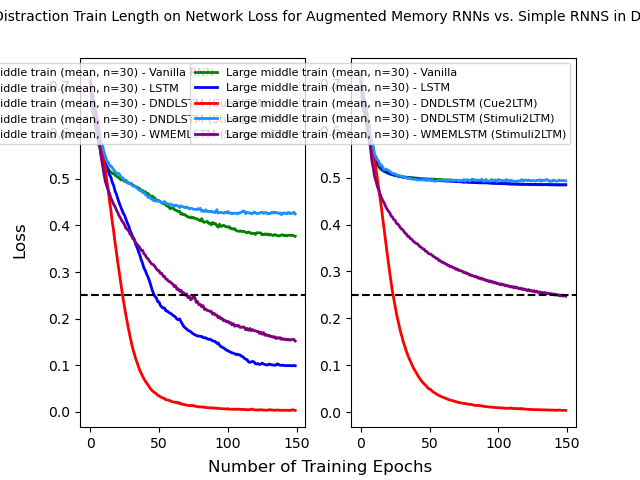

In [47]:
### General Plots for WMEM vs Simple RNNs for DRC Task ###

fig, ax = plt.subplots(1,2)

# plot losses
fig.suptitle("Average Effect of Distraction Train Length on Network Loss for Augmented Memory RNNs vs. Simple RNNS in Dual Retro-Cue Task", fontsize=10)

## Mean losses (Small Middle Train)
ax[0].plot(mean_loss_small_rnncell_drc, color='green', label="Small middle train (mean, n=" + str(num_networks) + ") - Vanilla RNN", linewidth=2)
ax[0].plot(mean_loss_small_lstmcell_drc, color='blue', label="Small middle train (mean, n=" + str(num_networks) + ") - LSTM", linewidth=2)
ax[0].plot(mean_loss_small_dndlstmcell_cues2ltm_drc, color='red', label="Small middle train (mean, n=" + str(num_networks) + ") - DNDLSTM (Cue2LTM)", linewidth=2)
ax[0].plot(mean_loss_small_dndlstmcell_stimuli2ltm_drc, color='dodgerblue', label="Small middle train (mean, n=" + str(num_networks) + ") - DNDLSTM (Stimuli2LTM)", linewidth=2)
ax[0].plot(mean_loss_small_wmemlstmcell_stimuli2ltm_drc, color='purple', label="Small middle train (mean, n=" + str(num_networks) + ") - WMEMLSTM (Stimuli2LTM)", linewidth=2)


## Mean losses (Large Middle Train)
ax[1].plot(mean_loss_large_rnncell_drc, color='green', label="Large middle train (mean, n=" + str(num_networks) + ") - Vanilla", linewidth=2)
ax[1].plot(mean_loss_large_lstmcell_drc, color='blue', label="Large middle train (mean, n=" + str(num_networks) + ") - LSTM", linewidth=2)
ax[1].plot(mean_loss_large_dndlstmcell_cues2ltm_drc, color='red', label="Large middle train (mean, n=" + str(num_networks) + ") - DNDLSTM (Cue2LTM)", linewidth=2)
ax[1].plot(mean_loss_large_dndlstmcell_stimuli2ltm_drc, color='dodgerblue', label="Large middle train (mean, n=" + str(num_networks) + ") - DNDLSTM (Stimuli2LTM)", linewidth=2)
ax[1].plot(mean_loss_large_wmemlstmcell_stimuli2ltm_drc, color='purple', label="Large middle train (mean, n=" + str(num_networks) + ") - WMEMLSTM (Stimuli2LTM)", linewidth=2)

# Threshold line
ax[0].axhline(threshold, linestyle='dashed', color='black')
ax[1].axhline(threshold, linestyle='dashed', color='black')

# legend and show plot
ax[0].legend(fontsize=8, loc="upper right") # by default, the legend ignores all elements without a label attribute set.
ax[1].legend(fontsize=8, loc="upper right") # by default, the legend ignores all elements without a label attribute set.

fig.supxlabel('Number of Training Epochs')
fig.supylabel('Loss')

plt.show()

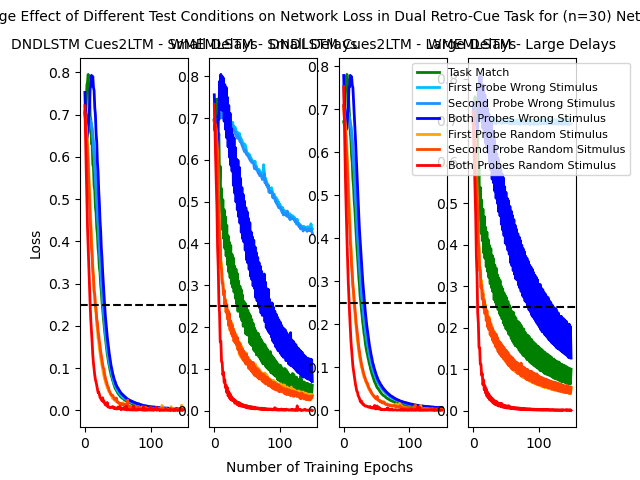

In [79]:
fig, ax = plt.subplots(1,4)

# plot losses
fig.suptitle("Average Effect of Different Test Conditions on Network Loss in Dual Retro-Cue Task for (n=" + str(num_networks) + ") Networks", fontsize=10)

# Individual losses for each sample type (where the same stimulus is cued each round)
ax[0].set_title("DNDLSTM Cues2LTM - Small Delays", fontsize=10)
ax[0].plot(match_mean_losses_small_dndlstmcell_cues2ltm, color='green', label="Task Match", linewidth=2)
ax[0].plot(first_probe_wrong_stimuli_mean_losses_small_dndlstmcell_cues2ltm, color='deepskyblue', label="First Probe Wrong Stimulus", linewidth=2)
ax[0].plot(second_probe_wrong_stimuli_mean_losses_small_dndlstmcell_cues2ltm, color='dodgerblue', label="Second Probe Wrong Stimulus", linewidth=2)
ax[0].plot(both_probes_wrong_stimuli_mean_losses_small_dndlstmcell_cues2ltm, color='blue', label="Both Probes Wrong Stimulus", linewidth=2)
ax[0].plot(first_probe_random_stimuli_mean_losses_small_dndlstmcell_cues2ltm, color='orange', label="First Probe Random Stimulus", linewidth=2)
ax[0].plot(second_probe_random_stimuli_mean_losses_small_dndlstmcell_cues2ltm, color='orangered', label="Second Probe Random Sitmulus", linewidth=2)
ax[0].plot(both_probes_random_stimuli_mean_losses_small_dndlstmcell_cues2ltm, color='red', label="Both Probes Random Stimulus", linewidth=2)

# Individual losses for each sample type (where a different stimulus is cued each round)
ax[1].set_title("WMEMLSTM - Small Delays", fontsize=10)
ax[1].plot(match_mean_losses_small_wmemlstmcell_stimuli2ltm, color='green', label="Task Match", linewidth=2)
ax[1].plot(first_probe_wrong_stimuli_mean_losses_small_wmemlstmcell_stimuli2ltm, color='deepskyblue', label="First Probe Wrong Stimulus", linewidth=2)
ax[1].plot(second_probe_wrong_stimuli_mean_losses_small_wmemlstmcell_stimuli2ltm, color='dodgerblue', label="Second Probe Wrong Stimulus", linewidth=2)
ax[1].plot(both_probes_wrong_stimuli_mean_losses_small_wmemlstmcell_stimuli2ltm, color='blue', label="Both Probes Wrong Stimulus", linewidth=2)
ax[1].plot(first_probe_random_stimuli_mean_losses_small_wmemlstmcell_stimuli2ltm, color='orange', label="First Probe Random Stimulus", linewidth=2)
ax[1].plot(second_probe_random_stimuli_mean_losses_small_wmemlstmcell_stimuli2ltm, color='orangered', label="Second Probe Random Sitmulus", linewidth=2)
ax[1].plot(both_probes_random_stimuli_mean_losses_small_wmemlstmcell_stimuli2ltm, color='red', label="Both Probes Random Stimulus", linewidth=2)

# Individual losses for each sample type (where the same stimulus is cued each round)
ax[2].set_title("DNDLSTM Cues2LTM - Large Delays", fontsize=10)
ax[2].plot(match_mean_losses_large_dndlstmcell_cues2ltm, color='green', label="Task Match", linewidth=2)
ax[2].plot(first_probe_wrong_stimuli_mean_losses_large_dndlstmcell_cues2ltm, color='deepskyblue', label="First Probe Wrong Stimulus", linewidth=2)
ax[2].plot(second_probe_wrong_stimuli_mean_losses_large_dndlstmcell_cues2ltm, color='dodgerblue', label="Second Probe Wrong Stimulus", linewidth=2)
ax[2].plot(both_probes_wrong_stimuli_mean_losses_large_dndlstmcell_cues2ltm, color='blue', label="Both Probes Wrong Stimulus", linewidth=2)
ax[2].plot(first_probe_random_stimuli_mean_losses_large_dndlstmcell_cues2ltm, color='orange', label="First Probe Random Stimulus", linewidth=2)
ax[2].plot(second_probe_random_stimuli_mean_losses_large_dndlstmcell_cues2ltm, color='orangered', label="Second Probe Random Sitmulus", linewidth=2)
ax[2].plot(both_probes_random_stimuli_mean_losses_large_dndlstmcell_cues2ltm, color='red', label="Both Probes Random Stimulus", linewidth=2)

# Individual losses for each sample type (where a different stimulus is cued each round)
ax[3].set_title("WMEMLSTM - Large Delays", fontsize=10)
ax[3].plot(match_mean_losses_large_wmemlstmcell_stimuli2ltm, color='green', label="Task Match", linewidth=2)
ax[3].plot(first_probe_wrong_stimuli_mean_losses_large_wmemlstmcell_stimuli2ltm, color='deepskyblue', label="First Probe Wrong Stimulus", linewidth=2)
ax[3].plot(second_probe_wrong_stimuli_mean_losses_large_wmemlstmcell_stimuli2ltm, color='dodgerblue', label="Second Probe Wrong Stimulus", linewidth=2)
ax[3].plot(both_probes_wrong_stimuli_mean_losses_large_wmemlstmcell_stimuli2ltm, color='blue', label="Both Probes Wrong Stimulus", linewidth=2)
ax[3].plot(first_probe_random_stimuli_mean_losses_large_wmemlstmcell_stimuli2ltm, color='orange', label="First Probe Random Stimulus", linewidth=2)
ax[3].plot(second_probe_random_stimuli_mean_losses_large_wmemlstmcell_stimuli2ltm, color='orangered', label="Second Probe Random Sitmulus", linewidth=2)
ax[3].plot(both_probes_random_stimuli_mean_losses_large_wmemlstmcell_stimuli2ltm, color='red', label="Both Probes Random Stimulus", linewidth=2)

# Threshold line
ax[0].axhline(threshold, linestyle='dashed', color='black')
ax[1].axhline(threshold, linestyle='dashed', color='black')
ax[2].axhline(threshold, linestyle='dashed', color='black')
ax[3].axhline(threshold, linestyle='dashed', color='black')

# legend and show plot
ax[3].legend(fontsize=8, bbox_to_anchor=(1.55, 1), loc="upper right") # by default, the legend ignores all elements without a label attribute set.

fig.supxlabel('Number of Training Epochs', fontsize=10) # x label
ax[0].set_ylabel('Loss', fontsize=10) # y label

plt.show()

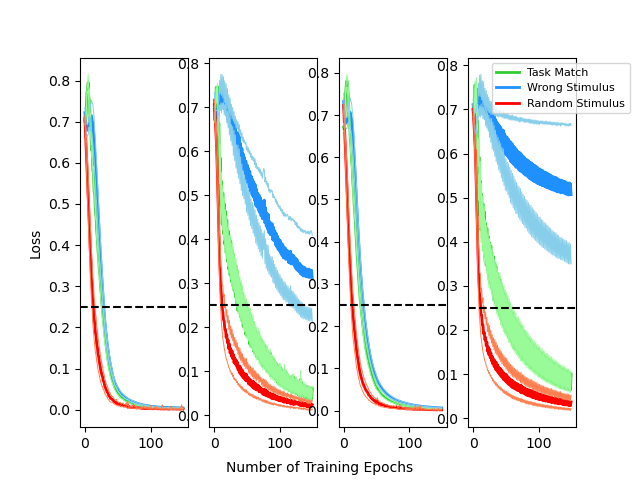

In [81]:
fig, ax = plt.subplots(1,4)

# plot losses

# Individual losses for each sample type (where the same stimulus is cued each round)
# ax[0].set_title("WMEMLSTM - Small Delays", fontsize=10)
ax[0].plot(match_mean_losses_small_dndlstmcell_cues2ltm, color='limegreen', label="Task Match", linewidth=2)
ax[0].plot(wrong_stimuli_mean_losses_small_dndlstmcell_cues2ltm, color='dodgerblue', label="Wrong Stimulus", linewidth=2)
ax[0].plot(random_stimuli_mean_losses_small_dndlstmcell_cues2ltm, color='red', label="Random Stimulus", linewidth=2)

## Standard deviations
ax[0].plot((match_mean_losses_small_dndlstmcell_cues2ltm + 2*stats.sem(match_losses_small_dndlstmcell_cues2ltm, axis=0, ddof=0)), color='palegreen', linewidth=0.7)
ax[0].plot((match_mean_losses_small_dndlstmcell_cues2ltm - 2*stats.sem(match_losses_small_dndlstmcell_cues2ltm, axis=0, ddof=0)), color='palegreen', linewidth=0.7)

ax[0].plot((wrong_stimuli_mean_losses_small_dndlstmcell_cues2ltm + 2*stats.sem(wrong_stimuli_losses_small_dndlstmcell_cues2ltm, axis=0, ddof=0)), color='skyblue', linewidth=0.7)
ax[0].plot((wrong_stimuli_mean_losses_small_dndlstmcell_cues2ltm - 2*stats.sem(wrong_stimuli_losses_small_dndlstmcell_cues2ltm, axis=0, ddof=0)), color='skyblue', linewidth=0.7)

ax[0].plot((random_stimuli_mean_losses_small_dndlstmcell_cues2ltm + 2*stats.sem(random_stimuli_losses_small_dndlstmcell_cues2ltm, axis=0, ddof=0)), color='coral', linewidth=0.7)
ax[0].plot((random_stimuli_mean_losses_small_dndlstmcell_cues2ltm - 2*stats.sem(random_stimuli_losses_small_dndlstmcell_cues2ltm, axis=0, ddof=0)), color='coral', linewidth=0.7)

# Individual losses for each sample type (where a different stimulus is cued each round)
# ax[1].set_title("DNDLSTM Cues2LTM - Small Delays", fontsize=10)
ax[1].plot(match_mean_losses_small_wmemlstmcell_stimuli2ltm, color='limegreen', label="Task Match", linewidth=2)
ax[1].plot(wrong_stimuli_mean_losses_small_wmemlstmcell_stimuli2ltm, color='dodgerblue', label="Wrong Stimulus", linewidth=2)
ax[1].plot(random_stimuli_mean_losses_small_wmemlstmcell_stimuli2ltm, color='red', label="Random Stimulus", linewidth=2)

## Standard deviations
ax[1].plot((match_mean_losses_small_wmemlstmcell_stimuli2ltm + 2*stats.sem(match_losses_small_wmemlstmcell_stimuli2ltm, axis=0, ddof=0)), color='palegreen', linewidth=0.7)
ax[1].plot((match_mean_losses_small_wmemlstmcell_stimuli2ltm - 2*stats.sem(match_losses_small_wmemlstmcell_stimuli2ltm, axis=0, ddof=0)), color='palegreen', linewidth=0.7)      
           
ax[1].plot((wrong_stimuli_mean_losses_small_wmemlstmcell_stimuli2ltm + 2*stats.sem(wrong_stimuli_losses_small_wmemlstmcell_stimuli2ltm, axis=0, ddof=0)), color='skyblue', linewidth=0.7)
ax[1].plot((wrong_stimuli_mean_losses_small_wmemlstmcell_stimuli2ltm - 2*stats.sem(wrong_stimuli_losses_small_wmemlstmcell_stimuli2ltm, axis=0, ddof=0)), color='skyblue', linewidth=0.7)

ax[1].plot((random_stimuli_mean_losses_small_wmemlstmcell_stimuli2ltm + 2*stats.sem(random_stimuli_losses_small_wmemlstmcell_stimuli2ltm, axis=0, ddof=0)), color='coral', linewidth=0.7)
ax[1].plot((random_stimuli_mean_losses_small_wmemlstmcell_stimuli2ltm - 2*stats.sem(random_stimuli_losses_small_wmemlstmcell_stimuli2ltm, axis=0, ddof=0)), color='coral', linewidth=0.7)

# Individual losses for each sample type (where the same stimulus is cued each round)
# ax[2].set_title("WMEMLSTM - Large Delays", fontsize=10)
ax[2].plot(match_mean_losses_large_dndlstmcell_cues2ltm, color='limegreen', label="Task Match", linewidth=2)
ax[2].plot(wrong_stimuli_mean_losses_large_dndlstmcell_cues2ltm, color='dodgerblue', label="Wrong Stimulus", linewidth=2)
ax[2].plot(random_stimuli_mean_losses_large_dndlstmcell_cues2ltm, color='red', label="Random Stimulus", linewidth=2)

## Standard deviations
ax[2].plot((match_mean_losses_large_dndlstmcell_cues2ltm + 2*stats.sem(match_losses_large_dndlstmcell_cues2ltm, axis=0, ddof=0)), color='palegreen', linewidth=0.7)
ax[2].plot((match_mean_losses_large_dndlstmcell_cues2ltm - 2*stats.sem(match_losses_large_dndlstmcell_cues2ltm, axis=0, ddof=0)), color='palegreen', linewidth=0.7)

ax[2].plot((wrong_stimuli_mean_losses_large_dndlstmcell_cues2ltm + 2*stats.sem(wrong_stimuli_losses_large_dndlstmcell_cues2ltm, axis=0, ddof=0)), color='skyblue', linewidth=0.7)
ax[2].plot((wrong_stimuli_mean_losses_large_dndlstmcell_cues2ltm - 2*stats.sem(wrong_stimuli_losses_large_dndlstmcell_cues2ltm, axis=0, ddof=0)), color='skyblue', linewidth=0.7)

ax[2].plot((random_stimuli_mean_losses_large_dndlstmcell_cues2ltm + 2*stats.sem(random_stimuli_losses_large_dndlstmcell_cues2ltm, axis=0, ddof=0)), color='coral', linewidth=0.7)
ax[2].plot((random_stimuli_mean_losses_large_dndlstmcell_cues2ltm - 2*stats.sem(random_stimuli_losses_large_dndlstmcell_cues2ltm, axis=0, ddof=0)), color='coral', linewidth=0.7)

# Individual losses for each sample type (where a different stimulus is cued each round)
# ax[3].set_title("DNDLSTM Cues2LTM - Large Delays", fontsize=10)
ax[3].plot(match_mean_losses_large_wmemlstmcell_stimuli2ltm, color='limegreen', label="Task Match", linewidth=2)
ax[3].plot(wrong_stimuli_mean_losses_large_wmemlstmcell_stimuli2ltm, color='dodgerblue', label="Wrong Stimulus", linewidth=2)
ax[3].plot(random_stimuli_mean_losses_large_wmemlstmcell_stimuli2ltm, color='red', label="Random Stimulus", linewidth=2)

## Standard deviations
ax[3].plot((match_mean_losses_large_wmemlstmcell_stimuli2ltm + 2*stats.sem(match_losses_large_wmemlstmcell_stimuli2ltm, axis=0, ddof=0)), color='palegreen', linewidth=0.7)
ax[3].plot((match_mean_losses_large_wmemlstmcell_stimuli2ltm - 2*stats.sem(match_losses_large_wmemlstmcell_stimuli2ltm, axis=0, ddof=0)), color='palegreen', linewidth=0.7)      
           
ax[3].plot((wrong_stimuli_mean_losses_large_wmemlstmcell_stimuli2ltm + 2*stats.sem(wrong_stimuli_losses_large_wmemlstmcell_stimuli2ltm, axis=0, ddof=0)), color='skyblue', linewidth=0.7)
ax[3].plot((wrong_stimuli_mean_losses_large_wmemlstmcell_stimuli2ltm - 2*stats.sem(wrong_stimuli_losses_large_wmemlstmcell_stimuli2ltm, axis=0, ddof=0)), color='skyblue', linewidth=0.7)

ax[3].plot((random_stimuli_mean_losses_large_wmemlstmcell_stimuli2ltm + 2*stats.sem(random_stimuli_losses_large_wmemlstmcell_stimuli2ltm, axis=0, ddof=0)), color='coral', linewidth=0.7)
ax[3].plot((random_stimuli_mean_losses_large_wmemlstmcell_stimuli2ltm - 2*stats.sem(random_stimuli_losses_large_wmemlstmcell_stimuli2ltm, axis=0, ddof=0)), color='coral', linewidth=0.7)

# Threshold line
ax[0].axhline(threshold, linestyle='dashed', color='black')
ax[1].axhline(threshold, linestyle='dashed', color='black')
ax[2].axhline(threshold, linestyle='dashed', color='black')
ax[3].axhline(threshold, linestyle='dashed', color='black')

# legend and show plot
ax[3].legend(fontsize=8, bbox_to_anchor=(1.55, 1), loc="upper right") # by default, the legend ignores all elements without a label attribute set.

fig.supxlabel('Number of Training Epochs', fontsize=10) # x label
ax[0].set_ylabel('Loss', fontsize=10) # y label

plt.show()

#### *Comparative Graphs on Each Trial Type (Testing Same or Different Cues Each Round) for Memory Augmented LSTMs on the Dual Retro-Cue Task*

In [ ]:
# ### Specific Plots for WMEM DRC Task ###

# ### Cues2LTM Learning ###

# mean_sample_loss_small_dndlstmcell_cues2ltm_drc_dict, sample_losses_small_dndlstmcell_cues2ltm_drc_dict = partition_sample_losses("dual_retro_cue", mean_sample_loss_small_dndlstmcell_cues2ltm_drc, sample_losses_small_dndlstmcell_cues2ltm_drc)

# task0_mean_loss = mean_sample_loss_small_dndlstmcell_cues2ltm_drc_dict[0]
# task1_mean_loss = mean_sample_loss_small_dndlstmcell_cues2ltm_drc_dict[1]
# task2_mean_loss = mean_sample_loss_small_dndlstmcell_cues2ltm_drc_dict[2]
# task3_mean_loss = mean_sample_loss_small_dndlstmcell_cues2ltm_drc_dict[3]
# task4_mean_loss = mean_sample_loss_small_dndlstmcell_cues2ltm_drc_dict[4]
# task5_mean_loss = mean_sample_loss_small_dndlstmcell_cues2ltm_drc_dict[5]
# task6_mean_loss = mean_sample_loss_small_dndlstmcell_cues2ltm_drc_dict[6]
# task7_mean_loss = mean_sample_loss_small_dndlstmcell_cues2ltm_drc_dict[7]
# task8_mean_loss = mean_sample_loss_small_dndlstmcell_cues2ltm_drc_dict[8]
# task9_mean_loss = mean_sample_loss_small_dndlstmcell_cues2ltm_drc_dict[9]
# task10_mean_loss = mean_sample_loss_small_dndlstmcell_cues2ltm_drc_dict[10]
# task11_mean_loss = mean_sample_loss_small_dndlstmcell_cues2ltm_drc_dict[11]
# task12_mean_loss = mean_sample_loss_small_dndlstmcell_cues2ltm_drc_dict[12]
# task13_mean_loss = mean_sample_loss_small_dndlstmcell_cues2ltm_drc_dict[13]
# task14_mean_loss = mean_sample_loss_small_dndlstmcell_cues2ltm_drc_dict[14]
# task15_mean_loss = mean_sample_loss_small_dndlstmcell_cues2ltm_drc_dict[15]
# task16_mean_loss = mean_sample_loss_small_dndlstmcell_cues2ltm_drc_dict[16]
# task17_mean_loss = mean_sample_loss_small_dndlstmcell_cues2ltm_drc_dict[17]
# task18_mean_loss = mean_sample_loss_small_dndlstmcell_cues2ltm_drc_dict[18]
# task19_mean_loss = mean_sample_loss_small_dndlstmcell_cues2ltm_drc_dict[19]
# task20_mean_loss = mean_sample_loss_small_dndlstmcell_cues2ltm_drc_dict[20]
# task21_mean_loss = mean_sample_loss_small_dndlstmcell_cues2ltm_drc_dict[21]
# task22_mean_loss = mean_sample_loss_small_dndlstmcell_cues2ltm_drc_dict[22]
# task23_mean_loss = mean_sample_loss_small_dndlstmcell_cues2ltm_drc_dict[23]
# task24_mean_loss = mean_sample_loss_small_dndlstmcell_cues2ltm_drc_dict[24]
# task25_mean_loss = mean_sample_loss_small_dndlstmcell_cues2ltm_drc_dict[25]
# task26_mean_loss = mean_sample_loss_small_dndlstmcell_cues2ltm_drc_dict[26]
# task27_mean_loss = mean_sample_loss_small_dndlstmcell_cues2ltm_drc_dict[27]

# task0_sample_losses = sample_losses_small_dndlstmcell_cues2ltm_drc_dict[0]
# task1_sample_losses = sample_losses_small_dndlstmcell_cues2ltm_drc_dict[1]
# task2_sample_losses = sample_losses_small_dndlstmcell_cues2ltm_drc_dict[2]
# task3_sample_losses = sample_losses_small_dndlstmcell_cues2ltm_drc_dict[3]
# task4_sample_losses = sample_losses_small_dndlstmcell_cues2ltm_drc_dict[4]
# task5_sample_losses = sample_losses_small_dndlstmcell_cues2ltm_drc_dict[5]
# task6_sample_losses = sample_losses_small_dndlstmcell_cues2ltm_drc_dict[6]
# task7_sample_losses = sample_losses_small_dndlstmcell_cues2ltm_drc_dict[7]
# task8_sample_losses = sample_losses_small_dndlstmcell_cues2ltm_drc_dict[8]
# task9_sample_losses = sample_losses_small_dndlstmcell_cues2ltm_drc_dict[9]
# task10_sample_losses = sample_losses_small_dndlstmcell_cues2ltm_drc_dict[10]
# task11_sample_losses = sample_losses_small_dndlstmcell_cues2ltm_drc_dict[11]
# task12_sample_losses = sample_losses_small_dndlstmcell_cues2ltm_drc_dict[12]
# task13_sample_losses = sample_losses_small_dndlstmcell_cues2ltm_drc_dict[13]
# task14_sample_losses = sample_losses_small_dndlstmcell_cues2ltm_drc_dict[14]
# task15_sample_losses = sample_losses_small_dndlstmcell_cues2ltm_drc_dict[15]
# task16_sample_losses = sample_losses_small_dndlstmcell_cues2ltm_drc_dict[16]
# task17_sample_losses = sample_losses_small_dndlstmcell_cues2ltm_drc_dict[17]
# task18_sample_losses = sample_losses_small_dndlstmcell_cues2ltm_drc_dict[18]
# task19_sample_losses = sample_losses_small_dndlstmcell_cues2ltm_drc_dict[19]
# task20_sample_losses = sample_losses_small_dndlstmcell_cues2ltm_drc_dict[20]
# task21_sample_losses = sample_losses_small_dndlstmcell_cues2ltm_drc_dict[21]
# task22_sample_losses = sample_losses_small_dndlstmcell_cues2ltm_drc_dict[22]
# task23_sample_losses = sample_losses_small_dndlstmcell_cues2ltm_drc_dict[23]
# task24_sample_losses = sample_losses_small_dndlstmcell_cues2ltm_drc_dict[24]
# task25_sample_losses = sample_losses_small_dndlstmcell_cues2ltm_drc_dict[25]
# task26_sample_losses = sample_losses_small_dndlstmcell_cues2ltm_drc_dict[26]
# task27_sample_losses = sample_losses_small_dndlstmcell_cues2ltm_drc_dict[27]

# # testing different cases when the same cues are made before the probes (Vanilla Working Memory Case)
# match_losses_same_cues = [task1_mean_loss, task3_mean_loss]
# first_probe_wrong_stimuli_losses_same_cues = [task12_mean_loss, task14_mean_loss]
# first_probe_random_stimuli_losses_same_cues = [task13_mean_loss, task15_mean_loss]
# second_probe_wrong_stimuli_losses_same_cues = [task16_mean_loss, task18_mean_loss]
# second_probe_random_stimuli_losses_same_cues = [task17_mean_loss, task19_mean_loss]
# both_probes_wrong_stimuli_losses_same_cues = [task24_mean_loss, task26_mean_loss]
# both_probes_random_stimuli_losses_same_cues = [task25_mean_loss, task27_mean_loss]

# match_mean_losses_same_cues = np.mean(match_losses_same_cues, axis=0)
# first_probe_wrong_stimuli_mean_losses_same_cues = np.mean(first_probe_wrong_stimuli_losses_same_cues, axis=0)
# first_probe_random_stimuli_mean_losses_same_cues = np.mean(first_probe_random_stimuli_losses_same_cues, axis=0)
# second_probe_wrong_stimuli_mean_losses_same_cues = np.mean(second_probe_wrong_stimuli_losses_same_cues, axis=0)
# second_probe_random_stimuli_mean_losses_same_cues = np.mean(second_probe_random_stimuli_losses_same_cues, axis=0)
# both_probes_wrong_stimuli_mean_losses_same_cues = np.mean(both_probes_wrong_stimuli_losses_same_cues, axis=0)
# both_probes_random_stimuli_mean_losses_same_cues = np.mean(both_probes_random_stimuli_losses_same_cues, axis=0)

# # testing different cases when a different second cue is made before the second probe (ASWM case)
# match_losses_different_cues = [task0_mean_loss, task2_mean_loss]
# first_probe_wrong_stimuli_losses_different_cues = [task4_mean_loss, task6_mean_loss]
# first_probe_random_stimuli_losses_different_cues = [task5_mean_loss, task7_mean_loss]
# second_probe_wrong_stimuli_losses_different_cues = [task8_mean_loss, task10_mean_loss]
# second_probe_random_stimuli_losses_different_cues = [task9_mean_loss, task11_mean_loss]
# both_probes_wrong_stimuli_losses_different_cues = [task20_mean_loss, task22_mean_loss]
# both_probes_random_stimuli_losses_different_cues = [task21_mean_loss, task23_mean_loss]

# match_mean_losses_different_cues = np.mean(match_losses_different_cues, axis=0)
# first_probe_wrong_stimuli_mean_losses_different_cues = np.mean(first_probe_wrong_stimuli_losses_different_cues, axis=0)
# first_probe_random_stimuli_mean_losses_different_cues = np.mean(first_probe_random_stimuli_losses_different_cues, axis=0)
# second_probe_wrong_stimuli_mean_losses_different_cues = np.mean(second_probe_wrong_stimuli_losses_different_cues, axis=0)
# second_probe_random_stimuli_mean_losses_different_cues = np.mean(second_probe_random_stimuli_losses_different_cues, axis=0)
# both_probes_wrong_stimuli_mean_losses_different_cues = np.mean(both_probes_wrong_stimuli_losses_different_cues, axis=0)
# both_probes_random_stimuli_mean_losses_different_cues = np.mean(both_probes_random_stimuli_losses_different_cues, axis=0)

# # same cues
# match_stimuli_same_cues = [task1_mean_loss, task3_mean_loss]
# wrong_stimuli_same_cues = [task12_mean_loss, task14_mean_loss, task16_mean_loss, task18_mean_loss, task24_mean_loss, task26_mean_loss]
# random_stimuli_same_cues = [task13_mean_loss, task15_mean_loss, task17_mean_loss, task19_mean_loss, task25_mean_loss, task27_mean_loss]

# same_cues_cues2ltm = match_stimuli_same_cues + wrong_stimuli_same_cues + random_stimuli_same_cues
# mean_losses_same_cues_cues2ltm = np.mean(same_cues_cues2ltm, axis=0)

# # different cues
# match_stimuli_different_cues = [task0_mean_loss, task2_mean_loss]
# wrong_stimuli_different_cues = [task4_mean_loss, task6_mean_loss, task8_mean_loss, task10_mean_loss, task20_mean_loss, task22_mean_loss]
# random_stimuli_different_cues = [task5_mean_loss, task7_mean_loss, task9_mean_loss, task11_mean_loss, task21_mean_loss, task23_mean_loss]

# different_cues_cues2ltm = match_stimuli_different_cues + wrong_stimuli_different_cues + random_stimuli_different_cues
# mean_losses_different_cues_cues2ltm = np.mean(different_cues_cues2ltm, axis=0)

# ### Stim2LTM Learning ###

# mean_sample_loss_small_dndlstmcell_stimuli2ltm_drc_dict, sample_losses_small_dndlstmcell_stimuli2ltm_drc_dict = partition_sample_losses("dual_retro_cue", mean_sample_loss_small_dndlstmcell_stimuli2ltm_drc, sample_losses_small_dndlstmcell_stimuli2ltm_drc)

# task0_mean_loss = mean_sample_loss_small_dndlstmcell_stimuli2ltm_drc_dict[0]
# task1_mean_loss = mean_sample_loss_small_dndlstmcell_stimuli2ltm_drc_dict[1]
# task2_mean_loss = mean_sample_loss_small_dndlstmcell_stimuli2ltm_drc_dict[2]
# task3_mean_loss = mean_sample_loss_small_dndlstmcell_stimuli2ltm_drc_dict[3]
# task4_mean_loss = mean_sample_loss_small_dndlstmcell_stimuli2ltm_drc_dict[4]
# task5_mean_loss = mean_sample_loss_small_dndlstmcell_stimuli2ltm_drc_dict[5]
# task6_mean_loss = mean_sample_loss_small_dndlstmcell_stimuli2ltm_drc_dict[6]
# task7_mean_loss = mean_sample_loss_small_dndlstmcell_stimuli2ltm_drc_dict[7]
# task8_mean_loss = mean_sample_loss_small_dndlstmcell_stimuli2ltm_drc_dict[8]
# task9_mean_loss = mean_sample_loss_small_dndlstmcell_stimuli2ltm_drc_dict[9]
# task10_mean_loss = mean_sample_loss_small_dndlstmcell_stimuli2ltm_drc_dict[10]
# task11_mean_loss = mean_sample_loss_small_dndlstmcell_stimuli2ltm_drc_dict[11]
# task12_mean_loss = mean_sample_loss_small_dndlstmcell_stimuli2ltm_drc_dict[12]
# task13_mean_loss = mean_sample_loss_small_dndlstmcell_stimuli2ltm_drc_dict[13]
# task14_mean_loss = mean_sample_loss_small_dndlstmcell_stimuli2ltm_drc_dict[14]
# task15_mean_loss = mean_sample_loss_small_dndlstmcell_stimuli2ltm_drc_dict[15]
# task16_mean_loss = mean_sample_loss_small_dndlstmcell_stimuli2ltm_drc_dict[16]
# task17_mean_loss = mean_sample_loss_small_dndlstmcell_stimuli2ltm_drc_dict[17]
# task18_mean_loss = mean_sample_loss_small_dndlstmcell_stimuli2ltm_drc_dict[18]
# task19_mean_loss = mean_sample_loss_small_dndlstmcell_stimuli2ltm_drc_dict[19]
# task20_mean_loss = mean_sample_loss_small_dndlstmcell_stimuli2ltm_drc_dict[20]
# task21_mean_loss = mean_sample_loss_small_dndlstmcell_stimuli2ltm_drc_dict[21]
# task22_mean_loss = mean_sample_loss_small_dndlstmcell_stimuli2ltm_drc_dict[22]
# task23_mean_loss = mean_sample_loss_small_dndlstmcell_stimuli2ltm_drc_dict[23]
# task24_mean_loss = mean_sample_loss_small_dndlstmcell_stimuli2ltm_drc_dict[24]
# task25_mean_loss = mean_sample_loss_small_dndlstmcell_stimuli2ltm_drc_dict[25]
# task26_mean_loss = mean_sample_loss_small_dndlstmcell_stimuli2ltm_drc_dict[26]
# task27_mean_loss = mean_sample_loss_small_dndlstmcell_stimuli2ltm_drc_dict[27]

# task0_sample_losses = sample_losses_small_dndlstmcell_stimuli2ltm_drc_dict[0]
# task1_sample_losses = sample_losses_small_dndlstmcell_stimuli2ltm_drc_dict[1]
# task2_sample_losses = sample_losses_small_dndlstmcell_stimuli2ltm_drc_dict[2]
# task3_sample_losses = sample_losses_small_dndlstmcell_stimuli2ltm_drc_dict[3]
# task4_sample_losses = sample_losses_small_dndlstmcell_stimuli2ltm_drc_dict[4]
# task5_sample_losses = sample_losses_small_dndlstmcell_stimuli2ltm_drc_dict[5]
# task6_sample_losses = sample_losses_small_dndlstmcell_stimuli2ltm_drc_dict[6]
# task7_sample_losses = sample_losses_small_dndlstmcell_stimuli2ltm_drc_dict[7]
# task8_sample_losses = sample_losses_small_dndlstmcell_stimuli2ltm_drc_dict[8]
# task9_sample_losses = sample_losses_small_dndlstmcell_stimuli2ltm_drc_dict[9]
# task10_sample_losses = sample_losses_small_dndlstmcell_stimuli2ltm_drc_dict[10]
# task11_sample_losses = sample_losses_small_dndlstmcell_stimuli2ltm_drc_dict[11]
# task12_sample_losses = sample_losses_small_dndlstmcell_stimuli2ltm_drc_dict[12]
# task13_sample_losses = sample_losses_small_dndlstmcell_stimuli2ltm_drc_dict[13]
# task14_sample_losses = sample_losses_small_dndlstmcell_stimuli2ltm_drc_dict[14]
# task15_sample_losses = sample_losses_small_dndlstmcell_stimuli2ltm_drc_dict[15]
# task16_sample_losses = sample_losses_small_dndlstmcell_stimuli2ltm_drc_dict[16]
# task17_sample_losses = sample_losses_small_dndlstmcell_stimuli2ltm_drc_dict[17]
# task18_sample_losses = sample_losses_small_dndlstmcell_stimuli2ltm_drc_dict[18]
# task19_sample_losses = sample_losses_small_dndlstmcell_stimuli2ltm_drc_dict[19]
# task20_sample_losses = sample_losses_small_dndlstmcell_stimuli2ltm_drc_dict[20]
# task21_sample_losses = sample_losses_small_dndlstmcell_stimuli2ltm_drc_dict[21]
# task22_sample_losses = sample_losses_small_dndlstmcell_stimuli2ltm_drc_dict[22]
# task23_sample_losses = sample_losses_small_dndlstmcell_stimuli2ltm_drc_dict[23]
# task24_sample_losses = sample_losses_small_dndlstmcell_stimuli2ltm_drc_dict[24]
# task25_sample_losses = sample_losses_small_dndlstmcell_stimuli2ltm_drc_dict[25]
# task26_sample_losses = sample_losses_small_dndlstmcell_stimuli2ltm_drc_dict[26]
# task27_sample_losses = sample_losses_small_dndlstmcell_stimuli2ltm_drc_dict[27]

# # testing different cases when the same cues are made before the probes (Vanilla Working Memory Case)
# match_losses_same_cues = [task1_mean_loss, task3_mean_loss]
# first_probe_wrong_stimuli_losses_same_cues = [task12_mean_loss, task14_mean_loss]
# first_probe_random_stimuli_losses_same_cues = [task13_mean_loss, task15_mean_loss]
# second_probe_wrong_stimuli_losses_same_cues = [task16_mean_loss, task18_mean_loss]
# second_probe_random_stimuli_losses_same_cues = [task17_mean_loss, task19_mean_loss]
# both_probes_wrong_stimuli_losses_same_cues = [task24_mean_loss, task26_mean_loss]
# both_probes_random_stimuli_losses_same_cues = [task25_mean_loss, task27_mean_loss]

# match_mean_losses_same_cues = np.mean(match_losses_same_cues, axis=0)
# first_probe_wrong_stimuli_mean_losses_same_cues = np.mean(first_probe_wrong_stimuli_losses_same_cues, axis=0)
# first_probe_random_stimuli_mean_losses_same_cues = np.mean(first_probe_random_stimuli_losses_same_cues, axis=0)
# second_probe_wrong_stimuli_mean_losses_same_cues = np.mean(second_probe_wrong_stimuli_losses_same_cues, axis=0)
# second_probe_random_stimuli_mean_losses_same_cues = np.mean(second_probe_random_stimuli_losses_same_cues, axis=0)
# both_probes_wrong_stimuli_mean_losses_same_cues = np.mean(both_probes_wrong_stimuli_losses_same_cues, axis=0)
# both_probes_random_stimuli_mean_losses_same_cues = np.mean(both_probes_random_stimuli_losses_same_cues, axis=0)

# # testing different cases when a different second cue is made before the second probe (ASWM case)
# match_losses_different_cues = [task0_mean_loss, task2_mean_loss]
# first_probe_wrong_stimuli_losses_different_cues = [task4_mean_loss, task6_mean_loss]
# first_probe_random_stimuli_losses_different_cues = [task5_mean_loss, task7_mean_loss]
# second_probe_wrong_stimuli_losses_different_cues = [task8_mean_loss, task10_mean_loss]
# second_probe_random_stimuli_losses_different_cues = [task9_mean_loss, task11_mean_loss]
# both_probes_wrong_stimuli_losses_different_cues = [task20_mean_loss, task22_mean_loss]
# both_probes_random_stimuli_losses_different_cues = [task21_mean_loss, task23_mean_loss]

# match_mean_losses_different_cues = np.mean(match_losses_different_cues, axis=0)
# first_probe_wrong_stimuli_mean_losses_different_cues = np.mean(first_probe_wrong_stimuli_losses_different_cues, axis=0)
# first_probe_random_stimuli_mean_losses_different_cues = np.mean(first_probe_random_stimuli_losses_different_cues, axis=0)
# second_probe_wrong_stimuli_mean_losses_different_cues = np.mean(second_probe_wrong_stimuli_losses_different_cues, axis=0)
# second_probe_random_stimuli_mean_losses_different_cues = np.mean(second_probe_random_stimuli_losses_different_cues, axis=0)
# both_probes_wrong_stimuli_mean_losses_different_cues = np.mean(both_probes_wrong_stimuli_losses_different_cues, axis=0)
# both_probes_random_stimuli_mean_losses_different_cues = np.mean(both_probes_random_stimuli_losses_different_cues, axis=0)

# # same cues
# match_stimuli_same_cues = [task1_mean_loss, task3_mean_loss]
# wrong_stimuli_same_cues = [task12_mean_loss, task14_mean_loss, task16_mean_loss, task18_mean_loss, task24_mean_loss, task26_mean_loss]
# random_stimuli_same_cues = [task13_mean_loss, task15_mean_loss, task17_mean_loss, task19_mean_loss, task25_mean_loss, task27_mean_loss]

# same_cues_stimuli2ltm = match_stimuli_same_cues + wrong_stimuli_same_cues + random_stimuli_same_cues
# mean_losses_same_cues_stimuli2ltm = np.mean(same_cues_stimuli2ltm, axis=0)

# # different cues
# match_stimuli_different_cues = [task0_mean_loss, task2_mean_loss]
# wrong_stimuli_different_cues = [task4_mean_loss, task6_mean_loss, task8_mean_loss, task10_mean_loss, task20_mean_loss, task22_mean_loss]
# random_stimuli_different_cues = [task5_mean_loss, task7_mean_loss, task9_mean_loss, task11_mean_loss, task21_mean_loss, task23_mean_loss]

# different_cues_stimuli2ltm = match_stimuli_different_cues + wrong_stimuli_different_cues + random_stimuli_different_cues
# mean_losses_different_cues_stimuli2ltm = np.mean(different_cues_stimuli2ltm, axis=0)

# fig, ax = plt.subplots(1,2)

# # plot losses
# fig.suptitle("Average Effect of Same vs. Different Stimuli Cues on Network Loss for Different Augmented Memory LSTMs in Dual Retro-Cue Task for (n=" + str(num_networks) + ") Networks (Small Delays)", fontsize=10)

# # See effect of the same stimuli and different stimuli being probed on Cues2ltm network
# ax[0].set_title("Cue2TM Memory Policy")
# ax[0].plot(mean_losses_same_cues_cues2ltm, color='red', label="Same Stimulus Cued Each Round", linewidth=2)
# ax[0].plot(mean_losses_different_cues_cues2ltm, color='dodgerblue', label="Different Stimuli Cued on Second Round", linewidth=2)

# ## Standard deviations
# ax[0].plot((mean_losses_same_cues_cues2ltm + 2*stats.sem(same_cues_cues2ltm, axis=0, ddof=0)), color='coral', linewidth=0.7)
# ax[0].plot((mean_losses_same_cues_cues2ltm - 2*stats.sem(same_cues_cues2ltm, axis=0, ddof=0)), color='coral', linewidth=0.7)      
           
# ax[0].plot((mean_losses_different_cues_cues2ltm + 2*stats.sem(different_cues_cues2ltm, axis=0, ddof=0)), color='skyblue', linewidth=0.7)
# ax[0].plot((mean_losses_different_cues_cues2ltm - 2*stats.sem(different_cues_cues2ltm, axis=0, ddof=0)), color='skyblue', linewidth=0.7)

# # See effect of the same stimuli and different stimuli being probed on Stim2LTM network
# ax[1].set_title("Stimuli2LTM Memory Policy")
# ax[1].plot(mean_losses_same_cues_stimuli2ltm, color='red', label="Same Stimulus Cued Each Round", linewidth=2)
# ax[1].plot(mean_losses_different_cues_stimuli2ltm, color='dodgerblue', label="Different Stimuli Cued on Second Round", linewidth=2)

# ## Standard deviations
# ax[1].plot((mean_losses_same_cues_stimuli2ltm + 2*stats.sem(same_cues_stimuli2ltm, axis=0, ddof=0)), color='coral', linewidth=0.7)
# ax[1].plot((mean_losses_same_cues_stimuli2ltm - 2*stats.sem(same_cues_stimuli2ltm, axis=0, ddof=0)), color='coral', linewidth=0.7)

# ax[1].plot((mean_losses_different_cues_stimuli2ltm + 2*stats.sem(different_cues_stimuli2ltm, axis=0, ddof=0)), color='skyblue', linewidth=0.7)
# ax[1].plot((mean_losses_different_cues_stimuli2ltm - 2*stats.sem(different_cues_stimuli2ltm, axis=0, ddof=0)), color='skyblue', linewidth=0.7)

# # Threshold line
# ax[0].axhline(threshold, linestyle='dashed', color='black')
# ax[1].axhline(threshold, linestyle='dashed', color='black')

# # legend and show plot
# ax[0].legend(fontsize=8, loc="upper right") # by default, the legend ignores all elements without a label attribute set.
# ax[1].legend(fontsize=8, loc="upper right") # by default, the legend ignores all elements without a label attribute set.


# plt.show()

In [ ]:
# ### Specific Plots for WMEM DRC Task ###

# ### Cues2LTM Learning ###

# mean_sample_loss_large_dndlstmcell_cues2ltm_drc_dict, sample_losses_large_dndlstmcell_cues2ltm_drc_dict = partition_sample_losses("dual_retro_cue", mean_sample_loss_large_dndlstmcell_cues2ltm_drc, sample_losses_large_dndlstmcell_cues2ltm_drc)

# task0_mean_loss = mean_sample_loss_large_dndlstmcell_cues2ltm_drc_dict[0]
# task1_mean_loss = mean_sample_loss_large_dndlstmcell_cues2ltm_drc_dict[1]
# task2_mean_loss = mean_sample_loss_large_dndlstmcell_cues2ltm_drc_dict[2]
# task3_mean_loss = mean_sample_loss_large_dndlstmcell_cues2ltm_drc_dict[3]
# task4_mean_loss = mean_sample_loss_large_dndlstmcell_cues2ltm_drc_dict[4]
# task5_mean_loss = mean_sample_loss_large_dndlstmcell_cues2ltm_drc_dict[5]
# task6_mean_loss = mean_sample_loss_large_dndlstmcell_cues2ltm_drc_dict[6]
# task7_mean_loss = mean_sample_loss_large_dndlstmcell_cues2ltm_drc_dict[7]
# task8_mean_loss = mean_sample_loss_large_dndlstmcell_cues2ltm_drc_dict[8]
# task9_mean_loss = mean_sample_loss_large_dndlstmcell_cues2ltm_drc_dict[9]
# task10_mean_loss = mean_sample_loss_large_dndlstmcell_cues2ltm_drc_dict[10]
# task11_mean_loss = mean_sample_loss_large_dndlstmcell_cues2ltm_drc_dict[11]
# task12_mean_loss = mean_sample_loss_large_dndlstmcell_cues2ltm_drc_dict[12]
# task13_mean_loss = mean_sample_loss_large_dndlstmcell_cues2ltm_drc_dict[13]
# task14_mean_loss = mean_sample_loss_large_dndlstmcell_cues2ltm_drc_dict[14]
# task15_mean_loss = mean_sample_loss_large_dndlstmcell_cues2ltm_drc_dict[15]
# task16_mean_loss = mean_sample_loss_large_dndlstmcell_cues2ltm_drc_dict[16]
# task17_mean_loss = mean_sample_loss_large_dndlstmcell_cues2ltm_drc_dict[17]
# task18_mean_loss = mean_sample_loss_large_dndlstmcell_cues2ltm_drc_dict[18]
# task19_mean_loss = mean_sample_loss_large_dndlstmcell_cues2ltm_drc_dict[19]
# task20_mean_loss = mean_sample_loss_large_dndlstmcell_cues2ltm_drc_dict[20]
# task21_mean_loss = mean_sample_loss_large_dndlstmcell_cues2ltm_drc_dict[21]
# task22_mean_loss = mean_sample_loss_large_dndlstmcell_cues2ltm_drc_dict[22]
# task23_mean_loss = mean_sample_loss_large_dndlstmcell_cues2ltm_drc_dict[23]
# task24_mean_loss = mean_sample_loss_large_dndlstmcell_cues2ltm_drc_dict[24]
# task25_mean_loss = mean_sample_loss_large_dndlstmcell_cues2ltm_drc_dict[25]
# task26_mean_loss = mean_sample_loss_large_dndlstmcell_cues2ltm_drc_dict[26]
# task27_mean_loss = mean_sample_loss_large_dndlstmcell_cues2ltm_drc_dict[27]

# task0_sample_losses = sample_losses_large_dndlstmcell_cues2ltm_drc_dict[0]
# task1_sample_losses = sample_losses_large_dndlstmcell_cues2ltm_drc_dict[1]
# task2_sample_losses = sample_losses_large_dndlstmcell_cues2ltm_drc_dict[2]
# task3_sample_losses = sample_losses_large_dndlstmcell_cues2ltm_drc_dict[3]
# task4_sample_losses = sample_losses_large_dndlstmcell_cues2ltm_drc_dict[4]
# task5_sample_losses = sample_losses_large_dndlstmcell_cues2ltm_drc_dict[5]
# task6_sample_losses = sample_losses_large_dndlstmcell_cues2ltm_drc_dict[6]
# task7_sample_losses = sample_losses_large_dndlstmcell_cues2ltm_drc_dict[7]
# task8_sample_losses = sample_losses_large_dndlstmcell_cues2ltm_drc_dict[8]
# task9_sample_losses = sample_losses_large_dndlstmcell_cues2ltm_drc_dict[9]
# task10_sample_losses = sample_losses_large_dndlstmcell_cues2ltm_drc_dict[10]
# task11_sample_losses = sample_losses_large_dndlstmcell_cues2ltm_drc_dict[11]
# task12_sample_losses = sample_losses_large_dndlstmcell_cues2ltm_drc_dict[12]
# task13_sample_losses = sample_losses_large_dndlstmcell_cues2ltm_drc_dict[13]
# task14_sample_losses = sample_losses_large_dndlstmcell_cues2ltm_drc_dict[14]
# task15_sample_losses = sample_losses_large_dndlstmcell_cues2ltm_drc_dict[15]
# task16_sample_losses = sample_losses_large_dndlstmcell_cues2ltm_drc_dict[16]
# task17_sample_losses = sample_losses_large_dndlstmcell_cues2ltm_drc_dict[17]
# task18_sample_losses = sample_losses_large_dndlstmcell_cues2ltm_drc_dict[18]
# task19_sample_losses = sample_losses_large_dndlstmcell_cues2ltm_drc_dict[19]
# task20_sample_losses = sample_losses_large_dndlstmcell_cues2ltm_drc_dict[20]
# task21_sample_losses = sample_losses_large_dndlstmcell_cues2ltm_drc_dict[21]
# task22_sample_losses = sample_losses_large_dndlstmcell_cues2ltm_drc_dict[22]
# task23_sample_losses = sample_losses_large_dndlstmcell_cues2ltm_drc_dict[23]
# task24_sample_losses = sample_losses_large_dndlstmcell_cues2ltm_drc_dict[24]
# task25_sample_losses = sample_losses_large_dndlstmcell_cues2ltm_drc_dict[25]
# task26_sample_losses = sample_losses_large_dndlstmcell_cues2ltm_drc_dict[26]
# task27_sample_losses = sample_losses_large_dndlstmcell_cues2ltm_drc_dict[27]

# # testing different cases when the same cues are made before the probes (Vanilla Working Memory Case)
# match_losses_same_cues = [task1_mean_loss, task3_mean_loss]
# first_probe_wrong_stimuli_losses_same_cues = [task12_mean_loss, task14_mean_loss]
# first_probe_random_stimuli_losses_same_cues = [task13_mean_loss, task15_mean_loss]
# second_probe_wrong_stimuli_losses_same_cues = [task16_mean_loss, task18_mean_loss]
# second_probe_random_stimuli_losses_same_cues = [task17_mean_loss, task19_mean_loss]
# both_probes_wrong_stimuli_losses_same_cues = [task24_mean_loss, task26_mean_loss]
# both_probes_random_stimuli_losses_same_cues = [task25_mean_loss, task27_mean_loss]

# match_mean_losses_same_cues = np.mean(match_losses_same_cues, axis=0)
# first_probe_wrong_stimuli_mean_losses_same_cues = np.mean(first_probe_wrong_stimuli_losses_same_cues, axis=0)
# first_probe_random_stimuli_mean_losses_same_cues = np.mean(first_probe_random_stimuli_losses_same_cues, axis=0)
# second_probe_wrong_stimuli_mean_losses_same_cues = np.mean(second_probe_wrong_stimuli_losses_same_cues, axis=0)
# second_probe_random_stimuli_mean_losses_same_cues = np.mean(second_probe_random_stimuli_losses_same_cues, axis=0)
# both_probes_wrong_stimuli_mean_losses_same_cues = np.mean(both_probes_wrong_stimuli_losses_same_cues, axis=0)
# both_probes_random_stimuli_mean_losses_same_cues = np.mean(both_probes_random_stimuli_losses_same_cues, axis=0)

# # testing different cases when a different second cue is made before the second probe (ASWM case)
# match_losses_different_cues = [task0_mean_loss, task2_mean_loss]
# first_probe_wrong_stimuli_losses_different_cues = [task4_mean_loss, task6_mean_loss]
# first_probe_random_stimuli_losses_different_cues = [task5_mean_loss, task7_mean_loss]
# second_probe_wrong_stimuli_losses_different_cues = [task8_mean_loss, task10_mean_loss]
# second_probe_random_stimuli_losses_different_cues = [task9_mean_loss, task11_mean_loss]
# both_probes_wrong_stimuli_losses_different_cues = [task20_mean_loss, task22_mean_loss]
# both_probes_random_stimuli_losses_different_cues = [task21_mean_loss, task23_mean_loss]

# match_mean_losses_different_cues = np.mean(match_losses_different_cues, axis=0)
# first_probe_wrong_stimuli_mean_losses_different_cues = np.mean(first_probe_wrong_stimuli_losses_different_cues, axis=0)
# first_probe_random_stimuli_mean_losses_different_cues = np.mean(first_probe_random_stimuli_losses_different_cues, axis=0)
# second_probe_wrong_stimuli_mean_losses_different_cues = np.mean(second_probe_wrong_stimuli_losses_different_cues, axis=0)
# second_probe_random_stimuli_mean_losses_different_cues = np.mean(second_probe_random_stimuli_losses_different_cues, axis=0)
# both_probes_wrong_stimuli_mean_losses_different_cues = np.mean(both_probes_wrong_stimuli_losses_different_cues, axis=0)
# both_probes_random_stimuli_mean_losses_different_cues = np.mean(both_probes_random_stimuli_losses_different_cues, axis=0)

# # same cues
# match_stimuli_same_cues = [task1_mean_loss, task3_mean_loss]
# wrong_stimuli_same_cues = [task12_mean_loss, task14_mean_loss, task16_mean_loss, task18_mean_loss, task24_mean_loss, task26_mean_loss]
# random_stimuli_same_cues = [task13_mean_loss, task15_mean_loss, task17_mean_loss, task19_mean_loss, task25_mean_loss, task27_mean_loss]

# same_cues_cues2ltm = match_stimuli_same_cues + wrong_stimuli_same_cues + random_stimuli_same_cues
# mean_losses_same_cues_cues2ltm = np.mean(same_cues_cues2ltm, axis=0)

# # different cues
# match_stimuli_different_cues = [task0_mean_loss, task2_mean_loss]
# wrong_stimuli_different_cues = [task4_mean_loss, task6_mean_loss, task8_mean_loss, task10_mean_loss, task20_mean_loss, task22_mean_loss]
# random_stimuli_different_cues = [task5_mean_loss, task7_mean_loss, task9_mean_loss, task11_mean_loss, task21_mean_loss, task23_mean_loss]

# different_cues_cues2ltm = match_stimuli_different_cues + wrong_stimuli_different_cues + random_stimuli_different_cues
# mean_losses_different_cues_cues2ltm = np.mean(different_cues_cues2ltm, axis=0)

# ### Stim2LTM Learning ###

# mean_sample_loss_large_dndlstmcell_stimuli2ltm_drc_dict, sample_losses_large_dndlstmcell_stimuli2ltm_drc_dict = partition_sample_losses("dual_retro_cue", mean_sample_loss_large_dndlstmcell_stimuli2ltm_drc, sample_losses_large_dndlstmcell_stimuli2ltm_drc)

# task0_mean_loss = mean_sample_loss_large_dndlstmcell_stimuli2ltm_drc_dict[0]
# task1_mean_loss = mean_sample_loss_large_dndlstmcell_stimuli2ltm_drc_dict[1]
# task2_mean_loss = mean_sample_loss_large_dndlstmcell_stimuli2ltm_drc_dict[2]
# task3_mean_loss = mean_sample_loss_large_dndlstmcell_stimuli2ltm_drc_dict[3]
# task4_mean_loss = mean_sample_loss_large_dndlstmcell_stimuli2ltm_drc_dict[4]
# task5_mean_loss = mean_sample_loss_large_dndlstmcell_stimuli2ltm_drc_dict[5]
# task6_mean_loss = mean_sample_loss_large_dndlstmcell_stimuli2ltm_drc_dict[6]
# task7_mean_loss = mean_sample_loss_large_dndlstmcell_stimuli2ltm_drc_dict[7]
# task8_mean_loss = mean_sample_loss_large_dndlstmcell_stimuli2ltm_drc_dict[8]
# task9_mean_loss = mean_sample_loss_large_dndlstmcell_stimuli2ltm_drc_dict[9]
# task10_mean_loss = mean_sample_loss_large_dndlstmcell_stimuli2ltm_drc_dict[10]
# task11_mean_loss = mean_sample_loss_large_dndlstmcell_stimuli2ltm_drc_dict[11]
# task12_mean_loss = mean_sample_loss_large_dndlstmcell_stimuli2ltm_drc_dict[12]
# task13_mean_loss = mean_sample_loss_large_dndlstmcell_stimuli2ltm_drc_dict[13]
# task14_mean_loss = mean_sample_loss_large_dndlstmcell_stimuli2ltm_drc_dict[14]
# task15_mean_loss = mean_sample_loss_large_dndlstmcell_stimuli2ltm_drc_dict[15]
# task16_mean_loss = mean_sample_loss_large_dndlstmcell_stimuli2ltm_drc_dict[16]
# task17_mean_loss = mean_sample_loss_large_dndlstmcell_stimuli2ltm_drc_dict[17]
# task18_mean_loss = mean_sample_loss_large_dndlstmcell_stimuli2ltm_drc_dict[18]
# task19_mean_loss = mean_sample_loss_large_dndlstmcell_stimuli2ltm_drc_dict[19]
# task20_mean_loss = mean_sample_loss_large_dndlstmcell_stimuli2ltm_drc_dict[20]
# task21_mean_loss = mean_sample_loss_large_dndlstmcell_stimuli2ltm_drc_dict[21]
# task22_mean_loss = mean_sample_loss_large_dndlstmcell_stimuli2ltm_drc_dict[22]
# task23_mean_loss = mean_sample_loss_large_dndlstmcell_stimuli2ltm_drc_dict[23]
# task24_mean_loss = mean_sample_loss_large_dndlstmcell_stimuli2ltm_drc_dict[24]
# task25_mean_loss = mean_sample_loss_large_dndlstmcell_stimuli2ltm_drc_dict[25]
# task26_mean_loss = mean_sample_loss_large_dndlstmcell_stimuli2ltm_drc_dict[26]
# task27_mean_loss = mean_sample_loss_large_dndlstmcell_stimuli2ltm_drc_dict[27]

# task0_sample_losses = sample_losses_large_dndlstmcell_stimuli2ltm_drc_dict[0]
# task1_sample_losses = sample_losses_large_dndlstmcell_stimuli2ltm_drc_dict[1]
# task2_sample_losses = sample_losses_large_dndlstmcell_stimuli2ltm_drc_dict[2]
# task3_sample_losses = sample_losses_large_dndlstmcell_stimuli2ltm_drc_dict[3]
# task4_sample_losses = sample_losses_large_dndlstmcell_stimuli2ltm_drc_dict[4]
# task5_sample_losses = sample_losses_large_dndlstmcell_stimuli2ltm_drc_dict[5]
# task6_sample_losses = sample_losses_large_dndlstmcell_stimuli2ltm_drc_dict[6]
# task7_sample_losses = sample_losses_large_dndlstmcell_stimuli2ltm_drc_dict[7]
# task8_sample_losses = sample_losses_large_dndlstmcell_stimuli2ltm_drc_dict[8]
# task9_sample_losses = sample_losses_large_dndlstmcell_stimuli2ltm_drc_dict[9]
# task10_sample_losses = sample_losses_large_dndlstmcell_stimuli2ltm_drc_dict[10]
# task11_sample_losses = sample_losses_large_dndlstmcell_stimuli2ltm_drc_dict[11]
# task12_sample_losses = sample_losses_large_dndlstmcell_stimuli2ltm_drc_dict[12]
# task13_sample_losses = sample_losses_large_dndlstmcell_stimuli2ltm_drc_dict[13]
# task14_sample_losses = sample_losses_large_dndlstmcell_stimuli2ltm_drc_dict[14]
# task15_sample_losses = sample_losses_large_dndlstmcell_stimuli2ltm_drc_dict[15]
# task16_sample_losses = sample_losses_large_dndlstmcell_stimuli2ltm_drc_dict[16]
# task17_sample_losses = sample_losses_large_dndlstmcell_stimuli2ltm_drc_dict[17]
# task18_sample_losses = sample_losses_large_dndlstmcell_stimuli2ltm_drc_dict[18]
# task19_sample_losses = sample_losses_large_dndlstmcell_stimuli2ltm_drc_dict[19]
# task20_sample_losses = sample_losses_large_dndlstmcell_stimuli2ltm_drc_dict[20]
# task21_sample_losses = sample_losses_large_dndlstmcell_stimuli2ltm_drc_dict[21]
# task22_sample_losses = sample_losses_large_dndlstmcell_stimuli2ltm_drc_dict[22]
# task23_sample_losses = sample_losses_large_dndlstmcell_stimuli2ltm_drc_dict[23]
# task24_sample_losses = sample_losses_large_dndlstmcell_stimuli2ltm_drc_dict[24]
# task25_sample_losses = sample_losses_large_dndlstmcell_stimuli2ltm_drc_dict[25]
# task26_sample_losses = sample_losses_large_dndlstmcell_stimuli2ltm_drc_dict[26]
# task27_sample_losses = sample_losses_large_dndlstmcell_stimuli2ltm_drc_dict[27]

# # testing different cases when the same cues are made before the probes (Vanilla Working Memory Case)
# match_losses_same_cues = [task1_mean_loss, task3_mean_loss]
# first_probe_wrong_stimuli_losses_same_cues = [task12_mean_loss, task14_mean_loss]
# first_probe_random_stimuli_losses_same_cues = [task13_mean_loss, task15_mean_loss]
# second_probe_wrong_stimuli_losses_same_cues = [task16_mean_loss, task18_mean_loss]
# second_probe_random_stimuli_losses_same_cues = [task17_mean_loss, task19_mean_loss]
# both_probes_wrong_stimuli_losses_same_cues = [task24_mean_loss, task26_mean_loss]
# both_probes_random_stimuli_losses_same_cues = [task25_mean_loss, task27_mean_loss]

# match_mean_losses_same_cues = np.mean(match_losses_same_cues, axis=0)
# first_probe_wrong_stimuli_mean_losses_same_cues = np.mean(first_probe_wrong_stimuli_losses_same_cues, axis=0)
# first_probe_random_stimuli_mean_losses_same_cues = np.mean(first_probe_random_stimuli_losses_same_cues, axis=0)
# second_probe_wrong_stimuli_mean_losses_same_cues = np.mean(second_probe_wrong_stimuli_losses_same_cues, axis=0)
# second_probe_random_stimuli_mean_losses_same_cues = np.mean(second_probe_random_stimuli_losses_same_cues, axis=0)
# both_probes_wrong_stimuli_mean_losses_same_cues = np.mean(both_probes_wrong_stimuli_losses_same_cues, axis=0)
# both_probes_random_stimuli_mean_losses_same_cues = np.mean(both_probes_random_stimuli_losses_same_cues, axis=0)

# # testing different cases when a different second cue is made before the second probe (ASWM case)
# match_losses_different_cues = [task0_mean_loss, task2_mean_loss]
# first_probe_wrong_stimuli_losses_different_cues = [task4_mean_loss, task6_mean_loss]
# first_probe_random_stimuli_losses_different_cues = [task5_mean_loss, task7_mean_loss]
# second_probe_wrong_stimuli_losses_different_cues = [task8_mean_loss, task10_mean_loss]
# second_probe_random_stimuli_losses_different_cues = [task9_mean_loss, task11_mean_loss]
# both_probes_wrong_stimuli_losses_different_cues = [task20_mean_loss, task22_mean_loss]
# both_probes_random_stimuli_losses_different_cues = [task21_mean_loss, task23_mean_loss]

# match_mean_losses_different_cues = np.mean(match_losses_different_cues, axis=0)
# first_probe_wrong_stimuli_mean_losses_different_cues = np.mean(first_probe_wrong_stimuli_losses_different_cues, axis=0)
# first_probe_random_stimuli_mean_losses_different_cues = np.mean(first_probe_random_stimuli_losses_different_cues, axis=0)
# second_probe_wrong_stimuli_mean_losses_different_cues = np.mean(second_probe_wrong_stimuli_losses_different_cues, axis=0)
# second_probe_random_stimuli_mean_losses_different_cues = np.mean(second_probe_random_stimuli_losses_different_cues, axis=0)
# both_probes_wrong_stimuli_mean_losses_different_cues = np.mean(both_probes_wrong_stimuli_losses_different_cues, axis=0)
# both_probes_random_stimuli_mean_losses_different_cues = np.mean(both_probes_random_stimuli_losses_different_cues, axis=0)

# # same cues
# match_stimuli_same_cues = [task1_mean_loss, task3_mean_loss]
# wrong_stimuli_same_cues = [task12_mean_loss, task14_mean_loss, task16_mean_loss, task18_mean_loss, task24_mean_loss, task26_mean_loss]
# random_stimuli_same_cues = [task13_mean_loss, task15_mean_loss, task17_mean_loss, task19_mean_loss, task25_mean_loss, task27_mean_loss]

# same_cues_stimuli2ltm = match_stimuli_same_cues + wrong_stimuli_same_cues + random_stimuli_same_cues
# mean_losses_same_cues_stimuli2ltm = np.mean(same_cues_stimuli2ltm, axis=0)

# # different cues
# match_stimuli_different_cues = [task0_mean_loss, task2_mean_loss]
# wrong_stimuli_different_cues = [task4_mean_loss, task6_mean_loss, task8_mean_loss, task10_mean_loss, task20_mean_loss, task22_mean_loss]
# random_stimuli_different_cues = [task5_mean_loss, task7_mean_loss, task9_mean_loss, task11_mean_loss, task21_mean_loss, task23_mean_loss]

# different_cues_stimuli2ltm = match_stimuli_different_cues + wrong_stimuli_different_cues + random_stimuli_different_cues
# mean_losses_different_cues_stimuli2ltm = np.mean(different_cues_stimuli2ltm, axis=0)

# fig, ax = plt.subplots(1,2)

# # plot losses
# fig.suptitle("Average Effect of Same vs. Different Stimuli Cues on Network Loss for Different Augmented Memory LSTMs in Dual Retro-Cue Task for (n=" + str(num_networks) + ") Networks (Large Delays)", fontsize=10)

# # See effect of the same stimuli and different stimuli being probed on Cues2ltm network
# ax[0].set_title("Cue2TM Memory Policy")
# ax[0].plot(mean_losses_same_cues_cues2ltm, color='red', label="Same Stimulus Cued Each Round", linewidth=2)
# ax[0].plot(mean_losses_different_cues_cues2ltm, color='dodgerblue', label="Different Stimuli Cued on Second Round", linewidth=2)

# ## Standard deviations
# ax[0].plot((mean_losses_same_cues_cues2ltm + 2*stats.sem(same_cues_cues2ltm, axis=0, ddof=0)), color='coral', linewidth=0.7)
# ax[0].plot((mean_losses_same_cues_cues2ltm - 2*stats.sem(same_cues_cues2ltm, axis=0, ddof=0)), color='coral', linewidth=0.7)      
           
# ax[0].plot((mean_losses_different_cues_cues2ltm + 2*stats.sem(different_cues_cues2ltm, axis=0, ddof=0)), color='skyblue', linewidth=0.7)
# ax[0].plot((mean_losses_different_cues_cues2ltm - 2*stats.sem(different_cues_cues2ltm, axis=0, ddof=0)), color='skyblue', linewidth=0.7)

# # See effect of the same stimuli and different stimuli being probed on Stim2LTM network
# ax[1].set_title("Stimuli2LTM Memory Policy")
# ax[1].plot(mean_losses_same_cues_stimuli2ltm, color='red', label="Same Stimulus Cued Each Round", linewidth=2)
# ax[1].plot(mean_losses_different_cues_stimuli2ltm, color='dodgerblue', label="Different Stimuli Cued on Second Round", linewidth=2)

# ## Standard deviations
# ax[1].plot((mean_losses_same_cues_stimuli2ltm + 2*stats.sem(same_cues_stimuli2ltm, axis=0, ddof=0)), color='coral', linewidth=0.7)
# ax[1].plot((mean_losses_same_cues_stimuli2ltm - 2*stats.sem(same_cues_stimuli2ltm, axis=0, ddof=0)), color='coral', linewidth=0.7)

# ax[1].plot((mean_losses_different_cues_stimuli2ltm + 2*stats.sem(different_cues_stimuli2ltm, axis=0, ddof=0)), color='skyblue', linewidth=0.7)
# ax[1].plot((mean_losses_different_cues_stimuli2ltm - 2*stats.sem(different_cues_stimuli2ltm, axis=0, ddof=0)), color='skyblue', linewidth=0.7)

# # Threshold line
# ax[0].axhline(threshold, linestyle='dashed', color='black')
# ax[1].axhline(threshold, linestyle='dashed', color='black')

# # legend and show plot
# ax[0].legend(fontsize=8, loc="upper right") # by default, the legend ignores all elements without a label attribute set.
# ax[1].legend(fontsize=8, loc="upper right") # by default, the legend ignores all elements without a label attribute set.


# plt.show()

In [ ]:
# dill.dump_session('current_notebook_env_thesis_final.db')